# **CALCE Dataset**

In [2]:
import sys
print(sys.executable)
import numpy as np
import random
import math
import time
import os
os.environ['CUDA_LAUNCH_BLOCKING']="1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import pickle
import glob
#import xlrd
import scipy.io
import scipy.stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import transformers
import datetime
import yaml
import json
import argparse
from datetime import timedelta
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset, random_split
from torch.optim import Adam
from tqdm import tqdm
%matplotlib inline
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime
from transformers import get_linear_schedule_with_warmup
from torch.optim.lr_scheduler import StepLR
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import quad
import itertools
from sklearn.model_selection import ParameterGrid
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

/home/vivivorropoulou/Transformer_Diffusion_Model_RUL_Battery_Prediction/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)


## **Data Preprocessing**

In [6]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    path = [p for p in path if not os.path.basename(p).startswith('~$')]

    dates = [pd.read_excel(p, sheet_name=1, engine='openpyxl')['Date_Time'][0] for p in path]
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    time_list = []  # To store Date_Time values
    for p in path_sorted:
        df = pd.read_excel(p, sheet_name=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            # Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2) | (df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            # CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)']) - np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)']) - np.min(df_cv['Test_Time(s)']))

            # Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']
            d_time = pd.to_datetime(df_d['Date_Time']).astype(int) / 10**9  # Convert to timestamp

            if len(list(d_c)) != 0:
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff * d_c / 3600  # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1 * discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                time_list.append(d_time.values[-1])  # Use the last timestamp for the cycle
                count += 1
    rated_capacity = 1.1 
    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    time_list = np.array(time_list)
    discharge_capacities = discharge_capacities / rated_capacity

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle': np.linspace(1, idx.shape[0], idx.shape[0]),
                              'capacity': discharge_capacities[idx],
                              'SoH': health_indicator[idx],
                              'resistance': internal_resistance[idx],
                              'CCCT': CCCT[idx],
                              'CVCT': CVCT[idx],
                              'time': time_list[idx]})
    Battery[name] = df_result
    total_cycles = df_result['cycle'].max()

    # Normalize the capacity feature
    scaler = MinMaxScaler()
    df_result['capacity'] = scaler.fit_transform(df_result[['capacity']])

    sequence_length = 50
    var = []
    target_var = []

    for i in range(len(df_result) - sequence_length):
        sequence = df_result[['capacity']].iloc[i:i + sequence_length].values  # Only capacity feature
        var.append(sequence)
        target_var.append(df_result['capacity'].iloc[i + sequence_length - 1])  # Only the last capacity value

    var = np.array(var)
    target_var = np.array(target_var)

    # Save preprocessed data to a pickle file
    # Ensure the directory exists before saving
    pickle_dir = 'preprocess/data/CALCE/'
    os.makedirs(pickle_dir, exist_ok=True)
    pickle_file_path = os.path.join(pickle_dir, f'{name}_processed.pkl')
    with open(pickle_file_path, 'wb') as f:
        pickle.dump({'var': var, 'target_var': target_var}, f)

Load Dataset CS2_35 ...
Load datasets/CALCE/CS2_35/CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_8_18_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_8_19_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_8_30_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_9_7_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_9_8_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_9_21_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_9_30_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35/CS2_35_12_23_10.xlsx ..

## **Plot Capacity Degradation**

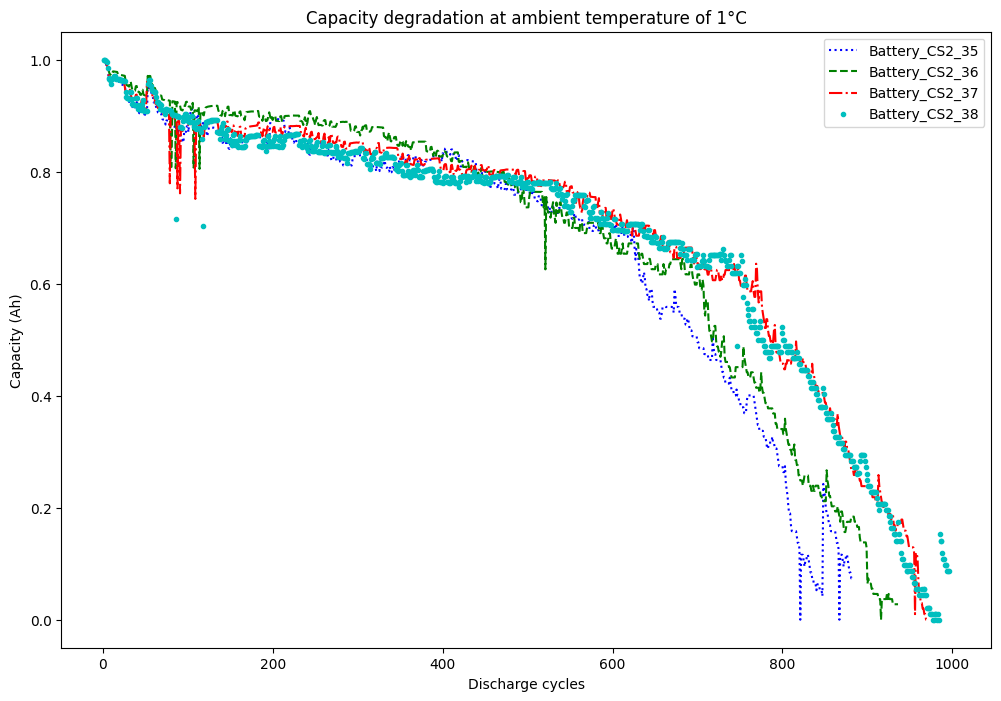

In [7]:
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
#EOL = ax.hlines(y=0.18,xmin = 0, xmax = 170, linewidth=2, color='r', linestyles = 'dashed', label='End of Life')
plt.legend()

## **Divide in Training, Validation and Test Batteries**

In [9]:
train_batteries = random.sample(Battery_list, 2)
remaining_batteries = list(set(Battery_list) - set(train_batteries))
valid_battery = random.choice(remaining_batteries)
test_battery = list(set(remaining_batteries) - set([valid_battery]))[0]

print(f"Train batteries: {train_batteries}")
print(f"Validation battery: {valid_battery}")
print(f"Test battery: {test_battery}")

Train batteries: ['CS2_37', 'CS2_36']
Validation battery: CS2_35
Test battery: CS2_38


In [10]:
def get_dataloader(battery_names, batch_size=16):
    datasets = []
    for battery in battery_names:
        with open(f'preprocess/data/CALCE/{battery}_processed.pkl', 'rb') as f:
            data = pickle.load(f)
            var = data['var']
            target_var = data['target_var']
            X_tensor = torch.tensor(var, dtype=torch.float32)
            y_tensor = torch.tensor(target_var, dtype=torch.float32).view(-1, 1)
            dataset = TensorDataset(X_tensor, y_tensor)
            datasets.append(dataset)
    combined_dataset = ConcatDataset(datasets)
    loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    return loader

In [11]:
train_loader = get_dataloader(train_batteries)
valid_loader = get_dataloader([valid_battery])
test_loader = get_dataloader([test_battery])

## **Model**

In [12]:
class TimeEmbedding(nn.Module):
    def __init__(self, time_points, time_embedding_dim, device):
        super().__init__()
        self.time_embedding = nn.Embedding(time_points, time_embedding_dim).to(device)

    def forward(self, x):
        return self.time_embedding(x)

class Conv1d_with_init(nn.Conv1d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros'):
        super().__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias, padding_mode)
        nn.init.kaiming_normal_(self.weight)
        if self.bias is not None:
            nn.init.constant_(self.bias, 0)

class DiffusionEmbedding(nn.Module):
    def __init__(self, num_steps, embedding_dim, device):
        super().__init__()
        self.device = device
        self.register_buffer('diffusion_embedding', self._build_embedding(num_steps, embedding_dim // 2), persistent=False)
        self.projection1 = nn.Linear(embedding_dim, embedding_dim).to(device)
        self.projection2 = nn.Linear(embedding_dim, embedding_dim).to(device)

    def forward(self, diffusion_step):
        x = self.diffusion_embedding[diffusion_step]
        if x.dim() == 1:
            x = x.unsqueeze(0)
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, num_steps, dim):
        steps = torch.arange(num_steps).unsqueeze(1).to(self.device)
        frequencies = (10.0 ** (torch.arange(dim) / (dim - 1) * 4.0).unsqueeze(0)).to(self.device)
        table = steps * frequencies
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table

class TransformerLayer(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.layer_norm = nn.LayerNorm(config['channels'])
        self.attn = nn.MultiheadAttention(embed_dim=config['channels'], num_heads=config['num_heads'])
        self.ffn = nn.Sequential(
            nn.Linear(config['channels'], config['channels'] * 4),
            nn.ReLU(),
            nn.Linear(config['channels'] * 4, config['channels']),
        )
        self.dropout = nn.Dropout(config.get('dropout', 0.5))
        self.device = device

    def forward(self, x, y):
        original_y = y  # Save original y for skip connection

        #print("Input x shape:", x.shape)
        #print("Input y shape:", y.shape)

        if y.dim() == 4:
            y = y.view(-1, y.shape[2], y.shape[3])  # Assuming seq_len, batch, channel, feature
            original_y = y
        elif y.dim() == 5:
            y = y.view(-1, y.shape[2] * y.shape[3], y.shape[4])  # Assuming combining some dimensions
            original_y = y
        elif y.dim() == 2:
            y = y.unsqueeze(0)  # Add a batch dimension if missing

        #print("Adjusted y shape for processing:", y.shape)

        y = self.layer_norm(y)
        #print("Post layer norm y shape:", y.shape)

        # Attention operation
        attn_output, attn_weights = self.attn(y, y, y)  # Ensure y is a 3D tensor [seq_len, batch_size, features]
        #print("Post attention output shape:", attn_output.shape)

        # Apply residual connections and dropout
        y = y + self.dropout(attn_output)
        y = y + self.dropout(self.ffn(y))

        return y, original_y  # Return both the transformed y and the original y as a skip connection

class ResNet(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.size_x = config['size']
        self.channels = config['channels']
        num_features = 1  # Only the capacity feature
        lv = len(var)

        self.emb_t = TimeEmbedding(config['time_points'], config['time_embedding_dim'], self.device)
        self.emb_v = nn.Linear(1, self.channels).to(self.device)
        self.emb_f = nn.Embedding(lv + 1, self.channels).to(self.device)
        self.dec1 = Conv1d_with_init(self.channels, self.channels, 1)
        self.dec2 = Conv1d_with_init(self.channels, 1, 1)
        self.diffusion_embedding = DiffusionEmbedding(config['num_steps'], config['diffusion_embedding_dim'], self.device)
        self.diffusion_projection = nn.Linear(config['diffusion_embedding_dim'], self.channels).to(self.device)
        self.residual_layers = nn.ModuleList([
            TransformerLayer(config, self.device)
            for _ in range(config['layers'])
        ])
        self.to(self.device)

    def forward(self, samples_x, samples_y, diffusion_step):
        samples_y = samples_y.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()
        diffusion_emb = self.diffusion_embedding(diffusion_step)
        diffusion_emb = self.diffusion_projection(diffusion_emb)

        # Ensure diffusion_emb has the necessary dimensions
        if diffusion_emb.dim() == 2:
            diffusion_emb = diffusion_emb.unsqueeze(1)  # Add sequence dimension if missing

        # Broadcast diffusion_emb to match y_emb dimension
        samples_x = samples_x.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()
        samples_y = samples_y.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()

        x_emb = self.emb_f(samples_x)
        y_emb = self.emb_f(samples_y)

        y_emb, diffusion_emb = torch.broadcast_tensors(y_emb, diffusion_emb)  # Ensure dimensions are compatible
        y_emb += diffusion_emb

        # Process through your network layers
        skip = []
        for layer in self.residual_layers:
            y_emb, skip_connection = layer(x_emb, y_emb)
            skip.append(skip_connection)

        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)

        return output

In [13]:
class TDSTF(nn.Module):
    def __init__(self, config, device):
        super(TDSTF, self).__init__()
        self.device = device
        self.config_diff = config['diffusion']
        self.res_model = ResNet(self.config_diff, self.device)
        self.num_steps = self.config_diff['num_steps']
        self.beta = np.linspace(self.config_diff['beta_start'] ** 0.5, self.config_diff['beta_end'] ** 0.5, self.num_steps) ** 2
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1)

    def process(self, batch):
        samples_x = batch[0].to(self.device).float()
        samples_y = batch[1].to(self.device).float().view(-1, 1)
        return samples_x, samples_y

    def forward(self, samples_x, samples_y):
        t = torch.randint(0, self.num_steps, [len(samples_x)]).to(self.device)
        current_alpha = self.alpha_torch[t].unsqueeze(1)
        noise = torch.randn_like(samples_y).to(samples_y.device)
        mask_y = torch.ones_like(samples_y).squeeze()
        samples_y = ((current_alpha ** 0.5) * samples_y + ((1.0 - current_alpha) ** 0.5) * noise) * mask_y.unsqueeze(1)
        predicted = self.res_model(samples_x, samples_y, t)
        residual = torch.where(mask_y.unsqueeze(1) == 1, noise - predicted, torch.zeros_like(predicted))
        loss = (residual ** 2).mean()
        return loss

    def forecast(self, samples_x, samples_y, n_samples):
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device)
        for i in range(n_samples):
            samples_y = torch.randn_like(samples_y) * samples_y
            for t in range(self.num_steps - 1, -1, -1):
                mask_y = samples_y.squeeze()  # Adjusted to handle the correct shape
                mask_y = mask_y.unsqueeze(-1)  # Adjusting dimensions to match 'predicted' if needed

                predicted = self.res_model(samples_x, samples_y, torch.tensor([t]).to(self.device))
                predicted = predicted.view(-1, samples_y.size(1), predicted.size(-1))  # Adjust shape to match samples_y if necessary

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5

                # Ensure dimensions match
                if samples_y.shape != predicted.shape:
                    predicted = predicted.view(samples_y.shape)  # or use another way to ensure shapes are compatible

                samples_y = coeff1 * (samples_y - coeff2 * predicted) * mask_y

                if t > 0:
                    noise = torch.randn_like(samples_y) * mask_y
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5
                    samples_y += sigma * noise

            generation[i] = samples_y.detach()
        return generation.permute(1, 2, 0)


    def evaluate(self, samples_x, samples_y):
        with torch.no_grad():
            generation = self.forward(samples_x, samples_y)
        return generation, samples_y, samples_x

## **Training Procedure**

In [14]:


def train(model, config, train_loader, valid_loader=None, foldername='', data_path=''):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.1, weight_decay=5e-8)  # Use AdamW
    total_steps = len(train_loader) * 50
    warmup_steps = total_steps // 10  # 10% of total steps for warmup
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)
    if foldername != '':
        output_path = os.path.join(foldername, 'model.pth')

    num_epochs = config['train']['epochs']
    accumulation_steps = config['train'].get('accumulation_steps', 4)
    optimizer.zero_grad()  # Initialize gradient

    ct = 0
    training_losses = []
    validation_losses = []
    best_valid_loss = float('inf')
    patience = 30  # Increase patience for early stopping

    for epoch in range(num_epochs):
        total_loss = 0
        model.train()
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}') as progress_bar:
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                inputs, labels = inputs.to(model.device), labels.to(model.device)
                loss = model(inputs, labels) / accumulation_steps
                loss.backward()  # Accumulate gradient

                # Gradient Clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                if (batch_idx + 1) % accumulation_steps == 0:
                    optimizer.step()  # Perform a parameter update
                    optimizer.zero_grad()  # Reset gradients

                total_loss += loss.item() * accumulation_steps  # Correct loss scaling

                progress_bar.update(1)
                progress_bar.set_postfix(loss=total_loss / (batch_idx + 1))

        # Scheduler step
        scheduler.step()

        # Check remaining gradient update at the end of an epoch
        if len(train_loader) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        avg_train_loss = total_loss / len(train_loader)
        training_losses.append(avg_train_loss)

        # Validation phase
        if valid_loader:
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for inputs, labels in valid_loader:
                    inputs, labels = inputs.to(model.device), labels.to(model.device)
                    outputs = model(inputs, labels)
                    valid_loss += outputs.item()
            valid_loss /= len(valid_loader)
            validation_losses.append(valid_loss)
            print(f'Validation Loss: {valid_loss}')

            # Save model if validation loss improved
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                output_path = 'save/CALCE'
#                 torch.save(model.state_dict(), output_path)
                print('Model saved with best validation loss:', best_valid_loss)
                ct = 0  # Reset early stopping count
            else:
                ct += 1
                print('No improvement count:', ct)

            if ct >= patience:  # Early stopping condition
                print('Early stopping triggered.')
                break

    return model, training_losses, validation_losses
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
def calc_metrics(data_loader,is_test, all_generation, all_samples_y, title=""):
    MSE = None
    if is_test == 1:
        quantiles = np.arange(0.05, 1.0, 0.05)
        actual_values=all_samples_y
        gt = all_samples_y.cpu()  # Ensure all_samples_y is a tensor and moved to CPU
        mask = torch.ones_like(gt).cpu()  
        prediction = all_generation
        predictions = torch.stack(all_generation).flatten().cpu()  
        if torch.is_tensor(predictions):
            predictions_np = predictions.detach().cpu().numpy()
        else:
            predictions_np = np.array(predictions)
        prediction1 = torch.tensor(prediction).cpu()  
        MSE = ((prediction1 - gt) * mask) ** 2
        MSE = MSE.sum() / mask.sum()
        y_true = np.array(gt.cpu())  
        y_pred = np.array(prediction1.cpu())  
        
#        Calculate CRPS
        crps_values = []
        for i in range(len(y_true)):
            F_y = lambda x: np.mean(y_true[i] <= x)
            F_f = lambda x: np.mean(y_pred[i] <= x)
            def integrand(x):
                return (F_y(x) - F_f(x)) ** 2
            crps_value, _ = quad(integrand, -np.inf, np.inf)
            crps_values.append(crps_value)
        CRPS = np.mean(crps_values)
        
#     Calculate Test Loss
    test_loss = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(model.device), labels.to(model.device)
            outputs = model(inputs, labels)
            test_loss += outputs.item()
        test_loss /= len(test_loader)
    print()
    print("********************Matrices*********************")
    print(f"Test Loss is: {test_loss}")
    print(f"MSE is: {MSE}")
    print(f"CRPS is: {CRPS}")
    
#         Plotting Predictions Graph
    plt.figure(figsize=(10, 6))
    plt.plot(actual_values, label='test data', color='cyan')
    plt.plot(predictions_np, label='fixed predicted data', color='blue')
    plt.axhline(y=0.8, color='black', linestyle='dotted', label='stop line')
    plt.xlabel('Discharge cycles')
    plt.ylabel('Capacity (Ah)')
    plt.title(title)
    plt.legend()
    plt.show()
    return CRPS,MSE,test_loss,all_generation

def evaluate(is_test, model, data_loader, nsample=100, foldername="", title=""):
    with torch.no_grad():
        model.eval()
        all_samples_x = []
        all_samples_y = []
        all_generation = []
        with tqdm(data_loader, mininterval=5.0, maxinterval=50.0) as it:
            for batch_no, batch in enumerate(it, start=1):
                samples_x, samples_y = batch
                samples_x, samples_y = samples_x.to(model.device), samples_y.to(model.device)
                # Generate predictions
                generation, samples_y, samples_x = model.evaluate(samples_x, samples_y)
                all_generation.append(generation.cpu())  # Move to CPU
                all_samples_x.append(samples_x.cpu())  
                all_samples_y.append(samples_y.cpu())  

            all_samples_y = [y.mean().cpu() for y in all_samples_y]  # Ensure each mean is moved to CPU
            all_samples_x = torch.cat(all_samples_x).cpu()  
            all_samples_y = torch.tensor(all_samples_y).cpu()  
            CRPS, MSE, loss, predictions = calc_metrics(data_loader, is_test, all_generation, all_samples_y,title)
            return CRPS, MSE, loss, predictions

In [15]:
def plot_losses(training_losses, validation_losses, battery, title=""):
    plt.figure(figsize=(10, 6))
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    saving_path = f'figures/CALCE/{battery}_losses.png'
    os.makedirs(os.path.dirname(saving_path), exist_ok=True)
    plt.savefig(saving_path)
    plt.show()

## **Execution**

In [16]:
CUDA_LAUNCH_BLOCKING = 1

import argparse
import torch
import datetime
import json
import yaml
import os

parser = argparse.ArgumentParser(description='')
parser.add_argument('--device', default='cpu')
parser.add_argument('--modelfolder', type=str, default='')
parser.add_argument('--nsample', type=int, default=882)
args, unknown = parser.parse_known_args()
# print(args)

config = yaml.safe_load(open('config/base.yaml', 'r'))
print(json.dumps(config, indent=4))

default_batch_size = 16
batch_size = config.get('train', {}).get('batch_size', default_batch_size)
current_time = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
base_foldername = 'save/CALCE/attention_' + current_time + '/'
print('model base folder:', base_foldername)

os.makedirs(base_foldername, exist_ok=True)
battery = train_batteries
PredictionResults = {}
print(f"Training for battery: {battery}")

data_path = f'preprocess/data/CALCE/processed.pkl'
foldername = base_foldername + '/'
os.makedirs(foldername, exist_ok=True)

train_loader = get_dataloader(train_batteries)
valid_loader = get_dataloader([valid_battery])
test_loader = get_dataloader([test_battery])
model = TDSTF(config, args.device).to(args.device)

if args.modelfolder == '':
    trained_model, train_loss, valid_loss =train(
        model,
        config,
        train_loader,
        valid_loader=valid_loader,
        foldername=foldername
    )
else:
    model.load_state_dict(torch.load('save/CALCE/' + args.modelfolder + '/model.pth'))

{
    "train": {
        "epochs": 50,
        "batch_size": 32,
        "lr": 0.001
    },
    "diffusion": {
        "size": 32,
        "layers": 3,
        "channels": 128,
        "num_heads": 8,
        "ff_dim": 512,
        "time_points": 40,
        "diffusion_embedding_dim": 128,
        "time_embedding_dim": 128,
        "beta_start": 0.0001,
        "beta_end": 0.5,
        "num_steps": 50
    }
}
model base folder: save/CALCE/attention_20240806_150212/
Training for battery: ['CS2_37', 'CS2_36']


Epoch 1/50:   1%|          | 1/113 [00:00<00:04, 26.69it/s, loss=2.33]

Epoch 1/50: 100%|██████████| 113/113 [00:01<00:00, 65.04it/s, loss=1.79]


Validation Loss: 1.4917425971764784
Model saved with best validation loss: 1.4917425971764784


Epoch 2/50: 100%|██████████| 113/113 [00:01<00:00, 64.72it/s, loss=1.75]


Validation Loss: 1.1788223729683802
Model saved with best validation loss: 1.1788223729683802


Epoch 3/50: 100%|██████████| 113/113 [00:01<00:00, 65.06it/s, loss=1.16]


Validation Loss: 1.207533033994528
No improvement count: 1


Epoch 4/50: 100%|██████████| 113/113 [00:01<00:00, 75.84it/s, loss=1.12]


Validation Loss: 1.0377367809414864
Model saved with best validation loss: 1.0377367809414864


Epoch 5/50: 100%|██████████| 113/113 [00:01<00:00, 69.08it/s, loss=1.22]


Validation Loss: 1.1721608237578318
No improvement count: 1


Epoch 6/50: 100%|██████████| 113/113 [00:01<00:00, 74.53it/s, loss=1.19]


Validation Loss: 1.4566324685628598
No improvement count: 2


Epoch 7/50: 100%|██████████| 113/113 [00:01<00:00, 71.71it/s, loss=1.2] 


Validation Loss: 1.1515594629141002
No improvement count: 3


Epoch 8/50: 100%|██████████| 113/113 [00:01<00:00, 72.27it/s, loss=1.13]


Validation Loss: 1.0124467198665326
Model saved with best validation loss: 1.0124467198665326


Epoch 9/50: 100%|██████████| 113/113 [00:01<00:00, 72.47it/s, loss=1.06]


Validation Loss: 0.9693705731859574
Model saved with best validation loss: 0.9693705731859574


Epoch 10/50: 100%|██████████| 113/113 [00:01<00:00, 69.60it/s, loss=1.03]


Validation Loss: 1.0750415130303457
No improvement count: 1


Epoch 11/50: 100%|██████████| 113/113 [00:01<00:00, 73.68it/s, loss=1.1] 


Validation Loss: 1.0225434091228705
No improvement count: 2


Epoch 12/50: 100%|██████████| 113/113 [00:01<00:00, 72.37it/s, loss=1.02]


Validation Loss: 1.0841805837475336
No improvement count: 3


Epoch 13/50: 100%|██████████| 113/113 [00:01<00:00, 74.97it/s, loss=0.996]


Validation Loss: 1.114175367813844
No improvement count: 4


Epoch 14/50: 100%|██████████| 113/113 [00:01<00:00, 72.00it/s, loss=0.994]


Validation Loss: 1.0102873742580414
No improvement count: 5


Epoch 15/50: 100%|██████████| 113/113 [00:01<00:00, 72.11it/s, loss=1.01]


Validation Loss: 0.9966596393631055
No improvement count: 6


Epoch 16/50: 100%|██████████| 113/113 [00:01<00:00, 74.42it/s, loss=1.01]


Validation Loss: 1.031952671133555
No improvement count: 7


Epoch 17/50: 100%|██████████| 113/113 [00:01<00:00, 74.57it/s, loss=1.1] 


Validation Loss: 1.1311858296394348
No improvement count: 8


Epoch 18/50: 100%|██████████| 113/113 [00:01<00:00, 68.83it/s, loss=1.09]


Validation Loss: 1.1091683042737155
No improvement count: 9


Epoch 19/50: 100%|██████████| 113/113 [00:01<00:00, 73.08it/s, loss=0.986]


Validation Loss: 1.006677426970922
No improvement count: 10


Epoch 20/50: 100%|██████████| 113/113 [00:01<00:00, 74.74it/s, loss=1.01]


Validation Loss: 1.080442576454236
No improvement count: 11


Epoch 21/50: 100%|██████████| 113/113 [00:01<00:00, 67.85it/s, loss=1.05]


Validation Loss: 1.0324317881694207
No improvement count: 12


Epoch 22/50: 100%|██████████| 113/113 [00:01<00:00, 74.89it/s, loss=1.03]


Validation Loss: 1.0914025788123791
No improvement count: 13


Epoch 23/50: 100%|██████████| 113/113 [00:01<00:00, 74.77it/s, loss=1.07]


Validation Loss: 1.1886693789408758
No improvement count: 14


Epoch 24/50: 100%|██████████| 113/113 [00:01<00:00, 74.78it/s, loss=1.02]


Validation Loss: 0.9975271425568141
No improvement count: 15


Epoch 25/50: 100%|██████████| 113/113 [00:01<00:00, 75.00it/s, loss=1.05]


Validation Loss: 1.1254992691370158
No improvement count: 16


Epoch 26/50: 100%|██████████| 113/113 [00:01<00:00, 74.50it/s, loss=1.08]


Validation Loss: 0.9353647873951838
Model saved with best validation loss: 0.9353647873951838


Epoch 27/50: 100%|██████████| 113/113 [00:01<00:00, 75.15it/s, loss=1.08]


Validation Loss: 0.9254914969205856
Model saved with best validation loss: 0.9254914969205856


Epoch 28/50: 100%|██████████| 113/113 [00:01<00:00, 75.16it/s, loss=0.968]


Validation Loss: 0.9813090723294479
No improvement count: 1


Epoch 29/50: 100%|██████████| 113/113 [00:01<00:00, 76.94it/s, loss=1.03]


Validation Loss: 0.9456119107512327
No improvement count: 2


Epoch 30/50: 100%|██████████| 113/113 [00:01<00:00, 75.54it/s, loss=0.987]


Validation Loss: 0.9487069008442072
No improvement count: 3


Epoch 31/50: 100%|██████████| 113/113 [00:01<00:00, 76.64it/s, loss=1.03]


Validation Loss: 0.9995510738629562
No improvement count: 4


Epoch 32/50: 100%|██████████| 113/113 [00:01<00:00, 76.53it/s, loss=1]    


Validation Loss: 0.9465680982057865
No improvement count: 5


Epoch 33/50: 100%|██████████| 113/113 [00:01<00:00, 73.30it/s, loss=0.987]


Validation Loss: 1.0267849742219999
No improvement count: 6


Epoch 34/50: 100%|██████████| 113/113 [00:01<00:00, 69.65it/s, loss=1.03]


Validation Loss: 1.0411929683043406
No improvement count: 7


Epoch 35/50: 100%|██████████| 113/113 [00:01<00:00, 71.74it/s, loss=1.01] 


Validation Loss: 1.0470228080566113
No improvement count: 8


Epoch 36/50: 100%|██████████| 113/113 [00:01<00:00, 73.11it/s, loss=0.991]


Validation Loss: 0.9231693928058331
Model saved with best validation loss: 0.9231693928058331


Epoch 37/50: 100%|██████████| 113/113 [00:01<00:00, 73.05it/s, loss=0.962]


Validation Loss: 0.9557494257505124
No improvement count: 1


Epoch 38/50: 100%|██████████| 113/113 [00:01<00:00, 71.54it/s, loss=1.03]


Validation Loss: 1.069944026378485
No improvement count: 2


Epoch 39/50: 100%|██████████| 113/113 [00:01<00:00, 72.81it/s, loss=1]    


Validation Loss: 0.9173489602712485
Model saved with best validation loss: 0.9173489602712485


Epoch 40/50: 100%|██████████| 113/113 [00:01<00:00, 73.58it/s, loss=1.04]


Validation Loss: 1.0017258009085288
No improvement count: 1


Epoch 41/50: 100%|██████████| 113/113 [00:01<00:00, 73.25it/s, loss=0.974]


Validation Loss: 0.957303632910435
No improvement count: 2


Epoch 42/50: 100%|██████████| 113/113 [00:01<00:00, 74.15it/s, loss=0.948]


Validation Loss: 1.0609445543243334
No improvement count: 3


Epoch 43/50: 100%|██████████| 113/113 [00:01<00:00, 70.90it/s, loss=0.955]


Validation Loss: 0.9773254411724898
No improvement count: 4


Epoch 44/50: 100%|██████████| 113/113 [00:01<00:00, 72.43it/s, loss=0.964]


Validation Loss: 0.9813104283351165
No improvement count: 5


Epoch 45/50: 100%|██████████| 113/113 [00:01<00:00, 75.66it/s, loss=0.905]


Validation Loss: 1.0818038244660084
No improvement count: 6


Epoch 46/50: 100%|██████████| 113/113 [00:01<00:00, 67.88it/s, loss=1.01]


Validation Loss: 1.0147684061756501
No improvement count: 7


Epoch 47/50: 100%|██████████| 113/113 [00:01<00:00, 70.57it/s, loss=1.02]


Validation Loss: 0.9633306797880393
No improvement count: 8


Epoch 48/50: 100%|██████████| 113/113 [00:01<00:00, 76.79it/s, loss=0.996]


Validation Loss: 0.9939003277283448
No improvement count: 9


Epoch 49/50: 100%|██████████| 113/113 [00:01<00:00, 77.25it/s, loss=0.99] 


Validation Loss: 1.0121226362310922
No improvement count: 10


Epoch 50/50: 100%|██████████| 113/113 [00:01<00:00, 74.14it/s, loss=0.999]


Validation Loss: 1.0463078033465605
No improvement count: 11


## **Plot Losses**

Test


100%|██████████| 60/60 [00:00<00:00, 233.53it/s]
/tmp/ipykernel_1418040/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 1.0168738747636477
MSE is: 0.3069993257522583
CRPS is: 0.38566873893847103


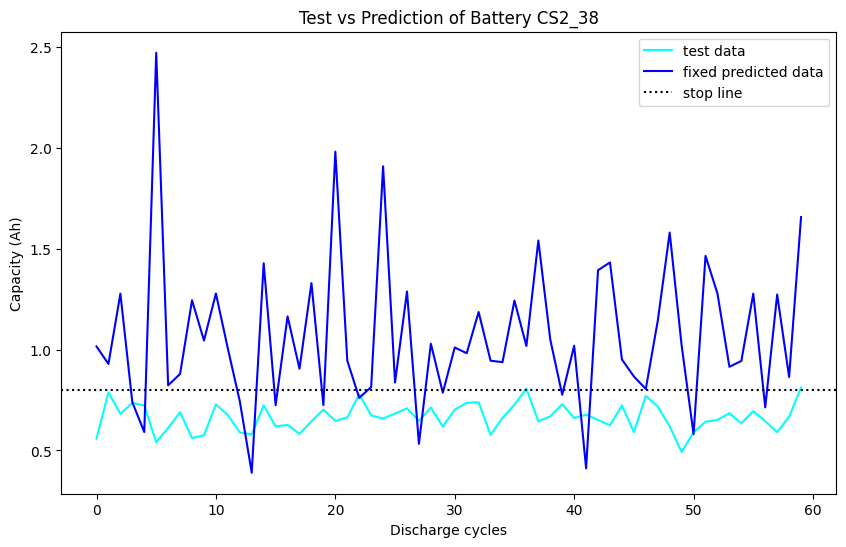

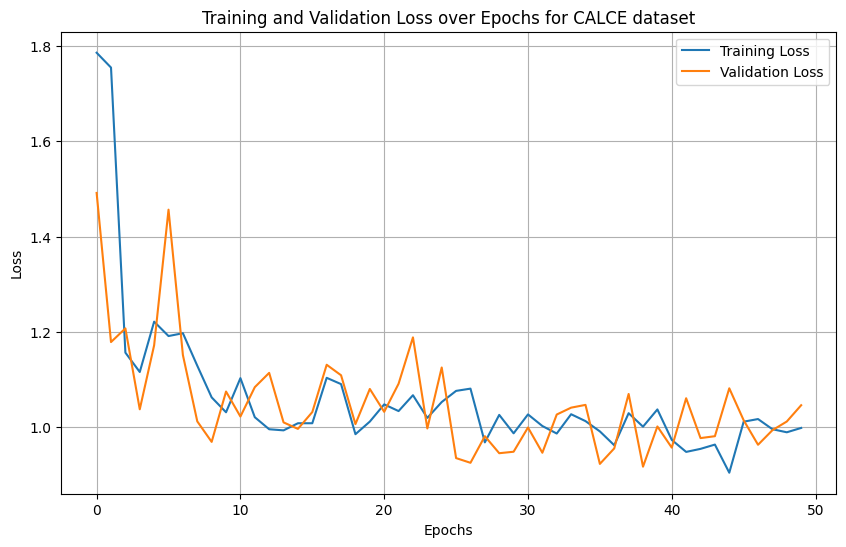

In [17]:
print('Test')
CRPS, MSE,loss,predictions = evaluate(is_test=True, model=model, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction of Battery {test_battery}')

# Plot losses
plot_losses(train_loss, valid_loss, test_battery, title='Training and Validation Loss over Epochs for CALCE dataset')

## **Grid Search**

In [21]:

# hyperparameters grid
param_grid = {
    'lr': [0.1, 0.01, 0.001],
    'dropout': [0.3, 0.5],
    'batch_size': [16, 32],
    'num_layers': [2, 4],
    'embedding_dim': [64, 128],
    'num_heads': [2, 4]
}

# Get dataloaders with specified batch size
def get_dataloader_with_batch_size(battery_names, batch_size):
    datasets = []
    for battery in battery_names:
        with open(f'preprocess/data/{battery}_processed.pkl', 'rb') as f:
            data = pickle.load(f)
            var = data['var']
            target_var = data['target_var']
            X_tensor = torch.tensor(var, dtype=torch.float32)
            y_tensor = torch.tensor(target_var, dtype=torch.float32).view(-1, 1)
            dataset = TensorDataset(X_tensor, y_tensor)
            datasets.append(dataset)
    combined_dataset = ConcatDataset(datasets)
    loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True)
    return loader

# Grid search 
best_valid_loss = float('inf')
best_params = None

for params in ParameterGrid(param_grid):
    # Update 
    config['train']['lr'] = params['lr']
    config['train']['batch_size'] = params['batch_size']
    config['diffusion']['dropout'] = params['dropout']
    config['diffusion']['time_embedding_dim'] = params['embedding_dim']

    train_loader = get_dataloader_with_batch_size(train_batteries, params['batch_size'])
    valid_loader = get_dataloader_with_batch_size([valid_battery], params['batch_size'])
    test_loader = get_dataloader_with_batch_size([test_battery], params['batch_size'])

    model = TDSTF(config, device).to(device)
    model, train_loss, valid_loss = train(model, config, train_loader, valid_loader=valid_loader, foldername=foldername)

    avg_valid_loss = np.mean(valid_loss)
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        best_params = params

print(f'Best parameters: {best_params}')
print(f'Best validation loss: {best_valid_loss}')

# Retrain 
config['train']['lr'] = best_params['lr']
config['train']['batch_size'] = best_params['batch_size']
config['diffusion']['dropout'] = best_params['dropout']
config['diffusion']['time_embedding_dim'] = best_params['embedding_dim']

train_loaderhyp = get_dataloader_with_batch_size(train_batteries, best_params['batch_size'])
valid_loaderhyp = get_dataloader_with_batch_size([valid_battery], best_params['batch_size'])
test_loaderhyp = get_dataloader_with_batch_size([test_battery], best_params['batch_size'])

modelhyp = TDSTF(config, device).to(device)
modelhyp, train_losshyp, valid_losshyp = train(modelhyp, config, train_loaderhyp, valid_loader=valid_loaderhyp)

# Evaluate 
CRPShyper, MSEhyper,losshyper,predictionshyper  = evaluate(is_test=True, model=modelhyp, data_loader=test_loaderhyp, nsample=1000, foldername=foldername)
print(f'Test:')
#plot_losses(train_losshyp, valid_losshyp, test_battery)

Epoch 1/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 40.57it/s, loss=17.3]


Validation Loss: 7.844706569399152
Model saved with best validation loss: 7.844706569399152


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=4.21]


Validation Loss: 1.2232166326471738
Model saved with best validation loss: 1.2232166326471738


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 41.48it/s, loss=1.31]


Validation Loss: 0.976940784071173
Model saved with best validation loss: 0.976940784071173


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.36it/s, loss=1.22]


Validation Loss: 1.2239031887480192
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 41.06it/s, loss=1.38]


Validation Loss: 1.128795366202082
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.40it/s, loss=1.19]


Validation Loss: 1.3569651022553444
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 49.69it/s, loss=1.09]


Validation Loss: 1.2142136639782362
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.97it/s, loss=1.24]


Validation Loss: 1.0324878660695893
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.13]


Validation Loss: 1.24234954480614
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 64.05it/s, loss=1.04]


Validation Loss: 1.199675484427384
No improvement count: 7


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.29it/s, loss=1.05]


Validation Loss: 1.0787490318928445
No improvement count: 8


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 61.29it/s, loss=1.07]


Validation Loss: 1.0793994729007994
No improvement count: 9


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 62.51it/s, loss=1.08]


Validation Loss: 1.061830044324909
No improvement count: 10


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 44.90it/s, loss=1.05]


Validation Loss: 1.178063056830849
No improvement count: 11


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 40.38it/s, loss=1.23]


Validation Loss: 1.1857818875994002
No improvement count: 12


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 41.61it/s, loss=1.03]


Validation Loss: 1.089706089347601
No improvement count: 13


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 41.74it/s, loss=1.1] 


Validation Loss: 0.9199548762823854
Model saved with best validation loss: 0.9199548762823854


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 41.58it/s, loss=1.07]


Validation Loss: 1.075565764946597
No improvement count: 1


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 41.74it/s, loss=1.04]


Validation Loss: 0.9923089758626052
No improvement count: 2


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 42.10it/s, loss=1.1] 


Validation Loss: 1.0959549301436968
No improvement count: 3


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 41.62it/s, loss=1.03]


Validation Loss: 1.0282612613269262
No improvement count: 4


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 41.32it/s, loss=1.1] 


Validation Loss: 0.9906720130571297
No improvement count: 5


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 41.42it/s, loss=1.07]


Validation Loss: 1.0288117676973343
No improvement count: 6


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 41.52it/s, loss=1.01]


Validation Loss: 0.9654228527631078
No improvement count: 7


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 41.32it/s, loss=0.955]


Validation Loss: 1.055895531816142
No improvement count: 8


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 41.09it/s, loss=0.967]


Validation Loss: 1.0453308655747346
No improvement count: 9


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=1.07]


Validation Loss: 0.9539242078151021
No improvement count: 10


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 41.42it/s, loss=1.02]


Validation Loss: 0.9387704421366964
No improvement count: 11


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 40.99it/s, loss=1.01] 


Validation Loss: 0.9258788259966033
No improvement count: 12


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 40.96it/s, loss=1.04]


Validation Loss: 0.9597965864730733
No improvement count: 13


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 41.27it/s, loss=0.986]


Validation Loss: 0.9551069635365691
No improvement count: 14


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 41.14it/s, loss=0.998]


Validation Loss: 1.0911000514669078
No improvement count: 15


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=0.969]


Validation Loss: 0.9801260158419609
No improvement count: 16


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 41.14it/s, loss=0.988]


Validation Loss: 1.046389292393412
No improvement count: 17


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=0.961]


Validation Loss: 0.9571740025920528
No improvement count: 18


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 41.32it/s, loss=0.981]


Validation Loss: 1.0304876150829452
No improvement count: 19


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=0.972]


Validation Loss: 1.0921933901097094
No improvement count: 20


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 41.68it/s, loss=1.05]


Validation Loss: 1.0498128299202238
No improvement count: 21


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 41.27it/s, loss=1.07]


Validation Loss: 0.9079543352127075
Model saved with best validation loss: 0.9079543352127075


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=1.03]


Validation Loss: 1.0010017454624176
No improvement count: 1


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 41.45it/s, loss=0.938]


Validation Loss: 1.0245728428874696
No improvement count: 2


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 41.09it/s, loss=0.982]


Validation Loss: 1.0609217419156007
No improvement count: 3


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 40.97it/s, loss=0.944]


Validation Loss: 1.0692379006317683
No improvement count: 4


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 40.86it/s, loss=0.985]


Validation Loss: 1.0335778684488364
No improvement count: 5


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s, loss=1.02]


Validation Loss: 0.9858327774064881
No improvement count: 6


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 41.04it/s, loss=0.956]


Validation Loss: 1.0825375728309155
No improvement count: 7


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 40.90it/s, loss=1.01]


Validation Loss: 0.9914883896708488
No improvement count: 8


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 41.42it/s, loss=0.958]


Validation Loss: 0.9347139996077333
No improvement count: 9


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.05it/s, loss=1.02] 


Validation Loss: 1.0348698374416148
No improvement count: 10


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 41.20it/s, loss=0.999]


Validation Loss: 0.9408127628266811
No improvement count: 11


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 40.12it/s, loss=2.07]


Validation Loss: 1.3475928891982352
Model saved with best validation loss: 1.3475928891982352


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 40.09it/s, loss=1.66]


Validation Loss: 1.0670985063271863
Model saved with best validation loss: 1.0670985063271863


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 40.40it/s, loss=1.22]


Validation Loss: 1.2374533084886414
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.21it/s, loss=1.12]


Validation Loss: 1.0796835316079003
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 41.24it/s, loss=1.06]


Validation Loss: 1.077382284881813
No improvement count: 3


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.29it/s, loss=1.1] 


Validation Loss: 1.1239555081618684
No improvement count: 4


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 41.09it/s, loss=1.04]


Validation Loss: 1.0639256084603923
Model saved with best validation loss: 1.0639256084603923


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 41.40it/s, loss=1.08]


Validation Loss: 0.9840114861726761
Model saved with best validation loss: 0.9840114861726761


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s, loss=1.09]


Validation Loss: 0.9980181721704346
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 41.23it/s, loss=1.05]


Validation Loss: 1.0870543058429445
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 41.24it/s, loss=1.05]


Validation Loss: 1.1035616440432412
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 41.22it/s, loss=1.07]


Validation Loss: 1.039144987506526
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=1.04]


Validation Loss: 1.0547068294669901
No improvement count: 5


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 40.99it/s, loss=1.07]


Validation Loss: 1.237981537623065
No improvement count: 6


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=1.08]


Validation Loss: 1.0110068182860101
No improvement count: 7


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 41.20it/s, loss=1.02]


Validation Loss: 0.986706483576979
No improvement count: 8


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 41.23it/s, loss=1.02]


Validation Loss: 1.0627190619707108
No improvement count: 9


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 41.11it/s, loss=1.11]


Validation Loss: 1.0638242300067628
No improvement count: 10


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=1.04]


Validation Loss: 1.0172930492886476
No improvement count: 11


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 40.93it/s, loss=1.05]


Validation Loss: 1.0361515719975745
No improvement count: 12


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 40.91it/s, loss=1.01]


Validation Loss: 0.9819460942276886
Model saved with best validation loss: 0.9819460942276886


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 41.22it/s, loss=0.975]


Validation Loss: 0.9885936390076365
No improvement count: 1


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 41.11it/s, loss=1.03]


Validation Loss: 0.9960785976478032
No improvement count: 2


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 41.32it/s, loss=1.06]


Validation Loss: 1.0088073903960841
No improvement count: 3


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 41.07it/s, loss=0.965]


Validation Loss: 1.0695100096719605
No improvement count: 4


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=0.956]


Validation Loss: 0.9365958443709782
Model saved with best validation loss: 0.9365958443709782


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 41.04it/s, loss=0.964]


Validation Loss: 1.017697597188609
No improvement count: 1


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s, loss=1.1] 


Validation Loss: 0.9689102614564555
No improvement count: 2


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=0.984]


Validation Loss: 0.9657304579658168
No improvement count: 3


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 41.25it/s, loss=1.02]


Validation Loss: 1.0499583684972353
No improvement count: 4


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 40.89it/s, loss=0.952]


Validation Loss: 1.0676935059683663
No improvement count: 5


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=1.04]


Validation Loss: 0.9409929162689618
No improvement count: 6


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.93it/s, loss=1.04]


Validation Loss: 0.9265068173408508
Model saved with best validation loss: 0.9265068173408508


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=1.02]


Validation Loss: 1.0261403449944086
No improvement count: 1


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=0.904]


Validation Loss: 1.063334216496774
No improvement count: 2


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 40.86it/s, loss=1]   


Validation Loss: 0.9545492673558849
No improvement count: 3


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=1.09]


Validation Loss: 0.9717562794685364
No improvement count: 4


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 41.21it/s, loss=1.01]


Validation Loss: 1.0868717730045319
No improvement count: 5


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 40.95it/s, loss=0.962]


Validation Loss: 1.0278724783233233
No improvement count: 6


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 43.47it/s, loss=1]   


Validation Loss: 1.0264830903283186
No improvement count: 7


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 44.30it/s, loss=0.953]


Validation Loss: 0.9503869174846581
No improvement count: 8


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 44.48it/s, loss=0.954]


Validation Loss: 0.9247374837952
Model saved with best validation loss: 0.9247374837952


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 41.62it/s, loss=1.01]


Validation Loss: 0.9932598407779422
No improvement count: 1


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=1.05]


Validation Loss: 1.0469223260879517
No improvement count: 2


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 40.97it/s, loss=1.02]


Validation Loss: 1.025210658886603
No improvement count: 3


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 41.23it/s, loss=1.07]


Validation Loss: 0.9241321874516351
Model saved with best validation loss: 0.9241321874516351


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 40.91it/s, loss=1]    


Validation Loss: 1.0276207269302435
No improvement count: 1


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 41.10it/s, loss=1.09]


Validation Loss: 0.9601290534649577
No improvement count: 2


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.15it/s, loss=0.974]


Validation Loss: 1.0447151730103152
No improvement count: 3


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=0.982]


Validation Loss: 0.9943569502128022
No improvement count: 4


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=1.8] 


Validation Loss: 1.5278729349374771
Model saved with best validation loss: 1.5278729349374771


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 41.41it/s, loss=2.7] 


Validation Loss: 1.313134073146752
Model saved with best validation loss: 1.313134073146752


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 41.49it/s, loss=1.37]


Validation Loss: 1.021576049072402
Model saved with best validation loss: 1.021576049072402


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=1.19]


Validation Loss: 1.329945398228509
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 41.05it/s, loss=1.51]


Validation Loss: 1.2002209999731608
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.01it/s, loss=1.19]


Validation Loss: 1.0289963952132635
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 40.91it/s, loss=1.09]


Validation Loss: 1.1517190683100904
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 40.68it/s, loss=1.16]


Validation Loss: 0.997344893004213
Model saved with best validation loss: 0.997344893004213


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 40.84it/s, loss=1.08]


Validation Loss: 1.0074867866933346
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 41.06it/s, loss=1.06]


Validation Loss: 1.007392723911575
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=1.09]


Validation Loss: 1.22450269226517
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 40.93it/s, loss=1.11]


Validation Loss: 0.9809748785836356
Model saved with best validation loss: 0.9809748785836356


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 40.89it/s, loss=1.02]


Validation Loss: 1.0327583657843726
No improvement count: 1


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 40.51it/s, loss=1.12]


Validation Loss: 0.9572895573718208
Model saved with best validation loss: 0.9572895573718208


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 40.23it/s, loss=1.06]


Validation Loss: 1.0661267702068602
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 40.33it/s, loss=1.1] 


Validation Loss: 1.0400427473442895
No improvement count: 2


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 40.40it/s, loss=1.05]


Validation Loss: 0.930619475032602
Model saved with best validation loss: 0.930619475032602


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 40.38it/s, loss=1.05]


Validation Loss: 1.000466840075595
No improvement count: 1


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 40.35it/s, loss=1.07]


Validation Loss: 1.0387940422764845
No improvement count: 2


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 40.32it/s, loss=1.05]


Validation Loss: 1.1089141677532877
No improvement count: 3


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 40.39it/s, loss=1.07]


Validation Loss: 0.9483866798026221
No improvement count: 4


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 41.22it/s, loss=1.03]


Validation Loss: 0.9824525314782347
No improvement count: 5


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=1.04]


Validation Loss: 1.0438395967440945
No improvement count: 6


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 40.80it/s, loss=1.07]


Validation Loss: 0.9338802312101636
No improvement count: 7


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 40.96it/s, loss=1.01]


Validation Loss: 1.0792155217911517
No improvement count: 8


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 41.02it/s, loss=1.05]


Validation Loss: 1.0181097191359316
No improvement count: 9


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 40.93it/s, loss=0.974]


Validation Loss: 0.9967560869242463
No improvement count: 10


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=0.923]


Validation Loss: 1.0479009300470352
No improvement count: 11


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 41.10it/s, loss=1.03]


Validation Loss: 1.0289188660681248
No improvement count: 12


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 41.11it/s, loss=0.97] 


Validation Loss: 0.923192695315395
Model saved with best validation loss: 0.923192695315395


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 41.20it/s, loss=0.99] 


Validation Loss: 1.0167652166315488
No improvement count: 1


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 41.15it/s, loss=1.04]


Validation Loss: 1.060722297855786
No improvement count: 2


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.94it/s, loss=0.998]


Validation Loss: 1.02154398390225
No improvement count: 3


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=0.974]


Validation Loss: 1.108433588807072
No improvement count: 4


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=1]    


Validation Loss: 1.0127243234642915
No improvement count: 5


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=1.03]


Validation Loss: 1.0044648269457477
No improvement count: 6


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 41.41it/s, loss=1.05]


Validation Loss: 1.0042997476245676
No improvement count: 7


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 41.45it/s, loss=1.02]


Validation Loss: 0.9915213611509118
No improvement count: 8


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 41.38it/s, loss=1.03]


Validation Loss: 1.0253085185374533
No improvement count: 9


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 41.40it/s, loss=1.07]


Validation Loss: 0.9449729536260877
No improvement count: 10


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 41.66it/s, loss=1.05]


Validation Loss: 1.0065013585346085
No improvement count: 11


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 41.66it/s, loss=1.04]


Validation Loss: 0.9966010100075177
No improvement count: 12


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 41.27it/s, loss=1.01]


Validation Loss: 0.9755572389279094
No improvement count: 13


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 41.49it/s, loss=1.04]


Validation Loss: 1.0239108896681242
No improvement count: 14


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 41.49it/s, loss=0.983]


Validation Loss: 0.9615727482097489
No improvement count: 15


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 41.59it/s, loss=0.971]


Validation Loss: 0.9902620001563004
No improvement count: 16


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 40.71it/s, loss=1.06]


Validation Loss: 0.955622353724071
No improvement count: 17


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 41.52it/s, loss=0.99] 


Validation Loss: 1.0379211577985967
No improvement count: 18


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.59it/s, loss=0.98] 


Validation Loss: 0.9548568055033684
No improvement count: 19


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 41.40it/s, loss=1.08]


Validation Loss: 2.2440665747438158
No improvement count: 20


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 41.64it/s, loss=1.9] 


Validation Loss: 1.7664668506809644
Model saved with best validation loss: 1.7664668506809644


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 41.67it/s, loss=3.76]


Validation Loss: 1.3882389355983054
Model saved with best validation loss: 1.3882389355983054


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 41.45it/s, loss=1.32]


Validation Loss: 0.9686419138950961
Model saved with best validation loss: 0.9686419138950961


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.39it/s, loss=1.18]


Validation Loss: 1.12391306619559
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 41.47it/s, loss=1.1] 


Validation Loss: 1.0220877506903239
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=1.2] 


Validation Loss: 1.1458523901445525
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 40.71it/s, loss=1.08]


Validation Loss: 1.5904108232685499
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 40.78it/s, loss=1.08]


Validation Loss: 1.174455868878535
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 40.86it/s, loss=1.16]


Validation Loss: 1.0622204515550817
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 41.06it/s, loss=1.14]


Validation Loss: 1.2642532544476646
No improvement count: 7


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 40.92it/s, loss=1.1] 


Validation Loss: 1.253102034330368
No improvement count: 8


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 41.15it/s, loss=1.18]


Validation Loss: 1.1358997193830354
No improvement count: 9


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 40.83it/s, loss=1.16]


Validation Loss: 0.9673041845006602
Model saved with best validation loss: 0.9673041845006602


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 40.93it/s, loss=1.06]


Validation Loss: 1.0518566220998764
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 41.22it/s, loss=1.07]


Validation Loss: 0.95592243543693
Model saved with best validation loss: 0.95592243543693


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 40.94it/s, loss=1.05]


Validation Loss: 1.3187683607850755
No improvement count: 1


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 40.89it/s, loss=1.14]


Validation Loss: 1.1110409594007902
No improvement count: 2


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=1.12]


Validation Loss: 1.2443018960101264
No improvement count: 3


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 40.99it/s, loss=1.07]


Validation Loss: 1.2717076518705912
No improvement count: 4


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 40.96it/s, loss=1.02]


Validation Loss: 0.9848413243889809
No improvement count: 5


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 40.82it/s, loss=1.12]


Validation Loss: 1.0309760948376996
No improvement count: 6


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 41.03it/s, loss=0.971]


Validation Loss: 0.9243628749889987
Model saved with best validation loss: 0.9243628749889987


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 40.95it/s, loss=0.978]


Validation Loss: 1.0288340433367662
No improvement count: 1


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 40.92it/s, loss=0.946]


Validation Loss: 0.9897803222494466
No improvement count: 2


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 40.83it/s, loss=0.976]


Validation Loss: 0.9389820583164692
No improvement count: 3


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 40.64it/s, loss=0.936]


Validation Loss: 0.9531682740364756
No improvement count: 4


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 41.06it/s, loss=1.02]


Validation Loss: 0.9982446187308857
No improvement count: 5


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 40.96it/s, loss=0.976]


Validation Loss: 1.0076829876218523
No improvement count: 6


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 40.60it/s, loss=0.985]


Validation Loss: 1.0354163263525282
No improvement count: 7


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 40.83it/s, loss=1]    


Validation Loss: 1.0025553330779076
No improvement count: 8


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=0.927]


Validation Loss: 0.9808042113270078
No improvement count: 9


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 40.92it/s, loss=0.956]


Validation Loss: 0.9555021348808493
No improvement count: 10


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.91it/s, loss=1.04]


Validation Loss: 0.9474016161901611
No improvement count: 11


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 40.90it/s, loss=0.968]


Validation Loss: 0.9966209573405129
No improvement count: 12


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 40.90it/s, loss=1.03]


Validation Loss: 1.0853662341833115
No improvement count: 13


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 41.03it/s, loss=1.07]


Validation Loss: 1.0093611585242408
No improvement count: 14


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=0.946]


Validation Loss: 0.9573820738920144
No improvement count: 15


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 41.21it/s, loss=1.02]


Validation Loss: 0.9955213479697704
No improvement count: 16


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 41.01it/s, loss=1.01]


Validation Loss: 1.004365188734872
No improvement count: 17


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 41.03it/s, loss=1.02]


Validation Loss: 1.000452103891543
No improvement count: 18


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=1.1] 


Validation Loss: 1.0729909714843546
No improvement count: 19


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 41.26it/s, loss=0.991]


Validation Loss: 0.964772995029177
No improvement count: 20


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 41.23it/s, loss=0.969]


Validation Loss: 1.0618113806205136
No improvement count: 21


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 41.08it/s, loss=1.02]


Validation Loss: 0.9701241504933152
No improvement count: 22


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 41.26it/s, loss=0.989]


Validation Loss: 0.923382829874754
Model saved with best validation loss: 0.923382829874754


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 41.39it/s, loss=1.02]


Validation Loss: 0.9354190177151135
No improvement count: 1


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=0.963]


Validation Loss: 1.014469307980367
No improvement count: 2


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s, loss=0.984]


Validation Loss: 0.9973410320069108
No improvement count: 3


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.41it/s, loss=1.01]


Validation Loss: 1.0120887272059917
No improvement count: 4


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 41.20it/s, loss=1.04]


Validation Loss: 1.0059681093054158
No improvement count: 5


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 40.94it/s, loss=5.87]


Validation Loss: 1.8306655990225928
Model saved with best validation loss: 1.8306655990225928


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 41.40it/s, loss=2.32]


Validation Loss: 1.116623769913401
Model saved with best validation loss: 1.116623769913401


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 41.05it/s, loss=1.12]


Validation Loss: 0.989931008113282
Model saved with best validation loss: 0.989931008113282


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.08it/s, loss=1.15]


Validation Loss: 1.2179642410150595
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=1.14]


Validation Loss: 0.9690415076911449
Model saved with best validation loss: 0.9690415076911449


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=1.14]


Validation Loss: 1.0081810653209686
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 41.23it/s, loss=1.11]


Validation Loss: 1.1156842140480876
No improvement count: 2


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=1.12]


Validation Loss: 1.1010580347584826
No improvement count: 3


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 41.15it/s, loss=1.11]


Validation Loss: 1.2976715740348612
No improvement count: 4


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 41.17it/s, loss=1.08]


Validation Loss: 1.0915713150586401
No improvement count: 5


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 40.90it/s, loss=1.07]


Validation Loss: 1.0986569135316782
No improvement count: 6


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=1.11]


Validation Loss: 1.1067842149308749
No improvement count: 7


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 41.21it/s, loss=1.07]


Validation Loss: 1.024310008755752
No improvement count: 8


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 41.10it/s, loss=0.964]


Validation Loss: 0.9772970708353179
No improvement count: 9


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 40.91it/s, loss=1.02]


Validation Loss: 1.0257735864392348
No improvement count: 10


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 41.25it/s, loss=1.08]


Validation Loss: 1.0373141887996877
No improvement count: 11


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 41.07it/s, loss=1.01]


Validation Loss: 0.9804950553391661
No improvement count: 12


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 41.24it/s, loss=1.01] 


Validation Loss: 1.1185515126479524
No improvement count: 13


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 41.37it/s, loss=1.05]


Validation Loss: 0.9701268555862563
No improvement count: 14


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 41.38it/s, loss=0.974]


Validation Loss: 0.9938521395836558
No improvement count: 15


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=1.03]


Validation Loss: 1.0083650137696947
No improvement count: 16


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 41.08it/s, loss=0.968]


Validation Loss: 0.9577629002077239
Model saved with best validation loss: 0.9577629002077239


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 41.23it/s, loss=1.01] 


Validation Loss: 0.9942047995116029
No improvement count: 1


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 41.28it/s, loss=0.973]


Validation Loss: 1.1114435100129672
No improvement count: 2


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 41.50it/s, loss=1.05]


Validation Loss: 1.1068173998168536
No improvement count: 3


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 41.22it/s, loss=0.967]


Validation Loss: 1.003530842917306
No improvement count: 4


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 41.33it/s, loss=0.954]


Validation Loss: 1.002347161727292
No improvement count: 5


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 41.79it/s, loss=1.03]


Validation Loss: 1.0180388955133302
No improvement count: 6


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 41.25it/s, loss=0.988]


Validation Loss: 1.041768163974796
No improvement count: 7


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 41.50it/s, loss=1.11]


Validation Loss: 0.9794831201434135
No improvement count: 8


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 41.40it/s, loss=0.963]


Validation Loss: 0.9763160890766552
No improvement count: 9


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 40.73it/s, loss=0.967]


Validation Loss: 0.9912097102829388
No improvement count: 10


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=1.02]


Validation Loss: 0.9586598937000547
No improvement count: 11


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 41.43it/s, loss=1.04]


Validation Loss: 0.9195898739354951
Model saved with best validation loss: 0.9195898739354951


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 40.82it/s, loss=1.01]


Validation Loss: 0.9709998640630927
No improvement count: 1


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 41.17it/s, loss=0.954]


Validation Loss: 0.9596067661685603
No improvement count: 2


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 41.07it/s, loss=1.04]


Validation Loss: 1.0081896899001939
No improvement count: 3


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 41.25it/s, loss=1.01] 


Validation Loss: 0.9807105580610889
No improvement count: 4


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 41.00it/s, loss=1.05]


Validation Loss: 1.001177224197558
No improvement count: 5


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=1.02] 


Validation Loss: 1.199738088463034
No improvement count: 6


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 41.11it/s, loss=1.15]


Validation Loss: 1.0984619781374931
No improvement count: 7


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=0.978]


Validation Loss: 1.0422393711549895
No improvement count: 8


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=1.03]


Validation Loss: 1.0018795994775636
No improvement count: 9


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 41.10it/s, loss=1]    


Validation Loss: 0.9866175981504577
No improvement count: 10


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 41.00it/s, loss=1.02]


Validation Loss: 0.9827268235385418
No improvement count: 11


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=1.07]


Validation Loss: 1.011146524122783
No improvement count: 12


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 41.28it/s, loss=1.02]


Validation Loss: 0.9647728162152427
No improvement count: 13


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=1.06]


Validation Loss: 0.9550513598535743
No improvement count: 14


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 40.65it/s, loss=1]   


Validation Loss: 0.9633206453706536
No improvement count: 15


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 40.43it/s, loss=0.967]


Validation Loss: 1.1305960044264793
No improvement count: 16


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 40.86it/s, loss=11.5]


Validation Loss: 4.536827351365771
Model saved with best validation loss: 4.536827351365771


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 41.01it/s, loss=2.38]


Validation Loss: 1.0573671135519231
Model saved with best validation loss: 1.0573671135519231


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 41.02it/s, loss=1.17]


Validation Loss: 1.020761160446065
Model saved with best validation loss: 1.020761160446065


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=1.22]


Validation Loss: 0.9645773848252637
Model saved with best validation loss: 0.9645773848252637


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 41.44it/s, loss=1.1] 


Validation Loss: 1.0806808194943838
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.02it/s, loss=1.15]


Validation Loss: 1.013649056000369
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 41.33it/s, loss=1.21]


Validation Loss: 1.323727480002812
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 40.94it/s, loss=1.09]


Validation Loss: 0.9680952291403498
No improvement count: 4


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 41.52it/s, loss=1.1] 


Validation Loss: 1.2937010037047523
No improvement count: 5


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=1.11]


Validation Loss: 1.0784262993506022
No improvement count: 6


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 41.20it/s, loss=1.03]


Validation Loss: 1.1325390530484063
No improvement count: 7


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 41.51it/s, loss=1.04]


Validation Loss: 1.0958521807832378
No improvement count: 8


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 41.21it/s, loss=1.02] 


Validation Loss: 1.0998321297977651
No improvement count: 9


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=1.15]


Validation Loss: 1.0825545080006123
No improvement count: 10


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 41.05it/s, loss=1.03]


Validation Loss: 1.0639945231378078
No improvement count: 11


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 41.05it/s, loss=1.08]


Validation Loss: 1.1395372705800193
No improvement count: 12


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 40.93it/s, loss=1.11]


Validation Loss: 0.9846154403473649
No improvement count: 13


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=1.07]


Validation Loss: 1.065632402896881
No improvement count: 14


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 41.35it/s, loss=1.04]


Validation Loss: 1.1282060029251235
No improvement count: 15


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 40.69it/s, loss=1.02]


Validation Loss: 0.9431645710553441
Model saved with best validation loss: 0.9431645710553441


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 41.28it/s, loss=1.03]


Validation Loss: 1.0294807372348649
No improvement count: 1


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 41.62it/s, loss=1.06]


Validation Loss: 1.1146188915840216
No improvement count: 2


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 41.59it/s, loss=1.07]


Validation Loss: 1.0837105539228236
No improvement count: 3


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 41.25it/s, loss=1.04]


Validation Loss: 1.1570844144693442
No improvement count: 4


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 41.30it/s, loss=1.04]


Validation Loss: 0.9008580302553517
Model saved with best validation loss: 0.9008580302553517


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 41.48it/s, loss=1]    


Validation Loss: 0.9712210473205362
No improvement count: 1


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=0.947]


Validation Loss: 0.9830051437020302
No improvement count: 2


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 41.21it/s, loss=1.02]


Validation Loss: 0.9387735442391464
No improvement count: 3


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 41.30it/s, loss=0.998]


Validation Loss: 1.0198398897690433
No improvement count: 4


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 41.44it/s, loss=1.02]


Validation Loss: 1.0564138937209333
No improvement count: 5


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 41.40it/s, loss=1.03]


Validation Loss: 0.9683126966868129
No improvement count: 6


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 41.32it/s, loss=1.05]


Validation Loss: 0.9012167757110936
No improvement count: 7


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 41.45it/s, loss=1.02]


Validation Loss: 0.9615807256528309
No improvement count: 8


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 41.48it/s, loss=0.949]


Validation Loss: 1.0743760306920325
No improvement count: 9


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=1.02]


Validation Loss: 0.9362083348844733
No improvement count: 10


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 41.49it/s, loss=0.994]


Validation Loss: 0.9819472400205476
No improvement count: 11


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 41.32it/s, loss=0.955]


Validation Loss: 0.9691582284867764
No improvement count: 12


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 41.42it/s, loss=1.02]


Validation Loss: 1.0492507916476046
No improvement count: 13


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=1.02]


Validation Loss: 1.043766931763717
No improvement count: 14


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 41.30it/s, loss=1.01] 


Validation Loss: 1.0472411587834358
No improvement count: 15


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=0.993]


Validation Loss: 1.0137456650180476
No improvement count: 16


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 41.45it/s, loss=1]   


Validation Loss: 0.9955006489264113
No improvement count: 17


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 41.00it/s, loss=2.97]


Validation Loss: 1.030956239572593
No improvement count: 18


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 41.45it/s, loss=1.01] 


Validation Loss: 0.9491066890103477
No improvement count: 19


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 41.00it/s, loss=1.03]


Validation Loss: 0.9504789294941085
No improvement count: 20


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 41.02it/s, loss=0.978]


Validation Loss: 1.003819368247475
No improvement count: 21


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=1.01]


Validation Loss: 1.057472145983151
No improvement count: 22


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 41.15it/s, loss=5.9] 


Validation Loss: 1.0031229491744722
No improvement count: 23


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=0.916]


Validation Loss: 0.9444096397076335
No improvement count: 24


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 40.95it/s, loss=1.04]


Validation Loss: 1.0372681628380502
No improvement count: 25


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 41.30it/s, loss=43.9]


Validation Loss: 24.89481326511928
Model saved with best validation loss: 24.89481326511928


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 41.09it/s, loss=3.6] 


Validation Loss: 1.1489583370941026
Model saved with best validation loss: 1.1489583370941026


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s, loss=1.28]


Validation Loss: 1.1339464682553495
Model saved with best validation loss: 1.1339464682553495


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=1.14]


Validation Loss: 1.180406626846109
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 41.29it/s, loss=1.07]


Validation Loss: 1.1906287537089415
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s, loss=1.08]


Validation Loss: 1.0275489224919252
Model saved with best validation loss: 1.0275489224919252


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 41.44it/s, loss=1.13]


Validation Loss: 1.0941410011478834
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=1.16]


Validation Loss: 1.5219562873244286
No improvement count: 2


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 41.41it/s, loss=1.12]


Validation Loss: 1.0747183736945902
No improvement count: 3


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 41.28it/s, loss=1.05]


Validation Loss: 1.1304984289620603
No improvement count: 4


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 41.54it/s, loss=1.12]


Validation Loss: 0.9976814069918224
Model saved with best validation loss: 0.9976814069918224


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=1.16]


Validation Loss: 1.1599716081150941
No improvement count: 1


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 41.62it/s, loss=1.07]


Validation Loss: 0.9822543375194073
Model saved with best validation loss: 0.9822543375194073


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 41.71it/s, loss=1.07]


Validation Loss: 1.1508496446268899
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 41.76it/s, loss=1.09]


Validation Loss: 1.0549050154430526
No improvement count: 2


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 41.42it/s, loss=1.14]


Validation Loss: 1.1928515008517675
No improvement count: 3


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 41.49it/s, loss=1.03]


Validation Loss: 1.0053667585764612
No improvement count: 4


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s, loss=1.07]


Validation Loss: 0.981713030487299
Model saved with best validation loss: 0.981713030487299


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 41.12it/s, loss=1.06]


Validation Loss: 1.079518549144268
No improvement count: 1


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 41.25it/s, loss=1.07]


Validation Loss: 0.9947418570518494
No improvement count: 2


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 41.36it/s, loss=1.14]


Validation Loss: 1.0906620754727296
No improvement count: 3


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 41.62it/s, loss=1.03]


Validation Loss: 1.0826387235096522
No improvement count: 4


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 41.14it/s, loss=1.06]


Validation Loss: 1.1153276466897555
No improvement count: 5


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 41.19it/s, loss=1.05]


Validation Loss: 1.073520239442587
No improvement count: 6


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 41.49it/s, loss=1.02]


Validation Loss: 0.9283600183469909
Model saved with best validation loss: 0.9283600183469909


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 41.43it/s, loss=1.09]


Validation Loss: 0.9854874892958573
No improvement count: 1


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 41.48it/s, loss=1.03]


Validation Loss: 1.1924132837780885
No improvement count: 2


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 40.54it/s, loss=0.979]


Validation Loss: 1.0431536446724619
No improvement count: 3


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 40.54it/s, loss=1]   


Validation Loss: 0.9788893019514424
No improvement count: 4


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 40.47it/s, loss=0.946]


Validation Loss: 0.9547087337289538
No improvement count: 5


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=0.981]


Validation Loss: 1.0428062384682042
No improvement count: 6


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 40.68it/s, loss=0.966]


Validation Loss: 1.025981781738145
No improvement count: 7


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.90it/s, loss=1.05]


Validation Loss: 0.971553981836353
No improvement count: 8


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 40.45it/s, loss=1.06]


Validation Loss: 0.9821317605674267
No improvement count: 9


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 40.84it/s, loss=1.01] 


Validation Loss: 0.9160582848957607
Model saved with best validation loss: 0.9160582848957607


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 40.33it/s, loss=1.05]


Validation Loss: 1.0376273861953191
No improvement count: 1


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 40.42it/s, loss=1.02]


Validation Loss: 0.9628031684884003
No improvement count: 2


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 40.62it/s, loss=0.985]


Validation Loss: 1.029891305736133
No improvement count: 3


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 40.23it/s, loss=0.998]


Validation Loss: 1.0171019126261984
No improvement count: 4


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=0.958]


Validation Loss: 0.913873336144856
Model saved with best validation loss: 0.913873336144856


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 40.50it/s, loss=1.02]


Validation Loss: 1.006873283535242
No improvement count: 1


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 40.70it/s, loss=0.978]


Validation Loss: 0.9399724831538541
No improvement count: 2


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 40.02it/s, loss=1.07]


Validation Loss: 1.0923979952931404
No improvement count: 3


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 40.51it/s, loss=0.947]


Validation Loss: 0.9776033024702754
No improvement count: 4


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 40.29it/s, loss=0.984]


Validation Loss: 0.9626687972673348
No improvement count: 5


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 40.55it/s, loss=1]   


Validation Loss: 0.9713334127196244
No improvement count: 6


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 40.29it/s, loss=0.977]


Validation Loss: 1.0254768346037184
No improvement count: 7


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 40.25it/s, loss=1.04]


Validation Loss: 0.9761801601520607
No improvement count: 8


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 40.53it/s, loss=1.03]


Validation Loss: 1.0023560215319907
No improvement count: 9


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 40.43it/s, loss=0.984]


Validation Loss: 0.9483043109732014
No improvement count: 10


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 40.59it/s, loss=6.61]


Validation Loss: 2.5599552307810103
Model saved with best validation loss: 2.5599552307810103


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 39.94it/s, loss=2.48]


Validation Loss: 1.2433100411934512
Model saved with best validation loss: 1.2433100411934512


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 40.71it/s, loss=1.16]


Validation Loss: 1.2792743274143763
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 40.56it/s, loss=1.2] 


Validation Loss: 1.2830368333629198
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 40.11it/s, loss=1.14]


Validation Loss: 1.0576889738440514
Model saved with best validation loss: 1.0576889738440514


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 40.27it/s, loss=1.18]


Validation Loss: 0.9576120812978063
Model saved with best validation loss: 0.9576120812978063


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 40.29it/s, loss=1.09]


Validation Loss: 0.9730391215000834
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 40.52it/s, loss=1.2] 


Validation Loss: 1.27763851412705
No improvement count: 2


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 40.34it/s, loss=1.19]


Validation Loss: 1.125095821917057
No improvement count: 3


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 40.40it/s, loss=1.24]


Validation Loss: 1.0265876171844346
No improvement count: 4


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=1.12]


Validation Loss: 1.1809284601892744
No improvement count: 5


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 40.32it/s, loss=1.14]


Validation Loss: 1.0554686513330256
No improvement count: 6


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 40.45it/s, loss=1.06]


Validation Loss: 1.0005598227892603
No improvement count: 7


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 40.22it/s, loss=1.09]


Validation Loss: 1.2449824416211672
No improvement count: 8


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=1.14]


Validation Loss: 1.4650960575257028
No improvement count: 9


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 40.03it/s, loss=1.18]


Validation Loss: 1.0996962934732437
No improvement count: 10


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 40.34it/s, loss=1.08]


Validation Loss: 1.10114352617945
No improvement count: 11


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 40.28it/s, loss=0.993]


Validation Loss: 0.9511393840823855
Model saved with best validation loss: 0.9511393840823855


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 40.62it/s, loss=1.03]


Validation Loss: 0.9950357020965644
No improvement count: 1


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 40.42it/s, loss=0.981]


Validation Loss: 1.1808245128818922
No improvement count: 2


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 40.18it/s, loss=0.999]


Validation Loss: 1.2259039878845215
No improvement count: 3


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 40.14it/s, loss=1.05]


Validation Loss: 1.3677415975502558
No improvement count: 4


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 40.15it/s, loss=1.14]


Validation Loss: 1.1590033051158701
No improvement count: 5


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 39.72it/s, loss=1.05]


Validation Loss: 1.0765658372214861
No improvement count: 6


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 40.16it/s, loss=1]    


Validation Loss: 1.1175865360668726
No improvement count: 7


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 40.37it/s, loss=1.06]


Validation Loss: 1.0090842199112688
No improvement count: 8


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 40.46it/s, loss=0.988]


Validation Loss: 1.0046719110437803
No improvement count: 9


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 40.53it/s, loss=1]    


Validation Loss: 0.9567604772746563
No improvement count: 10


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 40.08it/s, loss=0.973]


Validation Loss: 0.9891721867024899
No improvement count: 11


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 40.19it/s, loss=1.09]


Validation Loss: 1.0310953541525774
No improvement count: 12


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 40.42it/s, loss=0.945]


Validation Loss: 0.9784706703254155
No improvement count: 13


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 40.21it/s, loss=0.998]


Validation Loss: 1.0342133800898279
No improvement count: 14


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.61it/s, loss=1.02]


Validation Loss: 0.9351008108683995
Model saved with best validation loss: 0.9351008108683995


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 40.39it/s, loss=1.03]


Validation Loss: 1.0156232634825366
No improvement count: 1


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 40.56it/s, loss=1.01]


Validation Loss: 0.9952642789908818
No improvement count: 2


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 40.03it/s, loss=1.05]


Validation Loss: 0.97267128101417
No improvement count: 3


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 40.65it/s, loss=0.985]


Validation Loss: 1.021417103175606
No improvement count: 4


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 40.58it/s, loss=0.981]


Validation Loss: 0.9878139405378273
No improvement count: 5


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 40.78it/s, loss=1.02]


Validation Loss: 1.047582463494369
No improvement count: 6


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 40.53it/s, loss=0.959]


Validation Loss: 1.030129445982831
No improvement count: 7


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 40.97it/s, loss=0.96] 


Validation Loss: 1.00853327821408
No improvement count: 8


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 40.97it/s, loss=0.98] 


Validation Loss: 1.0738494635692664
No improvement count: 9


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=1.02]


Validation Loss: 1.0814522802829742
No improvement count: 10


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 40.60it/s, loss=0.984]


Validation Loss: 1.0451821381492274
No improvement count: 11


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 40.43it/s, loss=1.04]


Validation Loss: 1.0974546175982272
No improvement count: 12


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 40.73it/s, loss=1.02]


Validation Loss: 1.0050491919474942
No improvement count: 13


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=0.986]


Validation Loss: 0.9323518462479115
Model saved with best validation loss: 0.9323518462479115


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 40.44it/s, loss=0.987]


Validation Loss: 1.0823323806481702
No improvement count: 1


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 40.66it/s, loss=0.975]


Validation Loss: 0.9780623524316719
No improvement count: 2


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 40.27it/s, loss=1.03]


Validation Loss: 1.003575315432889
No improvement count: 3


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 40.22it/s, loss=14.7]


Validation Loss: 7.408153976712908
Model saved with best validation loss: 7.408153976712908


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 40.43it/s, loss=2.18]


Validation Loss: 1.1616174786218576
Model saved with best validation loss: 1.1616174786218576


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 39.94it/s, loss=1.09]


Validation Loss: 1.0228286944329739
Model saved with best validation loss: 1.0228286944329739


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 40.51it/s, loss=1.11]


Validation Loss: 1.10964185744524
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 40.16it/s, loss=1.4] 


Validation Loss: 1.5108323118516378
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 40.04it/s, loss=1.15]


Validation Loss: 1.1045717080788953
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 40.28it/s, loss=1.09]


Validation Loss: 1.0093313306570053
Model saved with best validation loss: 1.0093313306570053


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 40.47it/s, loss=1.17]


Validation Loss: 1.27141656513725
No improvement count: 1


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 39.83it/s, loss=1.03]


Validation Loss: 1.117918492427894
No improvement count: 2


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 40.45it/s, loss=1.01]


Validation Loss: 1.209635509976319
No improvement count: 3


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 40.34it/s, loss=1.22]


Validation Loss: 1.117599024304322
No improvement count: 4


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 40.19it/s, loss=1.11]


Validation Loss: 1.3205064556428365
No improvement count: 5


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 40.07it/s, loss=1.11]


Validation Loss: 1.1430570877024107
No improvement count: 6


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 40.30it/s, loss=1.03]


Validation Loss: 0.9592498248176915
Model saved with best validation loss: 0.9592498248176915


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 40.39it/s, loss=1.01] 


Validation Loss: 1.1436761420752322
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 40.11it/s, loss=1.15]


Validation Loss: 1.1056126920240266
No improvement count: 2


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 39.97it/s, loss=1.08]


Validation Loss: 1.0683282581823212
No improvement count: 3


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 40.27it/s, loss=1.14]


Validation Loss: 1.0418409620012556
No improvement count: 4


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 40.54it/s, loss=1.08]


Validation Loss: 1.0152824116604668
No improvement count: 5


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 40.31it/s, loss=1.06]


Validation Loss: 0.9818348160811833
No improvement count: 6


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 40.57it/s, loss=1.06]


Validation Loss: 1.0581891967781953
No improvement count: 7


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 40.34it/s, loss=1.01]


Validation Loss: 1.0227931876267706
No improvement count: 8


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 40.97it/s, loss=1.02]


Validation Loss: 0.9982764300491128
No improvement count: 9


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 41.39it/s, loss=1.03]


Validation Loss: 1.0913317267383849
No improvement count: 10


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 42.14it/s, loss=1.04]


Validation Loss: 0.9931455802704606
No improvement count: 11


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 42.87it/s, loss=1.06]


Validation Loss: 0.9658488162926265
No improvement count: 12


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 42.41it/s, loss=0.979]


Validation Loss: 1.0489476104932172
No improvement count: 13


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 38.47it/s, loss=0.998]


Validation Loss: 1.0115927385964565
No improvement count: 14


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 40.62it/s, loss=0.938]


Validation Loss: 1.0167347357741423
No improvement count: 15


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 40.20it/s, loss=0.964]


Validation Loss: 1.0575577393174171
No improvement count: 16


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 40.13it/s, loss=0.92] 


Validation Loss: 1.0251796149781771
No improvement count: 17


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 40.31it/s, loss=0.938]


Validation Loss: 0.9987602265817779
No improvement count: 18


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.01it/s, loss=0.988]


Validation Loss: 0.9914142936468124
No improvement count: 19


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 40.45it/s, loss=1.05]


Validation Loss: 1.0286148419337613
No improvement count: 20


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 39.90it/s, loss=1.03]


Validation Loss: 1.0186751261353493
No improvement count: 21


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 40.44it/s, loss=1.01]


Validation Loss: 1.0345240629145078
No improvement count: 22


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 40.25it/s, loss=1.03]


Validation Loss: 1.0138861707278661
No improvement count: 23


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 39.59it/s, loss=1]    


Validation Loss: 1.0087601792599474
No improvement count: 24


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 39.40it/s, loss=1]    


Validation Loss: 0.9809618592262268
No improvement count: 25


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 39.71it/s, loss=1]    


Validation Loss: 0.9332012709762368
Model saved with best validation loss: 0.9332012709762368


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 40.05it/s, loss=0.965]


Validation Loss: 1.0846973471343517
No improvement count: 1


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 40.22it/s, loss=0.964]


Validation Loss: 1.0013660389397825
No improvement count: 2


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 39.99it/s, loss=1.02]


Validation Loss: 1.0439421076859747
No improvement count: 3


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 40.07it/s, loss=0.987]


Validation Loss: 0.9996899701654911
No improvement count: 4


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 39.98it/s, loss=1.02]


Validation Loss: 1.1173220074602537
No improvement count: 5


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 39.96it/s, loss=0.983]


Validation Loss: 1.0748627680752958
No improvement count: 6


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 39.77it/s, loss=1.06]


Validation Loss: 1.0234726361398185
No improvement count: 7


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 40.08it/s, loss=1.01]


Validation Loss: 1.0524221435189247
No improvement count: 8


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 40.19it/s, loss=0.995]


Validation Loss: 0.9938477453376565
No improvement count: 9


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 40.05it/s, loss=0.957]


Validation Loss: 1.0266634933650494
No improvement count: 10


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 40.27it/s, loss=4.2] 


Validation Loss: 2.558656525399004
Model saved with best validation loss: 2.558656525399004


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 40.37it/s, loss=3.6] 


Validation Loss: 1.7785883311714445
Model saved with best validation loss: 1.7785883311714445


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 40.76it/s, loss=1.23]


Validation Loss: 1.0278519152530603
Model saved with best validation loss: 1.0278519152530603


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 40.31it/s, loss=1.16]


Validation Loss: 1.5273650607892446
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 40.79it/s, loss=1.3] 


Validation Loss: 1.2111383389149393
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 40.59it/s, loss=1.29]


Validation Loss: 1.3190480678209238
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 39.49it/s, loss=1.22]


Validation Loss: 1.2566987568778651
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 40.08it/s, loss=1.3] 


Validation Loss: 1.0886248999408312
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 39.69it/s, loss=1.2] 


Validation Loss: 0.9760503981794629
Model saved with best validation loss: 0.9760503981794629


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 40.06it/s, loss=1.04]


Validation Loss: 0.9725297859736851
Model saved with best validation loss: 0.9725297859736851


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 39.93it/s, loss=1.1] 


Validation Loss: 0.9767664447426796
No improvement count: 1


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 40.17it/s, loss=1.09]


Validation Loss: 1.1430311383945602
No improvement count: 2


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 40.32it/s, loss=1.11]


Validation Loss: 0.953759238656078
Model saved with best validation loss: 0.953759238656078


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 40.67it/s, loss=1.02]


Validation Loss: 1.0493517576583795
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 40.47it/s, loss=1.13]


Validation Loss: 1.0656444834811347
No improvement count: 2


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 39.98it/s, loss=1.03]


Validation Loss: 1.0702177163745676
No improvement count: 3


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 40.24it/s, loss=1.07]


Validation Loss: 1.4433246095265662
No improvement count: 4


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 40.47it/s, loss=1.15]


Validation Loss: 1.2816769347659178
No improvement count: 5


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 40.64it/s, loss=1.07]


Validation Loss: 1.223892914397376
No improvement count: 6


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 40.47it/s, loss=1.08]


Validation Loss: 1.04140053955572
No improvement count: 7


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 40.13it/s, loss=1.08]


Validation Loss: 1.1395887695252895
No improvement count: 8


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 40.12it/s, loss=1.1] 


Validation Loss: 1.054976993373462
No improvement count: 9


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 40.04it/s, loss=1.11]


Validation Loss: 1.060786628297397
No improvement count: 10


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 40.26it/s, loss=0.999]


Validation Loss: 0.989193757729871
No improvement count: 11


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 40.25it/s, loss=0.996]


Validation Loss: 0.9422267403985772
Model saved with best validation loss: 0.9422267403985772


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 40.36it/s, loss=1.02]


Validation Loss: 1.0396559238433838
No improvement count: 1


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 40.33it/s, loss=1.06]


Validation Loss: 0.9558650978973934
No improvement count: 2


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 40.40it/s, loss=1.05]


Validation Loss: 1.0363295200679983
No improvement count: 3


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 40.34it/s, loss=1]    


Validation Loss: 1.0877183585294656
No improvement count: 4


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 40.24it/s, loss=1.02]


Validation Loss: 1.143855178994792
No improvement count: 5


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 40.56it/s, loss=1.02] 


Validation Loss: 0.9597873714353357
No improvement count: 6


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 40.43it/s, loss=0.942]


Validation Loss: 1.0222534228648459
No improvement count: 7


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.29it/s, loss=0.994]


Validation Loss: 1.045365080769573
No improvement count: 8


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 39.97it/s, loss=1.02]


Validation Loss: 0.9552034868725708
No improvement count: 9


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 40.01it/s, loss=0.974]


Validation Loss: 0.991390407617603
No improvement count: 10


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 39.84it/s, loss=1.04]


Validation Loss: 0.9969198693122182
No improvement count: 11


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 40.44it/s, loss=0.967]


Validation Loss: 0.9899368349994931
No improvement count: 12


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 39.73it/s, loss=0.965]


Validation Loss: 0.941212993647371
Model saved with best validation loss: 0.941212993647371


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 39.97it/s, loss=1.09]


Validation Loss: 1.0243815486984593
No improvement count: 1


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 39.97it/s, loss=0.968]


Validation Loss: 0.9596537942332881
No improvement count: 2


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 40.13it/s, loss=0.957]


Validation Loss: 0.990135804350887
No improvement count: 3


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 40.00it/s, loss=0.979]


Validation Loss: 1.0645881689020567
No improvement count: 4


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 40.36it/s, loss=1.02]


Validation Loss: 0.9587598868778774
No improvement count: 5


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 40.18it/s, loss=1.01] 


Validation Loss: 0.9879565552941391
No improvement count: 6


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 40.49it/s, loss=1.02]


Validation Loss: 0.9393609182110855
Model saved with best validation loss: 0.9393609182110855


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 40.60it/s, loss=1]    


Validation Loss: 0.9301184431782791
Model saved with best validation loss: 0.9301184431782791


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 40.89it/s, loss=0.933]


Validation Loss: 0.9814959833664554
No improvement count: 1


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 40.62it/s, loss=1.01]


Validation Loss: 0.9849199487694672
No improvement count: 2


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.06it/s, loss=0.984]


Validation Loss: 0.9800462621663298
No improvement count: 3


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 40.50it/s, loss=0.955]


Validation Loss: 1.0148165598511696
No improvement count: 4


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 40.92it/s, loss=2.38]


Validation Loss: 1.3516451471618243
Model saved with best validation loss: 1.3516451471618243


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=3.13]


Validation Loss: 1.2963655282344138
Model saved with best validation loss: 1.2963655282344138


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 40.92it/s, loss=1.29]


Validation Loss: 1.0935097528355462
Model saved with best validation loss: 1.0935097528355462


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 40.58it/s, loss=1.19]


Validation Loss: 1.069611941065107
Model saved with best validation loss: 1.069611941065107


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 40.65it/s, loss=1.14]


Validation Loss: 1.0545471225466048
Model saved with best validation loss: 1.0545471225466048


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 40.78it/s, loss=1.16]


Validation Loss: 1.0907560948814665
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 40.53it/s, loss=1.06]


Validation Loss: 1.0418363367872578
Model saved with best validation loss: 1.0418363367872578


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 40.99it/s, loss=1.2] 


Validation Loss: 1.3007772341370583
No improvement count: 1


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 40.76it/s, loss=1.18]


Validation Loss: 1.635917715728283
No improvement count: 2


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 41.51it/s, loss=1.21]


Validation Loss: 1.0560048376875264
No improvement count: 3


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 41.00it/s, loss=1.1] 


Validation Loss: 1.0522982962429523
No improvement count: 4


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 40.84it/s, loss=1.02]


Validation Loss: 1.0962568383131708
No improvement count: 5


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 41.64it/s, loss=1.08]


Validation Loss: 0.9662604310682842
Model saved with best validation loss: 0.9662604310682842


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 41.36it/s, loss=1.05]


Validation Loss: 1.0210171613310064
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=1]    


Validation Loss: 1.0721318200230598
No improvement count: 2


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 48.64it/s, loss=1.11]


Validation Loss: 1.047148650246007
No improvement count: 3


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 67.75it/s, loss=1.03]


Validation Loss: 1.033439398344074
No improvement count: 4


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 66.83it/s, loss=1.05]


Validation Loss: 1.024864034993308
No improvement count: 5


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 66.66it/s, loss=1.05]


Validation Loss: 1.1941945957286018
No improvement count: 6


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=0.992]


Validation Loss: 0.9318887628614902
Model saved with best validation loss: 0.9318887628614902


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.86it/s, loss=1.02]


Validation Loss: 1.0201732069253922
No improvement count: 1


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.02]


Validation Loss: 1.030115262738296
No improvement count: 2


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.03]


Validation Loss: 1.0002865461366517
No improvement count: 3


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 66.00it/s, loss=1.05]


Validation Loss: 1.0159749143889971
No improvement count: 4


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.01]


Validation Loss: 0.9650469848087856
No improvement count: 5


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.01]


Validation Loss: 1.0139799330915724
No improvement count: 6


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=1.01] 


Validation Loss: 1.0334114858082362
No improvement count: 7


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.01]


Validation Loss: 1.0236931453858102
No improvement count: 8


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=0.929]


Validation Loss: 0.9792543282466275
No improvement count: 9


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=0.995]


Validation Loss: 0.9901510993284839
No improvement count: 10


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=0.96] 


Validation Loss: 0.9112271592020988
Model saved with best validation loss: 0.9112271592020988


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=0.948]


Validation Loss: 1.0052863625543458
No improvement count: 1


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.90it/s, loss=1.03]


Validation Loss: 1.1156876172338213
No improvement count: 2


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.82it/s, loss=0.973]


Validation Loss: 0.964570417468037
No improvement count: 3


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=0.916]


Validation Loss: 0.9272264167666435
No improvement count: 4


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=0.987]


Validation Loss: 0.9841203647000449
No improvement count: 5


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=0.949]


Validation Loss: 1.010372075119189
No improvement count: 6


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=0.989]


Validation Loss: 0.9982397045407977
No improvement count: 7


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.98] 


Validation Loss: 0.9923129725669112
No improvement count: 8


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=1.02]


Validation Loss: 0.9568130900817258
No improvement count: 9


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=1.06]


Validation Loss: 1.0290337298065424
No improvement count: 10


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.06]


Validation Loss: 0.891943055072001
Model saved with best validation loss: 0.891943055072001


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 64.77it/s, loss=1.04]


Validation Loss: 0.9627441141222205
No improvement count: 1


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.04]


Validation Loss: 1.0162299701145716
No improvement count: 2


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=0.991]


Validation Loss: 1.0193518086203508
No improvement count: 3


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.07]


Validation Loss: 1.0365876954581057
No improvement count: 4


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 64.79it/s, loss=0.993]


Validation Loss: 0.921332627002682
No improvement count: 5


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=0.943]


Validation Loss: 0.9096299005406243
No improvement count: 6


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=0.973]


Validation Loss: 0.8849304898508957
Model saved with best validation loss: 0.8849304898508957


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.02]


Validation Loss: 1.0536398030817509
No improvement count: 1


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=23.7]


Validation Loss: 10.797162413597107
Model saved with best validation loss: 10.797162413597107


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=4.02]


Validation Loss: 1.7467054426670074
Model saved with best validation loss: 1.7467054426670074


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.19]


Validation Loss: 1.74302938580513
Model saved with best validation loss: 1.74302938580513


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.45]


Validation Loss: 1.3065087071486883
Model saved with best validation loss: 1.3065087071486883


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1.22]


Validation Loss: 1.2079957947134972
Model saved with best validation loss: 1.2079957947134972


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.15]


Validation Loss: 1.2661883415920394
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.26]


Validation Loss: 1.1353566667863302
Model saved with best validation loss: 1.1353566667863302


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.14]


Validation Loss: 1.8313163657273566
No improvement count: 1


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.18]


Validation Loss: 0.9835090025195053
Model saved with best validation loss: 0.9835090025195053


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.29]


Validation Loss: 1.1564475340502602
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.18]


Validation Loss: 1.5001386851072311
No improvement count: 2


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.09]


Validation Loss: 0.9622010130967412
Model saved with best validation loss: 0.9622010130967412


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=1.05]


Validation Loss: 1.0240546385092395
No improvement count: 1


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.01]


Validation Loss: 1.36463320681027
No improvement count: 2


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.1] 


Validation Loss: 1.2887470658336366
No improvement count: 3


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.14]


Validation Loss: 1.093816148383277
No improvement count: 4


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.16]


Validation Loss: 1.1764604784548283
No improvement count: 5


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.06]


Validation Loss: 1.269626802631787
No improvement count: 6


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.07]


Validation Loss: 0.9649951511195728
No improvement count: 7


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.17]


Validation Loss: 1.17655063526971
No improvement count: 8


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=1.16]


Validation Loss: 1.126586481396641
No improvement count: 9


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 66.90it/s, loss=1.03]


Validation Loss: 0.987243075455938
No improvement count: 10


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.01] 


Validation Loss: 1.0069898813962936
No improvement count: 11


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.04]


Validation Loss: 1.1637592810605253
No improvement count: 12


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.07]


Validation Loss: 0.9813550827758653
No improvement count: 13


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 66.95it/s, loss=1.02]


Validation Loss: 0.9833140458379473
No improvement count: 14


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.07]


Validation Loss: 1.002802763134241
No improvement count: 15


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=1.04]


Validation Loss: 0.9917794604386602
No improvement count: 16


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=1.08]


Validation Loss: 0.9875081319894109
No improvement count: 17


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=1.02]


Validation Loss: 1.0927527216928345
No improvement count: 18


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=0.971]


Validation Loss: 1.085046102958066
No improvement count: 19


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.04]


Validation Loss: 1.0422472932509013
No improvement count: 20


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.67it/s, loss=0.929]


Validation Loss: 1.0501025803387165
No improvement count: 21


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=0.975]


Validation Loss: 0.9937333725392818
No improvement count: 22


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 66.07it/s, loss=0.996]


Validation Loss: 1.040154134588582
No improvement count: 23


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 67.11it/s, loss=0.959]


Validation Loss: 0.9879872633942536
No improvement count: 24


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=0.988]


Validation Loss: 0.9577577618349876
Model saved with best validation loss: 0.9577577618349876


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1]   


Validation Loss: 0.9686595286641803
No improvement count: 1


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.03]


Validation Loss: 0.9638655143124717
No improvement count: 2


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=0.988]


Validation Loss: 1.0482299285275596
No improvement count: 3


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=0.951]


Validation Loss: 1.0105339315320765
No improvement count: 4


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.02]


Validation Loss: 1.0613852090069227
No improvement count: 5


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 67.05it/s, loss=0.98] 


Validation Loss: 0.9212823675147125
Model saved with best validation loss: 0.9212823675147125


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.03]


Validation Loss: 1.04782415500709
No improvement count: 1


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.07]


Validation Loss: 0.9397064559161663
No improvement count: 2


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=0.981]


Validation Loss: 1.0279825095619475
No improvement count: 3


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=0.969]


Validation Loss: 0.9951729577566896
No improvement count: 4


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=1.02]


Validation Loss: 1.0049856746835368
No improvement count: 5


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.67it/s, loss=0.953]


Validation Loss: 0.9431224672922066
No improvement count: 6


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=0.946]


Validation Loss: 0.968098198728902
No improvement count: 7


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=4.39]


Validation Loss: 1.9906099502529417
Model saved with best validation loss: 1.9906099502529417


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=3.6] 


Validation Loss: 1.1050013218607222
Model saved with best validation loss: 1.1050013218607222


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=1.31]


Validation Loss: 1.058997540069478
Model saved with best validation loss: 1.058997540069478


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.38]


Validation Loss: 1.012190695319857
Model saved with best validation loss: 1.012190695319857


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.12]


Validation Loss: 1.0780867843755655
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.15]


Validation Loss: 1.0495337577802795
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=1.17]


Validation Loss: 1.205745002520936
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.2] 


Validation Loss: 1.1216390553329671
No improvement count: 4


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.16]


Validation Loss: 1.120630374976567
No improvement count: 5


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.19]


Validation Loss: 0.9801777313862529
Model saved with best validation loss: 0.9801777313862529


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.17]


Validation Loss: 1.0191675717277187
No improvement count: 1


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.13]


Validation Loss: 1.148139201104641
No improvement count: 2


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.16]


Validation Loss: 1.4391994242157256
No improvement count: 3


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.28]


Validation Loss: 1.0188878854470593
No improvement count: 4


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.06]


Validation Loss: 1.107366522508008
No improvement count: 5


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.14]


Validation Loss: 1.1602862626314163
No improvement count: 6


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.03]


Validation Loss: 1.1130089302148138
No improvement count: 7


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.01]


Validation Loss: 0.9642272796481848
Model saved with best validation loss: 0.9642272796481848


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.09]


Validation Loss: 1.1196363786501544
No improvement count: 1


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.17]


Validation Loss: 1.2851469814777374
No improvement count: 2


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.02]


Validation Loss: 1.0102957370025771
No improvement count: 3


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.1] 


Validation Loss: 1.007161514035293
No improvement count: 4


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1]    


Validation Loss: 1.0448847695120744
No improvement count: 5


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=1.01]


Validation Loss: 1.0216172220451492
No improvement count: 6


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.03]


Validation Loss: 1.0535338105899947
No improvement count: 7


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.05]


Validation Loss: 1.0539414850728852
No improvement count: 8


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.85it/s, loss=1.03]


Validation Loss: 0.9881742287959371
No improvement count: 9


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.02]


Validation Loss: 0.9603140269007001
Model saved with best validation loss: 0.9603140269007001


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1]   


Validation Loss: 0.9952218186642442
No improvement count: 1


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.988]


Validation Loss: 0.9738934508391789
No improvement count: 2


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=0.925]


Validation Loss: 1.0468238863561834
No improvement count: 3


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=0.966]


Validation Loss: 0.9720070516424519
No improvement count: 4


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.91it/s, loss=0.995]


Validation Loss: 0.9848393467920167
No improvement count: 5


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.03]


Validation Loss: 1.0628131585461753
No improvement count: 6


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=0.968]


Validation Loss: 0.984783054462501
No improvement count: 7


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.03]


Validation Loss: 1.0708301812410355
No improvement count: 8


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.34]


Validation Loss: 1.3134128493922097
No improvement count: 9


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.96it/s, loss=1.13]


Validation Loss: 1.0473633711891515
No improvement count: 10


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.78it/s, loss=1.04]


Validation Loss: 0.9414961444480079
Model saved with best validation loss: 0.9414961444480079


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 67.39it/s, loss=0.982]


Validation Loss: 0.891576155221888
Model saved with best validation loss: 0.891576155221888


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.84it/s, loss=1.01]


Validation Loss: 1.0404409462852138
No improvement count: 1


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=1.03]


Validation Loss: 0.986503466963768
No improvement count: 2


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.85it/s, loss=1.03]


Validation Loss: 0.9797934527908053
No improvement count: 3


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.93it/s, loss=0.998]


Validation Loss: 0.9839724839798042
No improvement count: 4


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=0.972]


Validation Loss: 1.017088838985988
No improvement count: 5


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.04]


Validation Loss: 0.981164135571037
No improvement count: 6


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 67.43it/s, loss=0.966]


Validation Loss: 1.0662525674062115
No improvement count: 7


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.01]


Validation Loss: 1.0013538636267185
No improvement count: 8


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.76it/s, loss=1.03]


Validation Loss: 0.9516188906771796
No improvement count: 9


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 66.55it/s, loss=1.03]


Validation Loss: 1.003336931445769
No improvement count: 10


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 66.29it/s, loss=5.81]


Validation Loss: 2.409867267523493
Model saved with best validation loss: 2.409867267523493


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 66.17it/s, loss=2.96]


Validation Loss: 1.1762896935854639
Model saved with best validation loss: 1.1762896935854639


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.76it/s, loss=1.16]


Validation Loss: 1.513656670493739
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.13]


Validation Loss: 1.6525904717189925
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.91it/s, loss=1.2] 


Validation Loss: 1.128811596759728
Model saved with best validation loss: 1.128811596759728


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.94it/s, loss=1.14]


Validation Loss: 0.9667001771075385
Model saved with best validation loss: 0.9667001771075385


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.67it/s, loss=1.09]


Validation Loss: 1.154305194637605
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.88it/s, loss=1.07]


Validation Loss: 0.9501278341880867
Model saved with best validation loss: 0.9501278341880867


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.06]


Validation Loss: 0.9638858182089669
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=1.17]


Validation Loss: 1.723119969878878
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.85it/s, loss=1.43]


Validation Loss: 1.5245773292013578
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.81it/s, loss=1.1] 


Validation Loss: 1.0001829926456725
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.76it/s, loss=1.1] 


Validation Loss: 1.0519647438611304
No improvement count: 5


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.97it/s, loss=1.06]


Validation Loss: 1.0184118337929249
No improvement count: 6


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=1.09]


Validation Loss: 1.083353880260672
No improvement count: 7


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.13]


Validation Loss: 0.9639199908290591
No improvement count: 8


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=1.03]


Validation Loss: 1.0111150539347105
No improvement count: 9


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=1]   


Validation Loss: 1.0235342143901758
No improvement count: 10


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.04]


Validation Loss: 1.057313037770135
No improvement count: 11


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.05]


Validation Loss: 1.1193644824836935
No improvement count: 12


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=1.12]


Validation Loss: 1.0604975476328815
No improvement count: 13


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.14]


Validation Loss: 1.109399919531175
No improvement count: 14


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=1.04]


Validation Loss: 1.1180300073964256
No improvement count: 15


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.09]


Validation Loss: 0.9421923745955739
Model saved with best validation loss: 0.9421923745955739


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.07]


Validation Loss: 1.0226622851831573
No improvement count: 1


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.03]


Validation Loss: 0.9896863321108478
No improvement count: 2


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 66.27it/s, loss=1.08]


Validation Loss: 0.9439203643373081
No improvement count: 3


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=1.02]


Validation Loss: 0.8957863636314869
Model saved with best validation loss: 0.8957863636314869


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.04]


Validation Loss: 1.0454701323594366
No improvement count: 1


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 67.63it/s, loss=1.05]


Validation Loss: 0.9497607062969889
No improvement count: 2


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.03]


Validation Loss: 1.0448619553021021
No improvement count: 3


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.01] 


Validation Loss: 0.9939983439232621
No improvement count: 4


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=0.982]


Validation Loss: 1.0034793162984508
No improvement count: 5


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1]   


Validation Loss: 0.9356324414589575
No improvement count: 6


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.97it/s, loss=1.02]


Validation Loss: 1.0157934123916286
No improvement count: 7


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.01]


Validation Loss: 1.0039109619600433
No improvement count: 8


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.02]


Validation Loss: 1.0351709872484207
No improvement count: 9


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.01]


Validation Loss: 1.1989905344588416
No improvement count: 10


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.01] 


Validation Loss: 1.066906920501164
No improvement count: 11


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=0.926]


Validation Loss: 0.9984054639935493
No improvement count: 12


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.04]


Validation Loss: 0.9621315337717533
No improvement count: 13


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=0.949]


Validation Loss: 0.9841956682503223
No improvement count: 14


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 64.64it/s, loss=1.04]


Validation Loss: 1.0086524241736956
No improvement count: 15


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.04]


Validation Loss: 0.9406803543014186
No improvement count: 16


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=0.981]


Validation Loss: 0.9946738465556076
No improvement count: 17


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.03]


Validation Loss: 0.9999825784138271
No improvement count: 18


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.79it/s, loss=1.07]


Validation Loss: 1.0105897023209505
No improvement count: 19


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=0.976]


Validation Loss: 1.03697826394013
No improvement count: 20


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=1.01]


Validation Loss: 1.0194238552025385
No improvement count: 21


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=0.998]


Validation Loss: 0.9855193101934024
No improvement count: 22


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=4.94]


Validation Loss: 1.802314628447805
Model saved with best validation loss: 1.802314628447805


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 64.97it/s, loss=3.32]


Validation Loss: 1.392682048891272
Model saved with best validation loss: 1.392682048891272


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.35]


Validation Loss: 1.0715343467891216
Model saved with best validation loss: 1.0715343467891216


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.18]


Validation Loss: 1.7531639316252299
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.5] 


Validation Loss: 1.0841084090726716
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.25]


Validation Loss: 1.2024780245763915
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.13]


Validation Loss: 1.3979024014302663
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.15]


Validation Loss: 0.907366446618523
Model saved with best validation loss: 0.907366446618523


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.19]


Validation Loss: 1.1944175043276377
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.16]


Validation Loss: 1.1911560978208269
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.11]


Validation Loss: 1.0803809325609888
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.11]


Validation Loss: 0.9944129261587348
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.13]


Validation Loss: 1.0292113737336226
No improvement count: 5


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.13]


Validation Loss: 1.1229102249656404
No improvement count: 6


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=1.11]


Validation Loss: 1.0063384627657277
No improvement count: 7


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.07]


Validation Loss: 1.1295339246945721
No improvement count: 8


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.06]


Validation Loss: 1.083580740328346
No improvement count: 9


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.09]


Validation Loss: 1.074450749371733
No improvement count: 10


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.23]


Validation Loss: 1.3031989155071122
No improvement count: 11


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.23]


Validation Loss: 1.1776690323437964
No improvement count: 12


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.14]


Validation Loss: 1.2613405005208083
No improvement count: 13


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1.12]


Validation Loss: 0.9648890431438174
No improvement count: 14


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.09]


Validation Loss: 1.1612787055117744
No improvement count: 15


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.08]


Validation Loss: 0.9995489115161555
No improvement count: 16


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.01]


Validation Loss: 0.9458082137363297
No improvement count: 17


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1]    


Validation Loss: 0.9647398484604699
No improvement count: 18


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.03]


Validation Loss: 1.0301498153379984
No improvement count: 19


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=0.999]


Validation Loss: 1.1477766750114304
No improvement count: 20


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 64.50it/s, loss=1.04]


Validation Loss: 1.0411369768636567
No improvement count: 21


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.03]


Validation Loss: 0.9422436452337674
No improvement count: 22


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 64.54it/s, loss=1.04]


Validation Loss: 0.9593949317932129
No improvement count: 23


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 64.67it/s, loss=0.965]


Validation Loss: 1.0379054700689656
No improvement count: 24


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 64.59it/s, loss=0.93] 


Validation Loss: 1.092073995087828
No improvement count: 25


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.68it/s, loss=0.952]


Validation Loss: 1.0121946132608823
No improvement count: 26


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=0.972]


Validation Loss: 0.9993151282625539
No improvement count: 27


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 64.47it/s, loss=0.996]


Validation Loss: 0.9639615922101906
No improvement count: 28


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 64.66it/s, loss=1.02]


Validation Loss: 1.055986831762961
No improvement count: 29


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.62it/s, loss=1.05]


Validation Loss: 0.9748706913420132
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=5.66]


Validation Loss: 2.4063460677862167
Model saved with best validation loss: 2.4063460677862167


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=3.21]


Validation Loss: 1.2724336609244347
Model saved with best validation loss: 1.2724336609244347


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 64.89it/s, loss=1.24]


Validation Loss: 1.024980956422431
Model saved with best validation loss: 1.024980956422431


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.48it/s, loss=1.15]


Validation Loss: 1.106561578810215
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=1.19]


Validation Loss: 1.0232599622436933
Model saved with best validation loss: 1.0232599622436933


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 64.55it/s, loss=1.1] 


Validation Loss: 1.4749857836535998
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=1.16]


Validation Loss: 1.3105636877673013
No improvement count: 2


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=1.1] 


Validation Loss: 1.0751256389277322
No improvement count: 3


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.51it/s, loss=1.13]


Validation Loss: 1.08606616673725
No improvement count: 4


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=1.09]


Validation Loss: 1.2249891459941864
No improvement count: 5


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.73it/s, loss=1.07]


Validation Loss: 1.0913735830358096
No improvement count: 6


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 64.67it/s, loss=0.967]


Validation Loss: 1.7079846113920212
No improvement count: 7


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.73it/s, loss=1.22]


Validation Loss: 1.0148497591061252
Model saved with best validation loss: 1.0148497591061252


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=1.1] 


Validation Loss: 0.9320467306034905
Model saved with best validation loss: 0.9320467306034905


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 64.69it/s, loss=1.13]


Validation Loss: 1.2113124068294252
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 63.93it/s, loss=1.09]


Validation Loss: 1.0405388341418333
No improvement count: 2


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.47it/s, loss=0.986]


Validation Loss: 1.0648629388638906
No improvement count: 3


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=1.04]


Validation Loss: 1.338507968400206
No improvement count: 4


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=1]    


Validation Loss: 0.9944546597876719
No improvement count: 5


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.62it/s, loss=1.09]


Validation Loss: 0.9800555610230991
No improvement count: 6


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.53it/s, loss=1.01]


Validation Loss: 0.9871221386960575
No improvement count: 7


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.66it/s, loss=1.03]


Validation Loss: 1.0381599132503783
No improvement count: 8


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=0.998]


Validation Loss: 1.0047392307647638
No improvement count: 9


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=1.06]


Validation Loss: 1.0851100821580206
No improvement count: 10


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 64.68it/s, loss=1.05]


Validation Loss: 1.0291974512594086
No improvement count: 11


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.61it/s, loss=1.16]


Validation Loss: 1.040424202701875
No improvement count: 12


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.62it/s, loss=1.02]


Validation Loss: 1.0355557522603445
No improvement count: 13


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.66it/s, loss=1.05]


Validation Loss: 1.0121649881558759
No improvement count: 14


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 64.54it/s, loss=0.98] 


Validation Loss: 1.0759010088763066
No improvement count: 15


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=0.988]


Validation Loss: 0.9798381701111794
No improvement count: 16


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=0.948]


Validation Loss: 1.0497592623744691
No improvement count: 17


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 64.55it/s, loss=0.989]


Validation Loss: 0.9093712467168059
Model saved with best validation loss: 0.9093712467168059


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 64.76it/s, loss=1.04]


Validation Loss: 0.962870538766895
No improvement count: 1


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.67it/s, loss=0.998]


Validation Loss: 0.9569778107106686
No improvement count: 2


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.01]


Validation Loss: 1.006341999662774
No improvement count: 3


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 64.50it/s, loss=0.983]


Validation Loss: 1.0473239868879318
No improvement count: 4


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 64.69it/s, loss=1]   


Validation Loss: 0.9603524532701287
No improvement count: 5


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.68it/s, loss=0.996]


Validation Loss: 1.0266957325594765
No improvement count: 6


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 64.77it/s, loss=0.951]


Validation Loss: 1.036442435745682
No improvement count: 7


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=0.983]


Validation Loss: 0.9585129623966557
No improvement count: 8


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=1.02]


Validation Loss: 0.9863616579345295
No improvement count: 9


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=0.99] 


Validation Loss: 0.9804983873452459
No improvement count: 10


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 64.69it/s, loss=0.928]


Validation Loss: 0.9857278998408999
No improvement count: 11


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 64.73it/s, loss=0.968]


Validation Loss: 0.986761765022363
No improvement count: 12


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=0.994]


Validation Loss: 0.9955437901828971
No improvement count: 13


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 64.56it/s, loss=0.987]


Validation Loss: 1.0423125983881099
No improvement count: 14


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=0.997]


Validation Loss: 1.0050342231988907
No improvement count: 15


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.70it/s, loss=0.984]


Validation Loss: 0.89430879216109
Model saved with best validation loss: 0.89430879216109


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 64.58it/s, loss=1.01] 


Validation Loss: 1.0781913271972112
No improvement count: 1


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 64.73it/s, loss=1.05]


Validation Loss: 0.9876703172922134
No improvement count: 2


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=1.93]


Validation Loss: 1.8106812068394251
Model saved with best validation loss: 1.8106812068394251


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=3.43]


Validation Loss: 1.6640188981379782
Model saved with best validation loss: 1.6640188981379782


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 64.52it/s, loss=1.25]


Validation Loss: 1.2309505311506135
Model saved with best validation loss: 1.2309505311506135


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.80it/s, loss=1.18]


Validation Loss: 1.2502996208412307
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.34]


Validation Loss: 1.4469121471047401
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 64.32it/s, loss=1.26]


Validation Loss: 1.082234723759549
Model saved with best validation loss: 1.082234723759549


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 64.76it/s, loss=1.1] 


Validation Loss: 1.1234722903796606
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.65it/s, loss=1.13]


Validation Loss: 1.131333811474698
No improvement count: 2


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.65it/s, loss=1.3] 


Validation Loss: 1.3786593090210641
No improvement count: 3


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=1.27]


Validation Loss: 1.3239618401442255
No improvement count: 4


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.68it/s, loss=1.18]


Validation Loss: 1.6615468859672546
No improvement count: 5


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 64.50it/s, loss=1.25]


Validation Loss: 1.5902342641992229
No improvement count: 6


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=1.2] 


Validation Loss: 1.0935897406722819
No improvement count: 7


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.79it/s, loss=1.15]


Validation Loss: 0.9936256991433245
Model saved with best validation loss: 0.9936256991433245


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 64.31it/s, loss=1.14]


Validation Loss: 1.220521296773638
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.07]


Validation Loss: 1.3547256184475762
No improvement count: 2


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.64it/s, loss=1.12]


Validation Loss: 0.9942684737699372
No improvement count: 3


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.51it/s, loss=1.24]


Validation Loss: 1.0059856208307403
No improvement count: 4


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.44it/s, loss=1.12]


Validation Loss: 0.995269414037466
No improvement count: 5


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.58it/s, loss=1.02]


Validation Loss: 1.0385005585849285
No improvement count: 6


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.55it/s, loss=1]   


Validation Loss: 1.3949861228466034
No improvement count: 7


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.06]


Validation Loss: 1.001588763403041
No improvement count: 8


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.12]


Validation Loss: 1.1347853392362595
No improvement count: 9


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 64.53it/s, loss=1.18]


Validation Loss: 1.0773259725953852
No improvement count: 10


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 64.60it/s, loss=1.06]


Validation Loss: 1.1707118707043784
No improvement count: 11


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.58it/s, loss=1.14]


Validation Loss: 1.024796589676823
No improvement count: 12


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.44it/s, loss=1.05]


Validation Loss: 1.006149845463889
No improvement count: 13


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.08]


Validation Loss: 1.0472960280520576
No improvement count: 14


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 64.52it/s, loss=1.04]


Validation Loss: 0.9402686676808766
Model saved with best validation loss: 0.9402686676808766


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=0.983]


Validation Loss: 1.0083709082433157
No improvement count: 1


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 63.98it/s, loss=1.03]


Validation Loss: 1.028613923915795
No improvement count: 2


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=0.972]


Validation Loss: 1.0276303674493517
No improvement count: 3


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=0.98] 


Validation Loss: 0.9716373128550393
No improvement count: 4


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.77it/s, loss=1.01]


Validation Loss: 0.9363236895629338
Model saved with best validation loss: 0.9363236895629338


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.69it/s, loss=0.989]


Validation Loss: 1.021394172417266
No improvement count: 1


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 64.89it/s, loss=0.975]


Validation Loss: 0.9466331601142883
No improvement count: 2


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 64.54it/s, loss=0.984]


Validation Loss: 0.9472943411341735
No improvement count: 3


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.76it/s, loss=0.984]


Validation Loss: 1.1200146983776773
No improvement count: 4


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 64.82it/s, loss=1.05]


Validation Loss: 0.9655218342585223
No improvement count: 5


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.63it/s, loss=0.986]


Validation Loss: 1.09809895498412
No improvement count: 6


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=0.997]


Validation Loss: 1.0018785681043352
No improvement count: 7


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 64.71it/s, loss=0.969]


Validation Loss: 0.9984085067574467
No improvement count: 8


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 64.52it/s, loss=1.03]


Validation Loss: 1.0412655643054418
No improvement count: 9


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 64.45it/s, loss=1.04]


Validation Loss: 1.0924339023019587
No improvement count: 10


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=1.03]


Validation Loss: 0.9822090837572303
No improvement count: 11


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 64.79it/s, loss=1.01]


Validation Loss: 1.044822329921382
No improvement count: 12


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=0.978]


Validation Loss: 1.0169274029987199
No improvement count: 13


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=0.992]


Validation Loss: 1.0372818452971322
No improvement count: 14


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 63.74it/s, loss=0.983]


Validation Loss: 0.9985696274255004
No improvement count: 15


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 63.65it/s, loss=0.967]


Validation Loss: 0.993936971362148
No improvement count: 16


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 63.42it/s, loss=8.78]


Validation Loss: 2.5420500891549245
Model saved with best validation loss: 2.5420500891549245


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 64.28it/s, loss=2.69]


Validation Loss: 1.1934961378574371
Model saved with best validation loss: 1.1934961378574371


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 64.24it/s, loss=1.32]


Validation Loss: 1.031767304454531
Model saved with best validation loss: 1.031767304454531


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=1.18]


Validation Loss: 1.181998968656574
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=1.2] 


Validation Loss: 1.5516285726002284
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 64.73it/s, loss=1.15]


Validation Loss: 1.3978615967290742
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 64.63it/s, loss=1.15]


Validation Loss: 1.1136356230293
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=1.13]


Validation Loss: 1.1836563444563322
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.59it/s, loss=1.13]


Validation Loss: 1.0253542943724565
Model saved with best validation loss: 1.0253542943724565


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=1.05]


Validation Loss: 1.1504137409584863
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.96it/s, loss=1.16]


Validation Loss: 1.0089712105691433
Model saved with best validation loss: 1.0089712105691433


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.1] 


Validation Loss: 1.0417578140539783
No improvement count: 1


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.06]


Validation Loss: 1.1823351287416048
No improvement count: 2


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=1.04]


Validation Loss: 1.0940155477396079
No improvement count: 3


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=1.12]


Validation Loss: 1.0559163668325968
No improvement count: 4


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=1.25]


Validation Loss: 1.164751942136458
No improvement count: 5


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=0.967]


Validation Loss: 1.1801877287881715
No improvement count: 6


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=1.1] 


Validation Loss: 1.0343148591262954
No improvement count: 7


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=0.956]


Validation Loss: 1.160036291394915
No improvement count: 8


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.09]


Validation Loss: 0.9826957817588534
Model saved with best validation loss: 0.9826957817588534


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.76it/s, loss=1.06]


Validation Loss: 1.21817322447896
No improvement count: 1


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.56it/s, loss=1.14]


Validation Loss: 0.9566136273954596
Model saved with best validation loss: 0.9566136273954596


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1]   


Validation Loss: 1.3152744099497795
No improvement count: 1


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 64.63it/s, loss=1.08]


Validation Loss: 1.0871410018631391
No improvement count: 2


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=1.05]


Validation Loss: 0.9929208744849477
No improvement count: 3


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=1.03]


Validation Loss: 0.9582270772329399
No improvement count: 4


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=1]    


Validation Loss: 0.9681685641407967
No improvement count: 5


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.01] 


Validation Loss: 0.9263460598886013
Model saved with best validation loss: 0.9263460598886013


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=0.984]


Validation Loss: 0.9962355026176998
No improvement count: 1


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.02]


Validation Loss: 0.9863724027361188
No improvement count: 2


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.02]


Validation Loss: 1.0041475971894605
No improvement count: 3


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=0.97] 


Validation Loss: 0.9415827185979911
No improvement count: 4


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=0.967]


Validation Loss: 1.0345608607998915
No improvement count: 5


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.05]


Validation Loss: 1.0131472322557653
No improvement count: 6


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=0.99] 


Validation Loss: 0.9114287516900471
Model saved with best validation loss: 0.9114287516900471


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=1]    


Validation Loss: 0.9774715724800315
No improvement count: 1


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.04]


Validation Loss: 1.2485243401357107
No improvement count: 2


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=0.962]


Validation Loss: 0.9369239258979049
No improvement count: 3


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.13]


Validation Loss: 1.0066550560295582
No improvement count: 4


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.04]


Validation Loss: 0.9675177995647702
No improvement count: 5


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=0.996]


Validation Loss: 1.059221561998129
No improvement count: 6


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1]    


Validation Loss: 0.9318772538432053
No improvement count: 7


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=0.936]


Validation Loss: 1.0521208718419075
No improvement count: 8


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.03]


Validation Loss: 1.024645813873836
No improvement count: 9


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.01]


Validation Loss: 0.9451090289013726
No improvement count: 10


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.999]


Validation Loss: 1.1056438152279173
No improvement count: 11


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.04]


Validation Loss: 1.0089842097035475
No improvement count: 12


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.61it/s, loss=0.968]


Validation Loss: 1.0383292378059454
No improvement count: 13


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 58.83it/s, loss=1.04]


Validation Loss: 1.003414451543774
No improvement count: 14


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 58.90it/s, loss=1.04]


Validation Loss: 0.9740231835416385
No improvement count: 15


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=10.5]


Validation Loss: 4.793760908501489
Model saved with best validation loss: 4.793760908501489


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=3.72]


Validation Loss: 1.080584638352905
Model saved with best validation loss: 1.080584638352905


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.31]


Validation Loss: 1.3425937433327948
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.36]


Validation Loss: 1.1685576768858092
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.25]


Validation Loss: 1.327893193278994
No improvement count: 3


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.15]


Validation Loss: 1.165606184729508
No improvement count: 4


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.24]


Validation Loss: 1.4311539147581374
No improvement count: 5


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.18]


Validation Loss: 1.0051343393112933
Model saved with best validation loss: 1.0051343393112933


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.02]


Validation Loss: 0.9077993657972131
Model saved with best validation loss: 0.9077993657972131


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.22]


Validation Loss: 1.0611738903181893
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.67it/s, loss=1.21]


Validation Loss: 0.9386997217578548
No improvement count: 2


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.05]


Validation Loss: 1.4577370956540108
No improvement count: 3


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=1.21]


Validation Loss: 1.2472258667860712
No improvement count: 4


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1.03]


Validation Loss: 1.1014049776962824
No improvement count: 5


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.18]


Validation Loss: 1.025121208280325
No improvement count: 6


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.11]


Validation Loss: 1.1240602481578077
No improvement count: 7


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.07]


Validation Loss: 1.1354550974709647
No improvement count: 8


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.96it/s, loss=1.1] 


Validation Loss: 1.0904873114611422
No improvement count: 9


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.02] 


Validation Loss: 1.0411241235477584
No improvement count: 10


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.1] 


Validation Loss: 1.0162303559482098
No improvement count: 11


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=0.984]


Validation Loss: 1.0236497127584048
No improvement count: 12


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=0.969]


Validation Loss: 1.0918038692325354
No improvement count: 13


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=1.01]


Validation Loss: 0.8859561990414347
Model saved with best validation loss: 0.8859561990414347


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.998]


Validation Loss: 1.1789047558392798
No improvement count: 1


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=1.09]


Validation Loss: 1.038824550807476
No improvement count: 2


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=1.05]


Validation Loss: 1.0761006559644426
No improvement count: 3


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.97it/s, loss=1.07]


Validation Loss: 1.076948694884777
No improvement count: 4


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=0.975]


Validation Loss: 1.3534988281982285
No improvement count: 5


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.06]


Validation Loss: 0.9986034280487469
No improvement count: 6


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 64.96it/s, loss=0.941]


Validation Loss: 1.0388425194791384
No improvement count: 7


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=0.981]


Validation Loss: 1.0200803274554866
No improvement count: 8


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=0.94] 


Validation Loss: 0.9536298151527133
No improvement count: 9


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=0.976]


Validation Loss: 1.0153172516397067
No improvement count: 10


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.02]


Validation Loss: 0.9858837542789323
No improvement count: 11


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.04]


Validation Loss: 1.0141317221735204
No improvement count: 12


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.06]


Validation Loss: 1.0515020564198494
No improvement count: 13


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.01] 


Validation Loss: 0.9881249118064132
No improvement count: 14


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.71it/s, loss=0.955]


Validation Loss: 0.9296690677957875
No improvement count: 15


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 64.97it/s, loss=0.982]


Validation Loss: 0.9586226109947477
No improvement count: 16


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=0.969]


Validation Loss: 0.9860384006585393
No improvement count: 17


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.01] 


Validation Loss: 1.0430655788098062
No improvement count: 18


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.08]


Validation Loss: 1.0402648597955704
No improvement count: 19


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.01] 


Validation Loss: 1.082485897200448
No improvement count: 20


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=0.956]


Validation Loss: 0.9729350358247757
No improvement count: 21


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=0.987]


Validation Loss: 1.0129441964839185
No improvement count: 22


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=0.997]


Validation Loss: 1.0142688969416278
No improvement count: 23


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.01]


Validation Loss: 1.0953039580157824
No improvement count: 24


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.82it/s, loss=1.07]


Validation Loss: 0.9748034535774163
No improvement count: 25


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.01]


Validation Loss: 0.9869844604815755
No improvement count: 26


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.03]


Validation Loss: 1.0262479116874081
No improvement count: 27


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=3.56]


Validation Loss: 1.2146390873406614
Model saved with best validation loss: 1.2146390873406614


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=2.7] 


Validation Loss: 1.2158411805118834
No improvement count: 1


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 64.82it/s, loss=1.17]


Validation Loss: 1.2267816322190421
No improvement count: 2


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.27]


Validation Loss: 1.2696633820555039
No improvement count: 3


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 64.67it/s, loss=1.17]


Validation Loss: 1.5596975407430105
No improvement count: 4


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=1.18]


Validation Loss: 1.5062168655650956
No improvement count: 5


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.2] 


Validation Loss: 1.1196483198021139
Model saved with best validation loss: 1.1196483198021139


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.14]


Validation Loss: 1.0825680010020733
Model saved with best validation loss: 1.0825680010020733


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.17]


Validation Loss: 1.295296058590923
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.12]


Validation Loss: 1.1604317059474332
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.13]


Validation Loss: 1.1443287410906382
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.21]


Validation Loss: 1.2507636227778025
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.08]


Validation Loss: 1.0521880819329195
Model saved with best validation loss: 1.0521880819329195


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.05]


Validation Loss: 1.0887969726962703
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=1.1] 


Validation Loss: 1.0008515806070395
Model saved with best validation loss: 1.0008515806070395


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.13]


Validation Loss: 0.9814327183578696
Model saved with best validation loss: 0.9814327183578696


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.1] 


Validation Loss: 1.5488123180610793
No improvement count: 1


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.22]


Validation Loss: 0.9330392320241246
Model saved with best validation loss: 0.9330392320241246


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.20it/s, loss=1.03]


Validation Loss: 1.166639064571687
No improvement count: 1


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 63.76it/s, loss=1.09]


Validation Loss: 1.1319823669535773
No improvement count: 2


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.06it/s, loss=1.08]


Validation Loss: 1.1015612429806165
No improvement count: 3


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 63.90it/s, loss=1.02]


Validation Loss: 0.991431118122169
No improvement count: 4


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 63.71it/s, loss=1.04]


Validation Loss: 1.03194987986769
No improvement count: 5


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 63.86it/s, loss=1.07]


Validation Loss: 1.0150228972945894
No improvement count: 6


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 63.65it/s, loss=1.04]


Validation Loss: 1.0432848360921656
No improvement count: 7


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 63.98it/s, loss=1.01]


Validation Loss: 0.9925580556903567
No improvement count: 8


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 63.48it/s, loss=1.08]


Validation Loss: 0.9809831737407616
No improvement count: 9


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 63.55it/s, loss=1]   


Validation Loss: 0.9580150544643402
No improvement count: 10


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 63.68it/s, loss=0.987]


Validation Loss: 1.023055216031415
No improvement count: 11


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 63.78it/s, loss=0.98] 


Validation Loss: 1.0520139448344707
No improvement count: 12


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 63.46it/s, loss=1.03]


Validation Loss: 0.9916411946926799
No improvement count: 13


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 63.63it/s, loss=1]   


Validation Loss: 0.9650072460728032
No improvement count: 14


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 63.81it/s, loss=0.986]


Validation Loss: 1.0005723237991333
No improvement count: 15


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 63.94it/s, loss=1.02]


Validation Loss: 0.9997499728841441
No improvement count: 16


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 63.65it/s, loss=1.14]


Validation Loss: 1.061825574508735
No improvement count: 17


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 63.56it/s, loss=1.03]


Validation Loss: 1.0653459195579802
No improvement count: 18


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 63.99it/s, loss=0.999]


Validation Loss: 1.0272326243243046
No improvement count: 19


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 63.57it/s, loss=1.01] 


Validation Loss: 0.8945595015372548
Model saved with best validation loss: 0.8945595015372548


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 63.51it/s, loss=0.968]


Validation Loss: 0.9732067494520119
No improvement count: 1


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.67it/s, loss=1.01]


Validation Loss: 1.0483860378818852
No improvement count: 2


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=0.993]


Validation Loss: 0.9825249457997935
No improvement count: 3


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=0.98] 


Validation Loss: 0.9743305700165885
No improvement count: 4


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=0.962]


Validation Loss: 0.9689883536526135
No improvement count: 5


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=1.06]


Validation Loss: 1.0402018805699689
No improvement count: 6


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.02]


Validation Loss: 0.9685360150677818
No improvement count: 7


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.961]


Validation Loss: 1.115231606577124
No improvement count: 8


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=0.957]


Validation Loss: 1.0265987967806203
No improvement count: 9


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=1.06]


Validation Loss: 0.901149358600378
No improvement count: 10


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=1.03]


Validation Loss: 1.0444887046303069
No improvement count: 11


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=0.97] 


Validation Loss: 0.9619767974529948
No improvement count: 12


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=2.69]


Validation Loss: 1.3793162778019905
Model saved with best validation loss: 1.3793162778019905


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=2.76]


Validation Loss: 1.2293836921453476
Model saved with best validation loss: 1.2293836921453476


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.17]


Validation Loss: 1.0100450558321816
Model saved with best validation loss: 1.0100450558321816


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.21]


Validation Loss: 1.3561953082680702
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 64.96it/s, loss=1.13]


Validation Loss: 1.6243141293525696
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1.13]


Validation Loss: 1.0969314404896326
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.31]


Validation Loss: 1.4477055785911424
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.39it/s, loss=1.17]


Validation Loss: 1.042997826689056
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.3] 


Validation Loss: 1.1451007755739349
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.12]


Validation Loss: 1.0474740735122137
No improvement count: 7


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.12]


Validation Loss: 1.0802563897200994
No improvement count: 8


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.09]


Validation Loss: 1.0402570255100727
No improvement count: 9


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.18]


Validation Loss: 1.1343450652701514
No improvement count: 10


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.09]


Validation Loss: 1.9750527324421066
No improvement count: 11


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.24]


Validation Loss: 1.185039131236928
No improvement count: 12


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.04]


Validation Loss: 1.0839110336133413
No improvement count: 13


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.17]


Validation Loss: 0.9802102207073143
Model saved with best validation loss: 0.9802102207073143


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.08]


Validation Loss: 0.8752576181931155
Model saved with best validation loss: 0.8752576181931155


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=1.01] 


Validation Loss: 1.1034931668213435
No improvement count: 1


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.06]


Validation Loss: 1.0474728255399637
No improvement count: 2


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.05]


Validation Loss: 1.0897875130176544
No improvement count: 3


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.06]


Validation Loss: 1.0189560843365533
No improvement count: 4


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.03]


Validation Loss: 0.9219516686030796
No improvement count: 5


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.03]


Validation Loss: 1.014797670500619
No improvement count: 6


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.06]


Validation Loss: 0.9414389670959541
No improvement count: 7


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.05]


Validation Loss: 1.0834414581102985
No improvement count: 8


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.09]


Validation Loss: 1.0890873622681414
No improvement count: 9


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.19]


Validation Loss: 1.0185039469173975
No improvement count: 10


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=1.03]


Validation Loss: 1.0622607011880194
No improvement count: 11


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=0.986]


Validation Loss: 1.0027648018939155
No improvement count: 12


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=0.949]


Validation Loss: 1.0060797642384256
No improvement count: 13


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.07]


Validation Loss: 1.0055693233651775
No improvement count: 14


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.12]


Validation Loss: 1.0673079687569822
No improvement count: 15


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.04]


Validation Loss: 0.9829848531101432
No improvement count: 16


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=0.944]


Validation Loss: 0.9301029151039464
No improvement count: 17


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.986]


Validation Loss: 1.1105031759611197
No improvement count: 18


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.03]


Validation Loss: 1.0171041653624602
No improvement count: 19


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=0.908]


Validation Loss: 1.0054322257637978
No improvement count: 20


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=0.99] 


Validation Loss: 0.9337847435048648
No improvement count: 21


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=0.971]


Validation Loss: 0.9196924093578543
No improvement count: 22


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=0.996]


Validation Loss: 0.964798783085176
No improvement count: 23


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.05]


Validation Loss: 0.9564024965677943
No improvement count: 24


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.02]


Validation Loss: 0.9746318161487579
No improvement count: 25


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=0.988]


Validation Loss: 1.050900500267744
No improvement count: 26


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.04]


Validation Loss: 0.9576082660683564
No improvement count: 27


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=0.967]


Validation Loss: 1.0295092277228832
No improvement count: 28


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=0.974]


Validation Loss: 1.0016642356557506
No improvement count: 29


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=0.955]


Validation Loss: 0.9996715299785137
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=21.6]


Validation Loss: 10.116792406354632
Model saved with best validation loss: 10.116792406354632


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=4.63]


Validation Loss: 1.3224102397050177
Model saved with best validation loss: 1.3224102397050177


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=1.25]


Validation Loss: 1.1515357638044017
Model saved with best validation loss: 1.1515357638044017


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.16]


Validation Loss: 1.6086339524814062
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.23]


Validation Loss: 1.2149538206202644
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=1.21]


Validation Loss: 1.11857770383358
Model saved with best validation loss: 1.11857770383358


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.37]


Validation Loss: 1.708868753697191
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.24]


Validation Loss: 1.4751258258308684
No improvement count: 2


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.78it/s, loss=1.12]


Validation Loss: 1.0543510019779205
Model saved with best validation loss: 1.0543510019779205


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.13]


Validation Loss: 1.0709130854478903
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=1.08]


Validation Loss: 1.0597539320588112
No improvement count: 2


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.11]


Validation Loss: 1.4665297328361444
No improvement count: 3


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=1.12]


Validation Loss: 1.197430465902601
No improvement count: 4


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.11]


Validation Loss: 1.0335860715380736
Model saved with best validation loss: 1.0335860715380736


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.12]


Validation Loss: 1.0847251420574529
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.04]


Validation Loss: 1.134085952703442
No improvement count: 2


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.03]


Validation Loss: 0.9858399885041373
Model saved with best validation loss: 0.9858399885041373


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.09]


Validation Loss: 1.4031914908971106
No improvement count: 1


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.22]


Validation Loss: 1.0271225004856075
No improvement count: 2


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.14]


Validation Loss: 1.0196113953632968
No improvement count: 3


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.06]


Validation Loss: 1.6053348215562957
No improvement count: 4


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.25]


Validation Loss: 1.3710139047886645
No improvement count: 5


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=1.24]


Validation Loss: 0.9946002555744988
No improvement count: 6


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.1] 


Validation Loss: 1.1807342820933886
No improvement count: 7


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.2] 


Validation Loss: 1.13932628557086
No improvement count: 8


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.1] 


Validation Loss: 1.0978762576622623
No improvement count: 9


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.87it/s, loss=1.25]


Validation Loss: 1.0014669357665948
No improvement count: 10


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.08]


Validation Loss: 1.0634870433381625
No improvement count: 11


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.01] 


Validation Loss: 0.9878911248275212
No improvement count: 12


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.02]


Validation Loss: 1.0332914218306541
No improvement count: 13


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=1.05]


Validation Loss: 1.0772604133401598
No improvement count: 14


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.01] 


Validation Loss: 1.1009230007018362
No improvement count: 15


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.05]


Validation Loss: 1.1199981905519962
No improvement count: 16


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.1] 


Validation Loss: 1.0697547484721457
No improvement count: 17


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.89it/s, loss=1.1] 


Validation Loss: 0.9831202078078475
Model saved with best validation loss: 0.9831202078078475


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=1.04]


Validation Loss: 0.9924798543964114
No improvement count: 1


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1]   


Validation Loss: 1.017464088542121
No improvement count: 2


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.04]


Validation Loss: 0.9957450298326356
No improvement count: 3


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.37]


Validation Loss: 1.068787690518158
No improvement count: 4


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.01]


Validation Loss: 1.0465013954256261
No improvement count: 5


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=0.967]


Validation Loss: 0.9983848977301802
No improvement count: 6


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=0.957]


Validation Loss: 0.974931421556643
Model saved with best validation loss: 0.974931421556643


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.05]


Validation Loss: 1.0271751093012946
No improvement count: 1


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.02]


Validation Loss: 0.983703247138432
No improvement count: 2


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=0.981]


Validation Loss: 1.0136726456029075
No improvement count: 3


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.05]


Validation Loss: 1.033873419144324
No improvement count: 4


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=0.971]


Validation Loss: 0.9792805585478034
No improvement count: 5


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.01] 


Validation Loss: 0.9569132402539253
Model saved with best validation loss: 0.9569132402539253


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.01] 


Validation Loss: 1.0382275799555438
No improvement count: 1


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.08]


Validation Loss: 1.0466276609471865
No improvement count: 2


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=19.4]


Validation Loss: 9.042666903563909
Model saved with best validation loss: 9.042666903563909


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.84it/s, loss=4.56]


Validation Loss: 2.373065037386758
Model saved with best validation loss: 2.373065037386758


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.4] 


Validation Loss: 1.0929882324167661
Model saved with best validation loss: 1.0929882324167661


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=1.23]


Validation Loss: 1.1335061714053154
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.2] 


Validation Loss: 1.6525739920990807
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=1.17]


Validation Loss: 1.2341526725462504
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.16]


Validation Loss: 1.1012744903564453
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.83it/s, loss=1.16]


Validation Loss: 1.079435772661652
Model saved with best validation loss: 1.079435772661652


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.39]


Validation Loss: 1.1185336347137178
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.88it/s, loss=1.1] 


Validation Loss: 1.1789939786706651
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=1.09]


Validation Loss: 1.1342002100178175
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=1.05]


Validation Loss: 0.9656720001782689
Model saved with best validation loss: 0.9656720001782689


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.81it/s, loss=1.12]


Validation Loss: 1.220548050744193
No improvement count: 1


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.17]


Validation Loss: 1.985403761267662
No improvement count: 2


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.76it/s, loss=1.27]


Validation Loss: 1.0996279008686543
No improvement count: 3


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.13]


Validation Loss: 1.1164265594312124
No improvement count: 4


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.97it/s, loss=0.978]


Validation Loss: 1.1843713692256383
No improvement count: 5


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=1.19]


Validation Loss: 1.960713456783976
No improvement count: 6


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.14]


Validation Loss: 1.0764281531529767
No improvement count: 7


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.02]


Validation Loss: 1.1749939545989037
No improvement count: 8


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.05]


Validation Loss: 1.037207925958293
No improvement count: 9


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.07]


Validation Loss: 1.079676482294287
No improvement count: 10


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.02]


Validation Loss: 1.1238940017563956
No improvement count: 11


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=0.994]


Validation Loss: 1.0110195641006743
No improvement count: 12


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.28]


Validation Loss: 1.0431342933859145
No improvement count: 13


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.51]


Validation Loss: 1.2637001712407385
No improvement count: 14


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.18]


Validation Loss: 0.9885998437447208
No improvement count: 15


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.02]


Validation Loss: 0.9908066913485527
No improvement count: 16


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=0.948]


Validation Loss: 1.017952280917338
No improvement count: 17


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=0.938]


Validation Loss: 0.9546588010021618
Model saved with best validation loss: 0.9546588010021618


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1]    


Validation Loss: 1.0510718625571047
No improvement count: 1


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.81it/s, loss=1.04]


Validation Loss: 1.045319671609572
No improvement count: 2


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=0.958]


Validation Loss: 1.0029040585671152
No improvement count: 3


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=0.988]


Validation Loss: 1.0323742920798915
No improvement count: 4


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=0.903]


Validation Loss: 1.0062731919544083
No improvement count: 5


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=1.03]


Validation Loss: 0.9979797455349139
No improvement count: 6


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=0.958]


Validation Loss: 1.1313052315797125
No improvement count: 7


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=0.991]


Validation Loss: 0.9705648555287293
No improvement count: 8


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=0.997]


Validation Loss: 1.0034091770648956
No improvement count: 9


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=1.03]


Validation Loss: 1.0094860685723168
No improvement count: 10


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=0.964]


Validation Loss: 1.0603888859706265
No improvement count: 11


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.05]


Validation Loss: 0.9927646879638944
No improvement count: 12


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 66.03it/s, loss=1.01]


Validation Loss: 0.9302594454160759
Model saved with best validation loss: 0.9302594454160759


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.01]


Validation Loss: 0.9819528652088982
No improvement count: 1


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.86it/s, loss=0.979]


Validation Loss: 0.9515002455030169
No improvement count: 2


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.07]


Validation Loss: 1.0169948664094721
No improvement count: 3


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.99] 


Validation Loss: 1.061068092073713
No improvement count: 4


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=1.02]


Validation Loss: 0.9831163776772363
No improvement count: 5


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.02]


Validation Loss: 1.0752162954636983
No improvement count: 6


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=0.996]


Validation Loss: 0.9829047700124127
No improvement count: 7


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=7.07]


Validation Loss: 2.52745365777186
Model saved with best validation loss: 2.52745365777186


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=3.67]


Validation Loss: 1.9712474069425039
Model saved with best validation loss: 1.9712474069425039


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.3] 


Validation Loss: 1.01251011927213
Model saved with best validation loss: 1.01251011927213


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.16]


Validation Loss: 1.3448160482304437
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.32]


Validation Loss: 1.290985113808087
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.27]


Validation Loss: 1.1057271217661244
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.15]


Validation Loss: 0.9843098547841821
Model saved with best validation loss: 0.9843098547841821


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.04]


Validation Loss: 1.033126680978707
No improvement count: 1


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.07]


Validation Loss: 1.1759792986725057
No improvement count: 2


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1.14]


Validation Loss: 1.0568576348679406
No improvement count: 3


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.12]


Validation Loss: 1.138322118137564
No improvement count: 4


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=1.07]


Validation Loss: 1.1067909811224257
No improvement count: 5


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.1] 


Validation Loss: 1.0684446027236325
No improvement count: 6


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=1.11]


Validation Loss: 1.103815390595368
No improvement count: 7


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.01]


Validation Loss: 1.139009783842734
No improvement count: 8


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.13]


Validation Loss: 1.0731819005949157
No improvement count: 9


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.11]


Validation Loss: 1.0254827652658736
No improvement count: 10


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.06]


Validation Loss: 1.0132519480373179
No improvement count: 11


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.03]


Validation Loss: 1.0659540694739138
No improvement count: 12


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.1] 


Validation Loss: 1.0218101574906282
No improvement count: 13


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.01]


Validation Loss: 0.9580609702638218
Model saved with best validation loss: 0.9580609702638218


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.39it/s, loss=1.07]


Validation Loss: 1.4855177775025368
No improvement count: 1


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.09]


Validation Loss: 1.0000222804290908
No improvement count: 2


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.1] 


Validation Loss: 1.0916067957878113
No improvement count: 3


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.05]


Validation Loss: 0.9558105798704284
Model saved with best validation loss: 0.9558105798704284


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.06]


Validation Loss: 0.9949371769492116
No improvement count: 1


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=0.967]


Validation Loss: 0.9662138330084937
No improvement count: 2


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.02]


Validation Loss: 1.00094835460186
No improvement count: 3


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.01]


Validation Loss: 1.026915900941406
No improvement count: 4


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=0.989]


Validation Loss: 1.0615508827779974
No improvement count: 5


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=0.925]


Validation Loss: 1.0584100154893739
No improvement count: 6


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=0.983]


Validation Loss: 1.0112213854278838
No improvement count: 7


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.03]


Validation Loss: 0.8989681287535599
Model saved with best validation loss: 0.8989681287535599


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.03]


Validation Loss: 1.0099449194967747
No improvement count: 1


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.06]


Validation Loss: 0.932653342240623
No improvement count: 2


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.03]


Validation Loss: 0.9626256179596696
No improvement count: 3


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.01]


Validation Loss: 1.0322424045630865
No improvement count: 4


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.03] 


Validation Loss: 0.9915295557251999
No improvement count: 5


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=0.995]


Validation Loss: 0.963213358606611
No improvement count: 6


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=0.964]


Validation Loss: 1.0743347768272673
No improvement count: 7


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1]   


Validation Loss: 1.0336489464555467
No improvement count: 8


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.69]


Validation Loss: 1.0578518217163426
No improvement count: 9


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=1.01]


Validation Loss: 0.9414590905819621
No improvement count: 10


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.01]


Validation Loss: 0.9966963987265315
No improvement count: 11


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=0.985]


Validation Loss: 0.9734064101108483
No improvement count: 12


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=1]   


Validation Loss: 1.0240520286772932
No improvement count: 13


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.03]


Validation Loss: 0.9147967286407948
No improvement count: 14


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=0.999]


Validation Loss: 0.9969840182789734
No improvement count: 15


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.01]


Validation Loss: 1.0399005498204912
No improvement count: 16


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=0.95] 


Validation Loss: 1.081573881741081
No improvement count: 17


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=5.26]


Validation Loss: 1.5119942905647414
Model saved with best validation loss: 1.5119942905647414


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=5.03]


Validation Loss: 1.6852140043463026
No improvement count: 1


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=1.52]


Validation Loss: 1.5167701031480516
No improvement count: 2


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.29]


Validation Loss: 1.0643660122794765
Model saved with best validation loss: 1.0643660122794765


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.13]


Validation Loss: 1.0266892053186893
Model saved with best validation loss: 1.0266892053186893


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.21]


Validation Loss: 1.6312962376645632
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.36]


Validation Loss: 1.3424784945590156
No improvement count: 2


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.3] 


Validation Loss: 1.1921054311096668
No improvement count: 3


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.26]


Validation Loss: 1.0578505077532359
No improvement count: 4


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.05]


Validation Loss: 1.026091349444219
Model saved with best validation loss: 1.026091349444219


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1.07]


Validation Loss: 1.204484151410205
No improvement count: 1


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.44]


Validation Loss: 1.443756001336234
No improvement count: 2


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.2] 


Validation Loss: 1.5602039279682296
No improvement count: 3


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.04]


Validation Loss: 1.3386973866394587
No improvement count: 4


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.16]


Validation Loss: 1.1335611870246274
No improvement count: 5


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.14]


Validation Loss: 1.1357567576425416
No improvement count: 6


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.89it/s, loss=1.18]


Validation Loss: 1.1078387669154577
No improvement count: 7


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=1.11]


Validation Loss: 1.1001457965799741
No improvement count: 8


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.1] 


Validation Loss: 1.078665591776371
No improvement count: 9


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 66.66it/s, loss=0.993]


Validation Loss: 1.1871802705739225
No improvement count: 10


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.07]


Validation Loss: 1.0028838605753012
Model saved with best validation loss: 1.0028838605753012


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1]    


Validation Loss: 1.103845410581146
No improvement count: 1


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.02]


Validation Loss: 1.0420470626226492
No improvement count: 2


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.05]


Validation Loss: 1.0729528915669237
No improvement count: 3


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=0.991]


Validation Loss: 1.0705738828650542
No improvement count: 4


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1]   


Validation Loss: 0.9400123975106648
Model saved with best validation loss: 0.9400123975106648


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=1.07]


Validation Loss: 1.0658581512314933
No improvement count: 1


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=1.02]


Validation Loss: 0.9671108578996999
No improvement count: 2


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.06]


Validation Loss: 0.9666498582810163
No improvement count: 3


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.11]


Validation Loss: 1.0007946555103575
No improvement count: 4


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 64.96it/s, loss=1.09]


Validation Loss: 1.028817358825888
No improvement count: 5


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.01]


Validation Loss: 0.9932226208703858
No improvement count: 6


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=1.02]


Validation Loss: 1.0278234370052814
No improvement count: 7


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=1.04]


Validation Loss: 1.0390191349600042
No improvement count: 8


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=0.993]


Validation Loss: 0.9611493455512183
No improvement count: 9


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=0.95] 


Validation Loss: 0.9583129946674619
No improvement count: 10


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=0.932]


Validation Loss: 1.0504111402801104
No improvement count: 11


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=1.02]


Validation Loss: 1.0022609436086245
No improvement count: 12


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=0.943]


Validation Loss: 1.0227872872991222
No improvement count: 13


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.02]


Validation Loss: 0.9848214206951005
No improvement count: 14


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=0.995]


Validation Loss: 0.9981232642063073
No improvement count: 15


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.01] 


Validation Loss: 0.9789352427635875
No improvement count: 16


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=0.976]


Validation Loss: 1.028470266610384
No improvement count: 17


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.04]


Validation Loss: 0.9994182847440243
No improvement count: 18


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=0.982]


Validation Loss: 1.0623003781906195
No improvement count: 19


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=0.956]


Validation Loss: 0.9654269394065652
No improvement count: 20


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=0.996]


Validation Loss: 1.0349374269800526
No improvement count: 21


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=0.917]


Validation Loss: 1.0053565566028868
No improvement count: 22


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=0.998]


Validation Loss: 1.0014083805893148
No improvement count: 23


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=0.994]


Validation Loss: 0.9946060558514935
No improvement count: 24


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.9] 


Validation Loss: 1.124510636287076
Model saved with best validation loss: 1.124510636287076


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.53]


Validation Loss: 1.0871136177863394
Model saved with best validation loss: 1.0871136177863394


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.13]


Validation Loss: 1.0833991590355123
Model saved with best validation loss: 1.0833991590355123


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.02]


Validation Loss: 1.1296080382806915
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.11]


Validation Loss: 1.9283872821501322
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.3] 


Validation Loss: 1.0283528539751257
Model saved with best validation loss: 1.0283528539751257


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.09]


Validation Loss: 1.018714333751372
Model saved with best validation loss: 1.018714333751372


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.06]


Validation Loss: 1.0612946349595274
No improvement count: 1


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.11]


Validation Loss: 1.4173654647810119
No improvement count: 2


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.19]


Validation Loss: 1.5151262586670262
No improvement count: 3


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.2] 


Validation Loss: 1.4679654112883977
No improvement count: 4


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.16]


Validation Loss: 1.249359694974763
No improvement count: 5


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.06]


Validation Loss: 1.0756130777299404
No improvement count: 6


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.23]


Validation Loss: 1.0192605927586555
No improvement count: 7


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 64.51it/s, loss=1.25]


Validation Loss: 1.4123823078615325
No improvement count: 8


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.12]


Validation Loss: 0.9805787195052419
Model saved with best validation loss: 0.9805787195052419


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.06]


Validation Loss: 0.9486196041107178
Model saved with best validation loss: 0.9486196041107178


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1]   


Validation Loss: 1.067987586770739
No improvement count: 1


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.06]


Validation Loss: 1.0723103199686324
No improvement count: 2


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.02]


Validation Loss: 1.0781898514500685
No improvement count: 3


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.02]


Validation Loss: 1.0154112034610339
No improvement count: 4


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.09]


Validation Loss: 2.794798446553094
No improvement count: 5


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.18]


Validation Loss: 0.9150459500295776
Model saved with best validation loss: 0.9150459500295776


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.03]


Validation Loss: 1.0205813348293304
No improvement count: 1


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=0.971]


Validation Loss: 1.1871969279434
No improvement count: 2


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.16]


Validation Loss: 0.9931187070906162
No improvement count: 3


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1]    


Validation Loss: 1.0238910604800497
No improvement count: 4


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=0.975]


Validation Loss: 1.0238710258688246
No improvement count: 5


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=0.997]


Validation Loss: 1.1017610957579953
No improvement count: 6


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=0.986]


Validation Loss: 0.9954932661993163
No improvement count: 7


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.05]


Validation Loss: 0.9246639470968928
No improvement count: 8


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1]    


Validation Loss: 1.0320789840604578
No improvement count: 9


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.04]


Validation Loss: 0.9615257488829749
No improvement count: 10


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.04]


Validation Loss: 1.0343371901128973
No improvement count: 11


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.986]


Validation Loss: 1.0230752506426402
No improvement count: 12


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=0.993]


Validation Loss: 1.0136660954781942
No improvement count: 13


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.06]


Validation Loss: 0.9394469851894038
No improvement count: 14


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.02]


Validation Loss: 1.0103627033531666
No improvement count: 15


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=0.936]


Validation Loss: 1.048014583332198
No improvement count: 16


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.02]


Validation Loss: 0.9759127125144005
No improvement count: 17


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=0.947]


Validation Loss: 0.9986217873437064
No improvement count: 18


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.04]


Validation Loss: 1.0611636920699052
No improvement count: 19


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=0.966]


Validation Loss: 1.074401615453618
No improvement count: 20


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=0.989]


Validation Loss: 1.0026074440351553
No improvement count: 21


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=0.961]


Validation Loss: 0.9912981986999512
No improvement count: 22


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=0.919]


Validation Loss: 0.9634631276130676
No improvement count: 23


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.01]


Validation Loss: 0.9868741253657001
No improvement count: 24


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.02]


Validation Loss: 1.0277914303754057
No improvement count: 25


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.07]


Validation Loss: 0.9869435988366604
No improvement count: 26


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=0.973]


Validation Loss: 1.0107991471886635
No improvement count: 27


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=2.29]


Validation Loss: 1.16598991304636
Model saved with best validation loss: 1.16598991304636


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.7] 


Validation Loss: 1.0149296958531653
Model saved with best validation loss: 1.0149296958531653


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.36]


Validation Loss: 1.2462740604366576
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.22]


Validation Loss: 1.120624399078744
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.14]


Validation Loss: 1.1827042773365974
No improvement count: 3


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.23]


Validation Loss: 1.316292690379279
No improvement count: 4


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.18]


Validation Loss: 1.1368309802242689
No improvement count: 5


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.16]


Validation Loss: 1.0548992625304632
No improvement count: 6


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=1.07]


Validation Loss: 1.0962359878633703
No improvement count: 7


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.11]


Validation Loss: 1.0908076741865702
No improvement count: 8


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.05]


Validation Loss: 0.9980797932616302
Model saved with best validation loss: 0.9980797932616302


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.03]


Validation Loss: 0.9740713675107274
Model saved with best validation loss: 0.9740713675107274


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.06]


Validation Loss: 1.1950547620654106
No improvement count: 1


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 58.81it/s, loss=1.09]


Validation Loss: 1.0784948042460851
No improvement count: 2


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 58.18it/s, loss=1.13]


Validation Loss: 1.1865185765283448
No improvement count: 3


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 58.60it/s, loss=1.24]


Validation Loss: 0.965180688138519
Model saved with best validation loss: 0.965180688138519


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 62.94it/s, loss=1.12]


Validation Loss: 1.2238619029521942
No improvement count: 1


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.16]


Validation Loss: 1.569138570555619
No improvement count: 2


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.14]


Validation Loss: 1.5138226369661945
No improvement count: 3


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.14]


Validation Loss: 1.0280968099832535
No improvement count: 4


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.03]


Validation Loss: 1.0033991195793663
No improvement count: 5


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=1.1] 


Validation Loss: 1.003219937639577
No improvement count: 6


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.16]


Validation Loss: 1.8425564446619578
No improvement count: 7


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.16]


Validation Loss: 1.050222184509039
No improvement count: 8


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.03]


Validation Loss: 1.0144599878362246
No improvement count: 9


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.02]


Validation Loss: 1.008774253672787
No improvement count: 10


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=0.993]


Validation Loss: 1.0621220176773412
No improvement count: 11


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=0.976]


Validation Loss: 0.9448523968458176
Model saved with best validation loss: 0.9448523968458176


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 64.70it/s, loss=1]    


Validation Loss: 1.0065152027777262
No improvement count: 1


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 64.47it/s, loss=1.03]


Validation Loss: 0.9685508672680173
No improvement count: 2


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=0.973]


Validation Loss: 1.0158791946513313
No improvement count: 3


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=1]    


Validation Loss: 0.9942684366500804
No improvement count: 4


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=1]    


Validation Loss: 0.9672661546085563
No improvement count: 5


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.11it/s, loss=0.999]


Validation Loss: 1.004246614341225
No improvement count: 6


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 63.91it/s, loss=1.01]


Validation Loss: 1.0221636146306992
No improvement count: 7


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 63.99it/s, loss=1.01]


Validation Loss: 0.9531001927597182
No improvement count: 8


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 64.14it/s, loss=1.01] 


Validation Loss: 1.0500922197742122
No improvement count: 9


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 63.75it/s, loss=0.999]


Validation Loss: 1.0445190551025527
No improvement count: 10


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 64.18it/s, loss=1.02]


Validation Loss: 1.0294261973883425
No improvement count: 11


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 63.74it/s, loss=1.06]


Validation Loss: 1.0368776012744223
No improvement count: 12


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 63.39it/s, loss=0.984]


Validation Loss: 0.9854116067290306
No improvement count: 13


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 63.89it/s, loss=0.971]


Validation Loss: 0.9993616353188243
No improvement count: 14


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 63.80it/s, loss=1.03]


Validation Loss: 1.0757499363805567
No improvement count: 15


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 63.92it/s, loss=0.995]


Validation Loss: 1.0760400385728903
No improvement count: 16


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 63.79it/s, loss=0.956]


Validation Loss: 0.9894133891378131
No improvement count: 17


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 63.73it/s, loss=1]    


Validation Loss: 1.0260727245892798
No improvement count: 18


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 63.57it/s, loss=0.954]


Validation Loss: 0.9741307475737163
No improvement count: 19


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 63.63it/s, loss=1.01]


Validation Loss: 0.9432075640984944
Model saved with best validation loss: 0.9432075640984944


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 63.80it/s, loss=1.02]


Validation Loss: 1.0162076109222002
No improvement count: 1


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 63.74it/s, loss=0.997]


Validation Loss: 1.022182621061802
No improvement count: 2


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 64.06it/s, loss=3.62]


Validation Loss: 1.22072983533144
Model saved with best validation loss: 1.22072983533144


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 63.83it/s, loss=2.75]


Validation Loss: 1.0132849413369382
Model saved with best validation loss: 1.0132849413369382


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=1.11]


Validation Loss: 1.0874327405222826
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.17]


Validation Loss: 1.2086115750883306
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1.1] 


Validation Loss: 1.1692171980227744
No improvement count: 3


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.03]


Validation Loss: 1.1451550381524223
No improvement count: 4


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.2] 


Validation Loss: 1.1139432420688016
No improvement count: 5


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.25]


Validation Loss: 1.1934684387275152
No improvement count: 6


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=1.03]


Validation Loss: 1.040920417223658
No improvement count: 7


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=1.09]


Validation Loss: 1.3482759552342551
No improvement count: 8


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.07]


Validation Loss: 1.091186692139932
No improvement count: 9


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.17]


Validation Loss: 1.0964137666991778
No improvement count: 10


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.84it/s, loss=1.06]


Validation Loss: 0.9869193434715271
Model saved with best validation loss: 0.9869193434715271


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.02]


Validation Loss: 1.100629876766886
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=0.966]


Validation Loss: 0.9871167199952262
No improvement count: 2


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.08]


Validation Loss: 1.1266727069658893
No improvement count: 3


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=1.12]


Validation Loss: 1.1122816071978636
No improvement count: 4


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.07it/s, loss=1.05]


Validation Loss: 1.0753587143761771
No improvement count: 5


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1]    


Validation Loss: 0.9489368753773826
Model saved with best validation loss: 0.9489368753773826


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.01] 


Validation Loss: 1.0932348578103952
No improvement count: 1


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.05]


Validation Loss: 1.0879262531442302
No improvement count: 2


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=1.05]


Validation Loss: 0.9623250562165465
No improvement count: 3


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=0.957]


Validation Loss: 0.9595270619860717
No improvement count: 4


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.03]


Validation Loss: 1.0139399101691586
No improvement count: 5


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.08]


Validation Loss: 0.9943183756300381
No improvement count: 6


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.06]


Validation Loss: 1.019240144108023
No improvement count: 7


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=0.994]


Validation Loss: 0.9148436289812837
Model saved with best validation loss: 0.9148436289812837


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=1.03]


Validation Loss: 0.9881425915019852
No improvement count: 1


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=0.98] 


Validation Loss: 1.0208197933222567
No improvement count: 2


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.04]


Validation Loss: 0.9598007638539586
No improvement count: 3


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=0.961]


Validation Loss: 0.9133291505277157
Model saved with best validation loss: 0.9133291505277157


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=0.934]


Validation Loss: 0.9879939737064498
No improvement count: 1


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=0.993]


Validation Loss: 0.9967849275895527
No improvement count: 2


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1]    


Validation Loss: 1.0237162384603704
No improvement count: 3


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1]   


Validation Loss: 0.936464716813394
No improvement count: 4


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=0.983]


Validation Loss: 1.0777437782713346
No improvement count: 5


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.03]


Validation Loss: 1.0573130516069276
No improvement count: 6


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=0.967]


Validation Loss: 0.9423747429890292
No improvement count: 7


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=0.997]


Validation Loss: 0.9750582150050572
No improvement count: 8


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.01] 


Validation Loss: 1.0326261217040675
No improvement count: 9


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1.01] 


Validation Loss: 0.9665817623691899
No improvement count: 10


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.02]


Validation Loss: 1.0385223919791835
No improvement count: 11


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=0.994]


Validation Loss: 1.037686142538275
No improvement count: 12


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=0.995]


Validation Loss: 0.9958519653550216
No improvement count: 13


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=0.976]


Validation Loss: 0.9474391362496785
No improvement count: 14


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.998]


Validation Loss: 1.018910517649991
No improvement count: 15


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.01] 


Validation Loss: 0.994299407516207
No improvement count: 16


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=0.988]


Validation Loss: 1.0282982082239218
No improvement count: 17


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.1] 


Validation Loss: 0.9605978141937938
No improvement count: 18


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 64.26it/s, loss=1.02]


Validation Loss: 1.0420401293252195
No improvement count: 19


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 64.45it/s, loss=2.71]


Validation Loss: 1.090897406318358
Model saved with best validation loss: 1.090897406318358


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=3.31]


Validation Loss: 1.1262019462883472
No improvement count: 1


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 64.39it/s, loss=1.3]


Validation Loss: 1.1151865837829453
No improvement count: 2


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.82it/s, loss=1.28]


Validation Loss: 1.0679074371499675
Model saved with best validation loss: 1.0679074371499675


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=1.09]


Validation Loss: 1.0007839484938554
Model saved with best validation loss: 1.0007839484938554


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 64.80it/s, loss=1.07]


Validation Loss: 1.0346262423055512
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=1.15]


Validation Loss: 1.0815497051392282
No improvement count: 2


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=1.22]


Validation Loss: 1.147579435791288
No improvement count: 3


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=1.07]


Validation Loss: 0.9944884489689555
Model saved with best validation loss: 0.9944884489689555


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 64.65it/s, loss=1.01]


Validation Loss: 1.1166545014296259
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=1.04]


Validation Loss: 1.1228724153978484
No improvement count: 2


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 64.37it/s, loss=1.14]


Validation Loss: 1.093837192548173
No improvement count: 3


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.82it/s, loss=1.14]


Validation Loss: 1.2045977003872395
No improvement count: 4


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=1.13]


Validation Loss: 0.932026460234608
Model saved with best validation loss: 0.932026460234608


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 64.40it/s, loss=1.19]


Validation Loss: 1.225675422166075
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 64.54it/s, loss=1.13]


Validation Loss: 1.256397508084774
No improvement count: 2


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=1.08]


Validation Loss: 1.095078875443765
No improvement count: 3


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.54it/s, loss=1.02]


Validation Loss: 1.1212587212877614
No improvement count: 4


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.08]


Validation Loss: 1.0733755640685558
No improvement count: 5


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 63.84it/s, loss=1.23]


Validation Loss: 1.1286934853664465
No improvement count: 6


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.02]


Validation Loss: 1.1468467903988702
No improvement count: 7


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.03]


Validation Loss: 1.0161683346543993
No improvement count: 8


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=0.987]


Validation Loss: 0.9754741665508065
No improvement count: 9


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.05]


Validation Loss: 1.0659374466964178
No improvement count: 10


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=0.98] 


Validation Loss: 0.9437737257352897
No improvement count: 11


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.76it/s, loss=1.01]


Validation Loss: 1.0312861704400607
No improvement count: 12


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=0.991]


Validation Loss: 0.9776227575327668
No improvement count: 13


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=0.985]


Validation Loss: 1.0009035404239381
No improvement count: 14


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=0.968]


Validation Loss: 1.0689725311739104
No improvement count: 15


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.01]


Validation Loss: 0.9760484530457428
No improvement count: 16


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=0.999]


Validation Loss: 0.9932954135750022
No improvement count: 17


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 67.85it/s, loss=0.97] 


Validation Loss: 0.9310772355113711
Model saved with best validation loss: 0.9310772355113711


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.98it/s, loss=1.01]


Validation Loss: 0.9228879833327872
Model saved with best validation loss: 0.9228879833327872


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=0.965]


Validation Loss: 0.9889498651027679
No improvement count: 1


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=0.956]


Validation Loss: 1.0006135739386082
No improvement count: 2


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=0.997]


Validation Loss: 0.9745032632989543
No improvement count: 3


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=0.956]


Validation Loss: 1.030016696878842
No improvement count: 4


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=0.936]


Validation Loss: 0.9405726417899132
No improvement count: 5


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=0.968]


Validation Loss: 0.9575418116790908
No improvement count: 6


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1.02]


Validation Loss: 1.0020884717149394
No improvement count: 7


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=0.971]


Validation Loss: 1.0130705338503634
No improvement count: 8


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.04]


Validation Loss: 1.0734352841973305
No improvement count: 9


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.01] 


Validation Loss: 0.978627414575645
No improvement count: 10


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=0.934]


Validation Loss: 1.1112973509090287
No improvement count: 11


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=0.967]


Validation Loss: 1.0478635371795721
No improvement count: 12


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=0.986]


Validation Loss: 1.0645778509122985
No improvement count: 13


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.06]


Validation Loss: 1.0278654673269816
No improvement count: 14


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=0.99] 


Validation Loss: 0.9459599610418081
No improvement count: 15


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.04]


Validation Loss: 1.118006696658475
No improvement count: 16


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.02]


Validation Loss: 1.0440677122345992
No improvement count: 17


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=6.55]


Validation Loss: 2.039553137762206
Model saved with best validation loss: 2.039553137762206


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.77it/s, loss=3.18]


Validation Loss: 1.0850350920643126
Model saved with best validation loss: 1.0850350920643126


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.19]


Validation Loss: 1.0939392447471619
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=1.41]


Validation Loss: 1.6386714513812746
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.45]


Validation Loss: 1.4190678442163127
No improvement count: 3


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.13]


Validation Loss: 1.0589387714862823
Model saved with best validation loss: 1.0589387714862823


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.14]


Validation Loss: 1.0997120280350958
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.12]


Validation Loss: 1.1582256779074669
No improvement count: 2


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.1] 


Validation Loss: 1.1851636495973383
No improvement count: 3


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=1.07]


Validation Loss: 1.0620121242744582
No improvement count: 4


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.07]


Validation Loss: 1.1323582412941116
No improvement count: 5


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.12]


Validation Loss: 1.073597134224006
No improvement count: 6


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.12]


Validation Loss: 1.030194291711918
Model saved with best validation loss: 1.030194291711918


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.09]


Validation Loss: 1.045568541756698
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=0.999]


Validation Loss: 1.070288241973945
No improvement count: 2


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.16]


Validation Loss: 0.9688815644809178
Model saved with best validation loss: 0.9688815644809178


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.13]


Validation Loss: 1.0722610567297255
No improvement count: 1


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.07]


Validation Loss: 1.2395511067339353
No improvement count: 2


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.06]


Validation Loss: 1.0662467671292168
No improvement count: 3


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.03]


Validation Loss: 0.9844241466905389
No improvement count: 4


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.02]


Validation Loss: 1.1313127077051572
No improvement count: 5


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.49it/s, loss=1.04]


Validation Loss: 1.2546785825065203
No improvement count: 6


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.961]


Validation Loss: 1.034902791359595
No improvement count: 7


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.03]


Validation Loss: 1.0131840077894074
No improvement count: 8


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.01] 


Validation Loss: 1.0176924307431494
No improvement count: 9


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=0.921]


Validation Loss: 0.9351261907390186
Model saved with best validation loss: 0.9351261907390186


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=0.965]


Validation Loss: 0.9831571940864835
No improvement count: 1


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.01] 


Validation Loss: 1.0410087018140726
No improvement count: 2


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=1]   


Validation Loss: 1.0279947753463472
No improvement count: 3


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=0.969]


Validation Loss: 1.0272983301963126
No improvement count: 4


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.05]


Validation Loss: 0.9752615887139525
No improvement count: 5


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.02]


Validation Loss: 0.9689537717827729
No improvement count: 6


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.04]


Validation Loss: 0.9946892479700702
No improvement count: 7


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.06]


Validation Loss: 0.936330971973283
No improvement count: 8


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=0.977]


Validation Loss: 0.9570598974823952
No improvement count: 9


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=0.98] 


Validation Loss: 1.0116442825113023
No improvement count: 10


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=0.996]


Validation Loss: 1.028398399906499
No improvement count: 11


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.02]


Validation Loss: 0.9979653816137996
No improvement count: 12


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.01]


Validation Loss: 0.915030229304518
Model saved with best validation loss: 0.915030229304518


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.01] 


Validation Loss: 0.9901656827756337
No improvement count: 1


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.01]


Validation Loss: 1.0204809723155839
No improvement count: 2


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.04]


Validation Loss: 1.0572436526417732
No improvement count: 3


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=0.991]


Validation Loss: 0.9842203988560608
No improvement count: 4


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.03]


Validation Loss: 1.0507964427982057
No improvement count: 5


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=0.943]


Validation Loss: 0.9216019537832055
No improvement count: 6


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.949]


Validation Loss: 1.0146330728062563
No improvement count: 7


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=0.966]


Validation Loss: 1.0080262662044592
No improvement count: 8


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=0.965]


Validation Loss: 1.0321160778403282
No improvement count: 9


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=1.02] 


Validation Loss: 1.0342937175716673
No improvement count: 10


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1]   


Validation Loss: 1.109813325639282
No improvement count: 11


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 66.70it/s, loss=8.18]


Validation Loss: 2.963317560298102
Model saved with best validation loss: 2.963317560298102


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 66.43it/s, loss=2.87]


Validation Loss: 1.089736148448927
Model saved with best validation loss: 1.089736148448927


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.18]


Validation Loss: 1.0145971274801664
Model saved with best validation loss: 1.0145971274801664


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.1] 


Validation Loss: 0.9688506812921592
Model saved with best validation loss: 0.9688506812921592


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.04]


Validation Loss: 0.9702585940914494
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.19]


Validation Loss: 1.0418914694871222
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.16]


Validation Loss: 1.0637688599526882
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.04]


Validation Loss: 1.1238062621227332
No improvement count: 4


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.09]


Validation Loss: 1.0650026776960917
No improvement count: 5


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.08]


Validation Loss: 1.0699040879096304
No improvement count: 6


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.54it/s, loss=1.01]


Validation Loss: 0.9546692083988871
Model saved with best validation loss: 0.9546692083988871


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.01]


Validation Loss: 1.0778509596628802
No improvement count: 1


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.09]


Validation Loss: 1.1317781790026598
No improvement count: 2


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.04]


Validation Loss: 1.0598732829093933
No improvement count: 3


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.03]


Validation Loss: 0.9864596697900977
No improvement count: 4


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.08]


Validation Loss: 0.9655358525259155
No improvement count: 5


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.02] 


Validation Loss: 1.034914816064494
No improvement count: 6


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.1] 


Validation Loss: 1.056556845349925
No improvement count: 7


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.07]


Validation Loss: 1.0089797462735857
No improvement count: 8


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.01]


Validation Loss: 1.0779434442520142
No improvement count: 9


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.05]


Validation Loss: 1.1383659232939993
No improvement count: 10


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=1.02]


Validation Loss: 0.9906920343637466
No improvement count: 11


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=1.1] 


Validation Loss: 1.0376700088381767
No improvement count: 12


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.05]


Validation Loss: 0.9870975203812122
No improvement count: 13


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.05]


Validation Loss: 1.0378218804086958
No improvement count: 14


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.01]


Validation Loss: 0.9951527640223503
No improvement count: 15


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=0.989]


Validation Loss: 1.0577414658452784
No improvement count: 16


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=0.939]


Validation Loss: 1.0543209266449725
No improvement count: 17


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.03]


Validation Loss: 0.9968602992594242
No improvement count: 18


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.01]


Validation Loss: 1.0709532062922205
No improvement count: 19


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=0.997]


Validation Loss: 1.016747874873025
No improvement count: 20


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.02]


Validation Loss: 1.0875130056270532
No improvement count: 21


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.07]


Validation Loss: 1.0633212019290244
No improvement count: 22


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.04]


Validation Loss: 1.0570205322333746
No improvement count: 23


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=0.973]


Validation Loss: 1.034711198082992
No improvement count: 24


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.04]


Validation Loss: 1.0469900092908315
No improvement count: 25


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.03]


Validation Loss: 1.021047948726586
No improvement count: 26


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=0.998]


Validation Loss: 1.0379591227642126
No improvement count: 27


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.04]


Validation Loss: 0.9811818259102958
No improvement count: 28


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=1.04]


Validation Loss: 1.0193406731954642
No improvement count: 29


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.03]


Validation Loss: 1.063049813998597
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=5.84]


Validation Loss: 1.430877654680184
Model saved with best validation loss: 1.430877654680184


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.96]


Validation Loss: 1.0804728216358594
Model saved with best validation loss: 1.0804728216358594


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.1] 


Validation Loss: 1.117617120700223
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.12]


Validation Loss: 1.2870944099766868
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.07]


Validation Loss: 1.0665391821946417
Model saved with best validation loss: 1.0665391821946417


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.70it/s, loss=1.26]


Validation Loss: 1.1285891852208547
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.07]


Validation Loss: 1.1385859942861967
No improvement count: 2


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.06]


Validation Loss: 1.0225486366876535
Model saved with best validation loss: 1.0225486366876535


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.1] 


Validation Loss: 0.9651293813117913
Model saved with best validation loss: 0.9651293813117913


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=0.989]


Validation Loss: 1.078831534832716
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.08]


Validation Loss: 1.0447788110801153
No improvement count: 2


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.11]


Validation Loss: 1.216351218521595
No improvement count: 3


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.07]


Validation Loss: 1.0350369709943021
No improvement count: 4


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.12]


Validation Loss: 1.1870788703007358
No improvement count: 5


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.08]


Validation Loss: 1.1105952528970582
No improvement count: 6


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=1.07]


Validation Loss: 1.1262556208031518
No improvement count: 7


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.05]


Validation Loss: 0.9775068898286138
No improvement count: 8


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=0.97] 


Validation Loss: 1.0517755124185766
No improvement count: 9


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=1.09]


Validation Loss: 0.9846047471676554
No improvement count: 10


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.77it/s, loss=0.973]


Validation Loss: 1.0825183471398694
No improvement count: 11


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=0.997]


Validation Loss: 0.9901313739163535
No improvement count: 12


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=0.925]


Validation Loss: 0.9963292607239315
No improvement count: 13


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.92it/s, loss=0.985]


Validation Loss: 0.9275024740823677
Model saved with best validation loss: 0.9275024740823677


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 66.16it/s, loss=1.05]


Validation Loss: 1.0002762685929025
No improvement count: 1


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.01]


Validation Loss: 0.9776434424732413
No improvement count: 2


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.85it/s, loss=0.999]


Validation Loss: 1.0237873388188226
No improvement count: 3


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.80it/s, loss=1.01]


Validation Loss: 0.9618436800582069
No improvement count: 4


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.92it/s, loss=1.07]


Validation Loss: 0.9494354879217488
No improvement count: 5


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=0.985]


Validation Loss: 0.921749971807003
Model saved with best validation loss: 0.921749971807003


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.87it/s, loss=0.939]


Validation Loss: 0.9999196449560779
No improvement count: 1


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.77it/s, loss=0.991]


Validation Loss: 0.9955500162073544
No improvement count: 2


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 66.04it/s, loss=0.971]


Validation Loss: 0.9204877708107233
Model saved with best validation loss: 0.9204877708107233


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.88it/s, loss=1.09]


Validation Loss: 0.9968299620917865
No improvement count: 1


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=0.976]


Validation Loss: 0.9741417723042625
No improvement count: 2


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.05]


Validation Loss: 1.006613742027964
No improvement count: 3


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.02]


Validation Loss: 0.983201657554933
No improvement count: 4


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=0.978]


Validation Loss: 0.962425099419696
No improvement count: 5


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.01] 


Validation Loss: 1.040743282863072
No improvement count: 6


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=0.994]


Validation Loss: 1.0110513804746526
No improvement count: 7


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.04]


Validation Loss: 1.036907042243651
No improvement count: 8


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.03]


Validation Loss: 1.0713794827461243
No improvement count: 9


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.01]


Validation Loss: 1.0405087290065629
No improvement count: 10


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1]    


Validation Loss: 1.0491489171981812
No improvement count: 11


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=0.946]


Validation Loss: 1.105697047497545
No improvement count: 12


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=0.976]


Validation Loss: 1.059654508584312
No improvement count: 13


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1]    


Validation Loss: 1.0123019825134958
No improvement count: 14


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.07]


Validation Loss: 0.9803043140896729
No improvement count: 15


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1]    


Validation Loss: 0.9418416023254395
No improvement count: 16


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.02]


Validation Loss: 1.032377784273454
No improvement count: 17


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.05]


Validation Loss: 1.0401179582944937
No improvement count: 18


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=14.9]


Validation Loss: 7.074909584862845
Model saved with best validation loss: 7.074909584862845


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=2.92]


Validation Loss: 1.9692369678190775
Model saved with best validation loss: 1.9692369678190775


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.22]


Validation Loss: 1.017015831278903
Model saved with best validation loss: 1.017015831278903


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.39it/s, loss=1.05]


Validation Loss: 1.0572060665913992
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1.09]


Validation Loss: 1.2247434141380447
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.15]


Validation Loss: 1.0499754643865995
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.21]


Validation Loss: 1.1741434878536634
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.08]


Validation Loss: 1.093365769301142
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=0.98] 


Validation Loss: 1.1957447837506021
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.02]


Validation Loss: 1.184475492153849
No improvement count: 7


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.07]


Validation Loss: 1.0042598859540053
Model saved with best validation loss: 1.0042598859540053


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.02]


Validation Loss: 1.006635622786624
No improvement count: 1


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.14]


Validation Loss: 0.9818640574812889
Model saved with best validation loss: 0.9818640574812889


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.07]


Validation Loss: 0.9392494271908488
Model saved with best validation loss: 0.9392494271908488


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1.06]


Validation Loss: 0.9714365186435836
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.02]


Validation Loss: 1.0828338228166103
No improvement count: 2


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.04]


Validation Loss: 0.9387035114424569
Model saved with best validation loss: 0.9387035114424569


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.01]


Validation Loss: 1.0599594371659415
No improvement count: 1


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.03]


Validation Loss: 1.0648827983864717
No improvement count: 2


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.05]


Validation Loss: 0.9881854823657444
No improvement count: 3


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.05]


Validation Loss: 0.9537341690489224
No improvement count: 4


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=0.986]


Validation Loss: 1.0008603664381164
No improvement count: 5


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.02]


Validation Loss: 0.9962758725242955
No improvement count: 6


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=1.05]


Validation Loss: 1.0322671702929906
No improvement count: 7


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.05]


Validation Loss: 0.9103351315217358
Model saved with best validation loss: 0.9103351315217358


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.03]


Validation Loss: 0.977363566734961
No improvement count: 1


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=0.959]


Validation Loss: 0.9613818818969386
No improvement count: 2


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=0.969]


Validation Loss: 1.0567655999745642
No improvement count: 3


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.02]


Validation Loss: 0.9799953369157655
No improvement count: 4


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.955]


Validation Loss: 1.0313472130468913
No improvement count: 5


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.03]


Validation Loss: 1.0491830334067345
No improvement count: 6


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.02]


Validation Loss: 0.9339156523346901
No improvement count: 7


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=0.992]


Validation Loss: 0.9689795970916748
No improvement count: 8


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1]    


Validation Loss: 1.062022715806961
No improvement count: 9


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.03]


Validation Loss: 1.040673396417073
No improvement count: 10


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=0.963]


Validation Loss: 1.0688874631055765
No improvement count: 11


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.03]


Validation Loss: 1.0193200686148234
No improvement count: 12


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.02]


Validation Loss: 1.031899198357548
No improvement count: 13


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.04]


Validation Loss: 0.9399183147719928
No improvement count: 14


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.43it/s, loss=0.975]


Validation Loss: 0.9261736763375146
No improvement count: 15


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.994]


Validation Loss: 0.9650943838059902
No improvement count: 16


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=0.972]


Validation Loss: 0.9225890492754323
No improvement count: 17


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.01]


Validation Loss: 0.9704195979450431
No improvement count: 18


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1.01]


Validation Loss: 1.0069812419159072
No improvement count: 19


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.03]


Validation Loss: 0.9415121115744114
No improvement count: 20


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1]    


Validation Loss: 0.9491281498755727
No improvement count: 21


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=0.944]


Validation Loss: 1.0075614947293485
No improvement count: 22


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.03]


Validation Loss: 0.979229348046439
No improvement count: 23


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.01] 


Validation Loss: 1.0124330941055502
No improvement count: 24


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.09]


Validation Loss: 0.9799636740769658
No improvement count: 25


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=5.51]


Validation Loss: 1.7415097653865814
Model saved with best validation loss: 1.7415097653865814


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=2.16]


Validation Loss: 1.1691012882760592
Model saved with best validation loss: 1.1691012882760592


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.2] 


Validation Loss: 1.1154589259198733
Model saved with best validation loss: 1.1154589259198733


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.12]


Validation Loss: 0.9897648383464132
Model saved with best validation loss: 0.9897648383464132


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.19]


Validation Loss: 1.1231801994144917
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.14]


Validation Loss: 1.1072987355291843
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.11]


Validation Loss: 1.0987151839903422
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.17]


Validation Loss: 1.0746742944632257
No improvement count: 4


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.23]


Validation Loss: 1.0206924809941225
No improvement count: 5


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.09]


Validation Loss: 1.0282876746995109
No improvement count: 6


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.97it/s, loss=1.15]


Validation Loss: 1.2274826105151857
No improvement count: 7


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.16]


Validation Loss: 0.9812685639730522
Model saved with best validation loss: 0.9812685639730522


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.05]


Validation Loss: 1.1388187844838416
No improvement count: 1


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.09]


Validation Loss: 1.1485003222312247
No improvement count: 2


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.04]


Validation Loss: 1.0626170699085509
No improvement count: 3


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.11]


Validation Loss: 0.9902431246425424
No improvement count: 4


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1]    


Validation Loss: 0.9967589905219418
No improvement count: 5


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.06]


Validation Loss: 1.106987226754427
No improvement count: 6


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.13]


Validation Loss: 0.9880641943642071
No improvement count: 7


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.04]


Validation Loss: 1.0833430817084653
No improvement count: 8


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.1] 


Validation Loss: 1.0421005726924963
No improvement count: 9


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.04]


Validation Loss: 0.9597902415054185
Model saved with best validation loss: 0.9597902415054185


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 64.64it/s, loss=0.999]


Validation Loss: 1.067507145660264
No improvement count: 1


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.09]


Validation Loss: 1.024033971130848
No improvement count: 2


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=0.993]


Validation Loss: 0.9533232998635087
Model saved with best validation loss: 0.9533232998635087


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.03]


Validation Loss: 0.9155531754451138
Model saved with best validation loss: 0.9155531754451138


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1]    


Validation Loss: 1.032345610005515
No improvement count: 1


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=0.972]


Validation Loss: 1.0115029120019503
No improvement count: 2


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=0.977]


Validation Loss: 0.9601801447570324
No improvement count: 3


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=0.943]


Validation Loss: 1.012005973873394
No improvement count: 4


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.04]


Validation Loss: 1.053421520761081
No improvement count: 5


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=0.986]


Validation Loss: 0.9241960149790559
No improvement count: 6


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.922]


Validation Loss: 0.976580735296011
No improvement count: 7


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.96it/s, loss=1.03]


Validation Loss: 0.9535953705864293
No improvement count: 8


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.05]


Validation Loss: 0.93717107336436
No improvement count: 9


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.07]


Validation Loss: 1.0175575536808796
No improvement count: 10


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=0.974]


Validation Loss: 0.9615069233945438
No improvement count: 11


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.04]


Validation Loss: 0.980564967330013
No improvement count: 12


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=0.962]


Validation Loss: 1.02297136506864
No improvement count: 13


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.927]


Validation Loss: 0.9696522999022689
No improvement count: 14


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.06]


Validation Loss: 1.072536258825234
No improvement count: 15


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.03]


Validation Loss: 1.011740526450532
No improvement count: 16


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.06]


Validation Loss: 0.9891750211162227
No improvement count: 17


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=0.963]


Validation Loss: 1.0052745219852244
No improvement count: 18


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=0.985]


Validation Loss: 0.9540214629045555
No improvement count: 19


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=1.03]


Validation Loss: 1.0302218443581037
No improvement count: 20


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 64.89it/s, loss=1.03]


Validation Loss: 1.00505503905671
No improvement count: 21


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=0.995]


Validation Loss: 1.0137596407106944
No improvement count: 22


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=1.01]


Validation Loss: 0.945388308593205
No improvement count: 23


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 64.48it/s, loss=0.993]


Validation Loss: 1.0357767763946737
No improvement count: 24


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.85]


Validation Loss: 1.354006566107273
Model saved with best validation loss: 1.354006566107273


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=2.86]


Validation Loss: 1.1743743446256434
Model saved with best validation loss: 1.1743743446256434


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.19]


Validation Loss: 1.3289180461849486
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.38]


Validation Loss: 1.2035081354635102
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.22]


Validation Loss: 1.4619570544787817
No improvement count: 3


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 64.68it/s, loss=1.16]


Validation Loss: 1.264639730432204
No improvement count: 4


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 64.89it/s, loss=1.22]


Validation Loss: 2.2892269396356175
No improvement count: 5


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=1.58]


Validation Loss: 1.1444178553564208
Model saved with best validation loss: 1.1444178553564208


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 63.55it/s, loss=1.12]


Validation Loss: 1.0287763918084758
Model saved with best validation loss: 1.0287763918084758


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.13]


Validation Loss: 1.0745296127029829
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.08]


Validation Loss: 1.010496683950935
Model saved with best validation loss: 1.010496683950935


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.13]


Validation Loss: 1.211903017014265
No improvement count: 1


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.12]


Validation Loss: 1.19374268501997
No improvement count: 2


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.1] 


Validation Loss: 1.265875724277326
No improvement count: 3


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.09]


Validation Loss: 0.9609925754900489
Model saved with best validation loss: 0.9609925754900489


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.09]


Validation Loss: 1.0304247103631496
No improvement count: 1


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=0.995]


Validation Loss: 0.8619647952062743
Model saved with best validation loss: 0.8619647952062743


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.05]


Validation Loss: 1.07001627768789
No improvement count: 1


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.04]


Validation Loss: 1.1170496440359525
No improvement count: 2


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.04]


Validation Loss: 1.0357447229325771
No improvement count: 3


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.09]


Validation Loss: 1.0730015156524522
No improvement count: 4


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.13]


Validation Loss: 0.9977591479463237
No improvement count: 5


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.13]


Validation Loss: 0.9637971142573016
No improvement count: 6


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.03]


Validation Loss: 1.05760169295328
No improvement count: 7


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.05]


Validation Loss: 1.0941392710166318
No improvement count: 8


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=0.989]


Validation Loss: 1.0022016763687134
No improvement count: 9


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.988]


Validation Loss: 0.8841423160795655
No improvement count: 10


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1]   


Validation Loss: 0.9552713206836155
No improvement count: 11


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=0.974]


Validation Loss: 1.0333827819143022
No improvement count: 12


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=0.96] 


Validation Loss: 0.967843312237944
No improvement count: 13


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1]    


Validation Loss: 0.8903909453323909
No improvement count: 14


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.05]


Validation Loss: 0.9643956412162099
No improvement count: 15


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.01]


Validation Loss: 0.9870996634875026
No improvement count: 16


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.01] 


Validation Loss: 0.9675837223018918
No improvement count: 17


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=0.954]


Validation Loss: 1.023293204073395
No improvement count: 18


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=0.99] 


Validation Loss: 0.9615519834416253
No improvement count: 19


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1]   


Validation Loss: 0.9288625584117004
No improvement count: 20


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.04]


Validation Loss: 1.0285223914044244
No improvement count: 21


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.06]


Validation Loss: 0.9791714783225741
No improvement count: 22


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=1.01] 


Validation Loss: 1.0188104121812753
No improvement count: 23


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.02] 


Validation Loss: 0.9628216618938106
No improvement count: 24


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.03]


Validation Loss: 1.0562123954296112
No improvement count: 25


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 64.50it/s, loss=0.976]


Validation Loss: 0.9713574365845749
No improvement count: 26


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=0.939]


Validation Loss: 0.9654773055974927
No improvement count: 27


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.04]


Validation Loss: 0.9836893603205681
No improvement count: 28


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.01]


Validation Loss: 1.0277126841247082
No improvement count: 29


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=0.974]


Validation Loss: 0.9696158681597028
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=15.6]


Validation Loss: 6.593863470213754
Model saved with best validation loss: 6.593863470213754


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=4.02]


Validation Loss: 1.27022055589727
Model saved with best validation loss: 1.27022055589727


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.26]


Validation Loss: 1.0579719644572054
Model saved with best validation loss: 1.0579719644572054


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.12]


Validation Loss: 1.657084016927651
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.3] 


Validation Loss: 1.4438750041382653
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.49]


Validation Loss: 1.6194746983902795
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.27]


Validation Loss: 1.3263745158910751
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.19]


Validation Loss: 1.0655493922531605
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.1] 


Validation Loss: 1.1125677451491356
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.16]


Validation Loss: 0.9499083246503558
Model saved with best validation loss: 0.9499083246503558


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.15]


Validation Loss: 1.6878386363387108
No improvement count: 1


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.18]


Validation Loss: 1.0001131450491292
No improvement count: 2


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.09]


Validation Loss: 1.138160334101745
No improvement count: 3


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.17]


Validation Loss: 0.9924862650888306
No improvement count: 4


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.14]


Validation Loss: 1.0925346644861358
No improvement count: 5


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.13]


Validation Loss: 1.0079044375036443
No improvement count: 6


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.17]


Validation Loss: 1.008390512317419
No improvement count: 7


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.17]


Validation Loss: 1.2549178770610265
No improvement count: 8


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.04]


Validation Loss: 1.0066598914563656
No improvement count: 9


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.04]


Validation Loss: 0.9963695194040026
No improvement count: 10


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.09]


Validation Loss: 1.0842961690255575
No improvement count: 11


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.04]


Validation Loss: 0.9286369569599628
Model saved with best validation loss: 0.9286369569599628


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.1] 


Validation Loss: 1.0401007740625314
No improvement count: 1


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=1.05]


Validation Loss: 0.9340502529272011
No improvement count: 2


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.1] 


Validation Loss: 1.0648220484810216
No improvement count: 3


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.14]


Validation Loss: 1.004032770970038
No improvement count: 4


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.50it/s, loss=1.04]


Validation Loss: 1.0438310567821776
No improvement count: 5


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.998]


Validation Loss: 1.0778929782765252
No improvement count: 6


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.03]


Validation Loss: 0.9231707980590207
Model saved with best validation loss: 0.9231707980590207


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=0.952]


Validation Loss: 0.9478850503052983
No improvement count: 1


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=0.996]


Validation Loss: 1.0824459184493338
No improvement count: 2


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=0.981]


Validation Loss: 0.9862263990300042
No improvement count: 3


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.02]


Validation Loss: 1.0544957177979606
No improvement count: 4


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.05]


Validation Loss: 1.0149049327841826
No improvement count: 5


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=0.977]


Validation Loss: 0.9707135771002088
No improvement count: 6


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=0.963]


Validation Loss: 1.0177435188421182
No improvement count: 7


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.04]


Validation Loss: 0.9836845408592906
No improvement count: 8


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=0.96] 


Validation Loss: 1.0413888809936387
No improvement count: 9


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.08]


Validation Loss: 1.0537476241588593
No improvement count: 10


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.948]


Validation Loss: 0.9839431105979851
No improvement count: 11


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.02]


Validation Loss: 0.965288233011961
No improvement count: 12


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.84it/s, loss=0.988]


Validation Loss: 1.0113346401069845
No improvement count: 13


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=0.988]


Validation Loss: 1.0811070948839188
No improvement count: 14


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.01] 


Validation Loss: 1.0101218888802188
No improvement count: 15


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=0.98] 


Validation Loss: 1.030407699091094
No improvement count: 16


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=0.974]


Validation Loss: 0.9797509216836521
No improvement count: 17


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.88it/s, loss=1.07]


Validation Loss: 0.9663439733641488
No improvement count: 18


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=0.976]


Validation Loss: 0.9317348940031869
No improvement count: 19


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=0.98] 


Validation Loss: 0.9439293401581901
No improvement count: 20


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1]   


Validation Loss: 0.9700759441724845
No improvement count: 21


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=14.6]


Validation Loss: 6.574989740337644
Model saved with best validation loss: 6.574989740337644


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=2.71]


Validation Loss: 1.2172604597040586
Model saved with best validation loss: 1.2172604597040586


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.2] 


Validation Loss: 1.0774755712066377
Model saved with best validation loss: 1.0774755712066377


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.14]


Validation Loss: 1.0733763889542647
Model saved with best validation loss: 1.0733763889542647


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.21]


Validation Loss: 1.4491171666554041
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.15]


Validation Loss: 1.2378535962530546
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.04]


Validation Loss: 1.2317876368761063
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.16]


Validation Loss: 1.0557540548699242
Model saved with best validation loss: 1.0557540548699242


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=1.14]


Validation Loss: 1.092279746064118
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 64.51it/s, loss=1.1] 


Validation Loss: 1.3844215124845505
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.2] 


Validation Loss: 1.170446583202907
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=1.12]


Validation Loss: 1.1626100870115417
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.18]


Validation Loss: 1.0378887267517192
Model saved with best validation loss: 1.0378887267517192


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.11]


Validation Loss: 1.095262928732804
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.75it/s, loss=1.14]


Validation Loss: 1.09670381088342
No improvement count: 2


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.02]


Validation Loss: 1.4110834790127618
No improvement count: 3


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=1.08]


Validation Loss: 1.0525980687567167
No improvement count: 4


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.05]


Validation Loss: 1.12773975197758
No improvement count: 5


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.80it/s, loss=1.05]


Validation Loss: 0.9137153391327176
Model saved with best validation loss: 0.9137153391327176


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.93it/s, loss=1.19]


Validation Loss: 0.9111067269529615
Model saved with best validation loss: 0.9111067269529615


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.90it/s, loss=1.17]


Validation Loss: 1.0049823112785816
No improvement count: 1


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.90it/s, loss=1.03]


Validation Loss: 1.1357891389301844
No improvement count: 2


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=1.02]


Validation Loss: 1.0917895207447665
No improvement count: 3


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.04] 


Validation Loss: 1.0560772525412696
No improvement count: 4


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=1.05]


Validation Loss: 0.9021828371499266
Model saved with best validation loss: 0.9021828371499266


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.08]


Validation Loss: 1.063829789204257
No improvement count: 1


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.84it/s, loss=0.994]


Validation Loss: 1.0126817114651203
No improvement count: 2


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.01] 


Validation Loss: 0.9519460959626096
No improvement count: 3


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1]    


Validation Loss: 0.9324033026184354
No improvement count: 4


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=0.966]


Validation Loss: 1.0345901101827621
No improvement count: 5


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.972]


Validation Loss: 1.0073564387857914
No improvement count: 6


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.01]


Validation Loss: 1.0098145202334439
No improvement count: 7


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=0.986]


Validation Loss: 1.04630956319826
No improvement count: 8


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=0.99] 


Validation Loss: 0.9029435025794166
No improvement count: 9


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=0.967]


Validation Loss: 0.9883892451013837
No improvement count: 10


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.89it/s, loss=1.01]


Validation Loss: 0.9878477917185852
No improvement count: 11


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.78it/s, loss=1.09]


Validation Loss: 0.9050862554992948
No improvement count: 12


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.01]


Validation Loss: 0.9732121575091567
No improvement count: 13


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.84it/s, loss=1.01]


Validation Loss: 0.9658574712063585
No improvement count: 14


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=0.939]


Validation Loss: 0.9971537675176348
No improvement count: 15


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.78it/s, loss=0.979]


Validation Loss: 0.992127173181091
No improvement count: 16


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.78it/s, loss=1.06]


Validation Loss: 1.0013549317206656
No improvement count: 17


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=0.998]


Validation Loss: 0.934594274099384
No improvement count: 18


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.87it/s, loss=0.944]


Validation Loss: 0.9602312035858631
No improvement count: 19


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.77it/s, loss=0.976]


Validation Loss: 0.9790614146207061
No improvement count: 20


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.06]


Validation Loss: 1.002080551747765
No improvement count: 21


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.85it/s, loss=1.01]


Validation Loss: 1.0108043445008141
No improvement count: 22


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.90it/s, loss=1.02]


Validation Loss: 1.0219696557947568
No improvement count: 23


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=0.971]


Validation Loss: 1.0655308642557688
No improvement count: 24


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 66.14it/s, loss=0.993]


Validation Loss: 1.0234741478094034
No improvement count: 25


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.79it/s, loss=2.6] 


Validation Loss: 1.2633365158523833
Model saved with best validation loss: 1.2633365158523833


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=2.76]


Validation Loss: 1.0526943217430795
Model saved with best validation loss: 1.0526943217430795


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=1.32]


Validation Loss: 1.1622646424387182
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.92it/s, loss=1.15]


Validation Loss: 1.0077332646719046
Model saved with best validation loss: 1.0077332646719046


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.89it/s, loss=1.24]


Validation Loss: 1.0486667486173766
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.3] 


Validation Loss: 1.1531096249818802
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.23]


Validation Loss: 1.259811904813562
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.85it/s, loss=1.32]


Validation Loss: 1.033941156097821
No improvement count: 4


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 66.10it/s, loss=1.04]


Validation Loss: 1.1149753433253085
No improvement count: 5


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.85it/s, loss=1.21]


Validation Loss: 1.2732218328331197
No improvement count: 6


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=1.16]


Validation Loss: 1.0340084375015326
No improvement count: 7


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=1.16]


Validation Loss: 1.264243245124817
No improvement count: 8


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.82it/s, loss=1.09]


Validation Loss: 1.089023255343948
No improvement count: 9


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.81it/s, loss=1.01]


Validation Loss: 1.097233311938388
No improvement count: 10


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.83it/s, loss=1.05]


Validation Loss: 1.206477785749095
No improvement count: 11


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.88it/s, loss=1.09]


Validation Loss: 1.1331613979169302
No improvement count: 12


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.1] 


Validation Loss: 1.0991819665900298
No improvement count: 13


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.15]


Validation Loss: 1.0177552859698022
No improvement count: 14


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.70it/s, loss=1.08]


Validation Loss: 1.0161773658224516
No improvement count: 15


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.84it/s, loss=1.14]


Validation Loss: 1.1091933186565126
No improvement count: 16


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.08]


Validation Loss: 1.0620532128959894
No improvement count: 17


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.03]


Validation Loss: 0.9457069784402847
Model saved with best validation loss: 0.9457069784402847


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.70it/s, loss=1.09]


Validation Loss: 1.0770175723092896
No improvement count: 1


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=1.03] 


Validation Loss: 1.0730389931372233
No improvement count: 2


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.66it/s, loss=1.04]


Validation Loss: 1.1507132266248976
No improvement count: 3


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.1] 


Validation Loss: 1.0902151295116969
No improvement count: 4


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.01]


Validation Loss: 1.0784448071249895
No improvement count: 5


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=0.994]


Validation Loss: 1.0163877430771078
No improvement count: 6


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=1.07]


Validation Loss: 1.1327887986387526
No improvement count: 7


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.67it/s, loss=0.926]


Validation Loss: 0.9937548600137234
No improvement count: 8


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.76it/s, loss=1.05]


Validation Loss: 1.0446439135287489
No improvement count: 9


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1]    


Validation Loss: 1.0144710774932588
No improvement count: 10


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.02]


Validation Loss: 0.9620240101856845
No improvement count: 11


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.07]


Validation Loss: 1.0365856470806258
No improvement count: 12


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=0.96] 


Validation Loss: 0.9736250883766583
No improvement count: 13


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.01]


Validation Loss: 1.0217882607664381
No improvement count: 14


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.05]


Validation Loss: 0.9863629128251757
No improvement count: 15


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=0.99] 


Validation Loss: 0.990058538636991
No improvement count: 16


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=0.957]


Validation Loss: 0.97691631849323
No improvement count: 17


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=0.96] 


Validation Loss: 1.04968780704907
No improvement count: 18


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.02]


Validation Loss: 1.022479070882712
No improvement count: 19


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=1.05]


Validation Loss: 1.0561072363385133
No improvement count: 20


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=0.989]


Validation Loss: 0.9844262301921844
No improvement count: 21


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.05]


Validation Loss: 1.0120861125843865
No improvement count: 22


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=0.989]


Validation Loss: 1.0650531042899405
No improvement count: 23


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.04]


Validation Loss: 0.95223939205919
No improvement count: 24


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=0.965]


Validation Loss: 1.0242945594447
No improvement count: 25


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.03]


Validation Loss: 1.0855673349329404
No improvement count: 26


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.06]


Validation Loss: 1.0431887081691198
No improvement count: 27


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 64.46it/s, loss=1.08]


Validation Loss: 1.0732185521296091
No improvement count: 28


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.67it/s, loss=1.92]


Validation Loss: 1.5426894192184721
Model saved with best validation loss: 1.5426894192184721


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.53]


Validation Loss: 1.045088038380657
Model saved with best validation loss: 1.045088038380657


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.1] 


Validation Loss: 1.0928443047617162
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.16]


Validation Loss: 1.4716204990233694
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.11]


Validation Loss: 1.2290948969977242
No improvement count: 3


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=1.13]


Validation Loss: 1.0695730756436075
No improvement count: 4


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1.08]


Validation Loss: 1.3228143389735902
No improvement count: 5


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.25]


Validation Loss: 0.9744537494012288
Model saved with best validation loss: 0.9744537494012288


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.77it/s, loss=1.01]


Validation Loss: 1.0209309692893709
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.08]


Validation Loss: 1.123492100409099
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.63it/s, loss=1.2] 


Validation Loss: 1.106852833713804
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=1.11]


Validation Loss: 1.199589338685785
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=1.01]


Validation Loss: 1.0138110183179379
No improvement count: 5


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.07]


Validation Loss: 1.0559529523764337
No improvement count: 6


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=1.09]


Validation Loss: 1.0909179858863354
No improvement count: 7


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=1.11]


Validation Loss: 1.0230856793267387
No improvement count: 8


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.70it/s, loss=1.01]


Validation Loss: 1.1474457058523382
No improvement count: 9


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.50it/s, loss=1.01]


Validation Loss: 1.0150731775377477
No improvement count: 10


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.13]


Validation Loss: 1.082448591611215
No improvement count: 11


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.02]


Validation Loss: 1.0168854227023465
No improvement count: 12


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1]    


Validation Loss: 0.9960246581052031
No improvement count: 13


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=1.03]


Validation Loss: 1.009792912219252
No improvement count: 14


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=0.953]


Validation Loss: 1.0618073354874338
No improvement count: 15


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.11]


Validation Loss: 1.013853216809886
No improvement count: 16


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=0.964]


Validation Loss: 1.1120684035122395
No improvement count: 17


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=1.02]


Validation Loss: 1.0241531836135047
No improvement count: 18


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=0.939]


Validation Loss: 1.0314906372555666
No improvement count: 19


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.31it/s, loss=1.01] 


Validation Loss: 1.0581547880013074
No improvement count: 20


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 64.45it/s, loss=0.981]


Validation Loss: 1.0151471213570662
No improvement count: 21


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 64.42it/s, loss=0.968]


Validation Loss: 0.9883489305419582
No improvement count: 22


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 63.05it/s, loss=1.01]


Validation Loss: 0.973487527774913
Model saved with best validation loss: 0.973487527774913


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1.02]


Validation Loss: 0.9866929330996105
No improvement count: 1


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.07]


Validation Loss: 0.9458422708724227
Model saved with best validation loss: 0.9458422708724227


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1]    


Validation Loss: 1.0115719017173563
No improvement count: 1


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=0.98] 


Validation Loss: 1.03243744799069
No improvement count: 2


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 64.70it/s, loss=1.01]


Validation Loss: 1.0605146272906236
No improvement count: 3


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.07]


Validation Loss: 1.0468044770615441
No improvement count: 4


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=0.986]


Validation Loss: 0.9888196023447173
No improvement count: 5


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.05]


Validation Loss: 0.9656986413257462
No improvement count: 6


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.03]


Validation Loss: 1.05833063647151
No improvement count: 7


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 66.01it/s, loss=0.962]


Validation Loss: 1.0523468373077256
No improvement count: 8


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=0.985]


Validation Loss: 1.072552212114845
No improvement count: 9


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1]    


Validation Loss: 1.0041642375290394
No improvement count: 10


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=0.984]


Validation Loss: 1.0130578641380583
No improvement count: 11


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=0.986]


Validation Loss: 0.9842229642506156
No improvement count: 12


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 66.26it/s, loss=1]    


Validation Loss: 1.0097005452428545
No improvement count: 13


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=0.99] 


Validation Loss: 0.961787363248212
No improvement count: 14


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=0.948]


Validation Loss: 0.9522333491061415
No improvement count: 15


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.05]


Validation Loss: 0.8844178031597819
Model saved with best validation loss: 0.8844178031597819


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 60.96it/s, loss=0.976]


Validation Loss: 1.0119145376873868
No improvement count: 1


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 66.98it/s, loss=4.87]


Validation Loss: 1.3649575422917093
Model saved with best validation loss: 1.3649575422917093


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=4.76]


Validation Loss: 1.2615139367324966
Model saved with best validation loss: 1.2615139367324966


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=1.4] 


Validation Loss: 1.6319553234747477
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.29]


Validation Loss: 1.3592671028205328
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.17]


Validation Loss: 1.1559122534734863
Model saved with best validation loss: 1.1559122534734863


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=1.2] 


Validation Loss: 1.0370831936597824
Model saved with best validation loss: 1.0370831936597824


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.67it/s, loss=1.07]


Validation Loss: 1.177730172340359
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.09]


Validation Loss: 0.9794378275317805
Model saved with best validation loss: 0.9794378275317805


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 68.99it/s, loss=1.13]


Validation Loss: 0.9868791457265615
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 66.31it/s, loss=1.18]


Validation Loss: 1.0196242822068078
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.29it/s, loss=1.12]


Validation Loss: 1.1512136917029108
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.25]


Validation Loss: 1.0800631988261427
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.64it/s, loss=1.07]


Validation Loss: 0.9940947384706565
No improvement count: 5


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=1.09]


Validation Loss: 1.0982477473361152
No improvement count: 6


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.12]


Validation Loss: 1.0365164024489266
No improvement count: 7


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=0.992]


Validation Loss: 1.0644963388996465
No improvement count: 8


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.15]


Validation Loss: 1.0034783259034157
No improvement count: 9


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=1.05]


Validation Loss: 1.0759579603161131
No improvement count: 10


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.03]


Validation Loss: 1.361073564205851
No improvement count: 11


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.17]


Validation Loss: 1.048671348818711
No improvement count: 12


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.08]


Validation Loss: 1.0490440747567586
No improvement count: 13


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.15]


Validation Loss: 1.0252352968922682
No improvement count: 14


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.05]


Validation Loss: 1.0453951305576734
No improvement count: 15


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.03]


Validation Loss: 1.057595632970333
No improvement count: 16


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.08]


Validation Loss: 0.9317514651588031
Model saved with best validation loss: 0.9317514651588031


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.03]


Validation Loss: 1.0866848209074564
No improvement count: 1


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.06]


Validation Loss: 1.1002975084951945
No improvement count: 2


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.03]


Validation Loss: 0.9899993666580745
No improvement count: 3


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.02]


Validation Loss: 1.0153477830546243
No improvement count: 4


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=1.04]


Validation Loss: 0.9617505930364132
No improvement count: 5


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.55it/s, loss=1]   


Validation Loss: 1.1615622064896993
No improvement count: 6


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=0.974]


Validation Loss: 1.0895101023571832
No improvement count: 7


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=0.981]


Validation Loss: 1.0181129766362054
No improvement count: 8


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=1.04]


Validation Loss: 1.0027113615402155
No improvement count: 9


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=1]    


Validation Loss: 1.0174984115042858
No improvement count: 10


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=0.996]


Validation Loss: 0.9779583795794419
No improvement count: 11


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=0.945]


Validation Loss: 0.9605364565338407
No improvement count: 12


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.03]


Validation Loss: 1.022895566054753
No improvement count: 13


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 64.79it/s, loss=0.977]


Validation Loss: 1.02757154032588
No improvement count: 14


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=0.999]


Validation Loss: 0.9986926008548055
No improvement count: 15


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.01]


Validation Loss: 1.0290965597544397
No improvement count: 16


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.05]


Validation Loss: 0.9669810065201351
No improvement count: 17


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 64.53it/s, loss=0.91] 


Validation Loss: 1.0598719817187106
No improvement count: 18


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=0.99] 


Validation Loss: 1.0214570643646377
No improvement count: 19


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.90it/s, loss=1.01]


Validation Loss: 1.0331547132560186
No improvement count: 20


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.08]


Validation Loss: 0.9740031398832798
No improvement count: 21


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1]    


Validation Loss: 0.9263736722724778
Model saved with best validation loss: 0.9263736722724778


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=0.961]


Validation Loss: 0.8988391980528831
Model saved with best validation loss: 0.8988391980528831


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=0.99] 


Validation Loss: 0.9274910422308105
No improvement count: 1


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1]    


Validation Loss: 1.0117847605475359
No improvement count: 2


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.91it/s, loss=3.17]


Validation Loss: 1.8682115812386786
Model saved with best validation loss: 1.8682115812386786


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=3.38]


Validation Loss: 1.0717184277517455
Model saved with best validation loss: 1.0717184277517455


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.70it/s, loss=1.41]


Validation Loss: 1.2487709586109434
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.75it/s, loss=1.31]


Validation Loss: 1.2068915170218264
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 66.03it/s, loss=1.12]


Validation Loss: 1.0675043218902178
Model saved with best validation loss: 1.0675043218902178


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 72.48it/s, loss=1.08]


Validation Loss: 1.0124864652752876
Model saved with best validation loss: 1.0124864652752876


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 73.06it/s, loss=1.08]


Validation Loss: 1.145458070827382
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 73.74it/s, loss=1.16]


Validation Loss: 1.1588199340871401
No improvement count: 2


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 72.92it/s, loss=1.08]


Validation Loss: 1.078440954110452
No improvement count: 3


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 73.16it/s, loss=1.07]


Validation Loss: 1.1196784965161766
No improvement count: 4


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 73.04it/s, loss=1.19]


Validation Loss: 1.1475984496729714
No improvement count: 5


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 72.09it/s, loss=1.07]


Validation Loss: 1.053591573876994
No improvement count: 6


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 72.77it/s, loss=1.13]


Validation Loss: 1.1333723398191589
No improvement count: 7


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 73.22it/s, loss=1.01]


Validation Loss: 0.9781889218304839
Model saved with best validation loss: 0.9781889218304839


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 69.63it/s, loss=1.06]


Validation Loss: 1.1056808701583318
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1.01] 


Validation Loss: 0.9689061995595694
Model saved with best validation loss: 0.9689061995595694


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.15]


Validation Loss: 1.0224294811487198
No improvement count: 1


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.09]


Validation Loss: 1.1984101853200368
No improvement count: 2


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.15]


Validation Loss: 1.0860963756484645
No improvement count: 3


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.77it/s, loss=1.05]


Validation Loss: 1.03713957965374
No improvement count: 4


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 66.29it/s, loss=1.08]


Validation Loss: 1.011283879833562
No improvement count: 5


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 66.61it/s, loss=1.01]


Validation Loss: 1.063893741794995
No improvement count: 6


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.18]


Validation Loss: 1.018269223826272
No improvement count: 7


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.07]


Validation Loss: 0.9772600999900273
No improvement count: 8


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 63.44it/s, loss=1.04]


Validation Loss: 0.9483010029154164
Model saved with best validation loss: 0.9483010029154164


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.67it/s, loss=0.979]


Validation Loss: 0.9952268270509583
No improvement count: 1


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.97it/s, loss=0.976]


Validation Loss: 0.9476001938538892
Model saved with best validation loss: 0.9476001938538892


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.51it/s, loss=0.962]


Validation Loss: 0.9794164986482689
No improvement count: 1


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 63.99it/s, loss=0.953]


Validation Loss: 0.9674804609801088
No improvement count: 2


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=0.959]


Validation Loss: 0.9864396777536187
No improvement count: 3


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.01]


Validation Loss: 0.974612393017326
No improvement count: 4


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=0.995]


Validation Loss: 1.040420023990529
No improvement count: 5


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 66.85it/s, loss=0.988]


Validation Loss: 0.9155310557356903
Model saved with best validation loss: 0.9155310557356903


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 67.04it/s, loss=0.988]


Validation Loss: 1.053243572158473
No improvement count: 1


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 69.26it/s, loss=1]    


Validation Loss: 1.0454876481422357
No improvement count: 2


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 69.64it/s, loss=1.01] 


Validation Loss: 1.0774135738611221
No improvement count: 3


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 69.54it/s, loss=0.991]


Validation Loss: 0.994375426854406
No improvement count: 4


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 69.66it/s, loss=0.978]


Validation Loss: 1.027155942682709
No improvement count: 5


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 54.65it/s, loss=1.08]


Validation Loss: 0.9721721336245537
No improvement count: 6


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 42.27it/s, loss=0.957]


Validation Loss: 1.0069017357059888
No improvement count: 7


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 41.97it/s, loss=0.977]


Validation Loss: 1.0269621003951346
No improvement count: 8


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 41.58it/s, loss=0.979]


Validation Loss: 1.0888278047953333
No improvement count: 9


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 42.13it/s, loss=1.01]


Validation Loss: 0.9958682980920587
No improvement count: 10


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 42.00it/s, loss=0.992]


Validation Loss: 0.9693945228521313
No improvement count: 11


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 41.54it/s, loss=0.987]


Validation Loss: 1.036263951233455
No improvement count: 12


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 47.77it/s, loss=0.982]


Validation Loss: 0.989575552621058
No improvement count: 13


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 71.08it/s, loss=1.01]


Validation Loss: 1.0869134552776814
No improvement count: 14


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 69.73it/s, loss=0.975]


Validation Loss: 0.9213135130703449
No improvement count: 15


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 69.54it/s, loss=0.949]


Validation Loss: 0.9676459958510739
No improvement count: 16


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 69.49it/s, loss=1.06]


Validation Loss: 1.078745347048555
No improvement count: 17


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 69.58it/s, loss=2.72]


Validation Loss: 1.2532860216285502
Model saved with best validation loss: 1.2532860216285502


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 67.22it/s, loss=4.11]


Validation Loss: 1.2956345805100031
No improvement count: 1


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.89it/s, loss=1.28]


Validation Loss: 1.2040733758892332
Model saved with best validation loss: 1.2040733758892332


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=1.24]


Validation Loss: 1.117844575217792
Model saved with best validation loss: 1.117844575217792


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.19]


Validation Loss: 1.00292036150183
Model saved with best validation loss: 1.00292036150183


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.15]


Validation Loss: 1.256098108632224
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.32]


Validation Loss: 1.0873457810708456
No improvement count: 2


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.14]


Validation Loss: 1.0766230810965811
No improvement count: 3


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 66.49it/s, loss=1.11]


Validation Loss: 1.2066943496465683
No improvement count: 4


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.23]


Validation Loss: 1.1284399410443646
No improvement count: 5


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.17]


Validation Loss: 1.0904853796320302
No improvement count: 6


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.12]


Validation Loss: 1.0116291929568564
No improvement count: 7


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.12]


Validation Loss: 1.1812241630894798
No improvement count: 8


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.08]


Validation Loss: 0.9596897400915623
Model saved with best validation loss: 0.9596897400915623


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.1] 


Validation Loss: 1.0344983733126096
No improvement count: 1


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.1] 


Validation Loss: 1.2268743206347739
No improvement count: 2


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.05]


Validation Loss: 1.0915762441498893
No improvement count: 3


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.16]


Validation Loss: 1.083780760211604
No improvement count: 4


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.09]


Validation Loss: 0.9760604314506054
No improvement count: 5


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.04]


Validation Loss: 1.1617964495505606
No improvement count: 6


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.17]


Validation Loss: 1.2677568740078382
No improvement count: 7


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.05]


Validation Loss: 1.1604289981935705
No improvement count: 8


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.08]


Validation Loss: 1.0603696379278387
No improvement count: 9


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.1] 


Validation Loss: 1.2743303669350488
No improvement count: 10


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.15]


Validation Loss: 1.2970493616802352
No improvement count: 11


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.04]


Validation Loss: 1.0504638722964696
No improvement count: 12


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.05]


Validation Loss: 0.892922657941069
Model saved with best validation loss: 0.892922657941069


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.01]


Validation Loss: 0.9959851008440767
No improvement count: 1


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.75it/s, loss=1]    


Validation Loss: 0.9020843191870621
No improvement count: 2


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=0.982]


Validation Loss: 0.9231648125818798
No improvement count: 3


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=0.948]


Validation Loss: 0.930055381996291
No improvement count: 4


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.04]


Validation Loss: 1.0928395385188716
No improvement count: 5


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1]   


Validation Loss: 1.0175399471606528
No improvement count: 6


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=0.997]


Validation Loss: 0.9803252358521733
No improvement count: 7


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=0.996]


Validation Loss: 1.0042101261871201
No improvement count: 8


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.38it/s, loss=1.06]


Validation Loss: 1.0117871383471149
No improvement count: 9


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=0.984]


Validation Loss: 0.9846231953373977
No improvement count: 10


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=1.08]


Validation Loss: 1.0044081711343356
No improvement count: 11


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.04]


Validation Loss: 1.005834283573287
No improvement count: 12


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=0.968]


Validation Loss: 1.0767510661057063
No improvement count: 13


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=0.951]


Validation Loss: 0.9403001346758434
No improvement count: 14


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.02]


Validation Loss: 1.0225454313414437
No improvement count: 15


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=0.963]


Validation Loss: 0.9149938694068364
No improvement count: 16


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=0.988]


Validation Loss: 0.9672916057918753
No improvement count: 17


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.01] 


Validation Loss: 1.0802386365830898
No improvement count: 18


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1]    


Validation Loss: 1.019010243671281
No improvement count: 19


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.04]


Validation Loss: 1.0521519977067197
No improvement count: 20


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=0.996]


Validation Loss: 0.8969020774321896
No improvement count: 21


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.987]


Validation Loss: 0.9494910075196198
No improvement count: 22


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.02] 


Validation Loss: 1.0536105169781618
No improvement count: 23


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=6.15]


Validation Loss: 1.9526932814291544
Model saved with best validation loss: 1.9526932814291544


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=3.38]


Validation Loss: 1.042581883924348
Model saved with best validation loss: 1.042581883924348


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.27]


Validation Loss: 1.0398404709994793
Model saved with best validation loss: 1.0398404709994793


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.19]


Validation Loss: 1.332541851060731
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.03]


Validation Loss: 1.110808735979455
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.16]


Validation Loss: 1.1416469141840935
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 63.68it/s, loss=1.21]


Validation Loss: 1.154918897897005
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.22]


Validation Loss: 0.9665048995188305
Model saved with best validation loss: 0.9665048995188305


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.05]


Validation Loss: 0.9940671463097844
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.12]


Validation Loss: 1.212182950760637
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=1.19]


Validation Loss: 1.1447729617357254
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.2] 


Validation Loss: 0.9958022992525782
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.2] 


Validation Loss: 0.9960299996393067
No improvement count: 5


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1.06]


Validation Loss: 1.0872692997966493
No improvement count: 6


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.17]


Validation Loss: 1.1117729640432767
No improvement count: 7


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.09]


Validation Loss: 1.1277642106371266
No improvement count: 8


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.1] 


Validation Loss: 1.0001832150987215
No improvement count: 9


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.49it/s, loss=0.999]


Validation Loss: 1.0152097849973611
No improvement count: 10


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.07]


Validation Loss: 1.088836339435407
No improvement count: 11


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.08]


Validation Loss: 1.0451456989560808
No improvement count: 12


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=0.997]


Validation Loss: 1.097157052585057
No improvement count: 13


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=0.976]


Validation Loss: 0.9458748698234558
Model saved with best validation loss: 0.9458748698234558


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=1.11]


Validation Loss: 1.1117264154766286
No improvement count: 1


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.06]


Validation Loss: 0.9949644958334309
No improvement count: 2


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.04]


Validation Loss: 1.027751108897584
No improvement count: 3


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=0.999]


Validation Loss: 1.003140825778246
No improvement count: 4


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=0.985]


Validation Loss: 1.0050328187644482
No improvement count: 5


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 69.31it/s, loss=1.07]


Validation Loss: 1.1301848670201642
No improvement count: 6


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 69.56it/s, loss=0.987]


Validation Loss: 0.9727970351065908
No improvement count: 7


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 69.49it/s, loss=0.978]


Validation Loss: 1.023048308278833
No improvement count: 8


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 67.83it/s, loss=0.967]


Validation Loss: 1.0867803059518337
No improvement count: 9


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.03]


Validation Loss: 1.0961398492966379
No improvement count: 10


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=0.985]


Validation Loss: 0.9825913698545524
No improvement count: 11


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=0.962]


Validation Loss: 1.0513747217399734
No improvement count: 12


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.02]


Validation Loss: 0.9804623829466956
No improvement count: 13


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 64.79it/s, loss=0.994]


Validation Loss: 0.9974306970834732
No improvement count: 14


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 63.20it/s, loss=1.02]


Validation Loss: 0.9803209874246802
No improvement count: 15


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=0.982]


Validation Loss: 1.0325004527611392
No improvement count: 16


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 64.45it/s, loss=0.996]


Validation Loss: 0.968964587364878
No improvement count: 17


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=0.988]


Validation Loss: 1.0192043222486973
No improvement count: 18


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=0.965]


Validation Loss: 1.0069825313985348
No improvement count: 19


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 64.77it/s, loss=1.02] 


Validation Loss: 0.9618078550057751
No improvement count: 20


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.03]


Validation Loss: 1.0075895019939967
No improvement count: 21


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 61.60it/s, loss=1.04]


Validation Loss: 0.9977582815502372
No improvement count: 22


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 41.79it/s, loss=1.13]


Validation Loss: 0.938283657921212
Model saved with best validation loss: 0.938283657921212


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 41.93it/s, loss=1.04]


Validation Loss: 1.0437240079045296
No improvement count: 1


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 41.78it/s, loss=1.03]


Validation Loss: 0.9311074545340878
Model saved with best validation loss: 0.9311074545340878


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 41.88it/s, loss=0.96] 


Validation Loss: 0.9815783617751939
No improvement count: 1


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.79it/s, loss=1]   


Validation Loss: 0.9351398880992617
No improvement count: 2


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 41.55it/s, loss=1.02]


Validation Loss: 1.003467173980815
No improvement count: 3


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 63.82it/s, loss=26.3]


Validation Loss: 14.842598574502128
Model saved with best validation loss: 14.842598574502128


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 66.77it/s, loss=3.41]


Validation Loss: 1.1863134859928064
Model saved with best validation loss: 1.1863134859928064


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.28]


Validation Loss: 1.07951021194458
Model saved with best validation loss: 1.07951021194458


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.16]


Validation Loss: 2.391021284673895
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.77it/s, loss=1.34]


Validation Loss: 1.1691644596202033
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.18]


Validation Loss: 1.1819990192140852
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.16]


Validation Loss: 1.3081499904926335
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 66.03it/s, loss=1.1] 


Validation Loss: 1.3658874088100024
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.95it/s, loss=1.13]


Validation Loss: 1.1455807771001543
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 66.18it/s, loss=1.14]


Validation Loss: 1.0205585328595979
Model saved with best validation loss: 1.0205585328595979


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1.12]


Validation Loss: 1.243366464972496
No improvement count: 1


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.09]


Validation Loss: 1.0927103183099203
No improvement count: 2


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 62.36it/s, loss=1.06]


Validation Loss: 1.060868762433529
No improvement count: 3


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1.3] 


Validation Loss: 1.0712235998362303
No improvement count: 4


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.08]


Validation Loss: 1.051082013973168
No improvement count: 5


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 44.14it/s, loss=1.08]


Validation Loss: 1.0151358558131116
Model saved with best validation loss: 1.0151358558131116


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 40.65it/s, loss=1.01]


Validation Loss: 1.2951209640928678
No improvement count: 1


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 41.06it/s, loss=1.09]


Validation Loss: 1.0519167983106203
No improvement count: 2


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 40.59it/s, loss=1.01] 


Validation Loss: 1.0770777932235174
No improvement count: 3


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=1.03]


Validation Loss: 1.0380551517009735
No improvement count: 4


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 41.33it/s, loss=1.05]


Validation Loss: 1.12647310005767
No improvement count: 5


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 41.37it/s, loss=1.02]


Validation Loss: 1.0724869242736272
No improvement count: 6


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 41.96it/s, loss=1.06]


Validation Loss: 1.1294490125562464
No improvement count: 7


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 41.96it/s, loss=0.97] 


Validation Loss: 0.984223044344357
Model saved with best validation loss: 0.984223044344357


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 42.00it/s, loss=1]   


Validation Loss: 1.032791807715382
No improvement count: 1


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 42.21it/s, loss=1.07]


Validation Loss: 0.9669886598629611
Model saved with best validation loss: 0.9669886598629611


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 41.68it/s, loss=1.02]


Validation Loss: 0.9847151562571526
No improvement count: 1


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 41.81it/s, loss=1.01]


Validation Loss: 1.1717537992766924
No improvement count: 2


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 42.18it/s, loss=1.03]


Validation Loss: 0.9946453283940043
No improvement count: 3


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 43.50it/s, loss=1.05]


Validation Loss: 1.0269922837615013
No improvement count: 4


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 43.45it/s, loss=0.985]


Validation Loss: 0.9443473156009402
Model saved with best validation loss: 0.9443473156009402


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 44.15it/s, loss=1.01]


Validation Loss: 0.9752299237464156
No improvement count: 1


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 43.42it/s, loss=0.997]


Validation Loss: 0.9625424040215356
No improvement count: 2


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 43.18it/s, loss=0.983]


Validation Loss: 0.983736479388816
No improvement count: 3


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 43.45it/s, loss=1.04]


Validation Loss: 1.1159430694367205
No improvement count: 4


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 42.78it/s, loss=0.912]


Validation Loss: 0.9688759339707238
No improvement count: 5


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 43.21it/s, loss=1.01]


Validation Loss: 0.9989050057317529
No improvement count: 6


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 43.31it/s, loss=1.04]


Validation Loss: 0.9400945279215064
Model saved with best validation loss: 0.9400945279215064


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 43.33it/s, loss=0.963]


Validation Loss: 1.0575126191335065
No improvement count: 1


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 43.61it/s, loss=1.01]


Validation Loss: 1.0512441960828645
No improvement count: 2


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 43.72it/s, loss=1.02]


Validation Loss: 0.9631789305380413
No improvement count: 3


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 43.27it/s, loss=1.03]


Validation Loss: 0.965222927076476
No improvement count: 4


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 43.41it/s, loss=1.04]


Validation Loss: 1.01964788085648
No improvement count: 5


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 43.21it/s, loss=1.02]


Validation Loss: 0.9927580154367855
No improvement count: 6


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 53.13it/s, loss=1]    


Validation Loss: 1.015937924917255
No improvement count: 7


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 67.10it/s, loss=1.03]


Validation Loss: 0.9741253219544888
No improvement count: 8


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=0.994]


Validation Loss: 0.9956181475094387
No improvement count: 9


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.03]


Validation Loss: 0.9487227536737919
No improvement count: 10


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.47it/s, loss=0.989]


Validation Loss: 1.0136552506259509
No improvement count: 11


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.58it/s, loss=0.966]


Validation Loss: 1.0095927970749992
No improvement count: 12


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.75]


Validation Loss: 1.5296166709491186
Model saved with best validation loss: 1.5296166709491186


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 67.60it/s, loss=3.6] 


Validation Loss: 1.275388969906739
Model saved with best validation loss: 1.275388969906739


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 66.31it/s, loss=1.16]


Validation Loss: 1.457650097353118
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 66.44it/s, loss=1.29]


Validation Loss: 1.1762990334204264
Model saved with best validation loss: 1.1762990334204264


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.24]


Validation Loss: 1.2362159032906805
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.2] 


Validation Loss: 1.50541117893798
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.19]


Validation Loss: 0.8643144076423985
Model saved with best validation loss: 0.8643144076423985


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.09]


Validation Loss: 1.0434835776686668
No improvement count: 1


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=1.09]


Validation Loss: 0.9703956533755574
No improvement count: 2


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.05]


Validation Loss: 1.1690988216016973
No improvement count: 3


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.12]


Validation Loss: 1.8773308108959879
No improvement count: 4


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.22]


Validation Loss: 1.0177537889352866
No improvement count: 5


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.06]


Validation Loss: 1.0940493584743567
No improvement count: 6


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.76it/s, loss=1.19]


Validation Loss: 0.9696222479854312
No improvement count: 7


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=1.13]


Validation Loss: 1.122427228306021
No improvement count: 8


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.16]


Validation Loss: 1.1036263901208128
No improvement count: 9


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.1] 


Validation Loss: 1.0163680357592446
No improvement count: 10


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.13]


Validation Loss: 1.1880464420786925
No improvement count: 11


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 65.94it/s, loss=1.06]


Validation Loss: 1.2269627590264593
No improvement count: 12


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1.06]


Validation Loss: 1.0770733186176844
No improvement count: 13


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.04]


Validation Loss: 1.0504690185189247
No improvement count: 14


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 49.41it/s, loss=1.07]


Validation Loss: 0.9736070095428399
No improvement count: 15


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 41.34it/s, loss=1.02]


Validation Loss: 0.9819132281201226
No improvement count: 16


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 41.48it/s, loss=1.04]


Validation Loss: 1.0229329983038562
No improvement count: 17


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 41.48it/s, loss=1.04]


Validation Loss: 0.9855545397315707
No improvement count: 18


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 41.33it/s, loss=1]    


Validation Loss: 1.0871584553803717
No improvement count: 19


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 41.16it/s, loss=1]    


Validation Loss: 1.0158585687833173
No improvement count: 20


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 41.67it/s, loss=0.994]


Validation Loss: 0.9589247586471694
No improvement count: 21


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 57.17it/s, loss=1]    


Validation Loss: 0.9931704875613961
No improvement count: 22


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 66.25it/s, loss=0.966]


Validation Loss: 1.0244742956544672
No improvement count: 23


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.03]


Validation Loss: 1.0269062966108322
No improvement count: 24


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.04]


Validation Loss: 1.0228602950062071
No improvement count: 25


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=0.997]


Validation Loss: 1.0710845052131586
No improvement count: 26


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=0.969]


Validation Loss: 0.9395610546427113
No improvement count: 27


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=0.971]


Validation Loss: 0.8986220993101597
No improvement count: 28


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.03]


Validation Loss: 1.044637462922505
No improvement count: 29


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=0.932]


Validation Loss: 1.0382049977779388
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=2.86]


Validation Loss: 1.831048390695027
Model saved with best validation loss: 1.831048390695027


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.78it/s, loss=2.67]


Validation Loss: 1.1047571945403303
Model saved with best validation loss: 1.1047571945403303


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 66.41it/s, loss=1.24]


Validation Loss: 1.4242979320032256
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.25]


Validation Loss: 1.0102982568953718
Model saved with best validation loss: 1.0102982568953718


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.1] 


Validation Loss: 1.1862820152725493
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.21]


Validation Loss: 1.0781330386442798
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.09]


Validation Loss: 1.1203225925564766
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 66.14it/s, loss=1.17]


Validation Loss: 0.9445280874414104
Model saved with best validation loss: 0.9445280874414104


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.19]


Validation Loss: 1.5457571766206197
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.12]


Validation Loss: 1.281326923519373
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 67.17it/s, loss=1.12]


Validation Loss: 1.0108459549290794
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 66.53it/s, loss=1.16]


Validation Loss: 1.1943955708827292
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 66.51it/s, loss=1.13]


Validation Loss: 1.2553763251219476
No improvement count: 5


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 63.82it/s, loss=1.08]


Validation Loss: 0.9939788883285863
No improvement count: 6


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.17]


Validation Loss: 1.5432805599910873
No improvement count: 7


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.18]


Validation Loss: 1.0921871342829295
No improvement count: 8


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.13]


Validation Loss: 1.0039358583412
No improvement count: 9


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.09]


Validation Loss: 1.219739528638976
No improvement count: 10


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 66.60it/s, loss=1.07]


Validation Loss: 1.0520947495741504
No improvement count: 11


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 66.49it/s, loss=1.09]


Validation Loss: 0.9537891681705203
No improvement count: 12


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.01]


Validation Loss: 0.9466584660112858
No improvement count: 13


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.69it/s, loss=0.967]


Validation Loss: 1.0149918336953436
No improvement count: 14


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=1.07]


Validation Loss: 1.0755818097719125
No improvement count: 15


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=1.03]


Validation Loss: 1.055814256625516
No improvement count: 16


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.02]


Validation Loss: 1.0064657596605164
No improvement count: 17


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1]   


Validation Loss: 0.9580550992063114
No improvement count: 18


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 65.78it/s, loss=1.02]


Validation Loss: 1.009474506335599
No improvement count: 19


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.95it/s, loss=0.96] 


Validation Loss: 1.001085288822651
No improvement count: 20


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=0.98] 


Validation Loss: 1.0500375883919852
No improvement count: 21


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=0.988]


Validation Loss: 0.9915678006197725
No improvement count: 22


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 66.80it/s, loss=0.913]


Validation Loss: 0.9650818700236934
No improvement count: 23


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.998]


Validation Loss: 1.0397283392293113
No improvement count: 24


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=0.991]


Validation Loss: 1.0050727219453879
No improvement count: 25


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=0.961]


Validation Loss: 1.015566689627511
No improvement count: 26


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 66.08it/s, loss=1.03]


Validation Loss: 1.123862081340381
No improvement count: 27


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.06]


Validation Loss: 0.9646757362144334
No improvement count: 28


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=0.953]


Validation Loss: 0.9986284630639213
No improvement count: 29


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 66.00it/s, loss=0.986]


Validation Loss: 1.0671746533896243
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.86it/s, loss=3.44]


Validation Loss: 1.5369940442698342
Model saved with best validation loss: 1.5369940442698342


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=3.12]


Validation Loss: 1.0622782414512975
Model saved with best validation loss: 1.0622782414512975


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=1.3] 


Validation Loss: 1.0849742165633611
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.68it/s, loss=1.27]


Validation Loss: 0.9685969650745392
Model saved with best validation loss: 0.9685969650745392


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 66.90it/s, loss=1.08]


Validation Loss: 1.158704621983426
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.1] 


Validation Loss: 1.0328428846384798
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.70it/s, loss=1.17]


Validation Loss: 1.0368691416723388
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.99it/s, loss=1.08]


Validation Loss: 0.9731304209147181
No improvement count: 4


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.21]


Validation Loss: 0.984384013073785
No improvement count: 5


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1.1] 


Validation Loss: 1.0217864284557956
No improvement count: 6


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.87it/s, loss=1.11]


Validation Loss: 1.1319051533937454
No improvement count: 7


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=1.08]


Validation Loss: 1.0548316075333528
No improvement count: 8


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.09]


Validation Loss: 1.2519788816571236
No improvement count: 9


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 65.83it/s, loss=1.13]


Validation Loss: 1.008996841098581
No improvement count: 10


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.1] 


Validation Loss: 0.9693100505641529
No improvement count: 11


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 64.63it/s, loss=1.05]


Validation Loss: 0.9917718980993543
No improvement count: 12


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.03]


Validation Loss: 1.3988898401813847
No improvement count: 13


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=1.18]


Validation Loss: 1.231504084808486
No improvement count: 14


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 63.97it/s, loss=1.05]


Validation Loss: 1.0917544960975647
No improvement count: 15


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.69it/s, loss=1.02]


Validation Loss: 1.1458281565989767
No improvement count: 16


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.67it/s, loss=1.03]


Validation Loss: 1.0282656326889992
No improvement count: 17


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=1.09]


Validation Loss: 1.1215291651231902
No improvement count: 18


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.13]


Validation Loss: 1.0261975484234946
No improvement count: 19


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 67.24it/s, loss=0.989]


Validation Loss: 0.9383333522294249
Model saved with best validation loss: 0.9383333522294249


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 66.34it/s, loss=1.02]


Validation Loss: 1.0719595737755299
No improvement count: 1


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.79it/s, loss=1.06]


Validation Loss: 1.003091961145401
No improvement count: 2


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=1.02]


Validation Loss: 1.058855174375432
No improvement count: 3


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.07]


Validation Loss: 1.0532800470079695
No improvement count: 4


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=1]    


Validation Loss: 0.9819042687969548
No improvement count: 5


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.02]


Validation Loss: 0.9891586138733796
No improvement count: 6


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 64.82it/s, loss=0.993]


Validation Loss: 0.9920052870043686
No improvement count: 7


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 64.61it/s, loss=1.06]


Validation Loss: 0.9918491914868355
No improvement count: 8


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 64.65it/s, loss=0.989]


Validation Loss: 1.0506245094750608
No improvement count: 9


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.62it/s, loss=1.15]


Validation Loss: 0.9187415135758263
Model saved with best validation loss: 0.9187415135758263


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=1.07]


Validation Loss: 0.9951776377856731
No improvement count: 1


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 64.62it/s, loss=0.988]


Validation Loss: 1.099155229117189
No improvement count: 2


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=1.03]


Validation Loss: 0.9921667245881898
No improvement count: 3


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.97it/s, loss=0.962]


Validation Loss: 1.024487227733646
No improvement count: 4


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1]   


Validation Loss: 1.0290108296488012
No improvement count: 5


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=0.947]


Validation Loss: 1.03262725685324
No improvement count: 6


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.01it/s, loss=0.979]


Validation Loss: 0.9995094564344201
No improvement count: 7


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=0.93] 


Validation Loss: 1.0127723443188839
No improvement count: 8


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=1.09]


Validation Loss: 1.0265519677528314
No improvement count: 9


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 64.66it/s, loss=1.01]


Validation Loss: 1.0239912984626633
No improvement count: 10


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=1.05]


Validation Loss: 1.0113362433122737
No improvement count: 11


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=1.03]


Validation Loss: 0.9790662739958081
No improvement count: 12


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.07]


Validation Loss: 0.9885872426841941
No improvement count: 13


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=0.993]


Validation Loss: 1.0336829764502389
No improvement count: 14


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.23]


Validation Loss: 1.0343187217201506
No improvement count: 15


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 64.80it/s, loss=1.06]


Validation Loss: 1.0021522587963514
No improvement count: 16


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.88]


Validation Loss: 1.1010822557977267
Model saved with best validation loss: 1.1010822557977267


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=2.2] 


Validation Loss: 1.5351015967982156
No improvement count: 1


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=1.22]


Validation Loss: 1.064800496080092
Model saved with best validation loss: 1.064800496080092


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.51it/s, loss=1.11]


Validation Loss: 1.050964799842664
Model saved with best validation loss: 1.050964799842664


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 67.87it/s, loss=1.13]


Validation Loss: 1.169131116675479
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=1.16]


Validation Loss: 1.0982736540692193
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.22]


Validation Loss: 1.1915348044463567
No improvement count: 3


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=1.18]


Validation Loss: 1.2418224683829717
No improvement count: 4


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.2] 


Validation Loss: 1.0081832674997193
Model saved with best validation loss: 1.0081832674997193


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 64.63it/s, loss=1.19]


Validation Loss: 1.2840277680328913
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.2] 


Validation Loss: 1.1258201418178422
No improvement count: 2


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.12]


Validation Loss: 1.0866257872964655
No improvement count: 3


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=1.05]


Validation Loss: 0.9256795708622251
Model saved with best validation loss: 0.9256795708622251


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.1] 


Validation Loss: 1.0460839830338955
No improvement count: 1


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.02]


Validation Loss: 1.072917137827192
No improvement count: 2


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=0.941]


Validation Loss: 1.00757469023977
No improvement count: 3


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.89it/s, loss=1.09]


Validation Loss: 0.966156892478466
No improvement count: 4


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.03]


Validation Loss: 1.0294552759400435
No improvement count: 5


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.99it/s, loss=1.06]


Validation Loss: 0.9490260322179113
No improvement count: 6


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1.03]


Validation Loss: 1.0126865500850337
No improvement count: 7


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.90it/s, loss=1.07]


Validation Loss: 1.0928995194179671
No improvement count: 8


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.987]


Validation Loss: 0.9527102538517543
No improvement count: 9


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=0.982]


Validation Loss: 0.9667075558432511
No improvement count: 10


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=1.05]


Validation Loss: 1.031373510935477
No improvement count: 11


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.04]


Validation Loss: 0.9398554994591645
No improvement count: 12


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1.07]


Validation Loss: 0.9723495692014694
No improvement count: 13


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=1.04]


Validation Loss: 0.9218823271138328
Model saved with best validation loss: 0.9218823271138328


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=0.992]


Validation Loss: 0.9883567153343132
No improvement count: 1


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=0.969]


Validation Loss: 0.9518331491521427
No improvement count: 2


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.05]


Validation Loss: 0.9981843914304461
No improvement count: 3


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=0.989]


Validation Loss: 1.0322218984365463
No improvement count: 4


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1]    


Validation Loss: 1.0665200634726457
No improvement count: 5


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=0.997]


Validation Loss: 0.997485378491027
No improvement count: 6


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.53it/s, loss=1.01]


Validation Loss: 0.9311124730323043
No improvement count: 7


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.38it/s, loss=1.07]


Validation Loss: 0.9647313835365432
No improvement count: 8


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=1.01] 


Validation Loss: 1.0244215141449655
No improvement count: 9


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=0.991]


Validation Loss: 0.9604361216936793
No improvement count: 10


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.01] 


Validation Loss: 0.9807649802948747
No improvement count: 11


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.03]


Validation Loss: 1.0185218804648943
No improvement count: 12


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.952]


Validation Loss: 0.9506477846630982
No improvement count: 13


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.07]


Validation Loss: 0.9910390829401357
No improvement count: 14


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=0.962]


Validation Loss: 1.0327769007001604
No improvement count: 15


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=0.968]


Validation Loss: 0.934692021459341
No improvement count: 16


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.954]


Validation Loss: 0.9792195478720325
No improvement count: 17


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.72it/s, loss=0.982]


Validation Loss: 1.0553306660481863
No improvement count: 18


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=0.987]


Validation Loss: 1.095535216054746
No improvement count: 19


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 65.25it/s, loss=1.01]


Validation Loss: 1.0662135715995515
No improvement count: 20


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=0.982]


Validation Loss: 1.0280519628099032
No improvement count: 21


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.50it/s, loss=1.01]


Validation Loss: 0.9646550448877471
No improvement count: 22


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.02]


Validation Loss: 0.9790923717830863
No improvement count: 23


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 55.93it/s, loss=3.37]


Validation Loss: 3.6826117549623762
Model saved with best validation loss: 3.6826117549623762


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=14.8]


Validation Loss: 6.04763434614454
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=2.84]


Validation Loss: 1.0948902879442488
Model saved with best validation loss: 1.0948902879442488


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.28]


Validation Loss: 1.0560378709009715
Model saved with best validation loss: 1.0560378709009715


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.40it/s, loss=1.14]


Validation Loss: 1.0076985146318163
Model saved with best validation loss: 1.0076985146318163


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.14]


Validation Loss: 1.252206842814173
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1.24]


Validation Loss: 1.3499566593340464
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.47]


Validation Loss: 1.082189136317798
No improvement count: 3


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.06]


Validation Loss: 1.1073495319911413
No improvement count: 4


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.48it/s, loss=1.11]


Validation Loss: 1.051644885114261
No improvement count: 5


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1.37] 


Validation Loss: 1.0375128729002816
No improvement count: 6


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=1.38]


Validation Loss: 1.1261261403560638
No improvement count: 7


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=1.12] 


Validation Loss: 1.532194129058293
No improvement count: 8


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.07]


Validation Loss: 1.0386582165956497
No improvement count: 9


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=1.08] 


Validation Loss: 1.0561329339231764
No improvement count: 10


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.09]


Validation Loss: 0.9654506519436836
Model saved with best validation loss: 0.9654506519436836


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=1.07] 


Validation Loss: 0.9794624618121556
No improvement count: 1


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.32it/s, loss=1.05]


Validation Loss: 1.0521106209073747
No improvement count: 2


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=0.969]


Validation Loss: 1.0628401637077332
No improvement count: 3


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 56.85it/s, loss=1.07]


Validation Loss: 0.9487979039549828
Model saved with best validation loss: 0.9487979039549828


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.06]


Validation Loss: 0.9808557395424161
No improvement count: 1


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1]    


Validation Loss: 0.9829930088349751
No improvement count: 2


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.19it/s, loss=0.983]


Validation Loss: 1.005812970655305
No improvement count: 3


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=1.07]


Validation Loss: 1.0786549427679606
No improvement count: 4


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.01] 


Validation Loss: 1.0679542124271393
No improvement count: 5


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.03] 


Validation Loss: 0.97383200270789
No improvement count: 6


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=0.938]


Validation Loss: 0.9991127912487302
No improvement count: 7


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=0.987]


Validation Loss: 0.9486443868705204
Model saved with best validation loss: 0.9486443868705204


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.04]


Validation Loss: 1.0326986908912659
No improvement count: 1


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=0.982]


Validation Loss: 1.022321777684348
No improvement count: 2


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=1]    


Validation Loss: 0.9839402309485844
No improvement count: 3


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=0.908]


Validation Loss: 1.022811425583703
No improvement count: 4


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=0.996]


Validation Loss: 0.9438339535679136
Model saved with best validation loss: 0.9438339535679136


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=0.978]


Validation Loss: 1.001904913357326
No improvement count: 1


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=0.97] 


Validation Loss: 0.947358176112175
No improvement count: 2


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=1.05] 


Validation Loss: 0.9792872369289398
No improvement count: 3


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.07]


Validation Loss: 0.9409771572266307
Model saved with best validation loss: 0.9409771572266307


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=1.06]


Validation Loss: 1.0008663960865565
No improvement count: 1


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.01]


Validation Loss: 0.9111912058932441
Model saved with best validation loss: 0.9111912058932441


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.988]


Validation Loss: 0.9430021643638611
No improvement count: 1


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.76it/s, loss=1.08]


Validation Loss: 1.0352386619363512
No improvement count: 2


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=0.965]


Validation Loss: 0.985054326908929
No improvement count: 3


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=0.999]


Validation Loss: 0.9574575700930187
No improvement count: 4


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.34it/s, loss=0.947]


Validation Loss: 1.0042094907590322
No improvement count: 5


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 56.97it/s, loss=1.03] 


Validation Loss: 1.0524804592132568
No improvement count: 6


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=0.989]


Validation Loss: 1.0029700632606233
No improvement count: 7


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.05]


Validation Loss: 0.9771315327712468
No improvement count: 8


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.03]


Validation Loss: 0.9565564266272953
No improvement count: 9


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.33it/s, loss=0.944]


Validation Loss: 0.951114861028535
No improvement count: 10


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.66it/s, loss=0.943]


Validation Loss: 1.0447692232472556
No improvement count: 11


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=2.5] 


Validation Loss: 2.8677691178662434
Model saved with best validation loss: 2.8677691178662434


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=3.96]


Validation Loss: 1.7980431744030543
Model saved with best validation loss: 1.7980431744030543


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.41it/s, loss=1.62]


Validation Loss: 1.08858066371509
Model saved with best validation loss: 1.08858066371509


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.65it/s, loss=1.18]


Validation Loss: 1.0953740158251353
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.23]


Validation Loss: 1.136073186993599
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.03]


Validation Loss: 1.0379459432193212
Model saved with best validation loss: 1.0379459432193212


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=1.11] 


Validation Loss: 1.1257925374167306
No improvement count: 1


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.04]


Validation Loss: 0.9990729561873845
Model saved with best validation loss: 0.9990729561873845


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.07] 


Validation Loss: 1.0522199060235704
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 57.82it/s, loss=1.14]


Validation Loss: 1.1399109342268534
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.03] 


Validation Loss: 1.034593322447368
No improvement count: 3


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.12]


Validation Loss: 1.0822550931147166
No improvement count: 4


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.02it/s, loss=1.12]


Validation Loss: 1.1547447826181139
No improvement count: 5


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.15]


Validation Loss: 1.0396530596273286
No improvement count: 6


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.60it/s, loss=1.09]


Validation Loss: 1.027298935822078
No improvement count: 7


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1]    


Validation Loss: 0.9278586826154164
Model saved with best validation loss: 0.9278586826154164


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=0.945]


Validation Loss: 1.0272790236132485
No improvement count: 1


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.02] 


Validation Loss: 1.0244823598435946
No improvement count: 2


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=1.03] 


Validation Loss: 0.9921340495347977
No improvement count: 3


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=1.04]


Validation Loss: 1.0144999133689063
No improvement count: 4


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=0.976]


Validation Loss: 1.0797982556479317
No improvement count: 5


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=0.954]


Validation Loss: 1.008542720760618
No improvement count: 6


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.06] 


Validation Loss: 0.9181716058935437
Model saved with best validation loss: 0.9181716058935437


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.26it/s, loss=0.96] 


Validation Loss: 1.038947929229055
No improvement count: 1


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.02]


Validation Loss: 1.076920028243746
No improvement count: 2


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.31it/s, loss=1.06] 


Validation Loss: 1.0038227524076189
No improvement count: 3


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.24it/s, loss=1.01] 


Validation Loss: 0.9896098673343658
No improvement count: 4


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.52it/s, loss=0.991]


Validation Loss: 1.0238401304398264
No improvement count: 5


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s, loss=0.993]


Validation Loss: 0.9952428277049746
No improvement count: 6


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.06]


Validation Loss: 0.9856704728943961
No improvement count: 7


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.52it/s, loss=1]   


Validation Loss: 0.999262124300003
No improvement count: 8


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.40it/s, loss=1.35] 


Validation Loss: 0.9883001553160804
No improvement count: 9


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=0.924]


Validation Loss: 1.0175189461026872
No improvement count: 10


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=0.984]


Validation Loss: 1.049047819205693
No improvement count: 11


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.72it/s, loss=0.983]


Validation Loss: 1.010992454630988
No improvement count: 12


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.56it/s, loss=0.979]


Validation Loss: 0.9665583925587791
No improvement count: 13


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.06]


Validation Loss: 1.0306727588176727
No improvement count: 14


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1]    


Validation Loss: 1.052582214985575
No improvement count: 15


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s, loss=1]    


Validation Loss: 1.0142119228839874
No improvement count: 16


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.07] 


Validation Loss: 1.0313147093568529
No improvement count: 17


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=0.989]


Validation Loss: 1.064479065792901
No improvement count: 18


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.43it/s, loss=0.973]


Validation Loss: 0.9519673543316978
No improvement count: 19


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1]    


Validation Loss: 0.9762792459556034
No improvement count: 20


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.01] 


Validation Loss: 0.9433697632380894
No improvement count: 21


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=0.988]


Validation Loss: 1.04860685978617
No improvement count: 22


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.04] 


Validation Loss: 0.9778735105480466
No improvement count: 23


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 57.46it/s, loss=1.04] 


Validation Loss: 1.090241259762219
No improvement count: 24


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=0.994]


Validation Loss: 1.0553426848990577
No improvement count: 25


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.36it/s, loss=0.997]


Validation Loss: 1.1045281823192323
No improvement count: 26


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.23it/s, loss=1.04] 


Validation Loss: 0.9807298332452774
No improvement count: 27


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.12it/s, loss=2.68]


Validation Loss: 1.4787826729672295
Model saved with best validation loss: 1.4787826729672295


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.14it/s, loss=2.67]


Validation Loss: 1.7956855509962355
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s, loss=1.48]


Validation Loss: 0.9574047082236835
Model saved with best validation loss: 0.9574047082236835


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.39]


Validation Loss: 1.7294916425432478
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.34it/s, loss=1.49]


Validation Loss: 0.9952897599765232
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 57.91it/s, loss=1.09]


Validation Loss: 1.298947321517127
No improvement count: 3


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=1.15]


Validation Loss: 1.3493728509971075
No improvement count: 4


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=1.13]


Validation Loss: 0.9537381050842149
Model saved with best validation loss: 0.9537381050842149


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.21it/s, loss=1.1] 


Validation Loss: 1.299770644732884
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s, loss=1.33]


Validation Loss: 1.0504369011947088
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.46it/s, loss=1.27]


Validation Loss: 1.0495164479528154
No improvement count: 3


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=1.28]


Validation Loss: 1.1081416181155614
No improvement count: 4


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.11]


Validation Loss: 1.1360574066638947
No improvement count: 5


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s, loss=1.09]


Validation Loss: 0.9749341202633721
No improvement count: 6


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.16]


Validation Loss: 1.1365169744406427
No improvement count: 7


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=0.985]


Validation Loss: 1.2432131948215621
No improvement count: 8


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=1.17]


Validation Loss: 1.0534739004714149
No improvement count: 9


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.07]


Validation Loss: 1.3254574494702476
No improvement count: 10


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.24it/s, loss=3.74]


Validation Loss: 0.9438576740877969
Model saved with best validation loss: 0.9438576740877969


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.16]


Validation Loss: 1.171156529869352
No improvement count: 1


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.65it/s, loss=1.05] 


Validation Loss: 1.0409273952245712
No improvement count: 2


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=0.976]


Validation Loss: 0.9208790872778211
Model saved with best validation loss: 0.9208790872778211


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=0.997]


Validation Loss: 0.9663980007171631
No improvement count: 1


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.46it/s, loss=1.02]


Validation Loss: 0.9699490964412689
No improvement count: 2


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.15it/s, loss=1.01] 


Validation Loss: 1.0148292588336127
No improvement count: 3


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=0.973]


Validation Loss: 1.0552172362804413
No improvement count: 4


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=1.03] 


Validation Loss: 1.0145190826484136
No improvement count: 5


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=1.02]


Validation Loss: 1.052090808749199
No improvement count: 6


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.76it/s, loss=0.97] 


Validation Loss: 1.0465968804700034
No improvement count: 7


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 60.02it/s, loss=1.02]


Validation Loss: 1.0255648387329919
No improvement count: 8


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.50it/s, loss=0.985]


Validation Loss: 1.089371023433549
No improvement count: 9


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.77it/s, loss=1.01] 


Validation Loss: 0.9713297997202192
No improvement count: 10


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 60.44it/s, loss=1.01] 


Validation Loss: 1.013620497924941
No improvement count: 11


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.89it/s, loss=0.98] 


Validation Loss: 0.963639175253255
No improvement count: 12


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 60.07it/s, loss=0.989]


Validation Loss: 1.000369103891509
No improvement count: 13


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 57.95it/s, loss=0.994]


Validation Loss: 1.002568034189088
No improvement count: 14


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.88it/s, loss=0.948]


Validation Loss: 0.9963429953370776
No improvement count: 15


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 60.09it/s, loss=0.996]


Validation Loss: 1.0576045683452062
No improvement count: 16


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.40it/s, loss=1.02] 


Validation Loss: 0.9926571675709316
No improvement count: 17


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.24it/s, loss=1]    


Validation Loss: 1.0132982624428613
No improvement count: 18


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 60.12it/s, loss=0.953]


Validation Loss: 1.0104543609278542
No improvement count: 19


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=0.986]


Validation Loss: 0.9230144407067981
No improvement count: 20


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=1.02] 


Validation Loss: 1.0108739691121238
No improvement count: 21


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=1.03]


Validation Loss: 0.9405903507556234
No improvement count: 22


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 63.73it/s, loss=0.966]


Validation Loss: 1.039147138595581
No improvement count: 23


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 63.88it/s, loss=0.989]


Validation Loss: 0.9229969275849206
No improvement count: 24


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 63.36it/s, loss=0.966]


Validation Loss: 0.9897079084600721
No improvement count: 25


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 63.60it/s, loss=1.02]


Validation Loss: 0.9774690312998635
No improvement count: 26


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 63.54it/s, loss=1.06] 


Validation Loss: 0.9793836410556521
No improvement count: 27


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 63.20it/s, loss=1.01] 


Validation Loss: 0.9729207009077072
No improvement count: 28


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 63.55it/s, loss=6.89]


Validation Loss: 1.4229917015348161
Model saved with best validation loss: 1.4229917015348161


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 63.74it/s, loss=6.23]


Validation Loss: 1.6222238838672638
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 63.72it/s, loss=1.45]


Validation Loss: 1.463549594794001
No improvement count: 2


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 63.81it/s, loss=1.2] 


Validation Loss: 0.9980390178305762
Model saved with best validation loss: 0.9980390178305762


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 63.75it/s, loss=1.12] 


Validation Loss: 1.0608684420585632
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 63.62it/s, loss=1.05] 


Validation Loss: 1.4092391516481126
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 63.44it/s, loss=1.24]


Validation Loss: 1.167633056640625
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 63.56it/s, loss=1.19]


Validation Loss: 1.4240569812910897
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 63.50it/s, loss=1.25]


Validation Loss: 1.5463233419827052
No improvement count: 5


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 63.30it/s, loss=1.16]


Validation Loss: 1.0029248190777642
No improvement count: 6


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 63.55it/s, loss=1.22] 


Validation Loss: 1.1660238546984536
No improvement count: 7


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 63.30it/s, loss=1.12]


Validation Loss: 1.1894124384437288
No improvement count: 8


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 63.25it/s, loss=1.14]


Validation Loss: 1.0155904505934035
No improvement count: 9


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 63.42it/s, loss=1.2] 


Validation Loss: 0.9462934881448746
Model saved with best validation loss: 0.9462934881448746


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 63.15it/s, loss=1.07] 


Validation Loss: 1.0548536096300398
No improvement count: 1


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 63.64it/s, loss=1.12]


Validation Loss: 1.1700089850596018
No improvement count: 2


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 62.49it/s, loss=1.05] 


Validation Loss: 1.0782405159303121
No improvement count: 3


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.59it/s, loss=1.08]


Validation Loss: 1.019468633191926
No improvement count: 4


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.04it/s, loss=0.992]


Validation Loss: 1.035505739705903
No improvement count: 5


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=1.04]


Validation Loss: 1.1485900985343116
No improvement count: 6


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.33it/s, loss=1.07] 


Validation Loss: 0.9760204213006156
No improvement count: 7


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s, loss=1.03]


Validation Loss: 1.13863790673869
No improvement count: 8


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.03] 


Validation Loss: 0.9947914587599891
No improvement count: 9


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=0.984]


Validation Loss: 0.9991138130426407
No improvement count: 10


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=1.05]


Validation Loss: 0.9719897338322231
No improvement count: 11


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.41it/s, loss=0.998]


Validation Loss: 0.9561425426176616
No improvement count: 12


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.57it/s, loss=1]    


Validation Loss: 0.9548660133566175
No improvement count: 13


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=0.98] 


Validation Loss: 0.9819578145231519
No improvement count: 14


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=0.946]


Validation Loss: 1.0056809591395515
No improvement count: 15


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.04]


Validation Loss: 1.0666019171476364
No improvement count: 16


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.49it/s, loss=0.963]


Validation Loss: 1.0456068090030126
No improvement count: 17


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=0.992]


Validation Loss: 0.8896252076540675
Model saved with best validation loss: 0.8896252076540675


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=0.992]


Validation Loss: 1.0691548947777068
No improvement count: 1


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.04] 


Validation Loss: 0.9628687777689525
No improvement count: 2


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.07] 


Validation Loss: 1.042319416999817
No improvement count: 3


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.25it/s, loss=1]   


Validation Loss: 0.978085783975465
No improvement count: 4


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.40it/s, loss=0.99] 


Validation Loss: 1.0265247310910905
No improvement count: 5


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=0.988]


Validation Loss: 0.9713482452290398
No improvement count: 6


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=1.01] 


Validation Loss: 0.9866951022829328
No improvement count: 7


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=1]    


Validation Loss: 0.9845776494060244
No improvement count: 8


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1]   


Validation Loss: 0.9035806368504252
No improvement count: 9


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.03]


Validation Loss: 0.9658327400684357
No improvement count: 10


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 57.80it/s, loss=1.03]


Validation Loss: 1.0029636919498444
No improvement count: 11


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 60.31it/s, loss=1.01] 


Validation Loss: 1.0138080609696252
No improvement count: 12


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 60.17it/s, loss=0.987]


Validation Loss: 1.0332545063325338
No improvement count: 13


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 60.11it/s, loss=1]    


Validation Loss: 1.0382961630821228
No improvement count: 14


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.97it/s, loss=0.917]


Validation Loss: 1.0492922110216958
No improvement count: 15


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.42it/s, loss=0.987]


Validation Loss: 0.9747500930513654
No improvement count: 16


Epoch 49/50: 100%|██████████| 55/55 [00:01<00:00, 52.75it/s, loss=1.02] 


Validation Loss: 1.0092518074171883
No improvement count: 17


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 52.06it/s, loss=1.03] 


Validation Loss: 0.9806717357465199
No improvement count: 18


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=7.98]


Validation Loss: 1.04522804915905
Model saved with best validation loss: 1.04522804915905


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=10.4]


Validation Loss: 3.9385538952691213
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=2.38]


Validation Loss: 1.3794937921421868
No improvement count: 2


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=1.38]


Validation Loss: 1.0127492738621575
Model saved with best validation loss: 1.0127492738621575


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.14]


Validation Loss: 2.27908633010728
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=1.67]


Validation Loss: 1.1687594183853693
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.26]


Validation Loss: 1.163539007306099
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.09] 


Validation Loss: 1.6587175215993608
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.38it/s, loss=1.51]


Validation Loss: 0.9785848259925842
Model saved with best validation loss: 0.9785848259925842


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.06] 


Validation Loss: 0.9587157943419048
Model saved with best validation loss: 0.9587157943419048


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.08]


Validation Loss: 1.1705945517335619
No improvement count: 1


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.09]


Validation Loss: 1.0057674433503832
No improvement count: 2


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.05]


Validation Loss: 1.061989711863654
No improvement count: 3


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=0.967]


Validation Loss: 1.1304300193275725
No improvement count: 4


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=1.09]


Validation Loss: 1.2975035394941057
No improvement count: 5


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=1.07]


Validation Loss: 1.0057490787335805
No improvement count: 6


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.06] 


Validation Loss: 1.099368012377194
No improvement count: 7


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.08] 


Validation Loss: 1.4032909337963377
No improvement count: 8


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.92it/s, loss=1.03]


Validation Loss: 0.9714803333793368
No improvement count: 9


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.18]


Validation Loss: 1.0263255046946662
No improvement count: 10


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=1.08] 


Validation Loss: 1.1595793068408966
No improvement count: 11


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=1.13]


Validation Loss: 1.7340753035885947
No improvement count: 12


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1.17]


Validation Loss: 1.0151784718036652
No improvement count: 13


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.09] 


Validation Loss: 1.1083756983280182
No improvement count: 14


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.07]


Validation Loss: 0.9233111781733376
Model saved with best validation loss: 0.9233111781733376


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=1.07]


Validation Loss: 1.0905949111495699
No improvement count: 1


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.07] 


Validation Loss: 0.9453169277736119
No improvement count: 2


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=0.966]


Validation Loss: 1.007229701748916
No improvement count: 3


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.61it/s, loss=1.04] 


Validation Loss: 0.9950592943600246
No improvement count: 4


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.958]


Validation Loss: 1.01326037304742
No improvement count: 5


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=0.998]


Validation Loss: 0.964168763586453
No improvement count: 6


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.08]


Validation Loss: 0.9879120311566761
No improvement count: 7


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.02] 


Validation Loss: 0.992497695343835
No improvement count: 8


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=0.974]


Validation Loss: 0.9847997043813977
No improvement count: 9


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=0.957]


Validation Loss: 1.054663332445281
No improvement count: 10


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 56.74it/s, loss=1]    


Validation Loss: 0.9892008411032813
No improvement count: 11


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=0.974]


Validation Loss: 0.9619929811784199
No improvement count: 12


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=1.01] 


Validation Loss: 1.009514406323433
No improvement count: 13


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.06]


Validation Loss: 1.0308001786470413
No improvement count: 14


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.04] 


Validation Loss: 1.0476753754275185
No improvement count: 15


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=0.998]


Validation Loss: 1.0164863062756402
No improvement count: 16


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=0.941]


Validation Loss: 1.054871101464544
No improvement count: 17


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.01] 


Validation Loss: 0.9455781919615609
No improvement count: 18


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1]    


Validation Loss: 1.0485266063894545
No improvement count: 19


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.26it/s, loss=1]    


Validation Loss: 0.9913512298039028
No improvement count: 20


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1]    


Validation Loss: 0.9625078397137778
No improvement count: 21


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.947]


Validation Loss: 1.027220219373703
No improvement count: 22


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.02] 


Validation Loss: 0.9595070289713996
No improvement count: 23


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=0.975]


Validation Loss: 1.0467482911688941
No improvement count: 24


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.995]


Validation Loss: 1.0469939133950643
No improvement count: 25


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=3.26]


Validation Loss: 3.8158479588372365
Model saved with best validation loss: 3.8158479588372365


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.54it/s, loss=10.1]


Validation Loss: 2.2925460253443037
Model saved with best validation loss: 2.2925460253443037


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.94]


Validation Loss: 2.046826477561678
Model saved with best validation loss: 2.046826477561678


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=1.74]


Validation Loss: 1.123116129211017
Model saved with best validation loss: 1.123116129211017


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.45it/s, loss=1.18]


Validation Loss: 1.2565582756485258
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.22]


Validation Loss: 1.221354820898601
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=1.25]


Validation Loss: 1.2058605466570174
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.15]


Validation Loss: 0.9526477456092834
Model saved with best validation loss: 0.9526477456092834


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.1]  


Validation Loss: 1.0858528656618935
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.03]


Validation Loss: 1.0591525839907783
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.1]  


Validation Loss: 1.0864953185830797
No improvement count: 3


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.09]


Validation Loss: 1.1594833114317484
No improvement count: 4


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.11]


Validation Loss: 1.0278537826878684
No improvement count: 5


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.03] 


Validation Loss: 1.0472854567425591
No improvement count: 6


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.04]


Validation Loss: 1.0625517857926232
No improvement count: 7


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=1.04]


Validation Loss: 1.063864712204252
No improvement count: 8


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.45it/s, loss=1.03] 


Validation Loss: 1.0417323836258479
No improvement count: 9


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.04] 


Validation Loss: 1.1344752929040365
No improvement count: 10


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.05] 


Validation Loss: 1.0198540432112557
No improvement count: 11


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.51it/s, loss=1.06]


Validation Loss: 1.026658153959683
No improvement count: 12


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1.03] 


Validation Loss: 0.9678559132984706
No improvement count: 13


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.03] 


Validation Loss: 1.0056831602539336
No improvement count: 14


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.02] 


Validation Loss: 1.0430079975298472
No improvement count: 15


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=1.08]


Validation Loss: 1.0098641174180167
No improvement count: 16


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=0.994]


Validation Loss: 0.9641556782381875
No improvement count: 17


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.92it/s, loss=0.965]


Validation Loss: 0.9102014941828591
Model saved with best validation loss: 0.9102014941828591


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.965]


Validation Loss: 1.009195191519601
No improvement count: 1


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=0.981]


Validation Loss: 0.9903594691838536
No improvement count: 2


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.01] 


Validation Loss: 0.9933428402457919
No improvement count: 3


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=0.994]


Validation Loss: 0.9295660715018
No improvement count: 4


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.04]


Validation Loss: 0.9882812627724239
No improvement count: 5


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 61.22it/s, loss=1.09]


Validation Loss: 1.0009008539574487
No improvement count: 6


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=0.994]


Validation Loss: 1.083502173423767
No improvement count: 7


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.01] 


Validation Loss: 1.0221023516995567
No improvement count: 8


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=0.946]


Validation Loss: 0.9638188076870782
No improvement count: 9


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=1.04] 


Validation Loss: 0.9944406045334679
No improvement count: 10


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.05] 


Validation Loss: 1.0116809414965766
No improvement count: 11


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.02] 


Validation Loss: 1.004610334123884
No improvement count: 12


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=0.957]


Validation Loss: 1.0320297522204263
No improvement count: 13


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1]    


Validation Loss: 0.9278545890535627
No improvement count: 14


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=0.981]


Validation Loss: 0.9787981190851757
No improvement count: 15


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=1.08] 


Validation Loss: 0.9712629339524678
No improvement count: 16


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=1.18] 


Validation Loss: 5.431874428476606
No improvement count: 17


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=1.66]


Validation Loss: 1.0484872247491563
No improvement count: 18


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.41it/s, loss=1.03]


Validation Loss: 1.0166821820395333
No improvement count: 19


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.32it/s, loss=1.01]


Validation Loss: 0.9654296295983451
No improvement count: 20


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.41it/s, loss=1.02] 


Validation Loss: 0.9917233224425998
No improvement count: 21


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.01] 


Validation Loss: 1.03145954651492
No improvement count: 22


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=0.997]


Validation Loss: 0.9838444547993797
No improvement count: 23


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.92it/s, loss=1.04] 


Validation Loss: 1.0553212783166341
No improvement count: 24


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=12.5]


Validation Loss: 1.5082619147641319
Model saved with best validation loss: 1.5082619147641319


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.66it/s, loss=12.6]


Validation Loss: 6.11685083593641
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=2.52]


Validation Loss: 1.0080563511167253
Model saved with best validation loss: 1.0080563511167253


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.61it/s, loss=1.17]


Validation Loss: 1.0378969141415186
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.16]


Validation Loss: 1.3914808183908463
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.34it/s, loss=1.16]


Validation Loss: 1.099758608000619
No improvement count: 3


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.17] 


Validation Loss: 2.224161152328764
No improvement count: 4


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=1.28]


Validation Loss: 1.4083741094384874
No improvement count: 5


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.2] 


Validation Loss: 1.0647712009293693
No improvement count: 6


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=1.22] 


Validation Loss: 1.018255740404129
No improvement count: 7


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.48it/s, loss=1.31] 


Validation Loss: 1.0770439973899297
No improvement count: 8


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=1.27]


Validation Loss: 1.2841744657073701
No improvement count: 9


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=1.3] 


Validation Loss: 1.0738536204610551
No improvement count: 10


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.15]


Validation Loss: 1.3327387528760093
No improvement count: 11


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.24]


Validation Loss: 1.0987831865038191
No improvement count: 12


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 57.04it/s, loss=1.08] 


Validation Loss: 1.7591228655406408
No improvement count: 13


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.22]


Validation Loss: 1.0884454058749335
No improvement count: 14


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.25]


Validation Loss: 0.939808434673718
Model saved with best validation loss: 0.939808434673718


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=1.13]


Validation Loss: 1.4017355314322881
No improvement count: 1


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.11]


Validation Loss: 0.9815008299691337
No improvement count: 2


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=1.02]


Validation Loss: 1.0186488223927361
No improvement count: 3


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.06]


Validation Loss: 0.9555105247667858
No improvement count: 4


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=1.04] 


Validation Loss: 1.1690237926585334
No improvement count: 5


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.04] 


Validation Loss: 0.9574816290821347
No improvement count: 6


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=1]    


Validation Loss: 1.0245910159179143
No improvement count: 7


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=1.06]


Validation Loss: 1.2627946798290526
No improvement count: 8


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.31it/s, loss=1.05]


Validation Loss: 1.0493528906788145
No improvement count: 9


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.09]


Validation Loss: 1.0549543223210744
No improvement count: 10


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s, loss=1.06] 


Validation Loss: 0.9523607833044869
No improvement count: 11


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=0.988]


Validation Loss: 0.9544968498604638
No improvement count: 12


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.09]


Validation Loss: 0.9942717275449208
No improvement count: 13


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=1.04]


Validation Loss: 1.1118389197758265
No improvement count: 14


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=0.947]


Validation Loss: 0.9915041050740651
No improvement count: 15


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.24it/s, loss=0.945]


Validation Loss: 0.9261619661535535
Model saved with best validation loss: 0.9261619661535535


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=0.99] 


Validation Loss: 0.9397073749985013
No improvement count: 1


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=0.996]


Validation Loss: 0.9961573843445096
No improvement count: 2


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=0.998]


Validation Loss: 1.015796987073762
No improvement count: 3


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=0.993]


Validation Loss: 1.0240176234926497
No improvement count: 4


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.92it/s, loss=0.972]


Validation Loss: 1.0700412722570556
No improvement count: 5


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=0.986]


Validation Loss: 0.9680342333657401
No improvement count: 6


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.01]


Validation Loss: 0.9735039504511016
No improvement count: 7


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.76it/s, loss=1.03] 


Validation Loss: 0.9811674228736332
No improvement count: 8


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=0.992]


Validation Loss: 0.9620740530746323
No improvement count: 9


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=0.984]


Validation Loss: 0.9836109365735736
No improvement count: 10


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.01] 


Validation Loss: 0.9915138674633843
No improvement count: 11


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.28it/s, loss=1.02] 


Validation Loss: 1.039154229419572
No improvement count: 12


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=0.935]


Validation Loss: 0.9846098976475852
No improvement count: 13


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=0.972]


Validation Loss: 0.9355776607990265
No improvement count: 14


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=0.981]


Validation Loss: 1.0475943791014808
No improvement count: 15


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=1]    


Validation Loss: 1.0346310500587736
No improvement count: 16


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=7.14]


Validation Loss: 1.613009254847254
Model saved with best validation loss: 1.613009254847254


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=6.03]


Validation Loss: 1.5897315655435835
Model saved with best validation loss: 1.5897315655435835


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.36]


Validation Loss: 1.2793758916003364
Model saved with best validation loss: 1.2793758916003364


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=1.3] 


Validation Loss: 1.1119124037878854
Model saved with best validation loss: 1.1119124037878854


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=1.16]


Validation Loss: 1.0821565921817506
Model saved with best validation loss: 1.0821565921817506


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.06]


Validation Loss: 1.1893156873328345
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.14]


Validation Loss: 1.100768397961344
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.36it/s, loss=1.11]


Validation Loss: 0.9873719832726887
Model saved with best validation loss: 0.9873719832726887


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=1.13]


Validation Loss: 1.2189537797655379
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 58.46it/s, loss=1.15]


Validation Loss: 1.1543810005698885
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:01<00:00, 54.71it/s, loss=1.11]


Validation Loss: 0.9625626312834876
Model saved with best validation loss: 0.9625626312834876


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=1.28]


Validation Loss: 0.9752612773861203
No improvement count: 1


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.03]


Validation Loss: 1.197644340140479
No improvement count: 2


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.11]


Validation Loss: 1.0172753536275454
No improvement count: 3


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=1.04]


Validation Loss: 1.0470640723194395
No improvement count: 4


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=1.1] 


Validation Loss: 1.003104669707162
No improvement count: 5


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.04] 


Validation Loss: 1.0671548736946923
No improvement count: 6


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.3] 


Validation Loss: 1.6491217506783349
No improvement count: 7


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.26]


Validation Loss: 1.187697218997138
No improvement count: 8


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.35it/s, loss=1.06]


Validation Loss: 1.1547548515456063
No improvement count: 9


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.36it/s, loss=1.09]


Validation Loss: 1.065950830067907
No improvement count: 10


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 57.64it/s, loss=1.01] 


Validation Loss: 1.181640817650727
No improvement count: 11


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.07]


Validation Loss: 1.1018297331673759
No improvement count: 12


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.18it/s, loss=1.16]


Validation Loss: 1.1753148862293787
No improvement count: 13


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 57.96it/s, loss=1.15]


Validation Loss: 1.0962917975017004
No improvement count: 14


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 57.83it/s, loss=1.06]


Validation Loss: 0.9725429266691208
No improvement count: 15


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 57.96it/s, loss=0.96] 


Validation Loss: 0.9489852083580834
Model saved with best validation loss: 0.9489852083580834


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.35it/s, loss=1.01] 


Validation Loss: 1.0050219595432281
No improvement count: 1


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.07it/s, loss=0.988]


Validation Loss: 0.9502712764910289
No improvement count: 2


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=1.01] 


Validation Loss: 0.9508402752024787
No improvement count: 3


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=1]    


Validation Loss: 0.9305999832493919
Model saved with best validation loss: 0.9305999832493919


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=0.994]


Validation Loss: 1.0092886111566
No improvement count: 1


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.27it/s, loss=0.978]


Validation Loss: 0.9705567274774823
No improvement count: 2


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.03it/s, loss=1.03]


Validation Loss: 1.012874967285565
No improvement count: 3


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=0.969]


Validation Loss: 1.0626033225229807
No improvement count: 4


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=1.09]


Validation Loss: 0.9767157627003533
No improvement count: 5


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 57.82it/s, loss=1.03]


Validation Loss: 0.9713056683540344
No improvement count: 6


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.03]


Validation Loss: 0.9737373888492584
No improvement count: 7


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.34it/s, loss=0.932]


Validation Loss: 0.9983349634068353
No improvement count: 8


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.04it/s, loss=0.95] 


Validation Loss: 1.0182892403432302
No improvement count: 9


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.29it/s, loss=1.03]


Validation Loss: 0.964881953384195
No improvement count: 10


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.36it/s, loss=1.01]


Validation Loss: 0.9953934507710593
No improvement count: 11


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.08it/s, loss=1]    


Validation Loss: 1.0703438818454742
No improvement count: 12


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.33it/s, loss=1.01] 


Validation Loss: 1.027379606451307
No improvement count: 13


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 57.69it/s, loss=1.01] 


Validation Loss: 0.9902254151446479
No improvement count: 14


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.13it/s, loss=1]    


Validation Loss: 1.0427915900945663
No improvement count: 15


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.01] 


Validation Loss: 1.0342174704585756
No improvement count: 16


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 60.20it/s, loss=1.07] 


Validation Loss: 0.9974634115185056
No improvement count: 17


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.47it/s, loss=0.997]


Validation Loss: 0.9263181430952889
Model saved with best validation loss: 0.9263181430952889


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.46it/s, loss=0.977]


Validation Loss: 1.0177096320050103
No improvement count: 1


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=1.84]


Validation Loss: 5.51324268749782
Model saved with best validation loss: 5.51324268749782


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=14.9]


Validation Loss: 4.755894780158997
Model saved with best validation loss: 4.755894780158997


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=2.59]


Validation Loss: 1.316806239741189
Model saved with best validation loss: 1.316806239741189


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.35]


Validation Loss: 1.0579893716744013
Model saved with best validation loss: 1.0579893716744013


Epoch 5/50: 100%|██████████| 55/55 [00:01<00:00, 53.14it/s, loss=1.48]


Validation Loss: 1.2956782685858863
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:01<00:00, 52.48it/s, loss=1.31]


Validation Loss: 1.0497060950313295
Model saved with best validation loss: 1.0497060950313295


Epoch 7/50: 100%|██████████| 55/55 [00:01<00:00, 52.82it/s, loss=1.09]


Validation Loss: 1.0780001665864671
No improvement count: 1


Epoch 8/50: 100%|██████████| 55/55 [00:01<00:00, 52.43it/s, loss=1.12] 


Validation Loss: 1.9001025089195795
No improvement count: 2


Epoch 9/50: 100%|██████████| 55/55 [00:01<00:00, 52.15it/s, loss=1.52]


Validation Loss: 1.0269497611692973
Model saved with best validation loss: 1.0269497611692973


Epoch 10/50: 100%|██████████| 55/55 [00:01<00:00, 52.66it/s, loss=1.05]


Validation Loss: 1.1552509601627077
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:01<00:00, 52.94it/s, loss=1.33]


Validation Loss: 1.197642024074282
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:01<00:00, 52.47it/s, loss=1.12]


Validation Loss: 1.0818237619740623
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:01<00:00, 52.31it/s, loss=1.09]


Validation Loss: 0.9590804151126316
Model saved with best validation loss: 0.9590804151126316


Epoch 14/50: 100%|██████████| 55/55 [00:01<00:00, 51.77it/s, loss=1.11]


Validation Loss: 1.1616105373416628
No improvement count: 1


Epoch 15/50: 100%|██████████| 55/55 [00:01<00:00, 52.05it/s, loss=1.1] 


Validation Loss: 0.8573815673589706
Model saved with best validation loss: 0.8573815673589706


Epoch 16/50: 100%|██████████| 55/55 [00:01<00:00, 54.98it/s, loss=1.13] 


Validation Loss: 1.41857014809336
No improvement count: 1


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 57.70it/s, loss=1.05]


Validation Loss: 1.2325556384665626
No improvement count: 2


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 57.88it/s, loss=1.18]


Validation Loss: 1.1566008286816734
No improvement count: 3


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=1.12]


Validation Loss: 1.128607526421547
No improvement count: 4


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.09it/s, loss=1.06]


Validation Loss: 1.0697985419205256
No improvement count: 5


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.07it/s, loss=1.11] 


Validation Loss: 1.0215284100600652
No improvement count: 6


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 57.44it/s, loss=1.1] 


Validation Loss: 0.9602704708065305
No improvement count: 7


Epoch 23/50: 100%|██████████| 55/55 [00:01<00:00, 53.52it/s, loss=0.999]


Validation Loss: 1.0327375658920832
No improvement count: 8


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 56.41it/s, loss=1]    


Validation Loss: 0.9842760222298759
No improvement count: 9


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 57.24it/s, loss=1.09] 


Validation Loss: 1.069176320518766
No improvement count: 10


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 56.63it/s, loss=1.17]


Validation Loss: 1.0877948318208968
No improvement count: 11


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 57.31it/s, loss=1.13]


Validation Loss: 1.0798396808760506
No improvement count: 12


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 57.01it/s, loss=1.05] 


Validation Loss: 1.0840048577104295
No improvement count: 13


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 56.80it/s, loss=1.09]


Validation Loss: 1.0923983603715897
No improvement count: 14


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 56.46it/s, loss=1.05]


Validation Loss: 0.9413751661777496
No improvement count: 15


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=0.96] 


Validation Loss: 0.9539268059389931
No improvement count: 16


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 57.35it/s, loss=1.01] 


Validation Loss: 1.07621161959001
No improvement count: 17


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.29it/s, loss=0.975]


Validation Loss: 0.9821903386286327
No improvement count: 18


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.07]


Validation Loss: 1.0673297813960485
No improvement count: 19


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=1.03]


Validation Loss: 0.9126347558838981
No improvement count: 20


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 56.33it/s, loss=0.986]


Validation Loss: 1.0252928180353982
No improvement count: 21


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.32it/s, loss=0.997]


Validation Loss: 0.9937030225992203
No improvement count: 22


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=0.98] 


Validation Loss: 1.0118894513164247
No improvement count: 23


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=0.997]


Validation Loss: 1.0397296633039201
No improvement count: 24


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=0.984]


Validation Loss: 0.9467511815684182
No improvement count: 25


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=1.02] 


Validation Loss: 0.9742449032408851
No improvement count: 26


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 57.93it/s, loss=1.02] 


Validation Loss: 1.0791797531502587
No improvement count: 27


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=0.989]


Validation Loss: 0.9657997574125018
No improvement count: 28


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=0.942]


Validation Loss: 1.0005526010479247
No improvement count: 29


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=0.977]


Validation Loss: 0.9703898834330695
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.92]


Validation Loss: 1.4447873319898332
Model saved with best validation loss: 1.4447873319898332


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=4.18]


Validation Loss: 2.782115467957088
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=2.17]


Validation Loss: 1.3383614144154958
Model saved with best validation loss: 1.3383614144154958


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.38]


Validation Loss: 1.1957081300871713
Model saved with best validation loss: 1.1957081300871713


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.17]


Validation Loss: 1.1220958765063966
Model saved with best validation loss: 1.1220958765063966


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.22]


Validation Loss: 1.3616439551115036
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.45it/s, loss=1.28]


Validation Loss: 1.444718829223088
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.56]


Validation Loss: 0.9929484043802533
Model saved with best validation loss: 0.9929484043802533


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.02] 


Validation Loss: 0.9873996355703899
Model saved with best validation loss: 0.9873996355703899


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=1.08]


Validation Loss: 1.1212165994303567
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.2] 


Validation Loss: 1.1717256775924139
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.48]


Validation Loss: 1.3703223381723677
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.15]


Validation Loss: 0.9887102884905679
No improvement count: 4


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.42it/s, loss=1.13]


Validation Loss: 1.3460788748094015
No improvement count: 5


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.05]


Validation Loss: 1.192393918122564
No improvement count: 6


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 57.13it/s, loss=1.05]


Validation Loss: 1.012913437826293
No improvement count: 7


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.11it/s, loss=1.04] 


Validation Loss: 1.2951132889304842
No improvement count: 8


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.3] 


Validation Loss: 1.974240051848548
No improvement count: 9


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.6] 


Validation Loss: 1.007492516721998
No improvement count: 10


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.42]


Validation Loss: 1.4352882994072778
No improvement count: 11


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=4.71]


Validation Loss: 1.2765779495239258
No improvement count: 12


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.16]


Validation Loss: 0.9513159969023296
Model saved with best validation loss: 0.9513159969023296


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.03] 


Validation Loss: 1.0118663609027863
No improvement count: 1


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=0.983]


Validation Loss: 1.025907386626516
No improvement count: 2


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=0.986]


Validation Loss: 1.02488959474223
No improvement count: 3


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.05]


Validation Loss: 1.0358720081193107
No improvement count: 4


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.45it/s, loss=1.02] 


Validation Loss: 1.0507281944155693
No improvement count: 5


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.15it/s, loss=1.04]


Validation Loss: 0.919290942805154
Model saved with best validation loss: 0.919290942805154


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 57.36it/s, loss=0.986]


Validation Loss: 0.9716006740927696
No improvement count: 1


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.03]


Validation Loss: 0.9581039739506585
No improvement count: 2


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=0.958]


Validation Loss: 0.9936977731330054
No improvement count: 3


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=0.992]


Validation Loss: 0.9489076946462903
No improvement count: 4


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=1.01] 


Validation Loss: 1.0027676182133811
No improvement count: 5


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=0.959]


Validation Loss: 0.9337600118347577
No improvement count: 6


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.07]


Validation Loss: 0.9550273695162365
No improvement count: 7


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=0.955]


Validation Loss: 0.8877163699695042
Model saved with best validation loss: 0.8877163699695042


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.92it/s, loss=0.934]


Validation Loss: 1.0732477945940835
No improvement count: 1


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.03] 


Validation Loss: 1.0379371792078018
No improvement count: 2


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.01] 


Validation Loss: 1.01451832481793
No improvement count: 3


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=0.955]


Validation Loss: 0.9493952968290874
No improvement count: 4


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=1.01] 


Validation Loss: 1.0107744932174683
No improvement count: 5


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.63it/s, loss=0.975]


Validation Loss: 0.9341893025806972
No improvement count: 6


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.07]


Validation Loss: 1.0154470290456499
No improvement count: 7


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.02] 


Validation Loss: 1.0317145181553704
No improvement count: 8


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.02] 


Validation Loss: 1.0513909203665597
No improvement count: 9


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=0.991]


Validation Loss: 0.9915438060249601
No improvement count: 10


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=1.04] 


Validation Loss: 0.9646599782364709
No improvement count: 11


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.29it/s, loss=0.946]


Validation Loss: 1.0470073691436224
No improvement count: 12


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.966]


Validation Loss: 1.0194523611239024
No improvement count: 13


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.01]


Validation Loss: 1.0147649879966463
No improvement count: 14


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=4.88]


Validation Loss: 5.550792728151594
Model saved with best validation loss: 5.550792728151594


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=7.43]


Validation Loss: 1.6229282489844732
Model saved with best validation loss: 1.6229282489844732


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.99]


Validation Loss: 1.5390134453773499
Model saved with best validation loss: 1.5390134453773499


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.49]


Validation Loss: 1.1034340603010995
Model saved with best validation loss: 1.1034340603010995


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.34]


Validation Loss: 1.0425007087843758
Model saved with best validation loss: 1.0425007087843758


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.48]


Validation Loss: 1.3740417488983698
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.02it/s, loss=1.16]


Validation Loss: 1.0605530845267432
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.66it/s, loss=1.36]


Validation Loss: 1.002024075814656
Model saved with best validation loss: 1.002024075814656


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1.2] 


Validation Loss: 1.0407737919262476
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.83it/s, loss=1.19]


Validation Loss: 1.0927484631538391
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.09] 


Validation Loss: 1.0429597890802793
No improvement count: 3


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.06] 


Validation Loss: 1.0419542448861259
No improvement count: 4


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.24it/s, loss=1.11] 


Validation Loss: 1.0527214791093553
No improvement count: 5


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=1.11] 


Validation Loss: 1.0457186635051454
No improvement count: 6


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.05]


Validation Loss: 1.1041655763983727
No improvement count: 7


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.05]


Validation Loss: 1.1071301123925619
No improvement count: 8


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=0.99] 


Validation Loss: 1.08878122482981
No improvement count: 9


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=1.11]


Validation Loss: 1.0125228741339274
No improvement count: 10


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=1.45]


Validation Loss: 1.6555235939366477
No improvement count: 11


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.21]


Validation Loss: 1.1258981611047472
No improvement count: 12


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.07] 


Validation Loss: 1.0656740346125193
No improvement count: 13


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=1.06]


Validation Loss: 1.053881619657789
No improvement count: 14


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.07]


Validation Loss: 1.0181619439806258
No improvement count: 15


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1.02] 


Validation Loss: 1.0151060351303645
No improvement count: 16


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=1.03]


Validation Loss: 1.0226998009852
No improvement count: 17


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=1.02]


Validation Loss: 0.9429894387722015
Model saved with best validation loss: 0.9429894387722015


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=0.994]


Validation Loss: 0.9780413742576327
No improvement count: 1


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.03] 


Validation Loss: 1.0070326530507632
No improvement count: 2


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=0.977]


Validation Loss: 1.0739855127675193
No improvement count: 3


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.992]


Validation Loss: 0.9664086614336286
No improvement count: 4


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1.01] 


Validation Loss: 1.0367218575307302
No improvement count: 5


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.65it/s, loss=1.03] 


Validation Loss: 0.9333840672458921
Model saved with best validation loss: 0.9333840672458921


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=0.983]


Validation Loss: 1.0165959277323313
No improvement count: 1


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=0.939]


Validation Loss: 1.0515387207269669
No improvement count: 2


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.04]


Validation Loss: 0.9992944779140609
No improvement count: 3


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.03]


Validation Loss: 1.0820102840662003
No improvement count: 4


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.02] 


Validation Loss: 1.0947026993547166
No improvement count: 5


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1]    


Validation Loss: 0.9692385217973164
No improvement count: 6


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=0.979]


Validation Loss: 0.9534838029316494
No improvement count: 7


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s, loss=1.08]


Validation Loss: 1.0064207102571214
No improvement count: 8


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=0.997]


Validation Loss: 1.074084969503539
No improvement count: 9


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1]    


Validation Loss: 0.981084905564785
No improvement count: 10


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.01] 


Validation Loss: 0.9771627975361687
No improvement count: 11


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.01] 


Validation Loss: 1.0157511340720313
No improvement count: 12


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=0.967]


Validation Loss: 0.9766982346773148
No improvement count: 13


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=0.994]


Validation Loss: 1.0701295818601335
No improvement count: 14


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=0.988]


Validation Loss: 1.0263632535934448
No improvement count: 15


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1]    


Validation Loss: 1.0772213552679335
No improvement count: 16


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=0.967]


Validation Loss: 1.016693505857672
No improvement count: 17


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.03] 


Validation Loss: 0.9598273379462106
No improvement count: 18


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=4.84]


Validation Loss: 2.533882771219526
Model saved with best validation loss: 2.533882771219526


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=8.82]


Validation Loss: 2.0590263392244066
Model saved with best validation loss: 2.0590263392244066


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.73]


Validation Loss: 1.3679659579481398
Model saved with best validation loss: 1.3679659579481398


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.31it/s, loss=1.18]


Validation Loss: 1.033169578228678
Model saved with best validation loss: 1.033169578228678


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1.05] 


Validation Loss: 0.9476630389690399
Model saved with best validation loss: 0.9476630389690399


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.09]


Validation Loss: 1.1234294601849146
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.1] 


Validation Loss: 1.1089642090456826
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=1.03] 


Validation Loss: 0.9852378559964043
No improvement count: 3


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.11] 


Validation Loss: 1.5293649243456977
No improvement count: 4


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=1.2] 


Validation Loss: 1.1022858364241463
No improvement count: 5


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.06]


Validation Loss: 1.077623045870236
No improvement count: 6


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 57.95it/s, loss=1.07] 


Validation Loss: 1.2075640239885874
No improvement count: 7


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 57.34it/s, loss=1.07]


Validation Loss: 1.015482956809657
No improvement count: 8


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 57.63it/s, loss=1.05] 


Validation Loss: 1.0427079669066839
No improvement count: 9


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 57.74it/s, loss=1.1] 


Validation Loss: 0.9865484131234032
No improvement count: 10


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 57.63it/s, loss=1.03] 


Validation Loss: 0.9709770828485489
No improvement count: 11


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.13it/s, loss=0.997]


Validation Loss: 1.232318367276873
No improvement count: 12


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 57.52it/s, loss=1.08]


Validation Loss: 1.1684793936354774
No improvement count: 13


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 57.29it/s, loss=1.01] 


Validation Loss: 0.9475371135132653
Model saved with best validation loss: 0.9475371135132653


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 57.60it/s, loss=1.06]


Validation Loss: 1.0599669090339117
No improvement count: 1


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.08it/s, loss=1.05]


Validation Loss: 0.8926523114953723
Model saved with best validation loss: 0.8926523114953723


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=0.987]


Validation Loss: 0.9879355771200997
No improvement count: 1


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=0.954]


Validation Loss: 0.996771786894117
No improvement count: 2


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.30it/s, loss=1.01]


Validation Loss: 0.9684478906648499
No improvement count: 3


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=1.03] 


Validation Loss: 1.0158687212637492
No improvement count: 4


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.993]


Validation Loss: 1.0067482335226876
No improvement count: 5


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.02it/s, loss=1.01]


Validation Loss: 1.0225209572485514
No improvement count: 6


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=0.991]


Validation Loss: 1.0183334414448058
No improvement count: 7


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.02] 


Validation Loss: 0.9868004002741405
No improvement count: 8


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=0.988]


Validation Loss: 0.953631403190749
No improvement count: 9


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=1]    


Validation Loss: 0.9560434243508747
No improvement count: 10


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=0.927]


Validation Loss: 0.9993810611111777
No improvement count: 11


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.38it/s, loss=1.05]


Validation Loss: 0.9572495647839138
No improvement count: 12


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=0.989]


Validation Loss: 0.9770077594688961
No improvement count: 13


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=0.962]


Validation Loss: 1.0648524527038847
No improvement count: 14


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s, loss=0.937]


Validation Loss: 0.95743328332901
No improvement count: 15


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=0.995]


Validation Loss: 0.9473797636372703
No improvement count: 16


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.04] 


Validation Loss: 1.0379572723593031
No improvement count: 17


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.964]


Validation Loss: 1.1010538658925466
No improvement count: 18


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.28it/s, loss=0.985]


Validation Loss: 0.9540153539606503
No improvement count: 19


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.30it/s, loss=0.997]


Validation Loss: 0.9255400321313313
No improvement count: 20


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.02] 


Validation Loss: 1.0367140280348914
No improvement count: 21


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=1.02] 


Validation Loss: 0.9533895701169968
No improvement count: 22


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.99it/s, loss=0.95] 


Validation Loss: 1.046534069946834
No improvement count: 23


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=0.933]


Validation Loss: 1.0150990188121796
No improvement count: 24


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.02]


Validation Loss: 1.0290499414716447
No improvement count: 25


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=0.948]


Validation Loss: 0.9768899083137512
No improvement count: 26


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.15it/s, loss=0.969]


Validation Loss: 0.947646398629461
No improvement count: 27


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.28it/s, loss=0.981]


Validation Loss: 1.0020516174180167
No improvement count: 28


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.04] 


Validation Loss: 1.0025264152458735
No improvement count: 29


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=4.48]


Validation Loss: 3.2691851258277893
Model saved with best validation loss: 3.2691851258277893


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=10.2]


Validation Loss: 1.5147852237735475
Model saved with best validation loss: 1.5147852237735475


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.81]


Validation Loss: 1.184760415128299
Model saved with best validation loss: 1.184760415128299


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.21]


Validation Loss: 1.0743963356528963
Model saved with best validation loss: 1.0743963356528963


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 56.36it/s, loss=1.44]


Validation Loss: 1.748969899756568
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 57.18it/s, loss=1.73]


Validation Loss: 1.2456788229090827
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 57.36it/s, loss=1.09]


Validation Loss: 1.1732669749430247
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 57.50it/s, loss=1.1] 


Validation Loss: 1.0026932656764984
Model saved with best validation loss: 1.0026932656764984


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 57.60it/s, loss=1.12]


Validation Loss: 0.9481745766741889
Model saved with best validation loss: 0.9481745766741889


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 57.23it/s, loss=1.14]


Validation Loss: 1.2186939609902245
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 57.37it/s, loss=1.05]


Validation Loss: 1.061486812574523
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 57.43it/s, loss=1.1] 


Validation Loss: 1.0177936000483376
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 57.26it/s, loss=1.05] 


Validation Loss: 1.0780521758965083
No improvement count: 4


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 57.42it/s, loss=1.05]


Validation Loss: 0.9793287856238229
No improvement count: 5


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 57.28it/s, loss=1.19]


Validation Loss: 0.9765270054340363
No improvement count: 6


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 57.29it/s, loss=1.06]


Validation Loss: 0.9927792442696435
No improvement count: 7


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 57.38it/s, loss=1.21] 


Validation Loss: 1.1870168426207133
No improvement count: 8


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 57.37it/s, loss=1.61]


Validation Loss: 1.0972911779369627
No improvement count: 9


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.2] 


Validation Loss: 1.379617195044245
No improvement count: 10


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=1.15]


Validation Loss: 0.9612985466207776
No improvement count: 11


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=0.99] 


Validation Loss: 0.98375945857593
No improvement count: 12


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=0.982]


Validation Loss: 1.0827512294054031
No improvement count: 13


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.31it/s, loss=0.955]


Validation Loss: 1.0354215481451579
No improvement count: 14


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.01] 


Validation Loss: 0.9566882295267922
No improvement count: 15


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.03]


Validation Loss: 1.061062189085143
No improvement count: 16


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=0.965]


Validation Loss: 1.0152572861739568
No improvement count: 17


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.04] 


Validation Loss: 1.0590944524322237
No improvement count: 18


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.04]


Validation Loss: 1.0850281928266798
No improvement count: 19


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.49it/s, loss=0.987]


Validation Loss: 1.0003760584763117
No improvement count: 20


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=1.02] 


Validation Loss: 0.9754784277507237
No improvement count: 21


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=0.992]


Validation Loss: 1.012856349349022
No improvement count: 22


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.983]


Validation Loss: 0.9603284022637776
No improvement count: 23


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=0.974]


Validation Loss: 0.9626248266015734
No improvement count: 24


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.99it/s, loss=0.999]


Validation Loss: 1.0777043253183365
No improvement count: 25


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1.02] 


Validation Loss: 0.9729469418525696
No improvement count: 26


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=0.963]


Validation Loss: 1.009121122104781
No improvement count: 27


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.31it/s, loss=0.998]


Validation Loss: 0.9578213329826083
No improvement count: 28


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 56.28it/s, loss=0.986]


Validation Loss: 1.0568525407995497
No improvement count: 29


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 57.99it/s, loss=0.949]


Validation Loss: 1.0442393954311098
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 61.61it/s, loss=10.8]


Validation Loss: 1.5205244294234685
Model saved with best validation loss: 1.5205244294234685


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 62.71it/s, loss=10.3]


Validation Loss: 3.213989108800888
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 63.04it/s, loss=1.74]


Validation Loss: 1.2851253982101167
Model saved with best validation loss: 1.2851253982101167


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 63.07it/s, loss=1.57]


Validation Loss: 1.5195495741707938
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 62.67it/s, loss=1.23]


Validation Loss: 1.6246386553559984
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 60.87it/s, loss=1.27]


Validation Loss: 1.4821386166981287
No improvement count: 3


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 63.22it/s, loss=1.19]


Validation Loss: 1.0782207250595093
Model saved with best validation loss: 1.0782207250595093


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 62.69it/s, loss=1.18]


Validation Loss: 1.0302202957017081
Model saved with best validation loss: 1.0302202957017081


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 63.39it/s, loss=1.11]


Validation Loss: 1.0484402477741241
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 62.75it/s, loss=1.03] 


Validation Loss: 0.9837756220783506
Model saved with best validation loss: 0.9837756220783506


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.65it/s, loss=1.02]


Validation Loss: 1.1804914495774679
No improvement count: 1


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=0.946]


Validation Loss: 1.064045018383435
No improvement count: 2


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.04] 


Validation Loss: 1.0209983640483447
No improvement count: 3


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.04] 


Validation Loss: 1.0443169006279536
No improvement count: 4


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 57.86it/s, loss=1.09]


Validation Loss: 0.9810751016650882
Model saved with best validation loss: 0.9810751016650882


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.33it/s, loss=1.02] 


Validation Loss: 1.0362354751144136
No improvement count: 1


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 57.32it/s, loss=1]   


Validation Loss: 1.0580633729696274
No improvement count: 2


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=1.06] 


Validation Loss: 0.923128890139716
Model saved with best validation loss: 0.923128890139716


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=1.03]


Validation Loss: 1.2361389292137963
No improvement count: 1


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=1.17]


Validation Loss: 1.0349161443965775
No improvement count: 2


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=1.04]


Validation Loss: 1.090276022042547
No improvement count: 3


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 57.88it/s, loss=0.983]


Validation Loss: 1.0959366198096956
No improvement count: 4


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.03] 


Validation Loss: 1.0798173951251167
No improvement count: 5


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=0.974]


Validation Loss: 0.9620498908417565
No improvement count: 6


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=1.01]


Validation Loss: 0.9903895407915115
No improvement count: 7


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=0.995]


Validation Loss: 1.0198591500520706
No improvement count: 8


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=0.988]


Validation Loss: 0.9473014495202473
No improvement count: 9


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=0.991]


Validation Loss: 0.946145019360951
No improvement count: 10


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=0.963]


Validation Loss: 1.0061211373124803
No improvement count: 11


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=0.98] 


Validation Loss: 1.05277781188488
No improvement count: 12


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.04]


Validation Loss: 0.9424724110535213
No improvement count: 13


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.48it/s, loss=0.998]


Validation Loss: 0.988173593367849
No improvement count: 14


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=1.02]


Validation Loss: 1.0415633161153113
No improvement count: 15


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=1.02]


Validation Loss: 0.9881230550152915
No improvement count: 16


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=0.962]


Validation Loss: 0.9060102169002805
Model saved with best validation loss: 0.9060102169002805


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.99] 


Validation Loss: 1.0191263130732946
No improvement count: 1


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=1.04]


Validation Loss: 0.9971105094466891
No improvement count: 2


Epoch 38/50: 100%|██████████| 55/55 [00:01<00:00, 54.69it/s, loss=0.965]


Validation Loss: 0.9781293677432197
No improvement count: 3


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=0.993]


Validation Loss: 1.0281659194401331
No improvement count: 4


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.24it/s, loss=0.983]


Validation Loss: 0.9645423250538963
No improvement count: 5


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=0.933]


Validation Loss: 0.9072567054203579
No improvement count: 6


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.22it/s, loss=0.976]


Validation Loss: 1.0698628319161279
No improvement count: 7


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.02] 


Validation Loss: 0.9887397927897317
No improvement count: 8


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=0.99] 


Validation Loss: 1.0058728286198206
No improvement count: 9


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 57.97it/s, loss=0.994]


Validation Loss: 0.9798520697014672
No improvement count: 10


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.07]


Validation Loss: 1.0696791793618883
No improvement count: 11


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.05] 


Validation Loss: 1.1018256757940565
No improvement count: 12


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=1.01] 


Validation Loss: 0.9456412451607841
No improvement count: 13


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1.03] 


Validation Loss: 1.0350358869348253
No improvement count: 14


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=0.974]


Validation Loss: 0.9560978072030204
No improvement count: 15


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=9.35]


Validation Loss: 1.161628680569785
Model saved with best validation loss: 1.161628680569785


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=8.72]


Validation Loss: 3.210561283997127
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.72]


Validation Loss: 1.2773484268358775
No improvement count: 2


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.17]


Validation Loss: 1.0115129266466414
Model saved with best validation loss: 1.0115129266466414


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.61it/s, loss=1.14]


Validation Loss: 1.8162658682891302
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=1.28]


Validation Loss: 1.2267959245613642
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=1.14]


Validation Loss: 1.0846282988786697
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.16it/s, loss=1.15]


Validation Loss: 1.1316419818571635
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.12]


Validation Loss: 1.1361740423100335
No improvement count: 5


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=1.06]


Validation Loss: 1.1070259809494019
No improvement count: 6


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=1.1] 


Validation Loss: 1.0556343155247825
No improvement count: 7


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.40it/s, loss=1.11]


Validation Loss: 0.9707069503409522
Model saved with best validation loss: 0.9707069503409522


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.02] 


Validation Loss: 0.9894297868013382
No improvement count: 1


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.05] 


Validation Loss: 1.0390662572213583
No improvement count: 2


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.09it/s, loss=1.08]


Validation Loss: 1.136839943272727
No improvement count: 3


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.18it/s, loss=1.04]


Validation Loss: 0.9859162654195514
No improvement count: 4


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.09it/s, loss=0.972]


Validation Loss: 1.0327075336660658
No improvement count: 5


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.48it/s, loss=0.988]


Validation Loss: 1.0681789006505693
No improvement count: 6


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 57.96it/s, loss=0.979]


Validation Loss: 0.9638083087546485
Model saved with best validation loss: 0.9638083087546485


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.26it/s, loss=1.07] 


Validation Loss: 1.0825660207441874
No improvement count: 1


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.28it/s, loss=1.19]


Validation Loss: 1.0035044806344169
No improvement count: 2


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.02] 


Validation Loss: 0.8631235148225512
Model saved with best validation loss: 0.8631235148225512


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.01] 


Validation Loss: 0.9153852015733719
No improvement count: 1


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 57.52it/s, loss=0.934]


Validation Loss: 0.9610281586647034
No improvement count: 2


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=0.972]


Validation Loss: 1.027784104858126
No improvement count: 3


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.15] 


Validation Loss: 0.9886065976960319
No improvement count: 4


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=0.966]


Validation Loss: 1.058124576296125
No improvement count: 5


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=0.975]


Validation Loss: 1.0331873766013555
No improvement count: 6


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=0.979]


Validation Loss: 0.9961753977196557
No improvement count: 7


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=0.957]


Validation Loss: 1.0294930104698454
No improvement count: 8


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=1]    


Validation Loss: 1.0171563433749335
No improvement count: 9


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=0.99] 


Validation Loss: 1.032187738588878
No improvement count: 10


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.01] 


Validation Loss: 1.0730719864368439
No improvement count: 11


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1.01] 


Validation Loss: 0.9651578749929156
No improvement count: 12


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=1.03] 


Validation Loss: 0.989327494587217
No improvement count: 13


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 57.95it/s, loss=1.02]


Validation Loss: 0.9171483708279473
No improvement count: 14


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.01] 


Validation Loss: 1.0162292953048433
No improvement count: 15


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=0.981]


Validation Loss: 0.9266090605940137
No improvement count: 16


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.26it/s, loss=0.998]


Validation Loss: 1.0001255422830582
No improvement count: 17


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 56.56it/s, loss=1]    


Validation Loss: 0.9635528145091874
No improvement count: 18


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.65it/s, loss=0.972]


Validation Loss: 0.989780784717628
No improvement count: 19


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=1]    


Validation Loss: 0.9706524674381528
No improvement count: 20


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.04] 


Validation Loss: 0.9652370576347623
No improvement count: 21


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=0.959]


Validation Loss: 0.9792470506259373
No improvement count: 22


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.24it/s, loss=1.01]


Validation Loss: 0.9872891349451882
No improvement count: 23


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=0.992]


Validation Loss: 1.0168765442711967
No improvement count: 24


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.03] 


Validation Loss: 0.9504008910485676
No improvement count: 25


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=0.979]


Validation Loss: 0.9872429158006396
No improvement count: 26


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.58it/s, loss=0.923]


Validation Loss: 0.9737530669995716
No improvement count: 27


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.90it/s, loss=0.928]


Validation Loss: 1.0455929104770934
No improvement count: 28


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=2.96]


Validation Loss: 4.951839796134403
Model saved with best validation loss: 4.951839796134403


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 60.08it/s, loss=15.8]


Validation Loss: 3.631397315434047
Model saved with best validation loss: 3.631397315434047


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 62.95it/s, loss=2.2] 


Validation Loss: 1.183448110307966
Model saved with best validation loss: 1.183448110307966


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 62.82it/s, loss=1.36]


Validation Loss: 1.5193848013877869
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.86it/s, loss=1.26]


Validation Loss: 1.2202620995896203
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.79]


Validation Loss: 2.442385630948203
No improvement count: 3


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 63.31it/s, loss=1.44]


Validation Loss: 1.0183442320142473
Model saved with best validation loss: 1.0183442320142473


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 61.65it/s, loss=1.27]


Validation Loss: 1.0590597646577018
No improvement count: 1


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.61it/s, loss=1.09]


Validation Loss: 1.1400398739746638
No improvement count: 2


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.97it/s, loss=1.12]


Validation Loss: 1.176187630210604
No improvement count: 3


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 62.77it/s, loss=1.13]


Validation Loss: 1.056539045912879
No improvement count: 4


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 67.97it/s, loss=1.25]


Validation Loss: 1.4429045149258204
No improvement count: 5


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 67.82it/s, loss=1.1] 


Validation Loss: 0.9159467135156903
Model saved with best validation loss: 0.9159467135156903


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 67.99it/s, loss=1.05]


Validation Loss: 1.118289100272315
No improvement count: 1


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 68.10it/s, loss=1.03]


Validation Loss: 1.078409269452095
No improvement count: 2


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 66.76it/s, loss=1.05]


Validation Loss: 1.793024126972471
No improvement count: 3


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 65.44it/s, loss=1.94]


Validation Loss: 1.1064807836498534
No improvement count: 4


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 64.65it/s, loss=1.14] 


Validation Loss: 1.1935275878225053
No improvement count: 5


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=1.14]


Validation Loss: 1.1672519381557191
No improvement count: 6


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.07]


Validation Loss: 1.2028385081461497
No improvement count: 7


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.04]


Validation Loss: 1.0340028639350618
No improvement count: 8


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=1.14]


Validation Loss: 0.9759433993271419
No improvement count: 9


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.41it/s, loss=1.15]


Validation Loss: 1.08431804393019
No improvement count: 10


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1.13]


Validation Loss: 1.2351205285106386
No improvement count: 11


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=1.15] 


Validation Loss: 0.9694666734763554
No improvement count: 12


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=2.83]


Validation Loss: 1.1331444552966528
No improvement count: 13


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1]    


Validation Loss: 1.1117727586201258
No improvement count: 14


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.02]


Validation Loss: 0.9682935029268265
No improvement count: 15


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.52it/s, loss=1.02] 


Validation Loss: 0.980088757617133
No improvement count: 16


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.02]


Validation Loss: 0.909730349268232
Model saved with best validation loss: 0.909730349268232


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.32it/s, loss=1]    


Validation Loss: 0.9742035567760468
No improvement count: 1


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=1.02]


Validation Loss: 1.0377276624952043
No improvement count: 2


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.26it/s, loss=0.93] 


Validation Loss: 1.0304210036993027
No improvement count: 3


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.32it/s, loss=0.966]


Validation Loss: 1.0818906724452972
No improvement count: 4


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=0.975]


Validation Loss: 0.9343103468418121
No improvement count: 5


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1.01] 


Validation Loss: 1.0622147704873766
No improvement count: 6


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.52it/s, loss=0.919]


Validation Loss: 1.0220177216189248
No improvement count: 7


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.40it/s, loss=0.961]


Validation Loss: 1.0126939926828658
No improvement count: 8


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=0.988]


Validation Loss: 1.0140725768038206
No improvement count: 9


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.54it/s, loss=0.994]


Validation Loss: 0.9823750321354184
No improvement count: 10


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.96] 


Validation Loss: 1.0225307387965066
No improvement count: 11


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1.04] 


Validation Loss: 1.00334666456495
No improvement count: 12


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1.03]


Validation Loss: 0.9997609236410686
No improvement count: 13


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.48it/s, loss=0.989]


Validation Loss: 0.9558519955192294
No improvement count: 14


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 56.53it/s, loss=1.02] 


Validation Loss: 0.9975505364792687
No improvement count: 15


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.05]


Validation Loss: 0.9595475154263633
No improvement count: 16


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.02]


Validation Loss: 1.0369607082435064
No improvement count: 17


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 57.84it/s, loss=1.01] 


Validation Loss: 1.043092280626297
No improvement count: 18


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 56.96it/s, loss=1.1]  


Validation Loss: 1.0154454771961485
No improvement count: 19


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 54.82it/s, loss=1.03] 


Validation Loss: 1.0662902827773775
No improvement count: 20


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 56.03it/s, loss=8.31]


Validation Loss: 3.3583772437913075
Model saved with best validation loss: 3.3583772437913075


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=11.5]


Validation Loss: 1.3545440073524202
Model saved with best validation loss: 1.3545440073524202


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s, loss=1.95]


Validation Loss: 1.118640810251236
Model saved with best validation loss: 1.118640810251236


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.25]


Validation Loss: 0.9925013503858021
Model saved with best validation loss: 0.9925013503858021


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=1.31]


Validation Loss: 2.1968978898865834
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 61.64it/s, loss=1.33]


Validation Loss: 1.222508973308972
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 60.75it/s, loss=1.2] 


Validation Loss: 1.2572163354073251
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 61.39it/s, loss=1.47]


Validation Loss: 1.68192962876388
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 63.76it/s, loss=1.54]


Validation Loss: 1.1153963250773293
No improvement count: 5


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 61.96it/s, loss=1.23]


Validation Loss: 1.138314310993467
No improvement count: 6


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 68.05it/s, loss=1.07]


Validation Loss: 1.19820565198149
No improvement count: 7


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 68.06it/s, loss=1.21]


Validation Loss: 1.108699455857277
No improvement count: 8


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 68.42it/s, loss=1.08]


Validation Loss: 1.0912979979600226
No improvement count: 9


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 64.33it/s, loss=1.14]


Validation Loss: 1.0473623861159598
No improvement count: 10


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 66.58it/s, loss=1.12]


Validation Loss: 1.0459604199443544
No improvement count: 11


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 66.29it/s, loss=1.04]


Validation Loss: 0.9947274178266525
No improvement count: 12


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 64.41it/s, loss=1.1] 


Validation Loss: 1.0087276313986098
No improvement count: 13


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 64.67it/s, loss=1.19] 


Validation Loss: 1.0379768631287984
No improvement count: 14


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 64.43it/s, loss=1.71]


Validation Loss: 1.2378862415041243
No improvement count: 15


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 64.54it/s, loss=1.2] 


Validation Loss: 1.0651653132268362
No improvement count: 16


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 62.61it/s, loss=1.4] 


Validation Loss: 1.044362193771771
No improvement count: 17


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.44it/s, loss=1.12]


Validation Loss: 1.0146048601184572
No improvement count: 18


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.20it/s, loss=1.13]


Validation Loss: 1.0131644627877645
No improvement count: 19


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1.1]  


Validation Loss: 0.9947119461638587
No improvement count: 20


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 57.78it/s, loss=1.07]


Validation Loss: 1.0715376543147224
No improvement count: 21


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 57.85it/s, loss=1.02] 


Validation Loss: 0.9397272595337459
Model saved with best validation loss: 0.9397272595337459


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.10it/s, loss=1.02] 


Validation Loss: 1.1107472011021204
No improvement count: 1


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.06it/s, loss=0.981]


Validation Loss: 0.9981443339160511
No improvement count: 2


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.04] 


Validation Loss: 0.9608253048998969
No improvement count: 3


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=0.986]


Validation Loss: 1.086464294365474
No improvement count: 4


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.01] 


Validation Loss: 0.9668588382857186
No improvement count: 5


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.01]


Validation Loss: 1.0237559122698647
No improvement count: 6


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.03]


Validation Loss: 1.0406378049935614
No improvement count: 7


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.26it/s, loss=1.01]


Validation Loss: 1.0778494157961436
No improvement count: 8


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 65.12it/s, loss=0.993]


Validation Loss: 1.002966237919671
No improvement count: 9


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 68.02it/s, loss=0.964]


Validation Loss: 1.0098497633423125
No improvement count: 10


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 68.01it/s, loss=1.01] 


Validation Loss: 0.9373476164681571
Model saved with best validation loss: 0.9373476164681571


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 68.25it/s, loss=1.01] 


Validation Loss: 1.0442685740334647
No improvement count: 1


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 67.97it/s, loss=1.02] 


Validation Loss: 0.9739148638078144
No improvement count: 2


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 68.18it/s, loss=0.961]


Validation Loss: 1.0744495072535105
No improvement count: 3


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 67.47it/s, loss=0.93] 


Validation Loss: 1.0371637642383575
No improvement count: 4


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 67.97it/s, loss=1.04]


Validation Loss: 0.961324077631746
No improvement count: 5


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 68.17it/s, loss=0.951]


Validation Loss: 1.0426646641322546
No improvement count: 6


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 68.44it/s, loss=1.02] 


Validation Loss: 0.9366191434008735
Model saved with best validation loss: 0.9366191434008735


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 67.99it/s, loss=1.01] 


Validation Loss: 1.0147657202822822
No improvement count: 1


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 67.91it/s, loss=1.02] 


Validation Loss: 1.043157079390117
No improvement count: 2


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 68.24it/s, loss=1.01] 


Validation Loss: 0.9581497769270625
No improvement count: 3


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 68.13it/s, loss=0.992]


Validation Loss: 0.9630314643893924
No improvement count: 4


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 68.33it/s, loss=0.967]


Validation Loss: 0.9901419260672161
No improvement count: 5


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 68.19it/s, loss=1.02] 


Validation Loss: 0.9208721837827137
Model saved with best validation loss: 0.9208721837827137


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 66.37it/s, loss=16.2]


Validation Loss: 2.0449201464653015
Model saved with best validation loss: 2.0449201464653015


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 66.92it/s, loss=12.6]


Validation Loss: 2.1528777735573903
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 66.45it/s, loss=1.68]


Validation Loss: 1.5222501030990057
Model saved with best validation loss: 1.5222501030990057


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 66.17it/s, loss=1.27]


Validation Loss: 1.9265115686825343
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 66.51it/s, loss=1.35]


Validation Loss: 1.2418737624372755
Model saved with best validation loss: 1.2418737624372755


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 66.57it/s, loss=1.12]


Validation Loss: 1.144640741603715
Model saved with best validation loss: 1.144640741603715


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 66.68it/s, loss=1.15]


Validation Loss: 1.0595245020730155
Model saved with best validation loss: 1.0595245020730155


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 66.21it/s, loss=1.15]


Validation Loss: 1.1567684326853072
No improvement count: 1


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 66.82it/s, loss=1.08] 


Validation Loss: 0.9657818377017975
Model saved with best validation loss: 0.9657818377017975


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 66.81it/s, loss=1.05]


Validation Loss: 1.1590436824730463
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 66.31it/s, loss=1.1] 


Validation Loss: 0.9738761122737613
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 66.98it/s, loss=1.24]


Validation Loss: 0.9963343079601016
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 67.20it/s, loss=1.23]


Validation Loss: 1.1739950903824397
No improvement count: 4


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 66.21it/s, loss=1.2] 


Validation Loss: 1.3853847959211893
No improvement count: 5


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 66.55it/s, loss=1.12]


Validation Loss: 1.0258100841726576
No improvement count: 6


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 64.00it/s, loss=1.11] 


Validation Loss: 1.172369699393
No improvement count: 7


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 66.29it/s, loss=1.09]


Validation Loss: 1.092113203236035
No improvement count: 8


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 66.82it/s, loss=1.08]


Validation Loss: 1.0729334641780173
No improvement count: 9


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 65.88it/s, loss=1.03] 


Validation Loss: 1.0969525149890356
No improvement count: 10


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 67.35it/s, loss=1.03] 


Validation Loss: 1.1667895189353399
No improvement count: 11


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 66.66it/s, loss=1.3] 


Validation Loss: 1.228494520698275
No improvement count: 12


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 66.75it/s, loss=1.36]


Validation Loss: 1.0638989635876246
No improvement count: 13


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 64.84it/s, loss=1.15]


Validation Loss: 1.2591812631913595
No improvement count: 14


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 60.18it/s, loss=1.06]


Validation Loss: 1.0027273978505815
No improvement count: 15


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 60.34it/s, loss=1.05] 


Validation Loss: 1.042385043842452
No improvement count: 16


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.08]


Validation Loss: 0.9813476247446877
No improvement count: 17


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 60.53it/s, loss=1.05]


Validation Loss: 0.9849584932838168
No improvement count: 18


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.57it/s, loss=1.02] 


Validation Loss: 1.0158765720469611
No improvement count: 19


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 60.42it/s, loss=0.988]


Validation Loss: 0.9050943276711872
Model saved with best validation loss: 0.9050943276711872


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 60.39it/s, loss=0.985]


Validation Loss: 0.9890971056052617
No improvement count: 1


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 60.51it/s, loss=0.964]


Validation Loss: 1.074230202606746
No improvement count: 2


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.93it/s, loss=1.03]


Validation Loss: 1.0056323217494147
No improvement count: 3


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.66it/s, loss=1.01] 


Validation Loss: 0.9682814542736325
No improvement count: 4


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 60.89it/s, loss=0.976]


Validation Loss: 0.9778545073100499
No improvement count: 5


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 60.05it/s, loss=1.01] 


Validation Loss: 0.9813378708703178
No improvement count: 6


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 60.16it/s, loss=1.06]


Validation Loss: 1.0572628315005983
No improvement count: 7


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 60.14it/s, loss=0.963]


Validation Loss: 1.0313494013888496
No improvement count: 8


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=0.979]


Validation Loss: 0.999485433101654
No improvement count: 9


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.74it/s, loss=0.951]


Validation Loss: 1.031806298664638
No improvement count: 10


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 61.85it/s, loss=1.03]


Validation Loss: 1.0109963480915343
No improvement count: 11


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=0.975]


Validation Loss: 0.9510638479675565
No improvement count: 12


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s, loss=1.01] 


Validation Loss: 0.9749602100678852
No improvement count: 13


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=1.04]


Validation Loss: 1.1405630729028158
No improvement count: 14


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1.01] 


Validation Loss: 0.9876123241015843
No improvement count: 15


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=0.952]


Validation Loss: 1.0066687996898378
No improvement count: 16


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=0.965]


Validation Loss: 0.9269852936267853
No improvement count: 17


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.45it/s, loss=1.04] 


Validation Loss: 1.0119292863777705
No improvement count: 18


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.03]


Validation Loss: 1.0208755050386702
No improvement count: 19


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.43it/s, loss=1.02]


Validation Loss: 0.9772535988262722
No improvement count: 20


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.71it/s, loss=0.998]


Validation Loss: 1.015097411615508
No improvement count: 21


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.43]


Validation Loss: 5.92106785093035
Model saved with best validation loss: 5.92106785093035


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.46it/s, loss=10.3]


Validation Loss: 1.8557183572224207
Model saved with best validation loss: 1.8557183572224207


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.40it/s, loss=1.62]


Validation Loss: 1.3569840959140234
Model saved with best validation loss: 1.3569840959140234


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 57.17it/s, loss=1.17]


Validation Loss: 1.8261594942637853
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.59]


Validation Loss: 1.472483298608235
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=1.16]


Validation Loss: 1.0773494775806154
Model saved with best validation loss: 1.0773494775806154


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s, loss=1.29] 


Validation Loss: 1.6091222550187791
No improvement count: 1


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=1.29]


Validation Loss: 1.3202777739082063
No improvement count: 2


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.26]


Validation Loss: 1.020721665450505
Model saved with best validation loss: 1.020721665450505


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.68it/s, loss=1.14]


Validation Loss: 1.0255291994128908
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=1.03]


Validation Loss: 1.0890727298600333
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.75it/s, loss=1.08]


Validation Loss: 1.114607674734933
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.19]


Validation Loss: 1.0697475948504038
No improvement count: 4


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1.27]


Validation Loss: 1.453550832612174
No improvement count: 5


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.56]


Validation Loss: 1.2844022853033883
No improvement count: 6


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.44it/s, loss=1.12]


Validation Loss: 1.4745723818029677
No improvement count: 7


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.54it/s, loss=1.07]


Validation Loss: 1.0117629447153635
Model saved with best validation loss: 1.0117629447153635


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.63it/s, loss=1.07]


Validation Loss: 1.118700093456677
No improvement count: 1


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.53it/s, loss=1.1] 


Validation Loss: 0.9891246599810464
Model saved with best validation loss: 0.9891246599810464


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.14] 


Validation Loss: 1.3303916198866708
No improvement count: 1


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.12]


Validation Loss: 0.9943227437990052
No improvement count: 2


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.07]


Validation Loss: 1.080942486013685
No improvement count: 3


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.09] 


Validation Loss: 0.985877452152116
Model saved with best validation loss: 0.985877452152116


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.15it/s, loss=1.18]


Validation Loss: 1.1593704606805528
No improvement count: 1


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.02] 


Validation Loss: 1.0042635181120463
No improvement count: 2


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.04] 


Validation Loss: 1.167017012834549
No improvement count: 3


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.03] 


Validation Loss: 0.9868361290012088
No improvement count: 4


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=1.06] 


Validation Loss: 1.008533503328051
No improvement count: 5


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.02] 


Validation Loss: 0.966934893812452
Model saved with best validation loss: 0.966934893812452


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1.01] 


Validation Loss: 1.0803459520850862
No improvement count: 1


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.08]


Validation Loss: 1.2219628074339457
No improvement count: 2


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.06]


Validation Loss: 1.0594264098576136
No improvement count: 3


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.47it/s, loss=1.02]


Validation Loss: 1.0054125998701369
No improvement count: 4


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.31it/s, loss=0.951]


Validation Loss: 0.9680789858102798
No improvement count: 5


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=1.01] 


Validation Loss: 0.9566060943262917
Model saved with best validation loss: 0.9566060943262917


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.979]


Validation Loss: 0.9788393974304199
No improvement count: 1


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=1.08]


Validation Loss: 1.0182415779147829
No improvement count: 2


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1]    


Validation Loss: 0.9818587622472218
No improvement count: 3


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.30it/s, loss=1.03] 


Validation Loss: 0.9937145284243992
No improvement count: 4


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.988]


Validation Loss: 1.025207594037056
No improvement count: 5


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.02] 


Validation Loss: 1.07520449587277
No improvement count: 6


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=0.979]


Validation Loss: 1.043786176613399
No improvement count: 7


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.62it/s, loss=0.965]


Validation Loss: 1.0955828087670463
No improvement count: 8


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=0.956]


Validation Loss: 0.9422018655708858
Model saved with best validation loss: 0.9422018655708858


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 57.99it/s, loss=0.934]


Validation Loss: 0.9703938066959381
No improvement count: 1


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.02]


Validation Loss: 0.9911094680428505
No improvement count: 2


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.03]


Validation Loss: 1.0929136446544103
No improvement count: 3


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=0.983]


Validation Loss: 0.9781887616430011
No improvement count: 4


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.03]


Validation Loss: 1.0071617875780379
No improvement count: 5


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.44it/s, loss=1.01] 


Validation Loss: 1.0319146450076784
No improvement count: 6


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=3.42]


Validation Loss: 2.9804407273020064
Model saved with best validation loss: 2.9804407273020064


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=8.56]


Validation Loss: 1.8067378742354256
Model saved with best validation loss: 1.8067378742354256


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.75]


Validation Loss: 1.3683152624538966
Model saved with best validation loss: 1.3683152624538966


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.18]


Validation Loss: 1.0191590700830733
Model saved with best validation loss: 1.0191590700830733


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.07] 


Validation Loss: 1.0787608942815237
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1.11]


Validation Loss: 1.2066028884478979
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.19]


Validation Loss: 1.4465817362070084
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.14]


Validation Loss: 1.0466837606259756
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.06]


Validation Loss: 1.1138689028365272
No improvement count: 5


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.12] 


Validation Loss: 1.0593425716672624
No improvement count: 6


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.13]


Validation Loss: 1.2015403636864253
No improvement count: 7


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.1] 


Validation Loss: 1.0289317603622163
No improvement count: 8


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1.08]


Validation Loss: 1.0223114043474197
No improvement count: 9


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.08] 


Validation Loss: 1.3292853300060545
No improvement count: 10


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.47]


Validation Loss: 0.9471508860588074
Model saved with best validation loss: 0.9471508860588074


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1.15]


Validation Loss: 1.0940409366573607
No improvement count: 1


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.33]


Validation Loss: 1.145189723798207
No improvement count: 2


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=1.11]


Validation Loss: 1.1413875679884637
No improvement count: 3


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.01] 


Validation Loss: 1.0117526863302504
No improvement count: 4


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=0.958]


Validation Loss: 1.018538392015866
No improvement count: 5


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.10it/s, loss=1.02] 


Validation Loss: 0.9655184532914843
No improvement count: 6


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=1.04]


Validation Loss: 0.8953475292239871
Model saved with best validation loss: 0.8953475292239871


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s, loss=0.994]


Validation Loss: 0.9928849914244243
No improvement count: 1


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=0.983]


Validation Loss: 1.0319086824144637
No improvement count: 2


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.02] 


Validation Loss: 0.9515237318617957
No improvement count: 3


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s, loss=0.985]


Validation Loss: 0.9829827887671334
No improvement count: 4


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=0.964]


Validation Loss: 0.9581721361194339
No improvement count: 5


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=0.974]


Validation Loss: 1.0623671220881599
No improvement count: 6


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.77it/s, loss=0.996]


Validation Loss: 0.9555615867887225
No improvement count: 7


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1]    


Validation Loss: 0.9240938488926206
No improvement count: 8


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.45it/s, loss=1.03]


Validation Loss: 0.9426872836691993
No improvement count: 9


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=0.977]


Validation Loss: 0.9364151465041297
No improvement count: 10


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=0.946]


Validation Loss: 0.9569789852414813
No improvement count: 11


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=0.936]


Validation Loss: 0.9788358956575394
No improvement count: 12


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.68it/s, loss=1.04] 


Validation Loss: 1.0152222599302019
No improvement count: 13


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 60.11it/s, loss=1.05]


Validation Loss: 0.999038564307349
No improvement count: 14


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 65.68it/s, loss=1.03] 


Validation Loss: 0.9656402745417186
No improvement count: 15


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 65.54it/s, loss=1.06]


Validation Loss: 1.0368648490735464
No improvement count: 16


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 65.35it/s, loss=0.988]


Validation Loss: 0.9798784064395087
No improvement count: 17


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 65.91it/s, loss=1.02]


Validation Loss: 1.0094435598169054
No improvement count: 18


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 65.40it/s, loss=1.05]


Validation Loss: 0.9609403588942119
No improvement count: 19


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 65.80it/s, loss=0.974]


Validation Loss: 1.012975051999092
No improvement count: 20


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 65.65it/s, loss=1.01] 


Validation Loss: 0.9999742635658809
No improvement count: 21


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 66.02it/s, loss=0.97] 


Validation Loss: 0.9490463158914021
No improvement count: 22


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 65.54it/s, loss=1.03]


Validation Loss: 1.0845252126455307
No improvement count: 23


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 65.77it/s, loss=1.01] 


Validation Loss: 1.1093329404081618
No improvement count: 24


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 65.84it/s, loss=0.977]


Validation Loss: 0.9402858838438988
No improvement count: 25


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 66.02it/s, loss=0.986]


Validation Loss: 0.9901564653430667
No improvement count: 26


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 65.99it/s, loss=0.988]


Validation Loss: 0.965160282594817
No improvement count: 27


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 65.60it/s, loss=1.02] 


Validation Loss: 1.0068188437393732
No improvement count: 28


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 65.93it/s, loss=5.07]


Validation Loss: 2.479767688683101
Model saved with best validation loss: 2.479767688683101


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 65.74it/s, loss=10.7]


Validation Loss: 2.378688624926976
Model saved with best validation loss: 2.378688624926976


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 65.75it/s, loss=1.47]


Validation Loss: 1.1448114812374115
Model saved with best validation loss: 1.1448114812374115


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 66.12it/s, loss=1.27]


Validation Loss: 1.0378513485193253
Model saved with best validation loss: 1.0378513485193253


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 65.64it/s, loss=1.2] 


Validation Loss: 1.330885152731623
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 65.88it/s, loss=1.25]


Validation Loss: 1.8093184445585524
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 65.92it/s, loss=1.26]


Validation Loss: 1.1133826268570763
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 65.79it/s, loss=1.35] 


Validation Loss: 1.2948780847447259
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 65.38it/s, loss=1.18]


Validation Loss: 1.09771209529468
No improvement count: 5


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 65.33it/s, loss=1.14]


Validation Loss: 1.430191484945161
No improvement count: 6


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 65.83it/s, loss=1.17]


Validation Loss: 1.2568818564925874
No improvement count: 7


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 65.74it/s, loss=1.11]


Validation Loss: 1.1883943059614726
No improvement count: 8


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 66.38it/s, loss=1.08]


Validation Loss: 1.1183145663567953
No improvement count: 9


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 65.76it/s, loss=1.15]


Validation Loss: 1.0365662106445857
Model saved with best validation loss: 1.0365662106445857


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 65.63it/s, loss=1.02]


Validation Loss: 1.1196313436542238
No improvement count: 1


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 67.52it/s, loss=1.15] 


Validation Loss: 1.1727033108472824
No improvement count: 2


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 68.08it/s, loss=1.19]


Validation Loss: 0.9621642976999283
Model saved with best validation loss: 0.9621642976999283


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 66.27it/s, loss=1.15]


Validation Loss: 1.1428487875631876
No improvement count: 1


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 65.07it/s, loss=1.17]


Validation Loss: 1.1158419932637895
No improvement count: 2


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 65.64it/s, loss=1.33]


Validation Loss: 1.433986872434616
No improvement count: 3


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 65.33it/s, loss=2.23]


Validation Loss: 1.1106170224291938
No improvement count: 4


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 65.62it/s, loss=2.32]


Validation Loss: 3.311275362968445
No improvement count: 5


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 66.09it/s, loss=1.52]


Validation Loss: 1.1107691781861442
No improvement count: 6


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 65.69it/s, loss=1.21]


Validation Loss: 1.0379284492560796
No improvement count: 7


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 65.80it/s, loss=1.03] 


Validation Loss: 1.1547847837209702
No improvement count: 8


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 65.75it/s, loss=1.12]


Validation Loss: 1.020062410405704
No improvement count: 9


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 65.61it/s, loss=1.1]  


Validation Loss: 1.0664843640157156
No improvement count: 10


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 65.60it/s, loss=1.06]


Validation Loss: 1.1573085763624735
No improvement count: 11


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 65.81it/s, loss=1.16]


Validation Loss: 1.0374829449823924
No improvement count: 12


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 66.11it/s, loss=1.17]


Validation Loss: 1.1613076563392366
No improvement count: 13


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 66.00it/s, loss=1.01]


Validation Loss: 1.0160998872348241
No improvement count: 14


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 65.99it/s, loss=0.963]


Validation Loss: 0.9972240775823593
No improvement count: 15


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 65.94it/s, loss=1.02] 


Validation Loss: 1.0584774911403656
No improvement count: 16


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 66.03it/s, loss=1.08]


Validation Loss: 0.9847646738801684
No improvement count: 17


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 65.74it/s, loss=1]    


Validation Loss: 1.0081498218434197
No improvement count: 18


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 65.60it/s, loss=1.01]


Validation Loss: 1.0061063660042626
No improvement count: 19


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 65.75it/s, loss=0.958]


Validation Loss: 0.9645259231328964
No improvement count: 20


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 65.96it/s, loss=1.02] 


Validation Loss: 1.0055004847901208
No improvement count: 21


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 65.95it/s, loss=1.01] 


Validation Loss: 0.9823776760271618
No improvement count: 22


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 65.86it/s, loss=1.04]


Validation Loss: 1.0548256997551237
No improvement count: 23


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 65.40it/s, loss=1.02]


Validation Loss: 0.9745355046221188
No improvement count: 24


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 65.25it/s, loss=1.04]


Validation Loss: 1.055322599198137
No improvement count: 25


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 65.25it/s, loss=0.96] 


Validation Loss: 1.0010773880141122
No improvement count: 26


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 66.03it/s, loss=0.966]


Validation Loss: 1.0306459942034312
No improvement count: 27


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 65.46it/s, loss=0.96] 


Validation Loss: 0.8988190091082028
Model saved with best validation loss: 0.8988190091082028


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 65.81it/s, loss=0.973]


Validation Loss: 1.0129320195743017
No improvement count: 1


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 65.88it/s, loss=0.935]


Validation Loss: 1.0568355790206365
No improvement count: 2


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 66.27it/s, loss=0.996]


Validation Loss: 0.9842875450849533
No improvement count: 3


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 65.46it/s, loss=1.01] 


Validation Loss: 0.9080938569137028
No improvement count: 4


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 65.99it/s, loss=1.02]


Validation Loss: 1.048005806548255
No improvement count: 5


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 65.24it/s, loss=5.62]


Validation Loss: 1.8745009175368719
Model saved with best validation loss: 1.8745009175368719


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 66.20it/s, loss=5.73]


Validation Loss: 1.0202690724815642
Model saved with best validation loss: 1.0202690724815642


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 66.47it/s, loss=1.33]


Validation Loss: 2.2021619975566864
No improvement count: 1


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 65.34it/s, loss=1.38]


Validation Loss: 1.0376391134091787
No improvement count: 2


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 65.23it/s, loss=1.31]


Validation Loss: 1.2260091262204307
No improvement count: 3


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 65.72it/s, loss=1.1] 


Validation Loss: 1.1741625262158257
No improvement count: 4


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 65.39it/s, loss=1.09]


Validation Loss: 1.1134786094938005
No improvement count: 5


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 66.05it/s, loss=1.13]


Validation Loss: 1.1260538228920527
No improvement count: 6


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 65.70it/s, loss=1.07]


Validation Loss: 1.1351976309503828
No improvement count: 7


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 66.08it/s, loss=1.14]


Validation Loss: 1.0792561833347594
No improvement count: 8


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 65.87it/s, loss=1.15]


Validation Loss: 1.3425831879888261
No improvement count: 9


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 65.77it/s, loss=1.1] 


Validation Loss: 1.174100126538958
No improvement count: 10


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 65.73it/s, loss=1.14]


Validation Loss: 1.0388884501797813
No improvement count: 11


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 65.93it/s, loss=1.19]


Validation Loss: 0.984926142862865
Model saved with best validation loss: 0.984926142862865


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 65.92it/s, loss=1.03] 


Validation Loss: 1.3069831026451928
No improvement count: 1


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 65.58it/s, loss=1.09]


Validation Loss: 1.0004064376865114
No improvement count: 2


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 65.71it/s, loss=1.37]


Validation Loss: 1.1950021811894007
No improvement count: 3


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 65.64it/s, loss=1.33]


Validation Loss: 1.417055674961635
No improvement count: 4


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 65.10it/s, loss=1.57]


Validation Loss: 1.3975335167987006
No improvement count: 5


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 65.72it/s, loss=1.48]


Validation Loss: 1.3345381787845068
No improvement count: 6


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 65.84it/s, loss=1.2] 


Validation Loss: 1.0740076686654771
No improvement count: 7


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 65.65it/s, loss=1.45]


Validation Loss: 1.056557861821992
No improvement count: 8


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 61.24it/s, loss=1.38]


Validation Loss: 1.040447113769395
No improvement count: 9


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.31it/s, loss=1.21]


Validation Loss: 1.1836763705526079
No improvement count: 10


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=1.13]


Validation Loss: 1.0948575969253267
No improvement count: 11


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=1.13]


Validation Loss: 0.9986342830317361
No improvement count: 12


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=1.12]


Validation Loss: 1.0523497121674674
No improvement count: 13


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.07] 


Validation Loss: 1.3825145321232932
No improvement count: 14


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.47it/s, loss=1.09]


Validation Loss: 1.0302637347153254
No improvement count: 15


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.11]


Validation Loss: 1.0288228137152535
No improvement count: 16


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.47it/s, loss=1.03]


Validation Loss: 0.974520110658237
Model saved with best validation loss: 0.974520110658237


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=1.06] 


Validation Loss: 0.9823572848524366
No improvement count: 1


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.03]


Validation Loss: 1.0806642919778824
No improvement count: 2


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.52it/s, loss=1.04]


Validation Loss: 1.002183965274266
No improvement count: 3


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=1.03]


Validation Loss: 1.0032251296298844
No improvement count: 4


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.50it/s, loss=0.981]


Validation Loss: 1.0500335118600301
No improvement count: 5


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.49it/s, loss=1.04]


Validation Loss: 1.0118823583636964
No improvement count: 6


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.37it/s, loss=0.939]


Validation Loss: 0.9713138150317329
Model saved with best validation loss: 0.9713138150317329


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1]    


Validation Loss: 0.8760326653718948
Model saved with best validation loss: 0.8760326653718948


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.03]


Validation Loss: 1.0399588750941413
No improvement count: 1


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.72it/s, loss=0.993]


Validation Loss: 1.0164139653955186
No improvement count: 2


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.54it/s, loss=0.985]


Validation Loss: 0.9911397429449218
No improvement count: 3


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=0.982]


Validation Loss: 0.9908448755741119
No improvement count: 4


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.05]


Validation Loss: 1.0834239955459322
No improvement count: 5


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s, loss=0.982]


Validation Loss: 1.036672402705465
No improvement count: 6


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.02it/s, loss=1.08]


Validation Loss: 1.0633359104394913
No improvement count: 7


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=0.945]


Validation Loss: 1.0529055063213622
No improvement count: 8


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.31it/s, loss=1.01] 


Validation Loss: 0.981525502034596
No improvement count: 9


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.04]


Validation Loss: 0.9559141674212047
No improvement count: 10


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1]    


Validation Loss: 0.9644539803266525
No improvement count: 11


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=3.13]


Validation Loss: 3.6494931323187694
Model saved with best validation loss: 3.6494931323187694


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=8.41]


Validation Loss: 2.7306469678878784
Model saved with best validation loss: 2.7306469678878784


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.65it/s, loss=1.4] 


Validation Loss: 1.4051487743854523
Model saved with best validation loss: 1.4051487743854523


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.26]


Validation Loss: 1.1194802352360316
Model saved with best validation loss: 1.1194802352360316


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.46it/s, loss=1.18]


Validation Loss: 1.1367857541356767
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.30it/s, loss=1.21]


Validation Loss: 1.1210242084094457
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.67it/s, loss=1.23]


Validation Loss: 1.32669731761728
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.12]


Validation Loss: 1.098388861332621
Model saved with best validation loss: 1.098388861332621


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.43it/s, loss=1.1] 


Validation Loss: 1.2846864398036684
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.24it/s, loss=1.16]


Validation Loss: 1.1913194060325623
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1.1] 


Validation Loss: 1.046459408743041
Model saved with best validation loss: 1.046459408743041


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.62it/s, loss=1.11] 


Validation Loss: 0.9691061100789479
Model saved with best validation loss: 0.9691061100789479


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.43it/s, loss=1.03] 


Validation Loss: 0.9706657252141407
No improvement count: 1


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.49it/s, loss=1.05] 


Validation Loss: 1.2882702606064933
No improvement count: 2


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1.17]


Validation Loss: 1.3978753026042665
No improvement count: 3


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 60.03it/s, loss=2.29]


Validation Loss: 2.509934186935425
No improvement count: 4


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 60.25it/s, loss=1.56]


Validation Loss: 1.2090604582003184
No improvement count: 5


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1.69]


Validation Loss: 1.0861144874777113
No improvement count: 6


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.56it/s, loss=1.92]


Validation Loss: 1.0220927808965956
No improvement count: 7


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.19]


Validation Loss: 0.9716745444706508
No improvement count: 8


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.26it/s, loss=1.12]


Validation Loss: 1.2124601134232111
No improvement count: 9


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.41it/s, loss=1.25]


Validation Loss: 1.0905379291091646
No improvement count: 10


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=1.13]


Validation Loss: 0.9988493940659932
No improvement count: 11


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 57.27it/s, loss=1.04] 


Validation Loss: 1.059235692024231
No improvement count: 12


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.99it/s, loss=1.15] 


Validation Loss: 0.9187466725707054
Model saved with best validation loss: 0.9187466725707054


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.28it/s, loss=1.07]


Validation Loss: 0.9673317628247398
No improvement count: 1


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=1.02]


Validation Loss: 0.9524453324931008
No improvement count: 2


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=0.962]


Validation Loss: 1.0479704971824373
No improvement count: 3


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=1.07] 


Validation Loss: 0.9794248129640307
No improvement count: 4


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.51it/s, loss=1.03] 


Validation Loss: 0.930705555847713
No improvement count: 5


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=0.958]


Validation Loss: 0.957302810890334
No improvement count: 6


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.72it/s, loss=0.984]


Validation Loss: 0.9973400511911937
No improvement count: 7


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=0.965]


Validation Loss: 1.0545597353151865
No improvement count: 8


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.82it/s, loss=0.966]


Validation Loss: 1.0195116230419703
No improvement count: 9


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.03]


Validation Loss: 0.963754021695682
No improvement count: 10


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.05] 


Validation Loss: 0.9858568214944431
No improvement count: 11


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=0.969]


Validation Loss: 1.0382249248879296
No improvement count: 12


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.03] 


Validation Loss: 1.0325620451143809
No improvement count: 13


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.28it/s, loss=1]    


Validation Loss: 1.0259364204747337
No improvement count: 14


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=0.968]


Validation Loss: 1.0045988240412302
No improvement count: 15


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.47it/s, loss=1.02] 


Validation Loss: 1.0261615472180503
No improvement count: 16


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s, loss=1.01] 


Validation Loss: 0.9873832613229752
No improvement count: 17


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.35it/s, loss=1]    


Validation Loss: 1.0205214470624924
No improvement count: 18


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=0.958]


Validation Loss: 0.9844915632690702
No improvement count: 19


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=1.01] 


Validation Loss: 1.105123492223876
No improvement count: 20


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.02]


Validation Loss: 0.9997691682406834
No improvement count: 21


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.02] 


Validation Loss: 0.9485866959605899
No improvement count: 22


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=0.994]


Validation Loss: 1.019545133624758
No improvement count: 23


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.05]


Validation Loss: 1.0399922196354185
No improvement count: 24


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.02] 


Validation Loss: 1.1158080718347005
No improvement count: 25


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=4.6] 


Validation Loss: 2.8927311088357652
Model saved with best validation loss: 2.8927311088357652


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=9.25]


Validation Loss: 2.648317907537733
Model saved with best validation loss: 2.648317907537733


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.44it/s, loss=1.61]


Validation Loss: 1.1711952154125487
Model saved with best validation loss: 1.1711952154125487


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=1.15]


Validation Loss: 1.0979867343391692
Model saved with best validation loss: 1.0979867343391692


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.22]


Validation Loss: 1.1748637748616082
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.14]


Validation Loss: 1.025559893676213
Model saved with best validation loss: 1.025559893676213


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=1.13]


Validation Loss: 1.0413253903388977
No improvement count: 1


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=1.05] 


Validation Loss: 1.0596604560102736
No improvement count: 2


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 56.58it/s, loss=1.12] 


Validation Loss: 1.2095665144068855
No improvement count: 3


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=1.24]


Validation Loss: 1.1391657016107015
No improvement count: 4


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.12]


Validation Loss: 1.0393030089991433
No improvement count: 5


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.31it/s, loss=1.01] 


Validation Loss: 1.1149214591298784
No improvement count: 6


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.1]  


Validation Loss: 0.915967868907111
Model saved with best validation loss: 0.915967868907111


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.76it/s, loss=1.1] 


Validation Loss: 1.216505493436541
No improvement count: 1


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.31]


Validation Loss: 1.1049072721174784
No improvement count: 2


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 57.62it/s, loss=1.22]


Validation Loss: 1.0347935961825507
No improvement count: 3


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=2.1] 


Validation Loss: 1.4754104976143156
No improvement count: 4


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.27it/s, loss=1.96]


Validation Loss: 10.058596274682454
No improvement count: 5


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=2.62]


Validation Loss: 1.1267287965331758
No improvement count: 6


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.20it/s, loss=1.28]


Validation Loss: 1.3865046437297548
No improvement count: 7


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.48it/s, loss=1.31]


Validation Loss: 1.1370185613632202
No improvement count: 8


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=1.16] 


Validation Loss: 2.338012456893921
No improvement count: 9


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=3.09]


Validation Loss: 1.5103420274598258
No improvement count: 10


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.67it/s, loss=1.29]


Validation Loss: 1.1469547982726778
No improvement count: 11


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.09]


Validation Loss: 1.1153674530131477
No improvement count: 12


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.29it/s, loss=0.972]


Validation Loss: 1.245598133121218
No improvement count: 13


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.16]


Validation Loss: 1.0129253992012568
No improvement count: 14


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.13]


Validation Loss: 0.9804746348943029
No improvement count: 15


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=1.19]


Validation Loss: 0.9738694216523852
No improvement count: 16


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.11]


Validation Loss: 0.9455550738743373
No improvement count: 17


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1]    


Validation Loss: 0.9885525064808982
No improvement count: 18


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1.05] 


Validation Loss: 0.9873049876519612
No improvement count: 19


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.68it/s, loss=0.969]


Validation Loss: 0.9745357930660248
No improvement count: 20


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=0.978]


Validation Loss: 0.9252290363822665
No improvement count: 21


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.66it/s, loss=1.04] 


Validation Loss: 0.9955441781452724
No improvement count: 22


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.02]


Validation Loss: 1.0180827868836266
No improvement count: 23


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s, loss=1.01] 


Validation Loss: 0.9934441894292831
No improvement count: 24


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.03] 


Validation Loss: 0.9424571096897125
No improvement count: 25


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.02]


Validation Loss: 1.023424791438239
No improvement count: 26


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=1.03] 


Validation Loss: 1.0212305252041136
No improvement count: 27


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.03] 


Validation Loss: 0.9705023020505905
No improvement count: 28


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=1.08] 


Validation Loss: 1.0299451872706413
No improvement count: 29


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.24it/s, loss=1.03] 


Validation Loss: 0.9959183803626469
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 56.51it/s, loss=6.56]


Validation Loss: 1.1533249957220895
Model saved with best validation loss: 1.1533249957220895


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=6.47]


Validation Loss: 3.083800494670868
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.56]


Validation Loss: 1.3773023975746972
No improvement count: 2


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.36]


Validation Loss: 1.0045545037303651
Model saved with best validation loss: 1.0045545037303651


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.32it/s, loss=1.23]


Validation Loss: 1.688352061169488
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.29it/s, loss=1.39]


Validation Loss: 1.2029166626078742
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.37it/s, loss=1.32]


Validation Loss: 1.0336978094918388
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.30it/s, loss=1.17] 


Validation Loss: 1.0382170719759805
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.68it/s, loss=1.12]


Validation Loss: 1.0217633002570696
No improvement count: 5


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1.06]


Validation Loss: 1.0453635603189468
No improvement count: 6


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.02]


Validation Loss: 1.2776991107634135
No improvement count: 7


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.99it/s, loss=1.07]


Validation Loss: 1.149774038365909
No improvement count: 8


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.06]


Validation Loss: 1.2169625524963652
No improvement count: 9


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.16]


Validation Loss: 1.0251029474394662
No improvement count: 10


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.1]  


Validation Loss: 0.9002498771463122
Model saved with best validation loss: 0.9002498771463122


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=0.983]


Validation Loss: 1.1709720811673574
No improvement count: 1


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.07]


Validation Loss: 1.0894347258976527
No improvement count: 2


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.09] 


Validation Loss: 1.0509641936847143
No improvement count: 3


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.02] 


Validation Loss: 1.0850820328508104
No improvement count: 4


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=1.1] 


Validation Loss: 1.0372281968593597
No improvement count: 5


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=1.02] 


Validation Loss: 1.049996520791735
No improvement count: 6


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.32it/s, loss=1.04] 


Validation Loss: 1.0677283299820763
No improvement count: 7


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=0.973]


Validation Loss: 1.083488153559821
No improvement count: 8


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=1.06]


Validation Loss: 1.0077845113618034
No improvement count: 9


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1.05]


Validation Loss: 0.9827640248196465
No improvement count: 10


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=0.974]


Validation Loss: 1.021865148629461
No improvement count: 11


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=0.969]


Validation Loss: 1.0155234720025743
No improvement count: 12


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1]    


Validation Loss: 1.0213303289243154
No improvement count: 13


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=0.982]


Validation Loss: 0.9867066017218998
No improvement count: 14


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=0.986]


Validation Loss: 1.0293187009436744
No improvement count: 15


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=1.01] 


Validation Loss: 0.9190300107002258
No improvement count: 16


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.99it/s, loss=1.02] 


Validation Loss: 1.037213282925742
No improvement count: 17


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.02] 


Validation Loss: 0.9201393276453018
No improvement count: 18


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1]    


Validation Loss: 1.0182546441044127
No improvement count: 19


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.07]


Validation Loss: 1.0253693163394928
No improvement count: 20


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 56.75it/s, loss=0.979]


Validation Loss: 1.1230634897947311
No improvement count: 21


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1.04]


Validation Loss: 1.059834823012352
No improvement count: 22


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=0.939]


Validation Loss: 0.9077607031379428
No improvement count: 23


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=0.997]


Validation Loss: 1.0243117064237595
No improvement count: 24


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.28it/s, loss=0.989]


Validation Loss: 1.003245826278414
No improvement count: 25


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.06] 


Validation Loss: 0.9954828109060015
No improvement count: 26


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=0.973]


Validation Loss: 0.9941207660096032
No improvement count: 27


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=0.968]


Validation Loss: 0.9721417405775615
No improvement count: 28


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=0.961]


Validation Loss: 1.0365466794797353
No improvement count: 29


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=0.98] 


Validation Loss: 0.9315455215317863
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.61it/s, loss=8.22]


Validation Loss: 1.9151253636394228
Model saved with best validation loss: 1.9151253636394228


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=6.63]


Validation Loss: 1.9454678403479713
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.69]


Validation Loss: 1.1495005701269423
Model saved with best validation loss: 1.1495005701269423


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.3] 


Validation Loss: 1.0819445273705892
Model saved with best validation loss: 1.0819445273705892


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=1.16]


Validation Loss: 1.153002651674407
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=1.2] 


Validation Loss: 1.2121406580720628
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.12]


Validation Loss: 1.0989983433059283
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.13]


Validation Loss: 1.0943052853856767
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=1.06]


Validation Loss: 1.1021149882248469
No improvement count: 5


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1.1] 


Validation Loss: 1.1513034190450395
No improvement count: 6


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.16]


Validation Loss: 1.0725555973393577
Model saved with best validation loss: 1.0725555973393577


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.03] 


Validation Loss: 1.1624907021011626
No improvement count: 1


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=1.07]


Validation Loss: 0.9928782018167632
Model saved with best validation loss: 0.9928782018167632


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.46it/s, loss=1]    


Validation Loss: 1.0480543673038483
No improvement count: 1


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=1.01] 


Validation Loss: 0.9697759843298367
Model saved with best validation loss: 0.9697759843298367


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.68it/s, loss=1.11]


Validation Loss: 0.9498461580702237
Model saved with best validation loss: 0.9498461580702237


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1.06] 


Validation Loss: 1.024817732828004
No improvement count: 1


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s, loss=1.05] 


Validation Loss: 1.044357465846198
No improvement count: 2


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1]    


Validation Loss: 1.0510705475296294
No improvement count: 3


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s, loss=1.03] 


Validation Loss: 1.0378411752837045
No improvement count: 4


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.43it/s, loss=1.07]


Validation Loss: 1.103604487010411
No improvement count: 5


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1]    


Validation Loss: 0.9455220060689109
Model saved with best validation loss: 0.9455220060689109


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s, loss=0.966]


Validation Loss: 1.053737827709743
No improvement count: 1


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.45it/s, loss=0.992]


Validation Loss: 1.0018915746893202
No improvement count: 2


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=0.931]


Validation Loss: 1.0659908120121275
No improvement count: 3


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 57.28it/s, loss=0.949]


Validation Loss: 1.0087205405746187
No improvement count: 4


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.954]


Validation Loss: 1.0603570363351278
No improvement count: 5


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=0.992]


Validation Loss: 0.9568057805299759
No improvement count: 6


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=0.963]


Validation Loss: 0.9727754060711179
No improvement count: 7


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.967]


Validation Loss: 0.9906093520777566
No improvement count: 8


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=0.941]


Validation Loss: 1.0286829322576523
No improvement count: 9


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=1.04]


Validation Loss: 0.9638389093535287
No improvement count: 10


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.17it/s, loss=1]    


Validation Loss: 1.0377671356712068
No improvement count: 11


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=1.03] 


Validation Loss: 0.9389339323554721
Model saved with best validation loss: 0.9389339323554721


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.01] 


Validation Loss: 1.011454999446869
No improvement count: 1


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=0.975]


Validation Loss: 0.994429349899292
No improvement count: 2


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=0.949]


Validation Loss: 0.9917816413300378
No improvement count: 3


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.76it/s, loss=1.04] 


Validation Loss: 1.0330157918589455
No improvement count: 4


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.29it/s, loss=1]    


Validation Loss: 1.0137019859892982
No improvement count: 5


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=0.983]


Validation Loss: 1.0021868071385793
No improvement count: 6


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.02]


Validation Loss: 1.0285177486283439
No improvement count: 7


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.40it/s, loss=1.25]


Validation Loss: 1.0550905338355474
No improvement count: 8


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.61it/s, loss=0.975]


Validation Loss: 0.9343799906117576
Model saved with best validation loss: 0.9343799906117576


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=0.987]


Validation Loss: 1.0383735405547279
No improvement count: 1


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.44it/s, loss=1.1]  


Validation Loss: 1.0083922020026617
No improvement count: 2


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=0.909]


Validation Loss: 0.9614121701036181
No improvement count: 3


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=0.979]


Validation Loss: 0.9844822926180703
No improvement count: 4


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.05]


Validation Loss: 0.9468610457011631
No improvement count: 5


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.15it/s, loss=1.23] 


Validation Loss: 1.0145925932696886
No improvement count: 6


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.16it/s, loss=1.21]


Validation Loss: 1.08562390932015
No improvement count: 7


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.86it/s, loss=3.06]


Validation Loss: 3.50179352079119
Model saved with best validation loss: 3.50179352079119


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.02it/s, loss=12.1]


Validation Loss: 2.5167361199855804
Model saved with best validation loss: 2.5167361199855804


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s, loss=1.73]


Validation Loss: 1.1585217544010706
Model saved with best validation loss: 1.1585217544010706


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.26it/s, loss=1.26]


Validation Loss: 1.2829973229340144
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.18]


Validation Loss: 1.0463318484170097
Model saved with best validation loss: 1.0463318484170097


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.61it/s, loss=1.15]


Validation Loss: 1.0682792706148965
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=1.08]


Validation Loss: 1.1645366187606538
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=1.1] 


Validation Loss: 1.0934988664729255
No improvement count: 3


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.15]


Validation Loss: 1.030325050864901
Model saved with best validation loss: 1.030325050864901


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1.16]


Validation Loss: 1.4038784695523125
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 61.22it/s, loss=1.51]


Validation Loss: 1.0844984948635101
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.14]


Validation Loss: 1.1143141027007784
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.30it/s, loss=1.05]


Validation Loss: 1.1562156208923884
No improvement count: 4


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=1.09]


Validation Loss: 0.9708589357989175
Model saved with best validation loss: 0.9708589357989175


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.12] 


Validation Loss: 1.175408205815724
No improvement count: 1


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=1.23]


Validation Loss: 1.0029191970825195
No improvement count: 2


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.17it/s, loss=1.07]


Validation Loss: 1.1816631917442595
No improvement count: 3


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.28]


Validation Loss: 1.0366023480892181
No improvement count: 4


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.15]


Validation Loss: 1.0653099524123328
No improvement count: 5


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.15]


Validation Loss: 1.0119482768433434
No improvement count: 6


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.1] 


Validation Loss: 1.0100564701216561
No improvement count: 7


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.09]


Validation Loss: 2.4133056572505405
No improvement count: 8


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=1.2] 


Validation Loss: 1.1351918237549918
No improvement count: 9


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.37]


Validation Loss: 0.9989968410560063
No improvement count: 10


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.13]


Validation Loss: 1.035687159214701
No improvement count: 11


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.09]


Validation Loss: 1.2515851578542165
No improvement count: 12


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.05]


Validation Loss: 1.0376386323145457
No improvement count: 13


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=0.976]


Validation Loss: 0.9386393257549831
Model saved with best validation loss: 0.9386393257549831


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=0.993]


Validation Loss: 1.0456000417470932
No improvement count: 1


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=0.983]


Validation Loss: 1.0042706770556313
No improvement count: 2


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=0.952]


Validation Loss: 1.0485949218273163
No improvement count: 3


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.05]


Validation Loss: 1.067740065710885
No improvement count: 4


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.02] 


Validation Loss: 0.9990085278238569
No improvement count: 5


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=0.994]


Validation Loss: 1.0516004817826408
No improvement count: 6


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.03] 


Validation Loss: 1.0279130275760378
No improvement count: 7


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.01] 


Validation Loss: 0.9681614403213773
No improvement count: 8


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.03] 


Validation Loss: 1.0766273375068391
No improvement count: 9


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.15it/s, loss=0.993]


Validation Loss: 0.9380206146410534
Model saved with best validation loss: 0.9380206146410534


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=1]    


Validation Loss: 1.0923020328794206
No improvement count: 1


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.30it/s, loss=1]    


Validation Loss: 1.0325842372008733
No improvement count: 2


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=0.973]


Validation Loss: 0.9799592282090869
No improvement count: 3


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.953]


Validation Loss: 1.0109764358827047
No improvement count: 4


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.01]


Validation Loss: 0.9745199254580906
No improvement count: 5


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.00it/s, loss=0.987]


Validation Loss: 0.9199307816369193
Model saved with best validation loss: 0.9199307816369193


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1.02] 


Validation Loss: 0.9883329038109098
No improvement count: 1


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=0.999]


Validation Loss: 0.9191786199808121
Model saved with best validation loss: 0.9191786199808121


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=0.995]


Validation Loss: 0.9579752534627914
No improvement count: 1


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.04]


Validation Loss: 1.1030375851052148
No improvement count: 2


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.02] 


Validation Loss: 0.9612933908190046
No improvement count: 3


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.988]


Validation Loss: 1.0190683560711997
No improvement count: 4


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=14.2]


Validation Loss: 1.6254159424986159
Model saved with best validation loss: 1.6254159424986159


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=7.62]


Validation Loss: 2.391011361564909
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.79]


Validation Loss: 1.0638076812028885
Model saved with best validation loss: 1.0638076812028885


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.34it/s, loss=1.31]


Validation Loss: 0.9634659205164228
Model saved with best validation loss: 0.9634659205164228


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s, loss=1.1] 


Validation Loss: 2.138791914497103
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.46]


Validation Loss: 1.1337108271462577
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=1.08]


Validation Loss: 0.9495157024690083
Model saved with best validation loss: 0.9495157024690083


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=1.06] 


Validation Loss: 1.1302289707320077
No improvement count: 1


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.13]


Validation Loss: 0.9924931526184082
No improvement count: 2


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.09]


Validation Loss: 0.9725216669695718
No improvement count: 3


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=0.991]


Validation Loss: 1.0011700519493647
No improvement count: 4


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=1]    


Validation Loss: 1.0573197539363588
No improvement count: 5


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=1.07]


Validation Loss: 1.082068114408425
No improvement count: 6


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1.01] 


Validation Loss: 1.0369518590824944
No improvement count: 7


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.29it/s, loss=1.04]


Validation Loss: 1.1068856971604484
No improvement count: 8


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.61it/s, loss=1.05]


Validation Loss: 1.0120859433497702
No improvement count: 9


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.37it/s, loss=0.986]


Validation Loss: 1.029889268534524
No improvement count: 10


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.41it/s, loss=1.07]


Validation Loss: 1.0089325244937624
No improvement count: 11


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.48it/s, loss=1.01] 


Validation Loss: 1.3039983617407935
No improvement count: 12


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.16it/s, loss=1.06] 


Validation Loss: 0.9992139616182872
No improvement count: 13


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 57.88it/s, loss=1.05] 


Validation Loss: 0.9765317759343556
No improvement count: 14


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=0.997]


Validation Loss: 0.9209497017519814
Model saved with best validation loss: 0.9209497017519814


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 57.93it/s, loss=0.96] 


Validation Loss: 0.9881976097822189
No improvement count: 1


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=0.954]


Validation Loss: 1.0012922499861037
No improvement count: 2


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.30it/s, loss=0.966]


Validation Loss: 1.0176623101745332
No improvement count: 3


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1.02]


Validation Loss: 0.9434724982295718
No improvement count: 4


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.62it/s, loss=1.02]


Validation Loss: 0.9259915288005557
No improvement count: 5


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1.03] 


Validation Loss: 0.9340724104217121
No improvement count: 6


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 57.33it/s, loss=0.963]


Validation Loss: 0.9678032909120832
No improvement count: 7


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 57.50it/s, loss=0.988]


Validation Loss: 1.0567785799503326
No improvement count: 8


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 57.17it/s, loss=0.982]


Validation Loss: 0.9692967640502113
No improvement count: 9


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 56.82it/s, loss=1.04] 


Validation Loss: 0.9981528435434613
No improvement count: 10


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 57.10it/s, loss=1.01] 


Validation Loss: 1.0315042350973402
No improvement count: 11


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 57.08it/s, loss=0.963]


Validation Loss: 0.9665772254977908
No improvement count: 12


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 57.45it/s, loss=0.975]


Validation Loss: 0.9500641120331628
No improvement count: 13


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 56.86it/s, loss=1.07]


Validation Loss: 1.0133802582110678
No improvement count: 14


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 57.54it/s, loss=0.986]


Validation Loss: 0.9624726729733604
No improvement count: 15


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 57.61it/s, loss=1.02]


Validation Loss: 0.9365094261510032
No improvement count: 16


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 56.78it/s, loss=1.02] 


Validation Loss: 0.9367066643067768
No improvement count: 17


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 57.17it/s, loss=0.955]


Validation Loss: 1.0205377212592535
No improvement count: 18


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 56.77it/s, loss=0.963]


Validation Loss: 1.0757309134517397
No improvement count: 19


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 57.05it/s, loss=0.981]


Validation Loss: 0.9923130146094731
No improvement count: 20


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=0.998]


Validation Loss: 0.9984281616551536
No improvement count: 21


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.49it/s, loss=1.01]


Validation Loss: 0.980142816901207
No improvement count: 22


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.01] 


Validation Loss: 0.9971996673515865
No improvement count: 23


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.37it/s, loss=1.02] 


Validation Loss: 0.9734439849853516
No improvement count: 24


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.02]


Validation Loss: 0.9726601668766567
No improvement count: 25


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.65it/s, loss=0.913]


Validation Loss: 0.968721479177475
No improvement count: 26


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.03] 


Validation Loss: 0.9849039231027875
No improvement count: 27


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.48it/s, loss=0.989]


Validation Loss: 0.9376775324344635
No improvement count: 28


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.68it/s, loss=4.32]


Validation Loss: 2.453938262803214
Model saved with best validation loss: 2.453938262803214


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.99it/s, loss=9.11]


Validation Loss: 1.6395896502903529
Model saved with best validation loss: 1.6395896502903529


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.29it/s, loss=1.37]


Validation Loss: 1.1228451643671309
Model saved with best validation loss: 1.1228451643671309


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.44it/s, loss=1.1] 


Validation Loss: 1.0559628009796143
Model saved with best validation loss: 1.0559628009796143


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1.06]


Validation Loss: 1.2210113491330827
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=1.38]


Validation Loss: 1.071173403944288
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=1.23]


Validation Loss: 1.2512858914477485
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.26it/s, loss=1.65]


Validation Loss: 1.0883556944983346
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1.14]


Validation Loss: 1.0305469334125519
Model saved with best validation loss: 1.0305469334125519


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 60.15it/s, loss=1.33]


Validation Loss: 1.114733725786209
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 61.46it/s, loss=1.15]


Validation Loss: 1.1751289239951543
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=1.03]


Validation Loss: 1.0380237400531769
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.03] 


Validation Loss: 1.0703380852937698
No improvement count: 4


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=1.11]


Validation Loss: 1.04581233220441
No improvement count: 5


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.40it/s, loss=1.17]


Validation Loss: 1.1579964607954025
No improvement count: 6


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.14]


Validation Loss: 1.0554424758468355
No improvement count: 7


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=0.961]


Validation Loss: 1.1355620516198022
No improvement count: 8


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.07]


Validation Loss: 1.045257447021348
No improvement count: 9


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.06]


Validation Loss: 1.00125971862248
Model saved with best validation loss: 1.00125971862248


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.15]


Validation Loss: 0.9603996319430215
Model saved with best validation loss: 0.9603996319430215


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=1.08]


Validation Loss: 1.0041286583457674
No improvement count: 1


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.73it/s, loss=1.03] 


Validation Loss: 1.367605882031577
No improvement count: 2


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 60.37it/s, loss=1.13]


Validation Loss: 1.1732621852840697
No improvement count: 3


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.1] 


Validation Loss: 1.0744862450020654
No improvement count: 4


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.02] 


Validation Loss: 1.019627381648336
No improvement count: 5


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=1.07]


Validation Loss: 0.9169785593237195
Model saved with best validation loss: 0.9169785593237195


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.89it/s, loss=1.02] 


Validation Loss: 0.9913003072142601
No improvement count: 1


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.66it/s, loss=1.04] 


Validation Loss: 1.030917716877801
No improvement count: 2


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.75it/s, loss=1.03]


Validation Loss: 0.9838478458779198
No improvement count: 3


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.42it/s, loss=0.997]


Validation Loss: 1.037337880049433
No improvement count: 4


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 56.61it/s, loss=0.992]


Validation Loss: 0.9199200421571732
No improvement count: 5


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 60.43it/s, loss=0.991]


Validation Loss: 0.8912835674626487
Model saved with best validation loss: 0.8912835674626487


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s, loss=0.998]


Validation Loss: 1.0108275094202586
No improvement count: 1


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 57.71it/s, loss=1.02] 


Validation Loss: 1.0180706764970506
No improvement count: 2


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=0.979]


Validation Loss: 0.9650836565664836
No improvement count: 3


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=1.02] 


Validation Loss: 1.0508934493575777
No improvement count: 4


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.68it/s, loss=0.976]


Validation Loss: 0.946457890527589
No improvement count: 5


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.02]


Validation Loss: 1.1002651921340398
No improvement count: 6


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.47it/s, loss=1.01] 


Validation Loss: 1.0808093143360955
No improvement count: 7


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=1.06]


Validation Loss: 0.904453266944204
No improvement count: 8


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.04]


Validation Loss: 1.0701839817421777
No improvement count: 9


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1.03]


Validation Loss: 1.0290848761796951
No improvement count: 10


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.03] 


Validation Loss: 1.0090224082980837
No improvement count: 11


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.50it/s, loss=0.984]


Validation Loss: 1.0124093815684319
No improvement count: 12


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.47it/s, loss=1.01] 


Validation Loss: 0.9839089385100773
No improvement count: 13


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.41it/s, loss=1.04]


Validation Loss: 0.9918087869882584
No improvement count: 14


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s, loss=0.998]


Validation Loss: 0.9399261006287166
No improvement count: 15


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.30it/s, loss=0.967]


Validation Loss: 0.9701119171721595
No improvement count: 16


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=0.976]


Validation Loss: 0.9942013025283813
No improvement count: 17


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=0.975]


Validation Loss: 1.0009565630129404
No improvement count: 18


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=1.78]


Validation Loss: 4.055143407412937
Model saved with best validation loss: 4.055143407412937


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.45it/s, loss=7.87]


Validation Loss: 1.231749409011432
Model saved with best validation loss: 1.231749409011432


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.61]


Validation Loss: 1.1606967427900858
Model saved with best validation loss: 1.1606967427900858


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.23]


Validation Loss: 1.5341032317706518
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.18]


Validation Loss: 1.1530832243817193
Model saved with best validation loss: 1.1530832243817193


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.83it/s, loss=1.2] 


Validation Loss: 1.0336264542170934
Model saved with best validation loss: 1.0336264542170934


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.92it/s, loss=1.08]


Validation Loss: 1.1286466462271554
No improvement count: 1


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.50it/s, loss=1.09]


Validation Loss: 1.4886236701692854
No improvement count: 2


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.2] 


Validation Loss: 1.035138996584075
No improvement count: 3


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.07] 


Validation Loss: 1.0513699906212943
No improvement count: 4


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.65it/s, loss=1.04]


Validation Loss: 1.0599378219672613
No improvement count: 5


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.02] 


Validation Loss: 1.135356788124357
No improvement count: 6


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.06]


Validation Loss: 1.0042596608400345
Model saved with best validation loss: 1.0042596608400345


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.66it/s, loss=1.08] 


Validation Loss: 1.0032250902482442
Model saved with best validation loss: 1.0032250902482442


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=1.03] 


Validation Loss: 0.9062182136944362
Model saved with best validation loss: 0.9062182136944362


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 60.05it/s, loss=1.04] 


Validation Loss: 1.1964403539896011
No improvement count: 1


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.56it/s, loss=1]    


Validation Loss: 1.0189360891069685
No improvement count: 2


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.77it/s, loss=1.05]


Validation Loss: 0.9811528474092484
No improvement count: 3


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.87it/s, loss=1.01] 


Validation Loss: 0.9049598681075233
Model saved with best validation loss: 0.9049598681075233


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.90it/s, loss=1.09]


Validation Loss: 0.9740701573235648
No improvement count: 1


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=1.05] 


Validation Loss: 0.9639505339520318
No improvement count: 2


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=0.982]


Validation Loss: 1.079730185014861
No improvement count: 3


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 61.16it/s, loss=1.01] 


Validation Loss: 0.9968331498759133
No improvement count: 4


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.12it/s, loss=1.06] 


Validation Loss: 0.9686478397675923
No improvement count: 5


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 56.28it/s, loss=1.02] 


Validation Loss: 1.0224989780357905
No improvement count: 6


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=0.961]


Validation Loss: 0.9804114827087947
No improvement count: 7


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.04it/s, loss=0.979]


Validation Loss: 0.9568817274911063
No improvement count: 8


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 63.08it/s, loss=1.01]


Validation Loss: 0.9817711519343513
No improvement count: 9


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 61.42it/s, loss=1.04]


Validation Loss: 0.924714343888419
No improvement count: 10


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 60.13it/s, loss=0.946]


Validation Loss: 0.994774871638843
No improvement count: 11


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.88it/s, loss=0.968]


Validation Loss: 1.000648143036025
No improvement count: 12


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.02] 


Validation Loss: 0.9756321098123278
No improvement count: 13


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=0.968]


Validation Loss: 1.0268263752971376
No improvement count: 14


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=0.989]


Validation Loss: 1.0301587390048164
No improvement count: 15


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.03]


Validation Loss: 1.0171601963894707
No improvement count: 16


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=1.02] 


Validation Loss: 1.054532806788172
No improvement count: 17


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=0.982]


Validation Loss: 1.0104707862649644
No improvement count: 18


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=1.04]


Validation Loss: 0.9908327886036464
No improvement count: 19


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.99it/s, loss=1.03]


Validation Loss: 0.9499829879828862
No improvement count: 20


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=0.977]


Validation Loss: 1.0189620426722936
No improvement count: 21


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 60.63it/s, loss=0.998]


Validation Loss: 0.9604563883372715
No improvement count: 22


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 62.23it/s, loss=1.06]


Validation Loss: 0.9062279122216361
No improvement count: 23


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s, loss=0.976]


Validation Loss: 1.002687890614782
No improvement count: 24


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=1.03]


Validation Loss: 0.9470210564988
No improvement count: 25


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 56.44it/s, loss=0.972]


Validation Loss: 0.970223320381982
No improvement count: 26


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=0.963]


Validation Loss: 0.9656072173799787
No improvement count: 27


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 57.89it/s, loss=1.04]


Validation Loss: 1.0271759607962199
No improvement count: 28


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.20it/s, loss=0.943]


Validation Loss: 1.0472020166260856
No improvement count: 29


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 57.62it/s, loss=0.997]


Validation Loss: 0.9686377793550491
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 57.63it/s, loss=8.32]


Validation Loss: 1.3640364280768804
Model saved with best validation loss: 1.3640364280768804


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 57.10it/s, loss=8.67]


Validation Loss: 3.6730471764292036
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 57.70it/s, loss=1.75]


Validation Loss: 1.1112158234630312
Model saved with best validation loss: 1.1112158234630312


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 57.25it/s, loss=1.17]


Validation Loss: 1.069441327026912
Model saved with best validation loss: 1.069441327026912


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 55.07it/s, loss=1.07] 


Validation Loss: 1.0254806876182556
Model saved with best validation loss: 1.0254806876182556


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 57.43it/s, loss=1.02]


Validation Loss: 0.964080593415669
Model saved with best validation loss: 0.964080593415669


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 57.34it/s, loss=1.15] 


Validation Loss: 1.8344418108463287
No improvement count: 1


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.32it/s, loss=1.7] 


Validation Loss: 1.2180470590080534
No improvement count: 2


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 57.21it/s, loss=2.11]


Validation Loss: 1.4318067346300398
No improvement count: 3


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 56.87it/s, loss=1.26]


Validation Loss: 1.2924053434814726
No improvement count: 4


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 56.35it/s, loss=1.13]


Validation Loss: 1.1294277948992593
No improvement count: 5


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 57.47it/s, loss=1.07]


Validation Loss: 1.1600400358438492
No improvement count: 6


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 57.24it/s, loss=1.14]


Validation Loss: 1.0618854739836283
No improvement count: 7


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 57.45it/s, loss=1.12]


Validation Loss: 1.2405318404947008
No improvement count: 8


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 57.58it/s, loss=1.11]


Validation Loss: 1.2767050074679511
No improvement count: 9


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 57.49it/s, loss=1.08] 


Validation Loss: 1.077601405126708
No improvement count: 10


Epoch 17/50: 100%|██████████| 55/55 [00:01<00:00, 54.63it/s, loss=1.04] 


Validation Loss: 1.1449854714529855
No improvement count: 11


Epoch 18/50: 100%|██████████| 55/55 [00:01<00:00, 53.88it/s, loss=1.04]


Validation Loss: 1.099709581051554
No improvement count: 12


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 57.79it/s, loss=1.07]


Validation Loss: 1.0553417546408517
No improvement count: 13


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 57.55it/s, loss=1.12]


Validation Loss: 1.1445393147213119
No improvement count: 14


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 57.92it/s, loss=1.01]


Validation Loss: 1.0184703916311264
No improvement count: 15


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.44it/s, loss=1]    


Validation Loss: 0.9746976984398705
No improvement count: 16


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=1]    


Validation Loss: 0.9218286648392677
Model saved with best validation loss: 0.9218286648392677


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=1.05]


Validation Loss: 1.0267039580004556
No improvement count: 1


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.53it/s, loss=1.02] 


Validation Loss: 0.9950775120939527
No improvement count: 2


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.43it/s, loss=1.06]


Validation Loss: 1.0239662889923369
No improvement count: 3


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.12it/s, loss=1.01] 


Validation Loss: 0.9936833381652832
No improvement count: 4


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.06it/s, loss=0.983]


Validation Loss: 0.9640906240258899
No improvement count: 5


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=1.05] 


Validation Loss: 0.9700761245829719
No improvement count: 6


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 57.61it/s, loss=1.01] 


Validation Loss: 0.9769308950219836
No improvement count: 7


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.01it/s, loss=0.973]


Validation Loss: 1.0858105208192552
No improvement count: 8


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.30it/s, loss=0.961]


Validation Loss: 1.0236670970916748
No improvement count: 9


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.04]


Validation Loss: 1.0244168915918894
No improvement count: 10


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=1.04] 


Validation Loss: 1.0460209676197596
No improvement count: 11


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=0.995]


Validation Loss: 1.030580563204629
No improvement count: 12


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.40it/s, loss=0.986]


Validation Loss: 0.9379515456301826
No improvement count: 13


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=1.03]


Validation Loss: 0.9876466223171779
No improvement count: 14


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.04it/s, loss=1]    


Validation Loss: 1.0310445768492562
No improvement count: 15


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.55it/s, loss=0.997]


Validation Loss: 1.043175384402275
No improvement count: 16


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.47it/s, loss=1.01] 


Validation Loss: 0.9966039487293789
No improvement count: 17


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.04]


Validation Loss: 1.0118215807846613
No improvement count: 18


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 57.63it/s, loss=0.968]


Validation Loss: 1.0371798085314887
No improvement count: 19


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.10it/s, loss=0.972]


Validation Loss: 1.0612863578966685
No improvement count: 20


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.40it/s, loss=0.908]


Validation Loss: 1.0330316913979394
No improvement count: 21


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.38it/s, loss=1.01] 


Validation Loss: 0.9720215946435928
No improvement count: 22


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.25it/s, loss=1.04]


Validation Loss: 1.0012268126010895
No improvement count: 23


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.40it/s, loss=0.985]


Validation Loss: 0.9698577150702477
No improvement count: 24


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 57.32it/s, loss=0.979]


Validation Loss: 1.0272722159113203
No improvement count: 25


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 57.77it/s, loss=1.02] 


Validation Loss: 1.0201662161520548
No improvement count: 26


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=1.05] 


Validation Loss: 0.9545098777328219
No improvement count: 27


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=4.11]


Validation Loss: 2.152490483863013
Model saved with best validation loss: 2.152490483863013


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=5.92]


Validation Loss: 1.1851074078253336
Model saved with best validation loss: 1.1851074078253336


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1.73]


Validation Loss: 1.1206897497177124
Model saved with best validation loss: 1.1206897497177124


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=1.12]


Validation Loss: 1.1013345015900475
Model saved with best validation loss: 1.1013345015900475


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.92it/s, loss=1.03]


Validation Loss: 1.278179407119751
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.12]


Validation Loss: 1.088506315435682
Model saved with best validation loss: 1.088506315435682


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=1.07]


Validation Loss: 1.1438409526433264
No improvement count: 1


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.09] 


Validation Loss: 1.164593722139086
No improvement count: 2


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.15]


Validation Loss: 0.9121612310409546
Model saved with best validation loss: 0.9121612310409546


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s, loss=1.04] 


Validation Loss: 1.0487142758710044
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.65it/s, loss=1.12]


Validation Loss: 1.0631562109504427
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.02] 


Validation Loss: 1.021490746310779
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.05] 


Validation Loss: 1.0618289964539664
No improvement count: 4


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=1.12]


Validation Loss: 1.0219107844999857
No improvement count: 5


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.02]


Validation Loss: 1.0044569415705544
No improvement count: 6


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.65it/s, loss=1.05] 


Validation Loss: 1.0834924131631851
No improvement count: 7


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 60.66it/s, loss=1.08]


Validation Loss: 1.1243284344673157
No improvement count: 8


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.90it/s, loss=1.05]


Validation Loss: 0.9806575242962156
No improvement count: 9


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.37it/s, loss=1.03]


Validation Loss: 1.0073692117418562
No improvement count: 10


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.92it/s, loss=1.02] 


Validation Loss: 0.9280414176838738
No improvement count: 11


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=1.05] 


Validation Loss: 0.9967867732048035
No improvement count: 12


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=0.973]


Validation Loss: 1.073175100343568
No improvement count: 13


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=0.959]


Validation Loss: 0.9768546947411129
No improvement count: 14


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.05it/s, loss=1.06] 


Validation Loss: 0.9406084162848336
No improvement count: 15


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.20it/s, loss=0.969]


Validation Loss: 0.99588443338871
No improvement count: 16


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.03it/s, loss=1.03] 


Validation Loss: 0.9760835766792297
No improvement count: 17


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 57.73it/s, loss=0.901]


Validation Loss: 1.0159953385591507
No improvement count: 18


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.23it/s, loss=0.965]


Validation Loss: 0.9509192896740777
No improvement count: 19


Epoch 29/50: 100%|██████████| 55/55 [00:01<00:00, 54.89it/s, loss=0.99] 


Validation Loss: 0.9852956725018365
No improvement count: 20


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 57.18it/s, loss=1.01] 


Validation Loss: 1.0028277273688997
No improvement count: 21


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.72it/s, loss=1.04] 


Validation Loss: 0.9708091765642166
No improvement count: 22


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 57.75it/s, loss=0.97] 


Validation Loss: 0.9656226209231785
No improvement count: 23


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 57.67it/s, loss=0.936]


Validation Loss: 1.0653337857552938
No improvement count: 24


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 57.07it/s, loss=0.932]


Validation Loss: 0.9819254853895732
No improvement count: 25


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.41it/s, loss=0.991]


Validation Loss: 1.026727740253721
No improvement count: 26


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 57.36it/s, loss=1.01] 


Validation Loss: 1.032212040254048
No improvement count: 27


Epoch 37/50: 100%|██████████| 55/55 [00:01<00:00, 53.24it/s, loss=0.974]


Validation Loss: 1.0825808005673545
No improvement count: 28


Epoch 38/50: 100%|██████████| 55/55 [00:01<00:00, 53.68it/s, loss=0.974]


Validation Loss: 0.9165861500161034
No improvement count: 29


Epoch 39/50: 100%|██████████| 55/55 [00:01<00:00, 53.86it/s, loss=0.974]


Validation Loss: 1.0393566212483816
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 53.56it/s, loss=4.19]


Validation Loss: 5.885072997638157
Model saved with best validation loss: 5.885072997638157


Epoch 2/50: 100%|██████████| 55/55 [00:01<00:00, 52.87it/s, loss=18.5]


Validation Loss: 4.233649679592678
Model saved with best validation loss: 4.233649679592678


Epoch 3/50: 100%|██████████| 55/55 [00:01<00:00, 53.69it/s, loss=2.59]


Validation Loss: 1.3512903132608958
Model saved with best validation loss: 1.3512903132608958


Epoch 4/50: 100%|██████████| 55/55 [00:01<00:00, 53.68it/s, loss=1.36]


Validation Loss: 1.1116505435534887
Model saved with best validation loss: 1.1116505435534887


Epoch 5/50: 100%|██████████| 55/55 [00:01<00:00, 53.88it/s, loss=1.28]


Validation Loss: 1.4101408677441734
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:01<00:00, 53.97it/s, loss=1.38]


Validation Loss: 1.116233970437731
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:01<00:00, 53.67it/s, loss=1.24]


Validation Loss: 1.0919619926384516
Model saved with best validation loss: 1.0919619926384516


Epoch 8/50: 100%|██████████| 55/55 [00:01<00:00, 53.10it/s, loss=1.09] 


Validation Loss: 0.9573945317949567
Model saved with best validation loss: 0.9573945317949567


Epoch 9/50: 100%|██████████| 55/55 [00:01<00:00, 54.78it/s, loss=1.29]


Validation Loss: 2.1129546208041057
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 57.75it/s, loss=1.34]


Validation Loss: 0.9276730418205261
Model saved with best validation loss: 0.9276730418205261


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 57.88it/s, loss=1.25]


Validation Loss: 0.9949704600231988
No improvement count: 1


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 57.95it/s, loss=1.06]


Validation Loss: 1.140325209924153
No improvement count: 2


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 57.51it/s, loss=1.15] 


Validation Loss: 1.0991081574133463
No improvement count: 3


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 57.61it/s, loss=1.04] 


Validation Loss: 1.0696063595158714
No improvement count: 4


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 57.73it/s, loss=1.04]


Validation Loss: 0.9245293321354049
Model saved with best validation loss: 0.9245293321354049


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 57.26it/s, loss=1.15]


Validation Loss: 1.0281245644603456
No improvement count: 1


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 57.52it/s, loss=1.13]


Validation Loss: 0.9380964189767838
No improvement count: 2


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.17it/s, loss=1.12] 


Validation Loss: 1.0635832590716225
No improvement count: 3


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 57.07it/s, loss=1.05]


Validation Loss: 1.045358025601932
No improvement count: 4


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 57.46it/s, loss=1]    


Validation Loss: 1.13963126710483
No improvement count: 5


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 56.72it/s, loss=0.982]


Validation Loss: 1.072608700820378
No improvement count: 6


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=1.08]


Validation Loss: 0.9992690299238477
No improvement count: 7


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=0.985]


Validation Loss: 0.9927167956318174
No improvement count: 8


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.03it/s, loss=1.09]


Validation Loss: 1.0602216443845205
No improvement count: 9


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 57.19it/s, loss=1]    


Validation Loss: 0.9880258174879211
No improvement count: 10


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.30it/s, loss=0.999]


Validation Loss: 1.1005250556128365
No improvement count: 11


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=0.969]


Validation Loss: 1.0386943029505866
No improvement count: 12


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.09it/s, loss=1.05]


Validation Loss: 1.0241924737180983
No improvement count: 13


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.78it/s, loss=1.03]


Validation Loss: 0.9849127062729427
No improvement count: 14


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=0.985]


Validation Loss: 1.091648525425366
No improvement count: 15


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=0.965]


Validation Loss: 1.03925587449755
No improvement count: 16


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.10it/s, loss=1.01] 


Validation Loss: 1.0437289753130503
No improvement count: 17


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 55.23it/s, loss=0.976]


Validation Loss: 0.9832023126738412
No improvement count: 18


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 57.41it/s, loss=1.02] 


Validation Loss: 1.0653013310262136
No improvement count: 19


Epoch 35/50: 100%|██████████| 55/55 [00:01<00:00, 54.84it/s, loss=1.03]


Validation Loss: 0.9891379752329418
No improvement count: 20


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 54.94it/s, loss=1.03]


Validation Loss: 1.053445652127266
No improvement count: 21


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 57.57it/s, loss=1.06]


Validation Loss: 0.972759063754763
No improvement count: 22


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=0.959]


Validation Loss: 0.9829374040876117
No improvement count: 23


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.81it/s, loss=1.03] 


Validation Loss: 0.9930020230157035
No improvement count: 24


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.54it/s, loss=0.989]


Validation Loss: 1.0126636837209975
No improvement count: 25


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.21it/s, loss=0.99] 


Validation Loss: 1.0305440638746535
No improvement count: 26


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=1.04]


Validation Loss: 0.9259047923343522
No improvement count: 27


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.11it/s, loss=1.05]


Validation Loss: 1.0028995488371168
No improvement count: 28


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 57.32it/s, loss=0.984]


Validation Loss: 1.0158308701855796
No improvement count: 29


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 56.81it/s, loss=0.987]


Validation Loss: 0.9757024837391717
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 54.46it/s, loss=7.05]


Validation Loss: 1.2892247374568666
Model saved with best validation loss: 1.2892247374568666


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 55.02it/s, loss=3.69]


Validation Loss: 1.1194165561880385
Model saved with best validation loss: 1.1194165561880385


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 57.61it/s, loss=1.6] 


Validation Loss: 1.5923322822366441
No improvement count: 1


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 57.72it/s, loss=1.2] 


Validation Loss: 1.0439843077744757
Model saved with best validation loss: 1.0439843077744757


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=1.04]


Validation Loss: 1.0631870606115885
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.23it/s, loss=1.07]


Validation Loss: 1.0806631382022585
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 57.55it/s, loss=1.24]


Validation Loss: 1.2543282019240516
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.24it/s, loss=1.08]


Validation Loss: 1.0737327528851373
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 57.73it/s, loss=1.14]


Validation Loss: 0.9563307847295489
Model saved with best validation loss: 0.9563307847295489


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 57.55it/s, loss=1.03] 


Validation Loss: 1.0483826164688383
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.08it/s, loss=1.07]


Validation Loss: 1.141553527542523
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.17it/s, loss=1.08] 


Validation Loss: 1.1841578079121453
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 57.71it/s, loss=1.02]


Validation Loss: 1.0113252358777183
No improvement count: 4


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 57.81it/s, loss=1.02] 


Validation Loss: 1.0580356759684426
No improvement count: 5


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=1.04] 


Validation Loss: 1.1141077790941512
No improvement count: 6


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.17it/s, loss=1]    


Validation Loss: 0.9933604576757976
No improvement count: 7


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 57.57it/s, loss=1.06]


Validation Loss: 1.140560622726168
No improvement count: 8


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 57.73it/s, loss=1.04]


Validation Loss: 1.0235896185040474
No improvement count: 9


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 57.97it/s, loss=0.989]


Validation Loss: 1.0083275575722968
No improvement count: 10


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 57.86it/s, loss=1.03] 


Validation Loss: 0.912830052631242
Model saved with best validation loss: 0.912830052631242


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 57.50it/s, loss=1.11] 


Validation Loss: 1.0476652852126531
No improvement count: 1


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 57.66it/s, loss=1.03] 


Validation Loss: 0.9969525039196014
No improvement count: 2


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 57.59it/s, loss=1.05] 


Validation Loss: 0.962896677000182
No improvement count: 3


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=0.993]


Validation Loss: 0.937900709254401
No improvement count: 4


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.22it/s, loss=0.959]


Validation Loss: 1.0917841068335943
No improvement count: 5


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.07it/s, loss=0.985]


Validation Loss: 0.9728017428091594
No improvement count: 6


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.37it/s, loss=1.05] 


Validation Loss: 0.9389013935412679
No improvement count: 7


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=1.04]


Validation Loss: 1.017591044306755
No improvement count: 8


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 58.05it/s, loss=0.997]


Validation Loss: 1.0032741001674108
No improvement count: 9


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.31it/s, loss=1.04]


Validation Loss: 0.9310391289847237
No improvement count: 10


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=0.987]


Validation Loss: 0.9595320033175605
No improvement count: 11


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 57.68it/s, loss=1.01]


Validation Loss: 0.9696801581553051
No improvement count: 12


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.06it/s, loss=1.02] 


Validation Loss: 1.0152611413172312
No improvement count: 13


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.00it/s, loss=0.962]


Validation Loss: 1.0098390110901423
No improvement count: 14


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 57.74it/s, loss=0.989]


Validation Loss: 1.0340512714215688
No improvement count: 15


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.13it/s, loss=0.946]


Validation Loss: 0.9760704402412687
No improvement count: 16


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=1.03]


Validation Loss: 1.0143085782017027
No improvement count: 17


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 57.74it/s, loss=1]    


Validation Loss: 1.033011542899268
No improvement count: 18


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 57.97it/s, loss=0.986]


Validation Loss: 1.064332549061094
No improvement count: 19


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.31it/s, loss=1.07]


Validation Loss: 0.9547523632645607
No improvement count: 20


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 57.61it/s, loss=0.933]


Validation Loss: 0.8574429409844535
Model saved with best validation loss: 0.8574429409844535


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.22it/s, loss=0.981]


Validation Loss: 0.956116816827229
No improvement count: 1


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 57.91it/s, loss=0.985]


Validation Loss: 0.9673510992101261
No improvement count: 2


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 57.83it/s, loss=1]    


Validation Loss: 0.9908557321344104
No improvement count: 3


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.15it/s, loss=0.988]


Validation Loss: 1.0427473485469818
No improvement count: 4


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 57.44it/s, loss=0.987]


Validation Loss: 0.9999056160449982
No improvement count: 5


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 57.71it/s, loss=0.988]


Validation Loss: 0.9943652770348957
No improvement count: 6


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 57.76it/s, loss=0.944]


Validation Loss: 1.0393555057900292
No improvement count: 7


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=0.98] 


Validation Loss: 1.0019655291523253
No improvement count: 8


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 53.48it/s, loss=1.02] 


Validation Loss: 0.8886624361787524
No improvement count: 9


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=19.6]


Validation Loss: 5.330278805324009
Model saved with best validation loss: 5.330278805324009


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.87it/s, loss=6.09]


Validation Loss: 2.6603465335709706
Model saved with best validation loss: 2.6603465335709706


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1.59]


Validation Loss: 1.0028153508901596
Model saved with best validation loss: 1.0028153508901596


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.17]


Validation Loss: 1.529035176549639
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.18]


Validation Loss: 1.1000574167285646
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.13]


Validation Loss: 1.1340764058487756
No improvement count: 3


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.02it/s, loss=1.08]


Validation Loss: 1.0987455972603388
No improvement count: 4


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.66it/s, loss=1.07] 


Validation Loss: 1.0857686741011483
No improvement count: 5


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 57.86it/s, loss=1.05] 


Validation Loss: 0.9998044690915516
Model saved with best validation loss: 0.9998044690915516


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 57.63it/s, loss=1.05]


Validation Loss: 1.1057886225836617
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 58.38it/s, loss=1.06]


Validation Loss: 1.0686893335410528
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=0.976]


Validation Loss: 0.9663939263139453
Model saved with best validation loss: 0.9663939263139453


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 58.59it/s, loss=1.06] 


Validation Loss: 1.0406037718057632
No improvement count: 1


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.00it/s, loss=1.01] 


Validation Loss: 1.0191087467329842
No improvement count: 2


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.52it/s, loss=1.06] 


Validation Loss: 0.987159230879375
No improvement count: 3


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=1.03]


Validation Loss: 1.0719465155686652
No improvement count: 4


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.54it/s, loss=1.03] 


Validation Loss: 0.981911416564669
No improvement count: 5


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=0.987]


Validation Loss: 1.0510583796671458
No improvement count: 6


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.15it/s, loss=1.01]


Validation Loss: 1.024004306112017
No improvement count: 7


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=1.02]


Validation Loss: 0.9924687892198563
No improvement count: 8


Epoch 21/50: 100%|██████████| 55/55 [00:01<00:00, 45.87it/s, loss=0.998]


Validation Loss: 0.9790101924112865
No improvement count: 9


Epoch 22/50: 100%|██████████| 55/55 [00:01<00:00, 38.78it/s, loss=0.983]


Validation Loss: 1.0171442436320441
No improvement count: 10


Epoch 23/50: 100%|██████████| 55/55 [00:01<00:00, 38.58it/s, loss=1.04] 


Validation Loss: 1.0336653590202332
No improvement count: 11


Epoch 24/50: 100%|██████████| 55/55 [00:01<00:00, 38.65it/s, loss=1.04] 


Validation Loss: 1.0020459592342377
No improvement count: 12


Epoch 25/50: 100%|██████████| 55/55 [00:01<00:00, 38.74it/s, loss=0.987]


Validation Loss: 1.0798280324254717
No improvement count: 13


Epoch 26/50: 100%|██████████| 55/55 [00:01<00:00, 39.02it/s, loss=1.03] 


Validation Loss: 0.9919970227139336
No improvement count: 14


Epoch 27/50: 100%|██████████| 55/55 [00:01<00:00, 38.84it/s, loss=1.02] 


Validation Loss: 1.0690458757536752
No improvement count: 15


Epoch 28/50: 100%|██████████| 55/55 [00:01<00:00, 38.44it/s, loss=1.04]


Validation Loss: 1.02385091142995
No improvement count: 16


Epoch 29/50: 100%|██████████| 55/55 [00:01<00:00, 38.95it/s, loss=1.02]


Validation Loss: 0.9845378484044757
No improvement count: 17


Epoch 30/50: 100%|██████████| 55/55 [00:01<00:00, 37.80it/s, loss=1.05]


Validation Loss: 0.9154178436313357
Model saved with best validation loss: 0.9154178436313357


Epoch 31/50: 100%|██████████| 55/55 [00:01<00:00, 39.16it/s, loss=1.03]


Validation Loss: 0.9863743164709636
No improvement count: 1


Epoch 32/50: 100%|██████████| 55/55 [00:01<00:00, 38.60it/s, loss=1.04]


Validation Loss: 0.9763459094933101
No improvement count: 2


Epoch 33/50: 100%|██████████| 55/55 [00:01<00:00, 38.67it/s, loss=1.02] 


Validation Loss: 0.9644848299877984
No improvement count: 3


Epoch 34/50: 100%|██████████| 55/55 [00:01<00:00, 39.10it/s, loss=0.985]


Validation Loss: 1.004059489284243
No improvement count: 4


Epoch 35/50: 100%|██████████| 55/55 [00:01<00:00, 38.84it/s, loss=1.07]


Validation Loss: 1.0088712275028229
No improvement count: 5


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 39.01it/s, loss=0.995]


Validation Loss: 1.0705359407833643
No improvement count: 6


Epoch 37/50: 100%|██████████| 55/55 [00:01<00:00, 39.14it/s, loss=1.02]


Validation Loss: 0.9846666710717338
No improvement count: 7


Epoch 38/50: 100%|██████████| 55/55 [00:01<00:00, 39.05it/s, loss=1.04]


Validation Loss: 0.978335793529238
No improvement count: 8


Epoch 39/50: 100%|██████████| 55/55 [00:01<00:00, 39.32it/s, loss=1.05]


Validation Loss: 0.9782221466302872
No improvement count: 9


Epoch 40/50: 100%|██████████| 55/55 [00:01<00:00, 39.09it/s, loss=0.995]


Validation Loss: 0.9433602062719209
No improvement count: 10


Epoch 41/50: 100%|██████████| 55/55 [00:01<00:00, 39.30it/s, loss=1.03]


Validation Loss: 0.9600663919534002
No improvement count: 11


Epoch 42/50: 100%|██████████| 55/55 [00:01<00:00, 38.98it/s, loss=1.06] 


Validation Loss: 1.0158846484763282
No improvement count: 12


Epoch 43/50: 100%|██████████| 55/55 [00:01<00:00, 39.04it/s, loss=1.01] 


Validation Loss: 1.0531559522662843
No improvement count: 13


Epoch 44/50: 100%|██████████| 55/55 [00:01<00:00, 38.95it/s, loss=1.03] 


Validation Loss: 1.0277217562709535
No improvement count: 14


Epoch 45/50: 100%|██████████| 55/55 [00:01<00:00, 39.01it/s, loss=1.02]


Validation Loss: 0.9239440964800971
No improvement count: 15


Epoch 46/50: 100%|██████████| 55/55 [00:01<00:00, 39.11it/s, loss=1.01]


Validation Loss: 0.9940272292920521
No improvement count: 16


Epoch 47/50: 100%|██████████| 55/55 [00:01<00:00, 40.71it/s, loss=1.01] 


Validation Loss: 0.9131116569042206
Model saved with best validation loss: 0.9131116569042206


Epoch 48/50: 100%|██████████| 55/55 [00:01<00:00, 40.56it/s, loss=1.03]


Validation Loss: 1.0029252852712358
No improvement count: 1


Epoch 49/50: 100%|██████████| 55/55 [00:01<00:00, 40.77it/s, loss=1.04] 


Validation Loss: 0.988637238740921
No improvement count: 2


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 40.46it/s, loss=1.03]


Validation Loss: 1.0822694642203194
No improvement count: 3


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 40.79it/s, loss=2.94]


Validation Loss: 3.2016954166548595
Model saved with best validation loss: 3.2016954166548595


Epoch 2/50: 100%|██████████| 55/55 [00:01<00:00, 40.36it/s, loss=9.61]


Validation Loss: 3.071248378072466
Model saved with best validation loss: 3.071248378072466


Epoch 3/50: 100%|██████████| 55/55 [00:01<00:00, 40.30it/s, loss=2.09]


Validation Loss: 1.0891213033880507
Model saved with best validation loss: 1.0891213033880507


Epoch 4/50: 100%|██████████| 55/55 [00:01<00:00, 38.57it/s, loss=1.22]


Validation Loss: 1.2422038316726685
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:01<00:00, 37.80it/s, loss=1.27]


Validation Loss: 1.2661953163998467
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:01<00:00, 37.99it/s, loss=1.1] 


Validation Loss: 1.2620056228978294
No improvement count: 3


Epoch 7/50: 100%|██████████| 55/55 [00:01<00:00, 38.12it/s, loss=1.24]


Validation Loss: 1.0749564149550028
Model saved with best validation loss: 1.0749564149550028


Epoch 8/50: 100%|██████████| 55/55 [00:01<00:00, 37.10it/s, loss=1.16] 


Validation Loss: 1.06193103321961
Model saved with best validation loss: 1.06193103321961


Epoch 9/50: 100%|██████████| 55/55 [00:01<00:00, 38.10it/s, loss=0.972]


Validation Loss: 1.1636605220181602
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:01<00:00, 38.12it/s, loss=1.08]


Validation Loss: 0.9927694137607302
Model saved with best validation loss: 0.9927694137607302


Epoch 11/50: 100%|██████████| 55/55 [00:01<00:00, 38.16it/s, loss=1.16]


Validation Loss: 1.0576151822294508
No improvement count: 1


Epoch 12/50: 100%|██████████| 55/55 [00:01<00:00, 37.80it/s, loss=1.15]


Validation Loss: 1.0263361824410302
No improvement count: 2


Epoch 13/50: 100%|██████████| 55/55 [00:01<00:00, 38.21it/s, loss=1.11]


Validation Loss: 0.9688986561128071
Model saved with best validation loss: 0.9688986561128071


Epoch 14/50: 100%|██████████| 55/55 [00:01<00:00, 38.26it/s, loss=1.11] 


Validation Loss: 1.20258310011455
No improvement count: 1


Epoch 15/50: 100%|██████████| 55/55 [00:01<00:00, 37.95it/s, loss=0.972]


Validation Loss: 1.1258346225534166
No improvement count: 2


Epoch 16/50: 100%|██████████| 55/55 [00:01<00:00, 38.18it/s, loss=1.1]  


Validation Loss: 1.1117093414068222
No improvement count: 3


Epoch 17/50: 100%|██████████| 55/55 [00:01<00:00, 38.06it/s, loss=1.13]


Validation Loss: 1.3735328146389552
No improvement count: 4


Epoch 18/50: 100%|██████████| 55/55 [00:01<00:00, 37.48it/s, loss=1.14]


Validation Loss: 0.9921378748757499
No improvement count: 5


Epoch 19/50: 100%|██████████| 55/55 [00:01<00:00, 37.80it/s, loss=1.1] 


Validation Loss: 1.013903449688639
No improvement count: 6


Epoch 20/50: 100%|██████████| 55/55 [00:01<00:00, 37.79it/s, loss=1.11]


Validation Loss: 1.0309224618332726
No improvement count: 7


Epoch 21/50: 100%|██████████| 55/55 [00:01<00:00, 38.18it/s, loss=1.12]


Validation Loss: 1.9730736017227173
No improvement count: 8


Epoch 22/50: 100%|██████████| 55/55 [00:01<00:00, 37.82it/s, loss=1.18]


Validation Loss: 1.0205896709646498
No improvement count: 9


Epoch 23/50: 100%|██████████| 55/55 [00:01<00:00, 37.72it/s, loss=1]    


Validation Loss: 1.0534231151853288
No improvement count: 10


Epoch 24/50: 100%|██████████| 55/55 [00:01<00:00, 38.34it/s, loss=1.02] 


Validation Loss: 0.9547087741749627
Model saved with best validation loss: 0.9547087741749627


Epoch 25/50: 100%|██████████| 55/55 [00:01<00:00, 38.22it/s, loss=1.03] 


Validation Loss: 0.8694727974278587
Model saved with best validation loss: 0.8694727974278587


Epoch 26/50: 100%|██████████| 55/55 [00:01<00:00, 38.18it/s, loss=0.967]


Validation Loss: 0.9582579540354865
No improvement count: 1


Epoch 27/50: 100%|██████████| 55/55 [00:01<00:00, 37.99it/s, loss=0.97] 


Validation Loss: 0.9069900267890522
No improvement count: 2


Epoch 28/50: 100%|██████████| 55/55 [00:01<00:00, 38.10it/s, loss=0.979]


Validation Loss: 1.0366248509713583
No improvement count: 3


Epoch 29/50: 100%|██████████| 55/55 [00:01<00:00, 37.94it/s, loss=1.01] 


Validation Loss: 1.0061242239815849
No improvement count: 4


Epoch 30/50: 100%|██████████| 55/55 [00:01<00:00, 38.27it/s, loss=1.07]


Validation Loss: 0.9393825871603829
No improvement count: 5


Epoch 31/50: 100%|██████████| 55/55 [00:01<00:00, 37.89it/s, loss=0.936]


Validation Loss: 1.060097724199295
No improvement count: 6


Epoch 32/50: 100%|██████████| 55/55 [00:01<00:00, 38.10it/s, loss=1.03] 


Validation Loss: 1.0358208630766188
No improvement count: 7


Epoch 33/50: 100%|██████████| 55/55 [00:01<00:00, 37.77it/s, loss=0.976]


Validation Loss: 1.0127296085868562
No improvement count: 8


Epoch 34/50: 100%|██████████| 55/55 [00:01<00:00, 38.15it/s, loss=1.06] 


Validation Loss: 0.9771482795476913
No improvement count: 9


Epoch 35/50: 100%|██████████| 55/55 [00:01<00:00, 38.02it/s, loss=0.995]


Validation Loss: 0.9467773139476776
No improvement count: 10


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 37.94it/s, loss=1.02] 


Validation Loss: 1.013518940125193
No improvement count: 11


Epoch 37/50: 100%|██████████| 55/55 [00:01<00:00, 37.40it/s, loss=1.01]


Validation Loss: 1.090325830238206
No improvement count: 12


Epoch 38/50: 100%|██████████| 55/55 [00:01<00:00, 38.03it/s, loss=0.923]


Validation Loss: 1.101833205137934
No improvement count: 13


Epoch 39/50: 100%|██████████| 55/55 [00:01<00:00, 37.94it/s, loss=1.06]


Validation Loss: 1.0290117455380303
No improvement count: 14


Epoch 40/50: 100%|██████████| 55/55 [00:01<00:00, 38.06it/s, loss=0.937]


Validation Loss: 0.9107097664049694
No improvement count: 15


Epoch 41/50: 100%|██████████| 55/55 [00:01<00:00, 38.01it/s, loss=1.01]


Validation Loss: 1.0039020883185523
No improvement count: 16


Epoch 42/50: 100%|██████████| 55/55 [00:01<00:00, 38.00it/s, loss=0.986]


Validation Loss: 0.970260984131268
No improvement count: 17


Epoch 43/50: 100%|██████████| 55/55 [00:01<00:00, 37.88it/s, loss=0.985]


Validation Loss: 1.0091330792222704
No improvement count: 18


Epoch 44/50: 100%|██████████| 55/55 [00:01<00:00, 37.79it/s, loss=0.97] 


Validation Loss: 1.0207103384392602
No improvement count: 19


Epoch 45/50: 100%|██████████| 55/55 [00:01<00:00, 38.04it/s, loss=0.992]


Validation Loss: 0.9340025601642472
No improvement count: 20


Epoch 46/50: 100%|██████████| 55/55 [00:01<00:00, 37.87it/s, loss=1.03]


Validation Loss: 0.9825537885938372
No improvement count: 21


Epoch 47/50: 100%|██████████| 55/55 [00:01<00:00, 37.91it/s, loss=1.04]


Validation Loss: 0.9686651644962174
No improvement count: 22


Epoch 48/50: 100%|██████████| 55/55 [00:01<00:00, 38.07it/s, loss=0.963]


Validation Loss: 0.9735788937125888
No improvement count: 23


Epoch 49/50: 100%|██████████| 55/55 [00:01<00:00, 37.89it/s, loss=1.03]


Validation Loss: 1.0003973948104041
No improvement count: 24


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 37.86it/s, loss=0.962]


Validation Loss: 0.9808569848537445
No improvement count: 25


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 37.71it/s, loss=18.6]


Validation Loss: 2.7133066781929562
Model saved with best validation loss: 2.7133066781929562


Epoch 2/50: 100%|██████████| 55/55 [00:01<00:00, 37.73it/s, loss=7.69]


Validation Loss: 3.8067187326295033
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:01<00:00, 37.40it/s, loss=1.87]


Validation Loss: 1.1639180247272765
Model saved with best validation loss: 1.1639180247272765


Epoch 4/50: 100%|██████████| 55/55 [00:01<00:00, 37.67it/s, loss=1.23]


Validation Loss: 1.0465092467410224
Model saved with best validation loss: 1.0465092467410224


Epoch 5/50: 100%|██████████| 55/55 [00:01<00:00, 37.58it/s, loss=1.07]


Validation Loss: 1.1542249854121889
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:01<00:00, 37.58it/s, loss=1.34]


Validation Loss: 1.0951927219118391
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:01<00:00, 37.82it/s, loss=1.31]


Validation Loss: 1.029301609311785
Model saved with best validation loss: 1.029301609311785


Epoch 8/50: 100%|██████████| 55/55 [00:01<00:00, 37.98it/s, loss=1.07]


Validation Loss: 1.0651272258588247
No improvement count: 1


Epoch 9/50: 100%|██████████| 55/55 [00:01<00:00, 38.18it/s, loss=1.06] 


Validation Loss: 1.2712733106953757
No improvement count: 2


Epoch 10/50: 100%|██████████| 55/55 [00:01<00:00, 38.05it/s, loss=1.03] 


Validation Loss: 0.9882450125047139
Model saved with best validation loss: 0.9882450125047139


Epoch 11/50: 100%|██████████| 55/55 [00:01<00:00, 38.33it/s, loss=1.1]  


Validation Loss: 0.9725000879594258
Model saved with best validation loss: 0.9725000879594258


Epoch 12/50: 100%|██████████| 55/55 [00:01<00:00, 38.28it/s, loss=0.994]


Validation Loss: 1.1120687893458776
No improvement count: 1


Epoch 13/50: 100%|██████████| 55/55 [00:01<00:00, 38.25it/s, loss=1.07] 


Validation Loss: 1.0298804874931062
No improvement count: 2


Epoch 14/50: 100%|██████████| 55/55 [00:01<00:00, 38.30it/s, loss=1.06] 


Validation Loss: 1.0111490615776606
No improvement count: 3


Epoch 15/50: 100%|██████████| 55/55 [00:01<00:00, 37.01it/s, loss=0.998]


Validation Loss: 1.0152864413602012
No improvement count: 4


Epoch 16/50: 100%|██████████| 55/55 [00:01<00:00, 38.03it/s, loss=1.02] 


Validation Loss: 0.9768959581851959
No improvement count: 5


Epoch 17/50: 100%|██████████| 55/55 [00:01<00:00, 38.30it/s, loss=1.05]


Validation Loss: 1.0273995335612978
No improvement count: 6


Epoch 18/50: 100%|██████████| 55/55 [00:01<00:00, 38.05it/s, loss=0.977]


Validation Loss: 0.9277384898492268
Model saved with best validation loss: 0.9277384898492268


Epoch 19/50: 100%|██████████| 55/55 [00:01<00:00, 37.86it/s, loss=1.02] 


Validation Loss: 1.0158901193312235
No improvement count: 1


Epoch 20/50: 100%|██████████| 55/55 [00:01<00:00, 37.92it/s, loss=1.03]


Validation Loss: 1.003029201711927
No improvement count: 2


Epoch 21/50: 100%|██████████| 55/55 [00:01<00:00, 38.07it/s, loss=0.955]


Validation Loss: 1.04110110444682
No improvement count: 3


Epoch 22/50: 100%|██████████| 55/55 [00:01<00:00, 38.11it/s, loss=0.942]


Validation Loss: 0.9101684774671283
Model saved with best validation loss: 0.9101684774671283


Epoch 23/50: 100%|██████████| 55/55 [00:01<00:00, 38.49it/s, loss=1.03]


Validation Loss: 0.8663336847509656
Model saved with best validation loss: 0.8663336847509656


Epoch 24/50: 100%|██████████| 55/55 [00:01<00:00, 38.48it/s, loss=0.979]


Validation Loss: 1.0759604509387697
No improvement count: 1


Epoch 25/50: 100%|██████████| 55/55 [00:01<00:00, 38.21it/s, loss=1.07] 


Validation Loss: 1.0510273086173194
No improvement count: 2


Epoch 26/50: 100%|██████████| 55/55 [00:01<00:00, 38.21it/s, loss=0.943]


Validation Loss: 1.0513768877301897
No improvement count: 3


Epoch 27/50: 100%|██████████| 55/55 [00:01<00:00, 38.25it/s, loss=0.978]


Validation Loss: 0.9832107850483486
No improvement count: 4


Epoch 28/50: 100%|██████████| 55/55 [00:01<00:00, 38.24it/s, loss=0.977]


Validation Loss: 1.0274349749088287
No improvement count: 5


Epoch 29/50: 100%|██████████| 55/55 [00:01<00:00, 38.09it/s, loss=0.98] 


Validation Loss: 1.0985581885491098
No improvement count: 6


Epoch 30/50: 100%|██████████| 55/55 [00:01<00:00, 37.94it/s, loss=1.02] 


Validation Loss: 0.9922535525900977
No improvement count: 7


Epoch 31/50: 100%|██████████| 55/55 [00:01<00:00, 38.17it/s, loss=1]    


Validation Loss: 0.9940884432622364
No improvement count: 8


Epoch 32/50: 100%|██████████| 55/55 [00:01<00:00, 38.08it/s, loss=0.958]


Validation Loss: 1.0200004109314509
No improvement count: 9


Epoch 33/50: 100%|██████████| 55/55 [00:01<00:00, 38.19it/s, loss=1.03] 


Validation Loss: 0.9578409854854856
No improvement count: 10


Epoch 34/50: 100%|██████████| 55/55 [00:01<00:00, 38.13it/s, loss=0.953]


Validation Loss: 0.9652728502239499
No improvement count: 11


Epoch 35/50: 100%|██████████| 55/55 [00:01<00:00, 38.03it/s, loss=0.993]


Validation Loss: 0.9718835417713437
No improvement count: 12


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 38.33it/s, loss=1.03] 


Validation Loss: 0.9903668058770043
No improvement count: 13


Epoch 37/50: 100%|██████████| 55/55 [00:01<00:00, 37.89it/s, loss=0.961]


Validation Loss: 0.9670244370188031
No improvement count: 14


Epoch 38/50: 100%|██████████| 55/55 [00:01<00:00, 37.06it/s, loss=0.941]


Validation Loss: 1.018492300595556
No improvement count: 15


Epoch 39/50: 100%|██████████| 55/55 [00:01<00:00, 38.31it/s, loss=0.996]


Validation Loss: 1.0570904846702303
No improvement count: 16


Epoch 40/50: 100%|██████████| 55/55 [00:01<00:00, 38.24it/s, loss=0.953]


Validation Loss: 1.0023224268640791
No improvement count: 17


Epoch 41/50: 100%|██████████| 55/55 [00:01<00:00, 37.96it/s, loss=0.969]


Validation Loss: 0.999020842569215
No improvement count: 18


Epoch 42/50: 100%|██████████| 55/55 [00:01<00:00, 38.06it/s, loss=1.04]


Validation Loss: 1.0123961078269141
No improvement count: 19


Epoch 43/50: 100%|██████████| 55/55 [00:01<00:00, 38.05it/s, loss=1.04] 


Validation Loss: 1.0591037656579698
No improvement count: 20


Epoch 44/50: 100%|██████████| 55/55 [00:01<00:00, 38.01it/s, loss=0.967]


Validation Loss: 1.0497481269495827
No improvement count: 21


Epoch 45/50: 100%|██████████| 55/55 [00:01<00:00, 38.05it/s, loss=1.07]


Validation Loss: 0.9691805711814335
No improvement count: 22


Epoch 46/50: 100%|██████████| 55/55 [00:01<00:00, 37.98it/s, loss=1.07]


Validation Loss: 1.0636719007577216
No improvement count: 23


Epoch 47/50: 100%|██████████| 55/55 [00:01<00:00, 38.04it/s, loss=1.05]


Validation Loss: 1.0486955983298165
No improvement count: 24


Epoch 48/50: 100%|██████████| 55/55 [00:01<00:00, 38.28it/s, loss=0.997]


Validation Loss: 0.9636272958346775
No improvement count: 25


Epoch 49/50: 100%|██████████| 55/55 [00:01<00:00, 38.20it/s, loss=0.99] 


Validation Loss: 1.018183993441718
No improvement count: 26


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 38.02it/s, loss=1.02] 


Validation Loss: 1.0111226056303297
No improvement count: 27


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 37.33it/s, loss=11.1]


Validation Loss: 1.6545710478510176
Model saved with best validation loss: 1.6545710478510176


Epoch 2/50: 100%|██████████| 55/55 [00:01<00:00, 37.83it/s, loss=6.61]


Validation Loss: 2.1509538931506023
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:01<00:00, 37.99it/s, loss=1.65]


Validation Loss: 1.1621115079947881
Model saved with best validation loss: 1.1621115079947881


Epoch 4/50: 100%|██████████| 55/55 [00:01<00:00, 38.03it/s, loss=1.16]


Validation Loss: 0.9934794051306588
Model saved with best validation loss: 0.9934794051306588


Epoch 5/50: 100%|██████████| 55/55 [00:01<00:00, 38.14it/s, loss=1.06] 


Validation Loss: 1.0988241306373052
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:01<00:00, 37.99it/s, loss=1.17]


Validation Loss: 1.0776555367878504
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:01<00:00, 38.60it/s, loss=1.28]


Validation Loss: 1.1302613339253835
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:01<00:00, 38.15it/s, loss=1.14]


Validation Loss: 1.1263246025357927
No improvement count: 4


Epoch 9/50: 100%|██████████| 55/55 [00:01<00:00, 38.17it/s, loss=1.08] 


Validation Loss: 0.9668315265859876
Model saved with best validation loss: 0.9668315265859876


Epoch 10/50: 100%|██████████| 55/55 [00:01<00:00, 38.25it/s, loss=1.08]


Validation Loss: 1.0502012925488609
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:01<00:00, 38.03it/s, loss=1.12]


Validation Loss: 1.2049862444400787
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:01<00:00, 38.40it/s, loss=1.12]


Validation Loss: 1.0942867419549398
No improvement count: 3


Epoch 13/50: 100%|██████████| 55/55 [00:01<00:00, 38.38it/s, loss=1.11]


Validation Loss: 0.9551823777811868
Model saved with best validation loss: 0.9551823777811868


Epoch 14/50: 100%|██████████| 55/55 [00:01<00:00, 38.04it/s, loss=0.997]


Validation Loss: 1.02944934793881
No improvement count: 1


Epoch 15/50: 100%|██████████| 55/55 [00:01<00:00, 37.42it/s, loss=0.97] 


Validation Loss: 1.0376648413283485
No improvement count: 2


Epoch 16/50: 100%|██████████| 55/55 [00:01<00:00, 38.17it/s, loss=1.03] 


Validation Loss: 1.0488635237727846
No improvement count: 3


Epoch 17/50: 100%|██████████| 55/55 [00:01<00:00, 38.25it/s, loss=1.13]


Validation Loss: 1.1974241307803564
No improvement count: 4


Epoch 18/50: 100%|██████████| 55/55 [00:01<00:00, 38.35it/s, loss=1.11]


Validation Loss: 1.0185921894652503
No improvement count: 5


Epoch 19/50: 100%|██████████| 55/55 [00:01<00:00, 38.35it/s, loss=1.04] 


Validation Loss: 1.0199344605207443
No improvement count: 6


Epoch 20/50: 100%|██████████| 55/55 [00:01<00:00, 38.35it/s, loss=1.02] 


Validation Loss: 0.9823671919958932
No improvement count: 7


Epoch 21/50: 100%|██████████| 55/55 [00:01<00:00, 38.19it/s, loss=1.04] 


Validation Loss: 0.9356673178928239
Model saved with best validation loss: 0.9356673178928239


Epoch 22/50: 100%|██████████| 55/55 [00:01<00:00, 38.08it/s, loss=1.09]


Validation Loss: 0.9649916355098996
No improvement count: 1


Epoch 23/50: 100%|██████████| 55/55 [00:01<00:00, 38.03it/s, loss=1.01]


Validation Loss: 0.8773584131683622
Model saved with best validation loss: 0.8773584131683622


Epoch 24/50: 100%|██████████| 55/55 [00:01<00:00, 38.14it/s, loss=0.961]


Validation Loss: 1.019084585564477
No improvement count: 1


Epoch 25/50: 100%|██████████| 55/55 [00:01<00:00, 38.20it/s, loss=1.03] 


Validation Loss: 0.9454368033579418
No improvement count: 2


Epoch 26/50: 100%|██████████| 55/55 [00:01<00:00, 38.37it/s, loss=0.977]


Validation Loss: 0.9940923239503588
No improvement count: 3


Epoch 27/50: 100%|██████████| 55/55 [00:01<00:00, 38.46it/s, loss=1.04]


Validation Loss: 1.0250165994678224
No improvement count: 4


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.61it/s, loss=0.959]


Validation Loss: 1.0216873330729348
No improvement count: 5


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=0.992]


Validation Loss: 1.0566139689513616
No improvement count: 6


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.87it/s, loss=0.958]


Validation Loss: 0.9678326334272113
No improvement count: 7


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=0.989]


Validation Loss: 1.0029237632240569
No improvement count: 8


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.70it/s, loss=0.945]


Validation Loss: 0.9950278635535922
No improvement count: 9


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=0.994]


Validation Loss: 0.9865062981843948
No improvement count: 10


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.04] 


Validation Loss: 1.0433920813458306
No improvement count: 11


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.01it/s, loss=1.01] 


Validation Loss: 1.056579970887729
No improvement count: 12


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.82it/s, loss=1.06] 


Validation Loss: 1.039059973188809
No improvement count: 13


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 58.24it/s, loss=0.958]


Validation Loss: 1.0144262952463967
No improvement count: 14


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=0.969]


Validation Loss: 1.0322232778583253
No improvement count: 15


Epoch 39/50: 100%|██████████| 55/55 [00:01<00:00, 53.17it/s, loss=0.956]


Validation Loss: 1.0374009843383516
No improvement count: 16


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.64it/s, loss=0.985]


Validation Loss: 0.9532870075532368
No improvement count: 17


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.60it/s, loss=1.06] 


Validation Loss: 0.985532317842756
No improvement count: 18


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.63it/s, loss=0.994]


Validation Loss: 0.9858952654259545
No improvement count: 19


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=1.04] 


Validation Loss: 1.0520164498261042
No improvement count: 20


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 60.03it/s, loss=0.986]


Validation Loss: 1.0161444587366921
No improvement count: 21


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=1.02]


Validation Loss: 0.9800057602780206
No improvement count: 22


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=1.05]


Validation Loss: 1.0300665923527308
No improvement count: 23


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 60.17it/s, loss=0.995]


Validation Loss: 1.0279381168740136
No improvement count: 24


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.42it/s, loss=0.985]


Validation Loss: 0.954685098358563
No improvement count: 25


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 60.24it/s, loss=0.98] 


Validation Loss: 1.027857740010534
No improvement count: 26


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 60.13it/s, loss=1]   


Validation Loss: 1.0267060079744883
No improvement count: 27


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.85it/s, loss=5.32]


Validation Loss: 1.6757774374314718
Model saved with best validation loss: 1.6757774374314718


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.45it/s, loss=4.88]


Validation Loss: 1.7995073326996394
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.98it/s, loss=1.63]


Validation Loss: 1.4294722846576147
Model saved with best validation loss: 1.4294722846576147


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.68it/s, loss=1.21]


Validation Loss: 1.073964238166809
Model saved with best validation loss: 1.073964238166809


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 60.17it/s, loss=1.14]


Validation Loss: 0.960693182689803
Model saved with best validation loss: 0.960693182689803


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.69it/s, loss=1.2] 


Validation Loss: 1.0580748234476363
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.43it/s, loss=1.21]


Validation Loss: 1.0419412468160902
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.85it/s, loss=1.24]


Validation Loss: 1.4720705619880132
No improvement count: 3


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.73it/s, loss=1.22]


Validation Loss: 1.3375384445701326
No improvement count: 4


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.42it/s, loss=1.25]


Validation Loss: 1.0910466675247465
No improvement count: 5


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.41it/s, loss=1.12]


Validation Loss: 1.0046684358801161
No improvement count: 6


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.70it/s, loss=1.05]


Validation Loss: 1.1072885883705956
No improvement count: 7


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.82it/s, loss=1.03]


Validation Loss: 1.1670047832386834
No improvement count: 8


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 55.70it/s, loss=1.04] 


Validation Loss: 1.0568861705916268
No improvement count: 9


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.33it/s, loss=1.07] 


Validation Loss: 1.1107281361307417
No improvement count: 10


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.69it/s, loss=1.05]


Validation Loss: 0.9880090611321586
No improvement count: 11


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=1.11]


Validation Loss: 1.1833883417504174
No improvement count: 12


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 57.02it/s, loss=1.07]


Validation Loss: 1.1309211530855723
No improvement count: 13


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.82it/s, loss=1.1] 


Validation Loss: 0.934503395642553
Model saved with best validation loss: 0.934503395642553


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.62it/s, loss=1.17]


Validation Loss: 1.0837635099887848
No improvement count: 1


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.1] 


Validation Loss: 1.0030554298843657
No improvement count: 2


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=1.07]


Validation Loss: 1.407299661210605
No improvement count: 3


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.79it/s, loss=1.08]


Validation Loss: 1.054789153592927
No improvement count: 4


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=0.961]


Validation Loss: 1.0296506988150733
No improvement count: 5


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.01it/s, loss=1.04]


Validation Loss: 1.1696128121444158
No improvement count: 6


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.88it/s, loss=1.04]


Validation Loss: 1.146670897092138
No improvement count: 7


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.94it/s, loss=1.01]


Validation Loss: 1.1611877466951097
No improvement count: 8


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.87it/s, loss=1.13]


Validation Loss: 1.027514168194362
No improvement count: 9


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 60.45it/s, loss=1.07]


Validation Loss: 1.0884737457547868
No improvement count: 10


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.07]


Validation Loss: 1.15276061637061
No improvement count: 11


Epoch 31/50: 100%|██████████| 55/55 [00:01<00:00, 46.13it/s, loss=1.14]


Validation Loss: 1.0234323463269643
No improvement count: 12


Epoch 32/50: 100%|██████████| 55/55 [00:01<00:00, 38.64it/s, loss=0.998]


Validation Loss: 1.0112964936665125
No improvement count: 13


Epoch 33/50: 100%|██████████| 55/55 [00:01<00:00, 39.50it/s, loss=1.01] 


Validation Loss: 0.9789007944720132
No improvement count: 14


Epoch 34/50: 100%|██████████| 55/55 [00:01<00:00, 38.97it/s, loss=0.969]


Validation Loss: 0.9420898279973439
No improvement count: 15


Epoch 35/50: 100%|██████████| 55/55 [00:01<00:00, 39.17it/s, loss=1.02] 


Validation Loss: 1.0117060137646539
No improvement count: 16


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 40.06it/s, loss=0.98] 


Validation Loss: 1.1106955047164644
No improvement count: 17


Epoch 37/50: 100%|██████████| 55/55 [00:01<00:00, 38.63it/s, loss=1.01] 


Validation Loss: 0.9459512169872012
No improvement count: 18


Epoch 38/50: 100%|██████████| 55/55 [00:01<00:00, 39.22it/s, loss=1.04]


Validation Loss: 1.0648742658751351
No improvement count: 19


Epoch 39/50: 100%|██████████| 55/55 [00:01<00:00, 39.10it/s, loss=1.02] 


Validation Loss: 0.9910491811377662
No improvement count: 20


Epoch 40/50: 100%|██████████| 55/55 [00:01<00:00, 40.00it/s, loss=0.995]


Validation Loss: 1.0838840178080968
No improvement count: 21


Epoch 41/50: 100%|██████████| 55/55 [00:01<00:00, 40.15it/s, loss=1.02] 


Validation Loss: 0.8989342695900372
Model saved with best validation loss: 0.8989342695900372


Epoch 42/50: 100%|██████████| 55/55 [00:01<00:00, 40.16it/s, loss=1]    


Validation Loss: 0.909281096288136
No improvement count: 1


Epoch 43/50: 100%|██████████| 55/55 [00:01<00:00, 38.81it/s, loss=1.05]


Validation Loss: 0.980262354016304
No improvement count: 2


Epoch 44/50: 100%|██████████| 55/55 [00:01<00:00, 39.85it/s, loss=1.01] 


Validation Loss: 1.0174807075943266
No improvement count: 3


Epoch 45/50: 100%|██████████| 55/55 [00:01<00:00, 39.80it/s, loss=1.01] 


Validation Loss: 1.0858054544244493
No improvement count: 4


Epoch 46/50: 100%|██████████| 55/55 [00:01<00:00, 38.67it/s, loss=0.975]


Validation Loss: 1.0173643987093652
No improvement count: 5


Epoch 47/50: 100%|██████████| 55/55 [00:01<00:00, 39.17it/s, loss=0.937]


Validation Loss: 1.0202213845082693
No improvement count: 6


Epoch 48/50: 100%|██████████| 55/55 [00:01<00:00, 39.71it/s, loss=0.9]  


Validation Loss: 0.9730394695486341
No improvement count: 7


Epoch 49/50: 100%|██████████| 55/55 [00:01<00:00, 39.29it/s, loss=1.04] 


Validation Loss: 0.8750686815806797
Model saved with best validation loss: 0.8750686815806797


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 39.18it/s, loss=1]    


Validation Loss: 1.0096707344055176
No improvement count: 1


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 39.37it/s, loss=3.18]


Validation Loss: 3.1130569917815074
Model saved with best validation loss: 3.1130569917815074


Epoch 2/50: 100%|██████████| 55/55 [00:01<00:00, 38.99it/s, loss=10]  


Validation Loss: 2.8473926399435316
Model saved with best validation loss: 2.8473926399435316


Epoch 3/50: 100%|██████████| 55/55 [00:01<00:00, 39.28it/s, loss=1.64]


Validation Loss: 1.2306207716464996
Model saved with best validation loss: 1.2306207716464996


Epoch 4/50: 100%|██████████| 55/55 [00:01<00:00, 39.33it/s, loss=1.11]


Validation Loss: 1.1606566522802626
Model saved with best validation loss: 1.1606566522802626


Epoch 5/50: 100%|██████████| 55/55 [00:01<00:00, 39.32it/s, loss=1.24]


Validation Loss: 1.3011873385735921
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:01<00:00, 39.36it/s, loss=1.24]


Validation Loss: 1.2146611703293664
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:01<00:00, 39.45it/s, loss=1.13]


Validation Loss: 1.1309818029403687
Model saved with best validation loss: 1.1309818029403687


Epoch 8/50: 100%|██████████| 55/55 [00:01<00:00, 40.94it/s, loss=1.13]


Validation Loss: 1.0155610953058516
Model saved with best validation loss: 1.0155610953058516


Epoch 9/50: 100%|██████████| 55/55 [00:01<00:00, 40.90it/s, loss=1.15]


Validation Loss: 1.2572343115295683
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:01<00:00, 40.46it/s, loss=1.18]


Validation Loss: 1.1612364245312554
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:01<00:00, 40.93it/s, loss=1.1] 


Validation Loss: 1.1107378814901625
No improvement count: 3


Epoch 12/50: 100%|██████████| 55/55 [00:01<00:00, 41.24it/s, loss=1.07]


Validation Loss: 1.0877301841974258
No improvement count: 4


Epoch 13/50: 100%|██████████| 55/55 [00:01<00:00, 41.00it/s, loss=1.1] 


Validation Loss: 1.1187949585063117
No improvement count: 5


Epoch 14/50: 100%|██████████| 55/55 [00:01<00:00, 40.92it/s, loss=1.09]


Validation Loss: 1.1164531665188926
No improvement count: 6


Epoch 15/50: 100%|██████████| 55/55 [00:01<00:00, 40.44it/s, loss=1.11]


Validation Loss: 1.0642499859843935
No improvement count: 7


Epoch 16/50: 100%|██████████| 55/55 [00:01<00:00, 38.51it/s, loss=1.1] 


Validation Loss: 1.1204309165477753
No improvement count: 8


Epoch 17/50: 100%|██████████| 55/55 [00:01<00:00, 38.61it/s, loss=1.04]


Validation Loss: 0.9953006165368217
Model saved with best validation loss: 0.9953006165368217


Epoch 18/50: 100%|██████████| 55/55 [00:01<00:00, 38.38it/s, loss=1.04] 


Validation Loss: 1.0316419899463654
No improvement count: 1


Epoch 19/50: 100%|██████████| 55/55 [00:01<00:00, 38.44it/s, loss=1.08]


Validation Loss: 1.0311430841684341
No improvement count: 2


Epoch 20/50: 100%|██████████| 55/55 [00:01<00:00, 38.62it/s, loss=1.09]


Validation Loss: 1.0937880256346293
No improvement count: 3


Epoch 21/50: 100%|██████████| 55/55 [00:01<00:00, 38.42it/s, loss=1.14]


Validation Loss: 0.9820105795349393
Model saved with best validation loss: 0.9820105795349393


Epoch 22/50: 100%|██████████| 55/55 [00:01<00:00, 38.04it/s, loss=1.02] 


Validation Loss: 1.0270074435642786
No improvement count: 1


Epoch 23/50: 100%|██████████| 55/55 [00:01<00:00, 37.84it/s, loss=1.03]


Validation Loss: 1.006896005145141
No improvement count: 2


Epoch 24/50: 100%|██████████| 55/55 [00:01<00:00, 38.67it/s, loss=1.02] 


Validation Loss: 1.0375429902757918
No improvement count: 3


Epoch 25/50: 100%|██████████| 55/55 [00:01<00:00, 38.54it/s, loss=0.976]


Validation Loss: 1.1049387007951736
No improvement count: 4


Epoch 26/50: 100%|██████████| 55/55 [00:01<00:00, 38.62it/s, loss=1.07]


Validation Loss: 1.0480432276214873
No improvement count: 5


Epoch 27/50: 100%|██████████| 55/55 [00:01<00:00, 38.52it/s, loss=0.969]


Validation Loss: 0.9996957608631679
No improvement count: 6


Epoch 28/50: 100%|██████████| 55/55 [00:01<00:00, 38.74it/s, loss=1.07]


Validation Loss: 1.0051696726254054
No improvement count: 7


Epoch 29/50: 100%|██████████| 55/55 [00:01<00:00, 38.45it/s, loss=0.977]


Validation Loss: 0.9944408046347755
No improvement count: 8


Epoch 30/50: 100%|██████████| 55/55 [00:01<00:00, 38.53it/s, loss=0.942]


Validation Loss: 1.0749286242893763
No improvement count: 9


Epoch 31/50: 100%|██████████| 55/55 [00:01<00:00, 38.59it/s, loss=0.992]


Validation Loss: 1.0254486628941126
No improvement count: 10


Epoch 32/50: 100%|██████████| 55/55 [00:01<00:00, 38.97it/s, loss=0.953]


Validation Loss: 0.9356091661112649
Model saved with best validation loss: 0.9356091661112649


Epoch 33/50: 100%|██████████| 55/55 [00:01<00:00, 38.75it/s, loss=1.01] 


Validation Loss: 1.0453878257955824
No improvement count: 1


Epoch 34/50: 100%|██████████| 55/55 [00:01<00:00, 38.68it/s, loss=1]    


Validation Loss: 1.0477992679391588
No improvement count: 2


Epoch 35/50: 100%|██████████| 55/55 [00:01<00:00, 38.67it/s, loss=0.992]


Validation Loss: 0.9951949673039573
No improvement count: 3


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 38.60it/s, loss=1.04]


Validation Loss: 1.0698826972927367
No improvement count: 4


Epoch 37/50: 100%|██████████| 55/55 [00:01<00:00, 38.32it/s, loss=1]    


Validation Loss: 0.9558379905564445
No improvement count: 5


Epoch 38/50: 100%|██████████| 55/55 [00:01<00:00, 38.48it/s, loss=1]    


Validation Loss: 1.0200204072254044
No improvement count: 6


Epoch 39/50: 100%|██████████| 55/55 [00:01<00:00, 38.45it/s, loss=0.975]


Validation Loss: 0.976650418979781
No improvement count: 7


Epoch 40/50: 100%|██████████| 55/55 [00:01<00:00, 38.67it/s, loss=1.02] 


Validation Loss: 1.075628148657935
No improvement count: 8


Epoch 41/50: 100%|██████████| 55/55 [00:01<00:00, 38.55it/s, loss=0.985]


Validation Loss: 0.9672122853142875
No improvement count: 9


Epoch 42/50: 100%|██████████| 55/55 [00:01<00:00, 38.32it/s, loss=1.01] 


Validation Loss: 1.009668658886637
No improvement count: 10


Epoch 43/50: 100%|██████████| 55/55 [00:01<00:00, 38.63it/s, loss=1.02] 


Validation Loss: 0.9372836691992623
No improvement count: 11


Epoch 44/50: 100%|██████████| 55/55 [00:01<00:00, 38.51it/s, loss=0.958]


Validation Loss: 1.0171468002455575
No improvement count: 12


Epoch 45/50: 100%|██████████| 55/55 [00:01<00:00, 38.54it/s, loss=1.03] 


Validation Loss: 0.9567574837378093
No improvement count: 13


Epoch 46/50: 100%|██████████| 55/55 [00:01<00:00, 38.36it/s, loss=1.01] 


Validation Loss: 0.9151958354881832
Model saved with best validation loss: 0.9151958354881832


Epoch 47/50: 100%|██████████| 55/55 [00:01<00:00, 38.23it/s, loss=0.992]


Validation Loss: 1.0313261151313782
No improvement count: 1


Epoch 48/50: 100%|██████████| 55/55 [00:01<00:00, 38.40it/s, loss=0.961]


Validation Loss: 1.1319037697144918
No improvement count: 2


Epoch 49/50: 100%|██████████| 55/55 [00:01<00:00, 37.96it/s, loss=1.01] 


Validation Loss: 0.8728651329874992
Model saved with best validation loss: 0.8728651329874992


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 37.60it/s, loss=1.05]


Validation Loss: 0.9747677743434906
No improvement count: 1


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 38.21it/s, loss=21]  


Validation Loss: 2.4374295685972487
Model saved with best validation loss: 2.4374295685972487


Epoch 2/50: 100%|██████████| 55/55 [00:01<00:00, 38.34it/s, loss=7.31]


Validation Loss: 2.81499514409474
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:01<00:00, 38.69it/s, loss=1.52]


Validation Loss: 1.1959319178547179
Model saved with best validation loss: 1.1959319178547179


Epoch 4/50: 100%|██████████| 55/55 [00:01<00:00, 38.56it/s, loss=1.27]


Validation Loss: 1.281857973762921
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:01<00:00, 38.37it/s, loss=1.2] 


Validation Loss: 1.011937637414251
Model saved with best validation loss: 1.011937637414251


Epoch 6/50: 100%|██████████| 55/55 [00:01<00:00, 38.46it/s, loss=1.02]


Validation Loss: 1.1991643863064902
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:01<00:00, 38.38it/s, loss=1.08] 


Validation Loss: 1.1455585743699754
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:01<00:00, 38.49it/s, loss=1.07]


Validation Loss: 0.948518693447113
Model saved with best validation loss: 0.948518693447113


Epoch 9/50: 100%|██████████| 55/55 [00:01<00:00, 38.42it/s, loss=1]    


Validation Loss: 1.0316949912479945
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:01<00:00, 38.54it/s, loss=1.16]


Validation Loss: 1.0025249144860677
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:01<00:00, 38.40it/s, loss=1.13]


Validation Loss: 1.3016919557537352
No improvement count: 3


Epoch 12/50: 100%|██████████| 55/55 [00:01<00:00, 38.47it/s, loss=1.11]


Validation Loss: 1.0724546632596426
No improvement count: 4


Epoch 13/50: 100%|██████████| 55/55 [00:01<00:00, 38.52it/s, loss=1.02] 


Validation Loss: 1.0115450280053275
No improvement count: 5


Epoch 14/50: 100%|██████████| 55/55 [00:01<00:00, 38.45it/s, loss=0.981]


Validation Loss: 1.0208770100559508
No improvement count: 6


Epoch 15/50: 100%|██████████| 55/55 [00:01<00:00, 38.47it/s, loss=1.1] 


Validation Loss: 1.0241379397256034
No improvement count: 7


Epoch 16/50: 100%|██████████| 55/55 [00:01<00:00, 38.68it/s, loss=1.06]


Validation Loss: 1.04628863292081
No improvement count: 8


Epoch 17/50: 100%|██████████| 55/55 [00:01<00:00, 38.42it/s, loss=1.04] 


Validation Loss: 0.958943805524281
No improvement count: 9


Epoch 18/50: 100%|██████████| 55/55 [00:01<00:00, 38.40it/s, loss=0.993]


Validation Loss: 0.98428561432021
No improvement count: 10


Epoch 19/50: 100%|██████████| 55/55 [00:01<00:00, 38.41it/s, loss=1.06] 


Validation Loss: 1.0230895493711745
No improvement count: 11


Epoch 20/50: 100%|██████████| 55/55 [00:01<00:00, 38.50it/s, loss=0.993]


Validation Loss: 1.0298194331782204
No improvement count: 12


Epoch 21/50: 100%|██████████| 55/55 [00:01<00:00, 38.51it/s, loss=0.996]


Validation Loss: 0.9791764574391502
No improvement count: 13


Epoch 22/50: 100%|██████████| 55/55 [00:01<00:00, 38.47it/s, loss=1.01] 


Validation Loss: 1.0489648580551147
No improvement count: 14


Epoch 23/50: 100%|██████████| 55/55 [00:01<00:00, 38.42it/s, loss=1]    


Validation Loss: 0.9927186667919159
No improvement count: 15


Epoch 24/50: 100%|██████████| 55/55 [00:01<00:00, 38.66it/s, loss=1]    


Validation Loss: 1.0112743462835039
No improvement count: 16


Epoch 25/50: 100%|██████████| 55/55 [00:01<00:00, 38.58it/s, loss=1.02] 


Validation Loss: 0.9624789421047483
No improvement count: 17


Epoch 26/50: 100%|██████████| 55/55 [00:01<00:00, 38.54it/s, loss=0.955]


Validation Loss: 1.0110688294683183
No improvement count: 18


Epoch 27/50: 100%|██████████| 55/55 [00:01<00:00, 37.75it/s, loss=0.932]


Validation Loss: 1.0250545080218996
No improvement count: 19


Epoch 28/50: 100%|██████████| 55/55 [00:01<00:00, 38.89it/s, loss=0.998]


Validation Loss: 1.0436218231916428
No improvement count: 20


Epoch 29/50: 100%|██████████| 55/55 [00:01<00:00, 38.89it/s, loss=0.988]


Validation Loss: 0.9635885911328452
No improvement count: 21


Epoch 30/50: 100%|██████████| 55/55 [00:01<00:00, 38.79it/s, loss=0.97] 


Validation Loss: 0.9824822055441993
No improvement count: 22


Epoch 31/50: 100%|██████████| 55/55 [00:01<00:00, 38.88it/s, loss=0.99] 


Validation Loss: 0.9752908540623528
No improvement count: 23


Epoch 32/50: 100%|██████████| 55/55 [00:01<00:00, 38.97it/s, loss=0.994]


Validation Loss: 0.9961680429322379
No improvement count: 24


Epoch 33/50: 100%|██████████| 55/55 [00:01<00:00, 38.81it/s, loss=0.947]


Validation Loss: 0.9496519991329738
No improvement count: 25


Epoch 34/50: 100%|██████████| 55/55 [00:01<00:00, 38.62it/s, loss=0.971]


Validation Loss: 1.0499035545757838
No improvement count: 26


Epoch 35/50: 100%|██████████| 55/55 [00:01<00:00, 38.69it/s, loss=1]    


Validation Loss: 0.982194857937949
No improvement count: 27


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 38.77it/s, loss=1.02]


Validation Loss: 1.0253956062453133
No improvement count: 28


Epoch 37/50: 100%|██████████| 55/55 [00:01<00:00, 38.70it/s, loss=1.01] 


Validation Loss: 0.9169953784772328
Model saved with best validation loss: 0.9169953784772328


Epoch 38/50: 100%|██████████| 55/55 [00:01<00:00, 38.68it/s, loss=1.02] 


Validation Loss: 0.9654169231653214
No improvement count: 1


Epoch 39/50: 100%|██████████| 55/55 [00:01<00:00, 38.18it/s, loss=1.01] 


Validation Loss: 0.9911018141678402
No improvement count: 2


Epoch 40/50: 100%|██████████| 55/55 [00:01<00:00, 38.14it/s, loss=0.999]


Validation Loss: 0.9180820967469897
No improvement count: 3


Epoch 41/50: 100%|██████████| 55/55 [00:01<00:00, 37.94it/s, loss=0.982]


Validation Loss: 1.024093325648989
No improvement count: 4


Epoch 42/50: 100%|██████████| 55/55 [00:01<00:00, 38.12it/s, loss=0.972]


Validation Loss: 0.9721578742776599
No improvement count: 5


Epoch 43/50: 100%|██████████| 55/55 [00:01<00:00, 37.84it/s, loss=1.02]


Validation Loss: 1.0156116975205285
No improvement count: 6


Epoch 44/50: 100%|██████████| 55/55 [00:01<00:00, 38.21it/s, loss=1.07] 


Validation Loss: 1.094239639384406
No improvement count: 7


Epoch 45/50: 100%|██████████| 55/55 [00:01<00:00, 38.06it/s, loss=1.03] 


Validation Loss: 1.0414283211742128
No improvement count: 8


Epoch 46/50: 100%|██████████| 55/55 [00:01<00:00, 38.47it/s, loss=0.949]


Validation Loss: 1.064030674951417
No improvement count: 9


Epoch 47/50: 100%|██████████| 55/55 [00:01<00:00, 38.14it/s, loss=0.941]


Validation Loss: 0.9675765346203532
No improvement count: 10


Epoch 48/50: 100%|██████████| 55/55 [00:01<00:00, 38.04it/s, loss=0.98] 


Validation Loss: 0.9007359232221331
Model saved with best validation loss: 0.9007359232221331


Epoch 49/50: 100%|██████████| 55/55 [00:01<00:00, 37.97it/s, loss=0.997]


Validation Loss: 0.9950935329709735
No improvement count: 1


Epoch 50/50: 100%|██████████| 55/55 [00:01<00:00, 37.77it/s, loss=1.04]


Validation Loss: 1.0268803260156087
No improvement count: 2


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 38.27it/s, loss=4.75]


Validation Loss: 2.2409715907914296
Model saved with best validation loss: 2.2409715907914296


Epoch 2/50: 100%|██████████| 55/55 [00:01<00:00, 36.86it/s, loss=6.1] 


Validation Loss: 1.4739709794521332
Model saved with best validation loss: 1.4739709794521332


Epoch 3/50: 100%|██████████| 55/55 [00:01<00:00, 38.07it/s, loss=1.57]


Validation Loss: 1.1476809276001794
Model saved with best validation loss: 1.1476809276001794


Epoch 4/50: 100%|██████████| 55/55 [00:01<00:00, 37.96it/s, loss=1.04]


Validation Loss: 0.997688523360661
Model saved with best validation loss: 0.997688523360661


Epoch 5/50: 100%|██████████| 55/55 [00:01<00:00, 38.16it/s, loss=1.06] 


Validation Loss: 1.195641775216375
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:01<00:00, 37.85it/s, loss=1.2] 


Validation Loss: 1.020980138863836
No improvement count: 2


Epoch 7/50: 100%|██████████| 55/55 [00:01<00:00, 37.79it/s, loss=1.09] 


Validation Loss: 1.0355719242777144
No improvement count: 3


Epoch 8/50: 100%|██████████| 55/55 [00:01<00:00, 38.06it/s, loss=1.08] 


Validation Loss: 0.990441558616502
Model saved with best validation loss: 0.990441558616502


Epoch 9/50: 100%|██████████| 55/55 [00:01<00:00, 38.28it/s, loss=1.14]


Validation Loss: 1.2790007548672813
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:01<00:00, 38.02it/s, loss=1.4] 


Validation Loss: 1.155766636133194
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:01<00:00, 38.10it/s, loss=1.13] 


Validation Loss: 1.6925599191870009
No improvement count: 3


Epoch 12/50: 100%|██████████| 55/55 [00:01<00:00, 38.28it/s, loss=1.12]


Validation Loss: 1.0659844045128142
No improvement count: 4


Epoch 13/50: 100%|██████████| 55/55 [00:01<00:00, 38.29it/s, loss=1.13]


Validation Loss: 1.0626248099974223
No improvement count: 5


Epoch 14/50: 100%|██████████| 55/55 [00:01<00:00, 37.97it/s, loss=1.09]


Validation Loss: 1.1904430793864387
No improvement count: 6


Epoch 15/50: 100%|██████████| 55/55 [00:01<00:00, 37.94it/s, loss=1.08]


Validation Loss: 0.9835020814623151
Model saved with best validation loss: 0.9835020814623151


Epoch 16/50: 100%|██████████| 55/55 [00:01<00:00, 37.94it/s, loss=1.12]


Validation Loss: 1.0406959056854248
No improvement count: 1


Epoch 17/50: 100%|██████████| 55/55 [00:01<00:00, 38.30it/s, loss=1.08] 


Validation Loss: 1.058626074876104
No improvement count: 2


Epoch 18/50: 100%|██████████| 55/55 [00:01<00:00, 38.08it/s, loss=1.03]


Validation Loss: 1.0515891824449812
No improvement count: 3


Epoch 19/50: 100%|██████████| 55/55 [00:01<00:00, 38.08it/s, loss=1.07] 


Validation Loss: 1.050318835037095
No improvement count: 4


Epoch 20/50: 100%|██████████| 55/55 [00:01<00:00, 38.47it/s, loss=1.02] 


Validation Loss: 1.0055531050477708
No improvement count: 5


Epoch 21/50: 100%|██████████| 55/55 [00:01<00:00, 38.43it/s, loss=0.993]


Validation Loss: 1.0029972195625305
No improvement count: 6


Epoch 22/50: 100%|██████████| 55/55 [00:01<00:00, 38.59it/s, loss=0.974]


Validation Loss: 1.0865894151585442
No improvement count: 7


Epoch 23/50: 100%|██████████| 55/55 [00:01<00:00, 38.82it/s, loss=1.06]


Validation Loss: 1.1300513808216368
No improvement count: 8


Epoch 24/50: 100%|██████████| 55/55 [00:01<00:00, 38.55it/s, loss=0.982]


Validation Loss: 1.0650895259210043
No improvement count: 9


Epoch 25/50: 100%|██████████| 55/55 [00:01<00:00, 38.72it/s, loss=0.972]


Validation Loss: 0.9850080694471087
No improvement count: 10


Epoch 26/50: 100%|██████████| 55/55 [00:01<00:00, 38.61it/s, loss=0.986]


Validation Loss: 0.9683035079921994
Model saved with best validation loss: 0.9683035079921994


Epoch 27/50: 100%|██████████| 55/55 [00:01<00:00, 38.63it/s, loss=0.991]


Validation Loss: 0.9715493385280881
No improvement count: 1


Epoch 28/50: 100%|██████████| 55/55 [00:01<00:00, 37.63it/s, loss=1.01] 


Validation Loss: 1.0015758297273092
No improvement count: 2


Epoch 29/50: 100%|██████████| 55/55 [00:01<00:00, 38.64it/s, loss=0.969]


Validation Loss: 0.9349388011864254
Model saved with best validation loss: 0.9349388011864254


Epoch 30/50: 100%|██████████| 55/55 [00:01<00:00, 38.69it/s, loss=0.965]


Validation Loss: 1.0729646342141288
No improvement count: 1


Epoch 31/50: 100%|██████████| 55/55 [00:01<00:00, 38.85it/s, loss=1.04] 


Validation Loss: 1.0443350204399653
No improvement count: 2


Epoch 32/50: 100%|██████████| 55/55 [00:01<00:00, 38.76it/s, loss=0.991]


Validation Loss: 1.0145002922841482
No improvement count: 3


Epoch 33/50: 100%|██████████| 55/55 [00:01<00:00, 38.71it/s, loss=0.954]


Validation Loss: 1.0730857444661004
No improvement count: 4


Epoch 34/50: 100%|██████████| 55/55 [00:01<00:00, 39.01it/s, loss=1.04] 


Validation Loss: 0.9603874470506396
No improvement count: 5


Epoch 35/50: 100%|██████████| 55/55 [00:01<00:00, 38.74it/s, loss=1.01] 


Validation Loss: 0.9105029680899211
Model saved with best validation loss: 0.9105029680899211


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 38.64it/s, loss=1.02] 


Validation Loss: 1.0372867158481054
No improvement count: 1


Epoch 37/50: 100%|██████████| 55/55 [00:01<00:00, 38.69it/s, loss=1.04] 


Validation Loss: 1.0016228290540832
No improvement count: 2


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 57.89it/s, loss=1.16] 


Validation Loss: 1.0212015339306422
No improvement count: 3


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 60.32it/s, loss=1.15]


Validation Loss: 1.0342100071055549
No improvement count: 4


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 60.96it/s, loss=0.96] 


Validation Loss: 1.0822606001581465
No improvement count: 5


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=1.01] 


Validation Loss: 1.0263899053846086
No improvement count: 6


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s, loss=1.02] 


Validation Loss: 0.9789528463568006
No improvement count: 7


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.33it/s, loss=1.02] 


Validation Loss: 0.9939241089991161
No improvement count: 8


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.1] 


Validation Loss: 0.9971880742481777
No improvement count: 9


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.05it/s, loss=0.986]


Validation Loss: 1.0437051526137762
No improvement count: 10


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=0.977]


Validation Loss: 0.9526017755270004
No improvement count: 11


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=1.02] 


Validation Loss: 0.984912320971489
No improvement count: 12


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.06]


Validation Loss: 0.9697301643235343
No improvement count: 13


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=1.16]


Validation Loss: 0.9982356492962156
No improvement count: 14


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.49it/s, loss=1.02] 


Validation Loss: 1.036124360348497
No improvement count: 15


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.84it/s, loss=4.73]


Validation Loss: 4.905411984239306
Model saved with best validation loss: 4.905411984239306


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 56.16it/s, loss=17.4]


Validation Loss: 5.4744579792022705
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.14it/s, loss=2.7] 


Validation Loss: 1.6437807125704629
Model saved with best validation loss: 1.6437807125704629


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.72it/s, loss=1.26]


Validation Loss: 1.0807182235377175
Model saved with best validation loss: 1.0807182235377175


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 58.86it/s, loss=1.17]


Validation Loss: 1.1450824758836202
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.30it/s, loss=1.18]


Validation Loss: 0.9937681736690658
Model saved with best validation loss: 0.9937681736690658


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.77it/s, loss=1.06]


Validation Loss: 1.0930345973798208
No improvement count: 1


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=1.17]


Validation Loss: 1.110323714358466
No improvement count: 2


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.75it/s, loss=1.13]


Validation Loss: 1.1103754682200295
No improvement count: 3


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.04] 


Validation Loss: 1.5462098504815782
No improvement count: 4


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.12it/s, loss=1.16]


Validation Loss: 1.5587936746222633
No improvement count: 5


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.33]


Validation Loss: 0.9836017702307019
Model saved with best validation loss: 0.9836017702307019


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.43it/s, loss=1.18]


Validation Loss: 1.096907485808645
No improvement count: 1


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 58.51it/s, loss=1.24] 


Validation Loss: 1.0024880809443337
No improvement count: 2


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.13]


Validation Loss: 1.0618423436369215
No improvement count: 3


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.1] 


Validation Loss: 1.1721695533820562
No improvement count: 4


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 59.42it/s, loss=1.08]


Validation Loss: 1.0007188809769494
No improvement count: 5


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.57it/s, loss=1.12] 


Validation Loss: 1.0666611364909582
No improvement count: 6


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.03]


Validation Loss: 1.0488667786121368
No improvement count: 7


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.41it/s, loss=1.14]


Validation Loss: 1.414918180022921
No improvement count: 8


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=1.16]


Validation Loss: 1.0937329296554839
No improvement count: 9


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.50it/s, loss=1.18] 


Validation Loss: 1.2422320076397486
No improvement count: 10


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.06it/s, loss=1.2] 


Validation Loss: 1.0162334910460882
No improvement count: 11


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.16it/s, loss=1.02] 


Validation Loss: 1.00816353729793
No improvement count: 12


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.63it/s, loss=0.994]


Validation Loss: 1.0209298729896545
No improvement count: 13


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.60it/s, loss=1]    


Validation Loss: 1.0485649470772063
No improvement count: 14


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=0.961]


Validation Loss: 0.9606747967856271
Model saved with best validation loss: 0.9606747967856271


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=0.995]


Validation Loss: 0.9928573668003082
No improvement count: 1


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.70it/s, loss=0.976]


Validation Loss: 1.003251416342599
No improvement count: 2


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 56.36it/s, loss=0.948]


Validation Loss: 0.9490254351070949
Model saved with best validation loss: 0.9490254351070949


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=0.953]


Validation Loss: 1.0048479352678572
No improvement count: 1


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.50it/s, loss=0.986]


Validation Loss: 1.0650435494525092
No improvement count: 2


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.83it/s, loss=0.952]


Validation Loss: 1.0234367081097193
No improvement count: 3


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.44it/s, loss=0.981]


Validation Loss: 1.0776115890060152
No improvement count: 4


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=0.955]


Validation Loss: 0.9993586667946407
No improvement count: 5


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=0.98] 


Validation Loss: 1.027262800506183
No improvement count: 6


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.07it/s, loss=1.05] 


Validation Loss: 1.0054799999509538
No improvement count: 7


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.74it/s, loss=1.04] 


Validation Loss: 0.9389543746198926
Model saved with best validation loss: 0.9389543746198926


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.46it/s, loss=0.929]


Validation Loss: 0.8962134165423257
Model saved with best validation loss: 0.8962134165423257


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 60.05it/s, loss=0.99] 


Validation Loss: 0.9419367547546115
No improvement count: 1


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.42it/s, loss=0.966]


Validation Loss: 0.9853507237774985
No improvement count: 2


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.84it/s, loss=0.974]


Validation Loss: 1.04802325793675
No improvement count: 3


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.38it/s, loss=0.979]


Validation Loss: 0.9514075751815524
No improvement count: 4


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.76it/s, loss=0.97] 


Validation Loss: 0.9079935784850802
No improvement count: 5


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.26it/s, loss=1.03]


Validation Loss: 0.9996222683361599
No improvement count: 6


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=0.986]


Validation Loss: 1.0340654477477074
No improvement count: 7


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 60.00it/s, loss=0.989]


Validation Loss: 0.9770104757377079
No improvement count: 8


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.75it/s, loss=0.976]


Validation Loss: 0.940271754349981
No improvement count: 9


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.18it/s, loss=1.02] 


Validation Loss: 1.0640907500471388
No improvement count: 10


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=0.973]


Validation Loss: 1.0171435996890068
No improvement count: 11


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=8.28]


Validation Loss: 1.089992276259831
Model saved with best validation loss: 1.089992276259831


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.66it/s, loss=7.3] 


Validation Loss: 2.2735737221581593
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.83it/s, loss=1.44]


Validation Loss: 1.4080559888056345
No improvement count: 2


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.77it/s, loss=1.15]


Validation Loss: 1.0581134429999761
Model saved with best validation loss: 1.0581134429999761


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.47it/s, loss=1.09]


Validation Loss: 0.9437806510499546
Model saved with best validation loss: 0.9437806510499546


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.52it/s, loss=1.12]


Validation Loss: 1.6672011784144811
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1.17]


Validation Loss: 1.0510393232107162
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 56.22it/s, loss=1.06]


Validation Loss: 1.098914006991046
No improvement count: 3


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.45it/s, loss=1.02] 


Validation Loss: 0.9952306215252195
No improvement count: 4


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.08]


Validation Loss: 1.0675365711961473
No improvement count: 5


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.54it/s, loss=1.03]


Validation Loss: 1.065861674291747
No improvement count: 6


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.44it/s, loss=1.16] 


Validation Loss: 1.0676076241901942
No improvement count: 7


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.75it/s, loss=1.06]


Validation Loss: 1.0319419237119811
No improvement count: 8


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.85it/s, loss=1.02] 


Validation Loss: 1.0120786492313658
No improvement count: 9


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.28it/s, loss=0.981]


Validation Loss: 0.9088548198342323
Model saved with best validation loss: 0.9088548198342323


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.83it/s, loss=1.02] 


Validation Loss: 1.0184528327413969
No improvement count: 1


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 60.01it/s, loss=0.99] 


Validation Loss: 1.046102979353496
No improvement count: 2


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.71it/s, loss=0.988]


Validation Loss: 0.9823567888566426
No improvement count: 3


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.50it/s, loss=1.06] 


Validation Loss: 0.9939280301332474
No improvement count: 4


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.15it/s, loss=1.04]


Validation Loss: 0.9667005496365684
No improvement count: 5


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s, loss=0.988]


Validation Loss: 0.9378569626382419
No improvement count: 6


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.67it/s, loss=0.971]


Validation Loss: 1.0605442779404777
No improvement count: 7


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.66it/s, loss=1.01] 


Validation Loss: 0.9916629110063825
No improvement count: 8


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.32it/s, loss=1.02] 


Validation Loss: 0.9818409425871713
No improvement count: 9


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.73it/s, loss=0.956]


Validation Loss: 1.0038952657154627
No improvement count: 10


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=1.08]


Validation Loss: 0.9794636283602033
No improvement count: 11


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.57it/s, loss=0.992]


Validation Loss: 1.0517648586205073
No improvement count: 12


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.30it/s, loss=1.03] 


Validation Loss: 1.0340330856187003
No improvement count: 13


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.95it/s, loss=1.03] 


Validation Loss: 0.9354554978864533
No improvement count: 14


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.79it/s, loss=1.07]


Validation Loss: 0.995880799634116
No improvement count: 15


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.02] 


Validation Loss: 1.0474364629813604
No improvement count: 16


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.90it/s, loss=0.933]


Validation Loss: 0.8922609005655561
Model saved with best validation loss: 0.8922609005655561


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.54it/s, loss=0.965]


Validation Loss: 1.0493762205754007
No improvement count: 1


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.63it/s, loss=0.971]


Validation Loss: 0.9718356568898473
No improvement count: 2


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 57.20it/s, loss=0.961]


Validation Loss: 1.0328349407230104
No improvement count: 3


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.67it/s, loss=0.995]


Validation Loss: 1.0169964390141624
No improvement count: 4


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 59.46it/s, loss=0.981]


Validation Loss: 1.011892291052001
No improvement count: 5


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.983]


Validation Loss: 0.9863010368176869
No improvement count: 6


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.50it/s, loss=1.02]


Validation Loss: 1.0746731098209108
No improvement count: 7


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.69it/s, loss=1.01]


Validation Loss: 1.0272726033415114
No improvement count: 8


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 60.09it/s, loss=0.979]


Validation Loss: 1.0370699443987437
No improvement count: 9


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=0.996]


Validation Loss: 0.9958108471972602
No improvement count: 10


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 59.23it/s, loss=0.947]


Validation Loss: 0.9631997368165425
No improvement count: 11


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.57it/s, loss=1.01] 


Validation Loss: 0.9891527273825237
No improvement count: 12


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 60.03it/s, loss=1.04]


Validation Loss: 0.9999903866222927
No improvement count: 13


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1.05] 


Validation Loss: 0.957430111510413
No improvement count: 14


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=1.03] 


Validation Loss: 1.117297078881945
No improvement count: 15


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.94it/s, loss=1.11] 


Validation Loss: 0.9891636286463056
No improvement count: 16


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.51it/s, loss=1.03]


Validation Loss: 0.9838796981743404
No improvement count: 17


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.36it/s, loss=0.987]


Validation Loss: 1.0430023457322801
No improvement count: 18


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=5.22]


Validation Loss: 2.005810482161386
Model saved with best validation loss: 2.005810482161386


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 60.39it/s, loss=9.11]


Validation Loss: 2.366014872278486
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.63it/s, loss=1.9] 


Validation Loss: 1.701816269329616
Model saved with best validation loss: 1.701816269329616


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 60.06it/s, loss=1.48]


Validation Loss: 1.048556693962642
Model saved with best validation loss: 1.048556693962642


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=1.1] 


Validation Loss: 0.9571404733828136
Model saved with best validation loss: 0.9571404733828136


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.22it/s, loss=1.09]


Validation Loss: 1.0646369861704963
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.02it/s, loss=1.08] 


Validation Loss: 0.9662747574704034
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.09]


Validation Loss: 1.1505117629255568
No improvement count: 3


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=1.05] 


Validation Loss: 1.337364205292293
No improvement count: 4


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.71it/s, loss=1.26]


Validation Loss: 1.657971829175949
No improvement count: 5


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.81it/s, loss=1.22]


Validation Loss: 1.2769312390259333
No improvement count: 6


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 57.21it/s, loss=1.03] 


Validation Loss: 1.1221985944679804
No improvement count: 7


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.74it/s, loss=0.981]


Validation Loss: 1.0160971965108598
No improvement count: 8


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 60.24it/s, loss=1.13]


Validation Loss: 1.1218793136732919
No improvement count: 9


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.74it/s, loss=0.973]


Validation Loss: 1.1169695832899638
No improvement count: 10


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 60.08it/s, loss=1.02] 


Validation Loss: 1.090860407267298
No improvement count: 11


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 60.58it/s, loss=1.01]


Validation Loss: 1.0160713664122991
No improvement count: 12


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.84it/s, loss=0.948]


Validation Loss: 0.965469975556646
No improvement count: 13


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 60.15it/s, loss=1.02] 


Validation Loss: 1.0464448907545634
No improvement count: 14


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.59it/s, loss=1.07] 


Validation Loss: 1.0688553707940238
No improvement count: 15


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.67it/s, loss=1.03] 


Validation Loss: 0.9865381845406124
No improvement count: 16


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.51it/s, loss=1.04]


Validation Loss: 1.0008539003985268
No improvement count: 17


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.81it/s, loss=0.942]


Validation Loss: 1.0274357859577452
No improvement count: 18


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 60.08it/s, loss=1]    


Validation Loss: 1.0119990003960473
No improvement count: 19


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.93it/s, loss=0.994]


Validation Loss: 1.0403562188148499
No improvement count: 20


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=1.03] 


Validation Loss: 1.0295020075781005
No improvement count: 21


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 60.40it/s, loss=1.04] 


Validation Loss: 0.9912401863506862
No improvement count: 22


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.32it/s, loss=0.979]


Validation Loss: 1.0743363861526762
No improvement count: 23


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=1.02] 


Validation Loss: 1.0549741770539964
No improvement count: 24


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.82it/s, loss=0.979]


Validation Loss: 1.0138733706304006
No improvement count: 25


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=1.03]


Validation Loss: 0.9712115675210953
No improvement count: 26


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.47it/s, loss=0.997]


Validation Loss: 0.972370234983308
No improvement count: 27


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=0.96] 


Validation Loss: 1.0257850672517503
No improvement count: 28


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.45it/s, loss=1.03] 


Validation Loss: 0.9878738160644259
No improvement count: 29


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.71it/s, loss=1.02] 


Validation Loss: 0.9804397353104183
No improvement count: 30
Early stopping triggered.


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=3.54]


Validation Loss: 2.111009189060756
Model saved with best validation loss: 2.111009189060756


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=8.62]


Validation Loss: 2.516879524503435
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.62it/s, loss=1.9] 


Validation Loss: 1.9023329189845495
Model saved with best validation loss: 1.9023329189845495


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 56.93it/s, loss=1.43]


Validation Loss: 1.195312580892018
Model saved with best validation loss: 1.195312580892018


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.97it/s, loss=1.1] 


Validation Loss: 1.196410311119897
No improvement count: 1


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=1.03]


Validation Loss: 1.139590940305165
Model saved with best validation loss: 1.139590940305165


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.21it/s, loss=1.32]


Validation Loss: 1.0908378618104118
Model saved with best validation loss: 1.0908378618104118


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 59.76it/s, loss=1.13]


Validation Loss: 0.9826951175928116
Model saved with best validation loss: 0.9826951175928116


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 60.15it/s, loss=1.41]


Validation Loss: 1.0365381453718459
No improvement count: 1


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=1.27]


Validation Loss: 1.2183127020086562
No improvement count: 2


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 60.00it/s, loss=1.26]


Validation Loss: 1.1972558285508836
No improvement count: 3


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.37it/s, loss=1.16]


Validation Loss: 1.2289522481816155
No improvement count: 4


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.13it/s, loss=1.02] 


Validation Loss: 0.9517234201942172
Model saved with best validation loss: 0.9517234201942172


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.63it/s, loss=1.1] 


Validation Loss: 1.0085668691567011
No improvement count: 1


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 60.10it/s, loss=1.03] 


Validation Loss: 1.2740119120904378
No improvement count: 2


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.45it/s, loss=1.13]


Validation Loss: 1.1090929125036513
No improvement count: 3


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 60.09it/s, loss=1.02] 


Validation Loss: 1.1057960795504707
No improvement count: 4


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.64it/s, loss=1.17]


Validation Loss: 1.1107706384999412
No improvement count: 5


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.74it/s, loss=1.04] 


Validation Loss: 1.0364845373800822
No improvement count: 6


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.81it/s, loss=1.36]


Validation Loss: 1.0293486352477754
No improvement count: 7


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.98it/s, loss=1.54]


Validation Loss: 2.538155789886202
No improvement count: 8


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 60.11it/s, loss=1.37]


Validation Loss: 1.3704045031751906
No improvement count: 9


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.51it/s, loss=1.17]


Validation Loss: 1.0806617885828018
No improvement count: 10


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.39it/s, loss=1.04] 


Validation Loss: 1.166346747960363
No improvement count: 11


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.49]


Validation Loss: 1.067912940468107
No improvement count: 12


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 60.21it/s, loss=1.16]


Validation Loss: 1.1368910350969859
No improvement count: 13


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.92it/s, loss=1.18]


Validation Loss: 1.0241361132689886
No improvement count: 14


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.55it/s, loss=1.01] 


Validation Loss: 1.0335960920367921
No improvement count: 15


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.71it/s, loss=0.975]


Validation Loss: 0.8691223689488002
Model saved with best validation loss: 0.8691223689488002


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.05]


Validation Loss: 0.9547003997223718
No improvement count: 1


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 57.20it/s, loss=1.03]


Validation Loss: 1.0380691247326987
No improvement count: 2


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.48it/s, loss=1.05]


Validation Loss: 0.9677830913237163
No improvement count: 3


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.61it/s, loss=1.03]


Validation Loss: 1.0437182230608804
No improvement count: 4


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.84it/s, loss=0.979]


Validation Loss: 0.9676139982683318
No improvement count: 5


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 59.94it/s, loss=1.07]


Validation Loss: 1.0416945687362127
No improvement count: 6


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 59.51it/s, loss=1.03] 


Validation Loss: 1.0400151929685049
No improvement count: 7


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 60.63it/s, loss=1.08]


Validation Loss: 0.9933132944362504
No improvement count: 8


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 60.42it/s, loss=0.977]


Validation Loss: 1.0559760183095932
No improvement count: 9


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 59.63it/s, loss=1.02] 


Validation Loss: 1.0664232394524984
No improvement count: 10


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 59.54it/s, loss=0.946]


Validation Loss: 1.036422396344798
No improvement count: 11


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 59.58it/s, loss=1.07]


Validation Loss: 1.0779972268002374
No improvement count: 12


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.62it/s, loss=0.94] 


Validation Loss: 0.9515141291277749
No improvement count: 13


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 60.01it/s, loss=0.975]


Validation Loss: 0.9642537321363177
No improvement count: 14


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 59.88it/s, loss=1.01] 


Validation Loss: 0.9814739014421191
No improvement count: 15


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 60.11it/s, loss=1]    


Validation Loss: 0.9633631791387286
No improvement count: 16


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.95it/s, loss=0.98] 


Validation Loss: 0.9559610613754818
No improvement count: 17


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 60.26it/s, loss=0.975]


Validation Loss: 1.0094155137028014
No improvement count: 18


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 59.51it/s, loss=1.04] 


Validation Loss: 0.9832325726747513
No improvement count: 19


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 59.91it/s, loss=1.02]


Validation Loss: 1.0609184460980552
No improvement count: 20


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 60.11it/s, loss=0.998]


Validation Loss: 0.9721214366810662
No improvement count: 21


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 60.15it/s, loss=6.68]


Validation Loss: 2.416186273097992
Model saved with best validation loss: 2.416186273097992


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 59.56it/s, loss=12.1]


Validation Loss: 3.0055174316678728
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 59.93it/s, loss=1.91]


Validation Loss: 1.048698759504727
Model saved with best validation loss: 1.048698759504727


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.21]


Validation Loss: 1.2684924325772695
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 60.20it/s, loss=1.08]


Validation Loss: 1.0357105284929276
Model saved with best validation loss: 1.0357105284929276


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 60.24it/s, loss=1.22]


Validation Loss: 1.25843303331307
No improvement count: 1


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 59.90it/s, loss=1.14]


Validation Loss: 1.286843125309263
No improvement count: 2


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 57.45it/s, loss=1.09]


Validation Loss: 1.2808374698672975
No improvement count: 3


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 59.43it/s, loss=1.11]


Validation Loss: 1.0954004739012038
No improvement count: 4


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 59.95it/s, loss=1.03]


Validation Loss: 1.1014947848660606
No improvement count: 5


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 59.69it/s, loss=1.05]


Validation Loss: 1.1630889496632986
No improvement count: 6


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 59.80it/s, loss=1.08]


Validation Loss: 0.9666278468711036
Model saved with best validation loss: 0.9666278468711036


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=1.03] 


Validation Loss: 1.0926540408815657
No improvement count: 1


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.65it/s, loss=1.05] 


Validation Loss: 1.0068066737481527
No improvement count: 2


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 59.77it/s, loss=1.27]


Validation Loss: 0.9988128330026355
No improvement count: 3


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 59.69it/s, loss=1.12]


Validation Loss: 1.0605105587414332
No improvement count: 4


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 60.26it/s, loss=1.06]


Validation Loss: 0.9562113348926816
Model saved with best validation loss: 0.9562113348926816


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 59.34it/s, loss=1.06] 


Validation Loss: 1.0490987439240729
No improvement count: 1


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 59.58it/s, loss=1.04]


Validation Loss: 1.0528038271835871
No improvement count: 2


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 59.78it/s, loss=1.06]


Validation Loss: 0.9373496824077198
Model saved with best validation loss: 0.9373496824077198


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 59.97it/s, loss=1.02] 


Validation Loss: 0.9989550166896412
No improvement count: 1


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 59.58it/s, loss=1.03] 


Validation Loss: 0.9951657397406442
No improvement count: 2


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 59.59it/s, loss=1.08] 


Validation Loss: 0.906759745308331
Model saved with best validation loss: 0.906759745308331


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 59.91it/s, loss=0.995]


Validation Loss: 0.9968517550400325
No improvement count: 1


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 59.28it/s, loss=1.04] 


Validation Loss: 1.0770025168146407
No improvement count: 2


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 59.83it/s, loss=0.948]


Validation Loss: 1.0292957297393255
No improvement count: 3


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=1]    


Validation Loss: 1.000546165875026
No improvement count: 4


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 59.87it/s, loss=0.993]


Validation Loss: 1.0258680198873793
No improvement count: 5


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.61it/s, loss=1.04]


Validation Loss: 1.1512877068349294
No improvement count: 6


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 59.81it/s, loss=1]    


Validation Loss: 0.994143830878394
No improvement count: 7


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.50it/s, loss=0.966]


Validation Loss: 1.0281966584069389
No improvement count: 8


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 59.64it/s, loss=0.973]


Validation Loss: 1.0282594433852605
No improvement count: 9


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 59.94it/s, loss=1.01] 


Validation Loss: 0.9978898763656616
No improvement count: 10


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 59.27it/s, loss=0.995]


Validation Loss: 0.9640340081283024
No improvement count: 11


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 56.65it/s, loss=0.964]


Validation Loss: 0.9331636024372918
No improvement count: 12


Epoch 36/50: 100%|██████████| 55/55 [00:01<00:00, 52.25it/s, loss=0.943]


Validation Loss: 1.02604770979711
No improvement count: 13


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 61.00it/s, loss=1.06]


Validation Loss: 0.9840408308165414
No improvement count: 14


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 63.30it/s, loss=0.952]


Validation Loss: 1.0421348128999983
No improvement count: 15


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=0.996]


Validation Loss: 0.9510948402541024
No improvement count: 16


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.58it/s, loss=1.04] 


Validation Loss: 0.9798307525260108
No improvement count: 17


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=1.02] 


Validation Loss: 1.0159540282828468
No improvement count: 18


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 58.39it/s, loss=1.04]


Validation Loss: 1.0213471533996719
No improvement count: 19


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.05]


Validation Loss: 0.9892624744347164
No improvement count: 20


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.64it/s, loss=0.973]


Validation Loss: 0.9807424736874444
No improvement count: 21


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 58.30it/s, loss=0.977]


Validation Loss: 1.036065963762147
No improvement count: 22


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 59.11it/s, loss=1.02] 


Validation Loss: 0.9907257003443581
No improvement count: 23


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=0.973]


Validation Loss: 0.9928238008703504
No improvement count: 24


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.56it/s, loss=1.02] 


Validation Loss: 1.0353044079882758
No improvement count: 25


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1.03] 


Validation Loss: 0.9802578283207757
No improvement count: 26


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=0.98] 


Validation Loss: 1.0055531625236784
No improvement count: 27


Epoch 1/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=6.74]


Validation Loss: 1.152008124760219
Model saved with best validation loss: 1.152008124760219


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 58.54it/s, loss=5.52]


Validation Loss: 1.4539661492620195
No improvement count: 1


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 58.95it/s, loss=1.5] 


Validation Loss: 1.1186256515128272
Model saved with best validation loss: 1.1186256515128272


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 58.57it/s, loss=1.15]


Validation Loss: 1.3951327268566405
No improvement count: 1


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 59.04it/s, loss=1.21]


Validation Loss: 1.415339510355677
No improvement count: 2


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 59.15it/s, loss=1.18]


Validation Loss: 1.4697731264999934
No improvement count: 3


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 58.47it/s, loss=1.25]


Validation Loss: 1.391026809811592
No improvement count: 4


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.12]


Validation Loss: 1.1103691714150565
Model saved with best validation loss: 1.1103691714150565


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 58.69it/s, loss=1.09]


Validation Loss: 1.0853064869131361
Model saved with best validation loss: 1.0853064869131361


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 58.46it/s, loss=1.05] 


Validation Loss: 1.1026048575128828
No improvement count: 1


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 55.75it/s, loss=1.1] 


Validation Loss: 1.1497531916413988
No improvement count: 2


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=1.15]


Validation Loss: 1.0272007031100137
Model saved with best validation loss: 1.0272007031100137


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 59.24it/s, loss=1.03]


Validation Loss: 1.0088475878749574
Model saved with best validation loss: 1.0088475878749574


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 59.09it/s, loss=1.13] 


Validation Loss: 1.126130542584828
No improvement count: 1


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 58.60it/s, loss=1.04]


Validation Loss: 1.0866321516888482
No improvement count: 2


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.04]


Validation Loss: 1.1949715209858758
No improvement count: 3


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 58.88it/s, loss=1.06] 


Validation Loss: 1.0645226133721215
No improvement count: 4


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 58.30it/s, loss=0.956]


Validation Loss: 0.9400347535099302
Model saved with best validation loss: 0.9400347535099302


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 58.54it/s, loss=1.09]


Validation Loss: 1.0770548113754816
No improvement count: 1


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.02] 


Validation Loss: 1.1132689267396927
No improvement count: 2


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.05] 


Validation Loss: 0.9882020141397204
No improvement count: 3


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 58.34it/s, loss=1.11]


Validation Loss: 1.1099792889186315
No improvement count: 4


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 58.80it/s, loss=0.997]


Validation Loss: 0.986135966011456
No improvement count: 5


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 58.73it/s, loss=0.988]


Validation Loss: 0.8948189786502293
Model saved with best validation loss: 0.8948189786502293


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 58.44it/s, loss=0.969]


Validation Loss: 0.9596256592444011
No improvement count: 1


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 58.84it/s, loss=0.961]


Validation Loss: 0.9483033908264977
No improvement count: 2


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=1.01] 


Validation Loss: 0.9570371508598328
No improvement count: 3


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.02] 


Validation Loss: 1.0500331882919585
No improvement count: 4


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 59.08it/s, loss=0.998]


Validation Loss: 0.994745380112103
No improvement count: 5


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 58.85it/s, loss=1.03] 


Validation Loss: 1.0253184820924486
No improvement count: 6


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 59.24it/s, loss=1.01] 


Validation Loss: 0.9484676527125495
No improvement count: 7


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=1.03]


Validation Loss: 1.0114600658416748
No improvement count: 8


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 58.71it/s, loss=1]    


Validation Loss: 1.042290337383747
No improvement count: 9


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 58.74it/s, loss=1.08]


Validation Loss: 1.04220116351332
No improvement count: 10


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 58.94it/s, loss=0.996]


Validation Loss: 0.9751130832093102
No improvement count: 11


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 58.67it/s, loss=0.976]


Validation Loss: 0.9251812866755894
No improvement count: 12


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 56.03it/s, loss=0.925]


Validation Loss: 1.037051688347544
No improvement count: 13


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 58.75it/s, loss=1.01] 


Validation Loss: 0.9684334652764457
No improvement count: 14


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 58.89it/s, loss=0.989]


Validation Loss: 1.1006908959576063
No improvement count: 15


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 58.91it/s, loss=1.02]


Validation Loss: 0.9659325352736882
No improvement count: 16


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 58.97it/s, loss=1.03] 


Validation Loss: 1.027750979576792
No improvement count: 17


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 59.25it/s, loss=1]    


Validation Loss: 1.0090665519237518
No improvement count: 18


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 58.96it/s, loss=1.03]


Validation Loss: 1.0201538694756371
No improvement count: 19


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 58.93it/s, loss=1.04] 


Validation Loss: 0.9568597738231931
No improvement count: 20


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 59.35it/s, loss=0.993]


Validation Loss: 1.027162830744471
No improvement count: 21


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=1.02]


Validation Loss: 0.9513407668897084
No improvement count: 22


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 59.10it/s, loss=0.965]


Validation Loss: 1.0554721568311964
No improvement count: 23


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 58.98it/s, loss=0.98] 


Validation Loss: 0.9141713763986316
No improvement count: 24


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 58.79it/s, loss=0.996]


Validation Loss: 0.9433210854019437
No improvement count: 25


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 59.19it/s, loss=0.963]


Validation Loss: 1.0428729163748878
No improvement count: 26
Best parameters: {'batch_size': 16, 'dropout': 0.3, 'embedding_dim': 64, 'lr': 0.1, 'num_heads': 2, 'num_layers': 4}
Best validation loss: 1.0329354416632228


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=1.83]


Validation Loss: 1.299934670329094
Model saved with best validation loss: 1.299934670329094


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 65.40it/s, loss=2.25]


Validation Loss: 1.060284330376557
Model saved with best validation loss: 1.060284330376557


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.12]


Validation Loss: 0.9722721853426525
Model saved with best validation loss: 0.9722721853426525


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 65.44it/s, loss=1.18]


Validation Loss: 1.2936814448663168
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.14]


Validation Loss: 1.0821701660752296
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=1.2] 


Validation Loss: 1.5082742082221168
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.14]


Validation Loss: 1.0852798313966818
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.06]


Validation Loss: 1.0749942011066846
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.04]


Validation Loss: 1.008900395195399
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 65.74it/s, loss=1.1] 


Validation Loss: 0.9293052165635994
Model saved with best validation loss: 0.9293052165635994


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.05]


Validation Loss: 0.9959929957985878
No improvement count: 1


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 66.60it/s, loss=1.07]


Validation Loss: 1.1377596684864588
No improvement count: 2


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 72.43it/s, loss=1.08]


Validation Loss: 1.2083091496356897
No improvement count: 3


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 73.73it/s, loss=1.06]


Validation Loss: 1.1132650056055613
No improvement count: 4


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 73.80it/s, loss=1.05]


Validation Loss: 1.0597225704363413
No improvement count: 5


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 74.24it/s, loss=1]    


Validation Loss: 0.9551992767623493
No improvement count: 6


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 74.03it/s, loss=1.04]


Validation Loss: 1.0027567366404193
No improvement count: 7


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 73.92it/s, loss=1.04]


Validation Loss: 1.010410932025739
No improvement count: 8


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 73.72it/s, loss=1]    


Validation Loss: 1.0549735698316778
No improvement count: 9


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 74.17it/s, loss=1.02]


Validation Loss: 1.0103412041706699
No improvement count: 10


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 74.24it/s, loss=1.07]


Validation Loss: 1.1163003854453564
No improvement count: 11


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 73.99it/s, loss=1.04]


Validation Loss: 1.0230627674609423
No improvement count: 12


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 73.94it/s, loss=1.03]


Validation Loss: 1.333080645118441
No improvement count: 13


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 74.21it/s, loss=1]   


Validation Loss: 1.0109820717147417
No improvement count: 14


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 74.10it/s, loss=1]    


Validation Loss: 0.9966731662196773
No improvement count: 15


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 74.22it/s, loss=0.977]


Validation Loss: 1.0521095408392804
No improvement count: 16


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 67.23it/s, loss=0.964]


Validation Loss: 1.060384507157973
No improvement count: 17


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=0.964]


Validation Loss: 0.9888519934777703
No improvement count: 18


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1]    


Validation Loss: 1.0598369602646147
No improvement count: 19


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=0.992]


Validation Loss: 0.9242480908121381
Model saved with best validation loss: 0.9242480908121381


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=0.982]


Validation Loss: 0.9689998791686126
No improvement count: 1


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=0.908]


Validation Loss: 1.1109052609120096
No improvement count: 2


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.02]


Validation Loss: 1.0285515396722726
No improvement count: 3


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=0.984]


Validation Loss: 1.0557241210980075
No improvement count: 4


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 64.92it/s, loss=1.02]


Validation Loss: 0.9557929661657129
No improvement count: 5


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=0.972]


Validation Loss: 0.9685923850962094
No improvement count: 6


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=1.03]


Validation Loss: 0.9177451101796967
Model saved with best validation loss: 0.9177451101796967


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.02]


Validation Loss: 0.9686450308987072
No improvement count: 1


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 63.72it/s, loss=1]    


Validation Loss: 1.0114937552383967
No improvement count: 2


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=0.952]


Validation Loss: 0.9760644595537867
No improvement count: 3


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.3] 


Validation Loss: 0.96506371189441
No improvement count: 4


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.02]


Validation Loss: 0.9805837353425366
No improvement count: 5


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=0.936]


Validation Loss: 1.041262506374291
No improvement count: 6


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 64.80it/s, loss=1.02]


Validation Loss: 1.0431198892848832
No improvement count: 7


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=0.969]


Validation Loss: 0.9470859984202045
No improvement count: 8


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=1.05]


Validation Loss: 0.945834751107863
No improvement count: 9


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=0.936]


Validation Loss: 0.9137888635907855
Model saved with best validation loss: 0.9137888635907855


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.64it/s, loss=1.01] 


Validation Loss: 1.0112374281244618
No improvement count: 1


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=0.963]


Validation Loss: 1.0620381039168154
No improvement count: 2


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.01] 


Validation Loss: 0.9873378569526332
No improvement count: 3


100%|██████████| 60/60 [00:00<00:00, 242.35it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [54]:
print(f'Best parameters: {best_params}')
print(f'Best validation loss: {best_valid_loss}')

Best parameters: {'batch_size': 16, 'dropout': 0.3, 'embedding_dim': 128, 'lr': 0.01, 'num_heads': 2, 'num_layers': 2}
Best validation loss: 1.032413775166349


## **Hyperparameter Optimization with Optuna**

[I 2024-08-04 18:12:32,550] A new study created in memory with name: no-name-1c3d5b89-7610-46de-9094-726ce6431e70


Epoch 1/89: 100%|██████████| 110/110 [00:01<00:00, 64.65it/s, loss=1.71]


Validation Loss: 1.351365476846695
Model saved with best validation loss: 1.351365476846695


Epoch 2/89: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=2.45]


Validation Loss: 1.2528099055801118
Model saved with best validation loss: 1.2528099055801118


Epoch 3/89: 100%|██████████| 110/110 [00:01<00:00, 64.88it/s, loss=1.36]


Validation Loss: 1.4270523456590516
No improvement count: 1


Epoch 4/89: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=1.21]


Validation Loss: 1.3604953682848386
No improvement count: 2


Epoch 5/89: 100%|██████████| 110/110 [00:01<00:00, 67.31it/s, loss=1.32]


Validation Loss: 1.4637781072940146
No improvement count: 3


Epoch 6/89: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.28]


Validation Loss: 1.2990107057350022
No improvement count: 4


Epoch 7/89: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.43]


Validation Loss: 1.1554490945168905
Model saved with best validation loss: 1.1554490945168905


Epoch 8/89: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.23]


Validation Loss: 1.3442510728325163
No improvement count: 1


Epoch 9/89: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=1.16]


Validation Loss: 1.9061146218861853
No improvement count: 2


Epoch 10/89: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=1.32]


Validation Loss: 1.0252413606005055
Model saved with best validation loss: 1.0252413606005055


Epoch 11/89: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.35]


Validation Loss: 1.1475133374333382
No improvement count: 1


Epoch 12/89: 100%|██████████| 110/110 [00:01<00:00, 65.91it/s, loss=1.21]


Validation Loss: 1.3428705441100257
No improvement count: 2


Epoch 13/89: 100%|██████████| 110/110 [00:01<00:00, 66.82it/s, loss=1.04]


Validation Loss: 2.325266887034689
No improvement count: 3


Epoch 14/89: 100%|██████████| 110/110 [00:01<00:00, 68.21it/s, loss=1.62]


Validation Loss: 1.1613113204283374
No improvement count: 4


Epoch 15/89: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.15]


Validation Loss: 1.147268773721797
No improvement count: 5


Epoch 16/89: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.23]


Validation Loss: 1.0171024788703238
Model saved with best validation loss: 1.0171024788703238


Epoch 17/89: 100%|██████████| 110/110 [00:01<00:00, 67.82it/s, loss=1.21]


Validation Loss: 1.0959147033946854
No improvement count: 1


Epoch 18/89: 100%|██████████| 110/110 [00:01<00:00, 66.42it/s, loss=1.01] 


Validation Loss: 1.080684987029859
No improvement count: 2


Epoch 19/89: 100%|██████████| 110/110 [00:01<00:00, 65.77it/s, loss=1.04]


Validation Loss: 1.0668939224311285
No improvement count: 3


Epoch 20/89: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.05]


Validation Loss: 0.972762508051736
Model saved with best validation loss: 0.972762508051736


Epoch 21/89: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=1.15]


Validation Loss: 1.0590720320386546
No improvement count: 1


Epoch 22/89: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.15]


Validation Loss: 1.1601020619273186
No improvement count: 2


Epoch 23/89: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.07]


Validation Loss: 1.046111371900354
No improvement count: 3


Epoch 24/89: 100%|██████████| 110/110 [00:01<00:00, 64.76it/s, loss=1.11]


Validation Loss: 1.1538858892662185
No improvement count: 4


Epoch 25/89: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=0.983]


Validation Loss: 1.117692016597305
No improvement count: 5


Epoch 26/89: 100%|██████████| 110/110 [00:01<00:00, 65.35it/s, loss=1.13]


Validation Loss: 1.0915619927857603
No improvement count: 6


Epoch 27/89: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.08]


Validation Loss: 1.064545233866998
No improvement count: 7


Epoch 28/89: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.1] 


Validation Loss: 1.2792364954948425
No improvement count: 8


Epoch 29/89: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.05]


Validation Loss: 0.9445922342794282
Model saved with best validation loss: 0.9445922342794282


Epoch 30/89: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.14]


Validation Loss: 1.299504589821611
No improvement count: 1


Epoch 31/89: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.1] 


Validation Loss: 0.957479258200952
No improvement count: 2


Epoch 32/89: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.03]


Validation Loss: 1.1243051796087198
No improvement count: 3


Epoch 33/89: 100%|██████████| 110/110 [00:01<00:00, 64.65it/s, loss=1.01]


Validation Loss: 0.9608149618974754
No improvement count: 4


Epoch 34/89: 100%|██████████| 110/110 [00:01<00:00, 64.75it/s, loss=1.05]


Validation Loss: 0.9364612757095269
Model saved with best validation loss: 0.9364612757095269


Epoch 35/89: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.03]


Validation Loss: 0.9739625475236348
No improvement count: 1


Epoch 36/89: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1]    


Validation Loss: 1.018788234995944
No improvement count: 2


Epoch 37/89: 100%|██████████| 110/110 [00:01<00:00, 64.97it/s, loss=0.993]


Validation Loss: 1.181768016357507
No improvement count: 3


Epoch 38/89: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.04]


Validation Loss: 1.1659337931445666
No improvement count: 4


Epoch 39/89: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.03]


Validation Loss: 1.0420031872178828
No improvement count: 5


Epoch 40/89: 100%|██████████| 110/110 [00:01<00:00, 64.98it/s, loss=1.11]


Validation Loss: 0.9343576095998287
Model saved with best validation loss: 0.9343576095998287


Epoch 41/89: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=1.03]


Validation Loss: 0.9949332449053016
No improvement count: 1


Epoch 42/89: 100%|██████████| 110/110 [00:01<00:00, 64.89it/s, loss=1.06]


Validation Loss: 0.9808224785540786
No improvement count: 2


Epoch 43/89: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=1.09]


Validation Loss: 0.9731370412877628
No improvement count: 3


Epoch 44/89: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.04]


Validation Loss: 1.0689234121569566
No improvement count: 4


Epoch 45/89: 100%|██████████| 110/110 [00:01<00:00, 65.63it/s, loss=1.03]


Validation Loss: 1.0551696664520673
No improvement count: 5


Epoch 46/89: 100%|██████████| 110/110 [00:01<00:00, 65.59it/s, loss=0.941]


Validation Loss: 0.9838937483727932
No improvement count: 6


Epoch 47/89: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.966]


Validation Loss: 0.9602245198828834
No improvement count: 7


Epoch 48/89: 100%|██████████| 110/110 [00:01<00:00, 65.77it/s, loss=1.01]


Validation Loss: 1.0795154837625367
No improvement count: 8


Epoch 49/89: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=0.971]


Validation Loss: 0.939894078033311
No improvement count: 9


Epoch 50/89: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=1.02]


Validation Loss: 0.9826875323695796
No improvement count: 10


Epoch 51/89: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=0.949]


Validation Loss: 0.9870997358645711
No improvement count: 11


Epoch 52/89: 100%|██████████| 110/110 [00:01<00:00, 65.71it/s, loss=1.03]


Validation Loss: 0.966367137751409
No improvement count: 12


Epoch 53/89: 100%|██████████| 110/110 [00:01<00:00, 65.65it/s, loss=0.997]


Validation Loss: 0.9848079500453812
No improvement count: 13


Epoch 54/89: 100%|██████████| 110/110 [00:01<00:00, 65.62it/s, loss=0.92] 


Validation Loss: 0.9946170342820031
No improvement count: 14


Epoch 55/89: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.05]


Validation Loss: 0.9792531478617873
No improvement count: 15


Epoch 56/89: 100%|██████████| 110/110 [00:01<00:00, 64.86it/s, loss=0.998]


Validation Loss: 1.013628968170711
No improvement count: 16


Epoch 57/89: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=0.982]


Validation Loss: 1.0529928718294417
No improvement count: 17


Epoch 58/89: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1.03]


Validation Loss: 1.1066683105060033
No improvement count: 18


Epoch 59/89: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=1.03]


Validation Loss: 0.9746948443353176
No improvement count: 19


Epoch 60/89: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.07]


Validation Loss: 1.0254072743867124
No improvement count: 20


Epoch 61/89: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.08]


Validation Loss: 1.0179970072848457
No improvement count: 21


Epoch 62/89: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=0.995]


Validation Loss: 0.9339435973337719
Model saved with best validation loss: 0.9339435973337719


Epoch 63/89: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=0.999]


Validation Loss: 1.016222529645477
No improvement count: 1


Epoch 64/89: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=1.01] 


Validation Loss: 0.9907476098409721
No improvement count: 2


Epoch 65/89: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=0.956]


Validation Loss: 1.0294061814035689
No improvement count: 3


Epoch 66/89: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=0.911]


Validation Loss: 0.9798566065728664
No improvement count: 4


Epoch 67/89: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.01]


Validation Loss: 0.9723518857998508
No improvement count: 5


Epoch 68/89: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=0.984]


Validation Loss: 1.0366081318684988
No improvement count: 6


Epoch 69/89: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=0.983]


Validation Loss: 0.9222780945045608
Model saved with best validation loss: 0.9222780945045608


Epoch 70/89: 100%|██████████| 110/110 [00:01<00:00, 65.05it/s, loss=1.01]


Validation Loss: 0.9370120605453849
No improvement count: 1


Epoch 71/89: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.04]


Validation Loss: 0.9864838549068996
No improvement count: 2


Epoch 72/89: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=1.01] 


Validation Loss: 0.9629749485424587
No improvement count: 3


Epoch 73/89: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=1.04]


Validation Loss: 0.9927857954587255
No improvement count: 4


Epoch 74/89: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=0.966]


Validation Loss: 1.0594532596213477
No improvement count: 5


Epoch 75/89: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=0.967]


Validation Loss: 0.988669219825949
No improvement count: 6


Epoch 76/89: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.03]


Validation Loss: 0.9809182296906199
No improvement count: 7


Epoch 77/89: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.03]


Validation Loss: 0.9642581561846393
No improvement count: 8


Epoch 78/89: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.04]


Validation Loss: 0.9088001549243927
Model saved with best validation loss: 0.9088001549243927


Epoch 79/89: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.04]


Validation Loss: 1.0274823755025864
No improvement count: 1


Epoch 80/89: 100%|██████████| 110/110 [00:01<00:00, 65.12it/s, loss=0.968]


Validation Loss: 1.042249503412417
No improvement count: 2


Epoch 81/89: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=0.996]


Validation Loss: 1.041858873729195
No improvement count: 3


Epoch 82/89: 100%|██████████| 110/110 [00:01<00:00, 65.45it/s, loss=1.02]


Validation Loss: 1.0123413556388445
No improvement count: 4


Epoch 83/89: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=0.979]


Validation Loss: 1.0242041391985757
No improvement count: 5


Epoch 84/89: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=0.982]


Validation Loss: 1.0293545185455255
No improvement count: 6


Epoch 85/89: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=0.94] 


Validation Loss: 0.9238754361867905
No improvement count: 7


Epoch 86/89: 100%|██████████| 110/110 [00:01<00:00, 65.30it/s, loss=1]    


Validation Loss: 0.9750062972307205
No improvement count: 8


Epoch 87/89: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=0.969]


Validation Loss: 1.0166795306972094
No improvement count: 9


Epoch 88/89: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=0.975]


Validation Loss: 0.9621340329093593
No improvement count: 10


Epoch 89/89: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=0.984]
[I 2024-08-04 18:15:22,793] Trial 0 finished with value: 0.9088001549243927 and parameters: {'lr': 0.019191509475853914, 'weight_decay': 2.078905834715439e-07, 'accumulation_steps': 7, 'epochs': 89}. Best is trial 0 with value: 0.9088001549243927.


Validation Loss: 1.0835160208599908
No improvement count: 11


Epoch 1/49: 100%|██████████| 110/110 [00:01<00:00, 68.26it/s, loss=3.03]


Validation Loss: 1.3144517759127277
Model saved with best validation loss: 1.3144517759127277


Epoch 2/49: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=2.69]


Validation Loss: 1.0386926356170858
Model saved with best validation loss: 1.0386926356170858


Epoch 3/49: 100%|██████████| 110/110 [00:01<00:00, 64.49it/s, loss=1.1] 


Validation Loss: 0.970631394269211
Model saved with best validation loss: 0.970631394269211


Epoch 4/49: 100%|██████████| 110/110 [00:01<00:00, 64.52it/s, loss=1.09]


Validation Loss: 1.1227142550051212
No improvement count: 1


Epoch 5/49: 100%|██████████| 110/110 [00:01<00:00, 65.87it/s, loss=1.23]


Validation Loss: 1.0544206973697459
No improvement count: 2


Epoch 6/49: 100%|██████████| 110/110 [00:01<00:00, 64.68it/s, loss=1.07]


Validation Loss: 1.5043034649321012
No improvement count: 3


Epoch 7/49: 100%|██████████| 110/110 [00:01<00:00, 64.37it/s, loss=1.08]


Validation Loss: 1.1176821940711565
No improvement count: 4


Epoch 8/49: 100%|██████████| 110/110 [00:01<00:00, 64.42it/s, loss=1.26]


Validation Loss: 1.0925578576113497
No improvement count: 5


Epoch 9/49: 100%|██████████| 110/110 [00:01<00:00, 64.58it/s, loss=1.15]


Validation Loss: 1.1707544209701675
No improvement count: 6


Epoch 10/49: 100%|██████████| 110/110 [00:01<00:00, 64.35it/s, loss=1.04]


Validation Loss: 0.9779035331947463
No improvement count: 7


Epoch 11/49: 100%|██████████| 110/110 [00:01<00:00, 64.81it/s, loss=1.04]


Validation Loss: 0.9935602567025593
No improvement count: 8


Epoch 12/49: 100%|██████████| 110/110 [00:01<00:00, 64.38it/s, loss=1.07]


Validation Loss: 1.0710019916296005
No improvement count: 9


Epoch 13/49: 100%|██████████| 110/110 [00:01<00:00, 64.69it/s, loss=1.08]


Validation Loss: 0.99468300438353
No improvement count: 10


Epoch 14/49: 100%|██████████| 110/110 [00:01<00:00, 64.70it/s, loss=1.16]


Validation Loss: 1.3162176768694605
No improvement count: 11


Epoch 15/49: 100%|██████████| 110/110 [00:01<00:00, 64.53it/s, loss=1.11]


Validation Loss: 0.9939572465206895
No improvement count: 12


Epoch 16/49: 100%|██████████| 110/110 [00:01<00:00, 64.60it/s, loss=1.06]


Validation Loss: 1.0692313289535897
No improvement count: 13


Epoch 17/49: 100%|██████████| 110/110 [00:01<00:00, 64.89it/s, loss=1.11]


Validation Loss: 1.1177993187946933
No improvement count: 14


Epoch 18/49: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=1.1]


Validation Loss: 0.9446821665125233
Model saved with best validation loss: 0.9446821665125233


Epoch 19/49: 100%|██████████| 110/110 [00:01<00:00, 64.40it/s, loss=0.998]


Validation Loss: 1.112394076372896
No improvement count: 1


Epoch 20/49: 100%|██████████| 110/110 [00:01<00:00, 64.43it/s, loss=0.976]


Validation Loss: 0.9936359083013875
No improvement count: 2


Epoch 21/49: 100%|██████████| 110/110 [00:01<00:00, 64.51it/s, loss=1.08]


Validation Loss: 1.0420192027730601
No improvement count: 3


Epoch 22/49: 100%|██████████| 110/110 [00:01<00:00, 64.21it/s, loss=1.02]


Validation Loss: 0.9430389132882867
Model saved with best validation loss: 0.9430389132882867


Epoch 23/49: 100%|██████████| 110/110 [00:01<00:00, 64.55it/s, loss=1.03]


Validation Loss: 1.0805447213351727
No improvement count: 1


Epoch 24/49: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=0.965]


Validation Loss: 0.9989353860063213
No improvement count: 2


Epoch 25/49: 100%|██████████| 110/110 [00:01<00:00, 64.94it/s, loss=1.03]


Validation Loss: 1.016699650457927
No improvement count: 3


Epoch 26/49: 100%|██████████| 110/110 [00:01<00:00, 64.58it/s, loss=1.01]


Validation Loss: 1.0596139862069063
No improvement count: 4


Epoch 27/49: 100%|██████████| 110/110 [00:01<00:00, 64.55it/s, loss=1.02]


Validation Loss: 1.0219643243721552
No improvement count: 5


Epoch 28/49: 100%|██████████| 110/110 [00:01<00:00, 64.46it/s, loss=1.01] 


Validation Loss: 1.4472942448088102
No improvement count: 6


Epoch 29/49: 100%|██████████| 110/110 [00:01<00:00, 64.50it/s, loss=1.04]


Validation Loss: 1.0611880272626877
No improvement count: 7


Epoch 30/49: 100%|██████████| 110/110 [00:01<00:00, 64.38it/s, loss=1]    


Validation Loss: 0.9806808861238616
No improvement count: 8


Epoch 31/49: 100%|██████████| 110/110 [00:01<00:00, 64.37it/s, loss=0.962]


Validation Loss: 1.0069874322840147
No improvement count: 9


Epoch 32/49: 100%|██████████| 110/110 [00:01<00:00, 64.61it/s, loss=1.09]


Validation Loss: 1.0146209592265742
No improvement count: 10


Epoch 33/49: 100%|██████████| 110/110 [00:01<00:00, 64.41it/s, loss=0.949]


Validation Loss: 1.07532114642007
No improvement count: 11


Epoch 34/49: 100%|██████████| 110/110 [00:01<00:00, 64.83it/s, loss=0.98] 


Validation Loss: 1.0102637309048856
No improvement count: 12


Epoch 35/49: 100%|██████████| 110/110 [00:01<00:00, 64.61it/s, loss=1.02]


Validation Loss: 1.0977546849421091
No improvement count: 13


Epoch 36/49: 100%|██████████| 110/110 [00:01<00:00, 64.71it/s, loss=0.99] 


Validation Loss: 0.995768669460501
No improvement count: 14


Epoch 37/49: 100%|██████████| 110/110 [00:01<00:00, 64.48it/s, loss=1.06]


Validation Loss: 1.0222425237298012
No improvement count: 15


Epoch 38/49: 100%|██████████| 110/110 [00:01<00:00, 64.38it/s, loss=1.02]


Validation Loss: 1.0232469886541367
No improvement count: 16


Epoch 39/49: 100%|██████████| 110/110 [00:01<00:00, 64.52it/s, loss=1.02] 


Validation Loss: 0.958724747811045
No improvement count: 17


Epoch 40/49: 100%|██████████| 110/110 [00:01<00:00, 64.80it/s, loss=1.05]


Validation Loss: 1.0733428820967674
No improvement count: 18


Epoch 41/49: 100%|██████████| 110/110 [00:01<00:00, 64.60it/s, loss=1.02]


Validation Loss: 1.001711465950523
No improvement count: 19


Epoch 42/49: 100%|██████████| 110/110 [00:01<00:00, 64.74it/s, loss=0.967]


Validation Loss: 0.987183792250497
No improvement count: 20


Epoch 43/49: 100%|██████████| 110/110 [00:01<00:00, 64.60it/s, loss=0.925]


Validation Loss: 1.0450014424111163
No improvement count: 21


Epoch 44/49: 100%|██████████| 110/110 [00:01<00:00, 64.49it/s, loss=1.04]


Validation Loss: 0.9369039977235454
Model saved with best validation loss: 0.9369039977235454


Epoch 45/49: 100%|██████████| 110/110 [00:01<00:00, 64.56it/s, loss=1.02]


Validation Loss: 0.9447765994284835
No improvement count: 1


Epoch 46/49: 100%|██████████| 110/110 [00:01<00:00, 64.77it/s, loss=0.973]


Validation Loss: 1.046319511852094
No improvement count: 2


Epoch 47/49: 100%|██████████| 110/110 [00:01<00:00, 64.48it/s, loss=1.01]


Validation Loss: 1.0997535240437304
No improvement count: 3


Epoch 48/49: 100%|██████████| 110/110 [00:01<00:00, 64.53it/s, loss=1.03]


Validation Loss: 1.056677408516407
No improvement count: 4


Epoch 49/49: 100%|██████████| 110/110 [00:01<00:00, 64.44it/s, loss=1]    
[I 2024-08-04 18:16:57,473] Trial 1 finished with value: 0.9369039977235454 and parameters: {'lr': 0.015418285019580216, 'weight_decay': 2.1035220068949627e-05, 'accumulation_steps': 4, 'epochs': 49}. Best is trial 0 with value: 0.9088001549243927.


Validation Loss: 0.9917980805039406
No improvement count: 5


Epoch 1/87: 100%|██████████| 110/110 [00:01<00:00, 69.57it/s, loss=5.17]


Validation Loss: 2.9943283572793007
Model saved with best validation loss: 2.9943283572793007


Epoch 2/87: 100%|██████████| 110/110 [00:01<00:00, 69.59it/s, loss=4.79]


Validation Loss: 1.593168938798564
Model saved with best validation loss: 1.593168938798564


Epoch 3/87: 100%|██████████| 110/110 [00:01<00:00, 69.43it/s, loss=1.4] 


Validation Loss: 1.2179183151040758
Model saved with best validation loss: 1.2179183151040758


Epoch 4/87: 100%|██████████| 110/110 [00:01<00:00, 69.59it/s, loss=1.21]


Validation Loss: 1.0901686629014355
Model saved with best validation loss: 1.0901686629014355


Epoch 5/87: 100%|██████████| 110/110 [00:01<00:00, 69.45it/s, loss=1.05]


Validation Loss: 1.163853126444987
No improvement count: 1


Epoch 6/87: 100%|██████████| 110/110 [00:01<00:00, 69.46it/s, loss=1.19]


Validation Loss: 0.9833577120942729
Model saved with best validation loss: 0.9833577120942729


Epoch 7/87: 100%|██████████| 110/110 [00:01<00:00, 69.39it/s, loss=1.11]


Validation Loss: 1.2714910230466299
No improvement count: 1


Epoch 8/87: 100%|██████████| 110/110 [00:01<00:00, 69.42it/s, loss=1.14]


Validation Loss: 1.082205624452659
No improvement count: 2


Epoch 9/87: 100%|██████████| 110/110 [00:01<00:00, 67.59it/s, loss=1.12]


Validation Loss: 1.2503390253654547
No improvement count: 3


Epoch 10/87: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=1.22]


Validation Loss: 1.1793012422110354
No improvement count: 4


Epoch 11/87: 100%|██████████| 110/110 [00:01<00:00, 64.24it/s, loss=1.05]


Validation Loss: 0.985848738678864
No improvement count: 5


Epoch 12/87: 100%|██████████| 110/110 [00:01<00:00, 65.15it/s, loss=1.12]


Validation Loss: 0.9447849536580699
Model saved with best validation loss: 0.9447849536580699


Epoch 13/87: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=1.04]


Validation Loss: 1.0593688349638666
No improvement count: 1


Epoch 14/87: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.08]


Validation Loss: 1.023523289178099
No improvement count: 2


Epoch 15/87: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.08]


Validation Loss: 1.0203572096569198
No improvement count: 3


Epoch 16/87: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=1.05]


Validation Loss: 1.2192348491932665
No improvement count: 4


Epoch 17/87: 100%|██████████| 110/110 [00:01<00:00, 65.85it/s, loss=1.08]


Validation Loss: 0.9921613112092018
No improvement count: 5


Epoch 18/87: 100%|██████████| 110/110 [00:01<00:00, 65.46it/s, loss=1.11]


Validation Loss: 0.9292033761739731
Model saved with best validation loss: 0.9292033761739731


Epoch 19/87: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1.04]


Validation Loss: 1.1030616265322482
No improvement count: 1


Epoch 20/87: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.03]


Validation Loss: 1.0070349015295506
No improvement count: 2


Epoch 21/87: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1.04]


Validation Loss: 0.9880511526550565
No improvement count: 3


Epoch 22/87: 100%|██████████| 110/110 [00:01<00:00, 65.43it/s, loss=1.02]


Validation Loss: 1.0207269367362772
No improvement count: 4


Epoch 23/87: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.04]


Validation Loss: 1.0307378729007073
No improvement count: 5


Epoch 24/87: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=0.956]


Validation Loss: 1.0414323450199194
No improvement count: 6


Epoch 25/87: 100%|██████████| 110/110 [00:01<00:00, 65.19it/s, loss=1]    


Validation Loss: 0.9907871048365321
No improvement count: 7


Epoch 26/87: 100%|██████████| 110/110 [00:01<00:00, 65.64it/s, loss=0.999]


Validation Loss: 1.0832215238894736
No improvement count: 8


Epoch 27/87: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.04]


Validation Loss: 1.0312112191958087
No improvement count: 9


Epoch 28/87: 100%|██████████| 110/110 [00:01<00:00, 65.17it/s, loss=1.08]


Validation Loss: 0.9966840664190906
No improvement count: 10


Epoch 29/87: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=0.984]


Validation Loss: 0.9609424679407051
No improvement count: 11


Epoch 30/87: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=0.962]


Validation Loss: 0.9685376414230892
No improvement count: 12


Epoch 31/87: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.01]


Validation Loss: 0.9924642550093787
No improvement count: 13


Epoch 32/87: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=0.984]


Validation Loss: 0.9975712496255126
No improvement count: 14


Epoch 33/87: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.05]


Validation Loss: 0.9584745674261025
No improvement count: 15


Epoch 34/87: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.04]


Validation Loss: 0.9769980854221753
No improvement count: 16


Epoch 35/87: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.01] 


Validation Loss: 1.0293610750564508
No improvement count: 17


Epoch 36/87: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=0.964]


Validation Loss: 0.9067462060068335
Model saved with best validation loss: 0.9067462060068335


Epoch 37/87: 100%|██████████| 110/110 [00:01<00:00, 65.31it/s, loss=0.983]


Validation Loss: 1.0409026577004366
No improvement count: 1


Epoch 38/87: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=0.934]


Validation Loss: 0.9656118606882436
No improvement count: 2


Epoch 39/87: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=1.01]


Validation Loss: 0.9897091676081929
No improvement count: 3


Epoch 40/87: 100%|██████████| 110/110 [00:01<00:00, 65.18it/s, loss=1.07]


Validation Loss: 1.0339263283780642
No improvement count: 4


Epoch 41/87: 100%|██████████| 110/110 [00:01<00:00, 65.16it/s, loss=1.04]


Validation Loss: 0.9656818812446935
No improvement count: 5


Epoch 42/87: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.04]


Validation Loss: 1.0071483557777745
No improvement count: 6


Epoch 43/87: 100%|██████████| 110/110 [00:01<00:00, 65.57it/s, loss=0.935]


Validation Loss: 0.9606370800840003
No improvement count: 7


Epoch 44/87: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=0.964]


Validation Loss: 0.9472087525895664
No improvement count: 8


Epoch 45/87: 100%|██████████| 110/110 [00:01<00:00, 65.80it/s, loss=0.994]


Validation Loss: 0.9170060349362237
No improvement count: 9


Epoch 46/87: 100%|██████████| 110/110 [00:01<00:00, 65.67it/s, loss=0.941]


Validation Loss: 0.9648750690477235
No improvement count: 10


Epoch 47/87: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.06]


Validation Loss: 1.0426527203193732
No improvement count: 11


Epoch 48/87: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.03]


Validation Loss: 0.9422985011977809
No improvement count: 12


Epoch 49/87: 100%|██████████| 110/110 [00:01<00:00, 65.39it/s, loss=0.987]


Validation Loss: 1.0091805857207095
No improvement count: 13


Epoch 50/87: 100%|██████████| 110/110 [00:01<00:00, 65.32it/s, loss=1.03]


Validation Loss: 1.010667106402772
No improvement count: 14


Epoch 51/87: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=0.958]


Validation Loss: 0.9883794156568391
No improvement count: 15


Epoch 52/87: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=1.01]


Validation Loss: 0.9525503984519413
No improvement count: 16


Epoch 53/87: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1.08]


Validation Loss: 0.9881421279694352
No improvement count: 17


Epoch 54/87: 100%|██████████| 110/110 [00:01<00:00, 65.60it/s, loss=1.06]


Validation Loss: 1.052450710109302
No improvement count: 18


Epoch 55/87: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.04]


Validation Loss: 1.0097820162773132
No improvement count: 19


Epoch 56/87: 100%|██████████| 110/110 [00:01<00:00, 65.54it/s, loss=0.959]


Validation Loss: 0.978511568158865
No improvement count: 20


Epoch 57/87: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=0.942]


Validation Loss: 0.9555542043277195
No improvement count: 21


Epoch 58/87: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=0.998]


Validation Loss: 0.9596269891730377
No improvement count: 22


Epoch 59/87: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=0.995]


Validation Loss: 1.001498503876584
No improvement count: 23


Epoch 60/87: 100%|██████████| 110/110 [00:01<00:00, 65.13it/s, loss=1]    


Validation Loss: 0.9608398840895721
No improvement count: 24


Epoch 61/87: 100%|██████████| 110/110 [00:01<00:00, 65.81it/s, loss=1.06]


Validation Loss: 1.0003558812396867
No improvement count: 25


Epoch 62/87: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=0.962]


Validation Loss: 0.9995171456996884
No improvement count: 26


Epoch 63/87: 100%|██████████| 110/110 [00:01<00:00, 65.41it/s, loss=1.01]


Validation Loss: 0.9360365952764239
No improvement count: 27


Epoch 64/87: 100%|██████████| 110/110 [00:01<00:00, 65.52it/s, loss=0.961]


Validation Loss: 0.9715057473097529
No improvement count: 28


Epoch 65/87: 100%|██████████| 110/110 [00:01<00:00, 65.23it/s, loss=0.993]


Validation Loss: 0.963084703045232
No improvement count: 29


Epoch 66/87: 100%|██████████| 110/110 [00:01<00:00, 65.61it/s, loss=1.02]
[I 2024-08-04 18:19:02,879] Trial 2 finished with value: 0.9067462060068335 and parameters: {'lr': 0.006155430483230359, 'weight_decay': 9.647283966234075e-08, 'accumulation_steps': 7, 'epochs': 87}. Best is trial 2 with value: 0.9067462060068335.


Validation Loss: 0.9857596329280308
No improvement count: 30
Early stopping triggered.


Epoch 1/57: 100%|██████████| 110/110 [00:01<00:00, 69.37it/s, loss=22.6]


Validation Loss: 11.670420612607684
Model saved with best validation loss: 11.670420612607684


Epoch 2/57: 100%|██████████| 110/110 [00:01<00:00, 69.34it/s, loss=4.01]


Validation Loss: 1.3336863006864275
Model saved with best validation loss: 1.3336863006864275


Epoch 3/57: 100%|██████████| 110/110 [00:01<00:00, 69.54it/s, loss=1.36]


Validation Loss: 1.1284038286123956
Model saved with best validation loss: 1.1284038286123956


Epoch 4/57: 100%|██████████| 110/110 [00:01<00:00, 69.41it/s, loss=1.26]


Validation Loss: 1.1006892898253031
Model saved with best validation loss: 1.1006892898253031


Epoch 5/57: 100%|██████████| 110/110 [00:01<00:00, 69.87it/s, loss=1.09]


Validation Loss: 1.1957755078162466
No improvement count: 1


Epoch 6/57: 100%|██████████| 110/110 [00:01<00:00, 69.72it/s, loss=1.42]


Validation Loss: 1.016124046274594
Model saved with best validation loss: 1.016124046274594


Epoch 7/57: 100%|██████████| 110/110 [00:01<00:00, 69.68it/s, loss=1.29]


Validation Loss: 0.9930428085582597
Model saved with best validation loss: 0.9930428085582597


Epoch 8/57: 100%|██████████| 110/110 [00:01<00:00, 69.68it/s, loss=1.32]


Validation Loss: 1.1066748265709196
No improvement count: 1


Epoch 9/57: 100%|██████████| 110/110 [00:01<00:00, 69.83it/s, loss=1.23]


Validation Loss: 0.9676801892263549
Model saved with best validation loss: 0.9676801892263549


Epoch 10/57: 100%|██████████| 110/110 [00:01<00:00, 69.39it/s, loss=1.13]


Validation Loss: 1.098474702664784
No improvement count: 1


Epoch 11/57: 100%|██████████| 110/110 [00:01<00:00, 67.70it/s, loss=1.13]


Validation Loss: 1.1803604603878088
No improvement count: 2


Epoch 12/57: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=1.11]


Validation Loss: 1.0639811871307236
No improvement count: 3


Epoch 13/57: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.11]


Validation Loss: 1.043882786163262
No improvement count: 4


Epoch 14/57: 100%|██████████| 110/110 [00:01<00:00, 65.03it/s, loss=1.04]


Validation Loss: 1.0785196274518967
No improvement count: 5


Epoch 15/57: 100%|██████████| 110/110 [00:01<00:00, 65.02it/s, loss=1.12]


Validation Loss: 1.1203471044344562
No improvement count: 6


Epoch 16/57: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.05]


Validation Loss: 0.995550873024123
No improvement count: 7


Epoch 17/57: 100%|██████████| 110/110 [00:01<00:00, 64.87it/s, loss=1.05]


Validation Loss: 1.093833927065134
No improvement count: 8


Epoch 18/57: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=0.99] 


Validation Loss: 0.9939349203237465
No improvement count: 9


Epoch 19/57: 100%|██████████| 110/110 [00:01<00:00, 65.33it/s, loss=1.05]


Validation Loss: 1.1625458816332477
No improvement count: 10


Epoch 20/57: 100%|██████████| 110/110 [00:01<00:00, 65.07it/s, loss=1.12]


Validation Loss: 0.9955505068813052
No improvement count: 11


Epoch 21/57: 100%|██████████| 110/110 [00:01<00:00, 64.84it/s, loss=1.13]


Validation Loss: 1.1359868933047568
No improvement count: 12


Epoch 22/57: 100%|██████████| 110/110 [00:01<00:00, 64.82it/s, loss=1.08]


Validation Loss: 1.0520133120673043
No improvement count: 13


Epoch 23/57: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.04]


Validation Loss: 1.1183001611913954
No improvement count: 14


Epoch 24/57: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=0.924]


Validation Loss: 0.9876495205930301
No improvement count: 15


Epoch 25/57: 100%|██████████| 110/110 [00:01<00:00, 64.85it/s, loss=1.04]


Validation Loss: 1.0942235211176532
No improvement count: 16


Epoch 26/57: 100%|██████████| 110/110 [00:01<00:00, 65.09it/s, loss=0.99] 


Validation Loss: 1.23712784158332
No improvement count: 17


Epoch 27/57: 100%|██████████| 110/110 [00:01<00:00, 65.06it/s, loss=1.19]


Validation Loss: 1.3899113173995699
No improvement count: 18


Epoch 28/57: 100%|██████████| 110/110 [00:01<00:00, 65.24it/s, loss=1.13]


Validation Loss: 0.9520931919770581
Model saved with best validation loss: 0.9520931919770581


Epoch 29/57: 100%|██████████| 110/110 [00:01<00:00, 65.04it/s, loss=0.99] 


Validation Loss: 1.0764166244438715
No improvement count: 1


Epoch 30/57: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.08]


Validation Loss: 0.9893173990505082
No improvement count: 2


Epoch 31/57: 100%|██████████| 110/110 [00:01<00:00, 65.08it/s, loss=1.06]


Validation Loss: 1.135967099240848
No improvement count: 3


Epoch 32/57: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1]    


Validation Loss: 1.004263652222497
No improvement count: 4


Epoch 33/57: 100%|██████████| 110/110 [00:01<00:00, 65.20it/s, loss=1.02]


Validation Loss: 1.0318912826478481
No improvement count: 5


Epoch 34/57: 100%|██████████| 110/110 [00:01<00:00, 65.28it/s, loss=0.961]


Validation Loss: 1.062998954206705
No improvement count: 6


Epoch 35/57: 100%|██████████| 110/110 [00:01<00:00, 64.91it/s, loss=1.02]


Validation Loss: 1.106544463230031
No improvement count: 7


Epoch 36/57: 100%|██████████| 110/110 [00:01<00:00, 64.82it/s, loss=0.963]


Validation Loss: 0.9617610541837556
No improvement count: 8


Epoch 37/57: 100%|██████████| 110/110 [00:01<00:00, 65.10it/s, loss=1.05]


Validation Loss: 1.0272510802107198
No improvement count: 9


Epoch 38/57: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=0.984]


Validation Loss: 0.9545406193605491
No improvement count: 10


Epoch 39/57: 100%|██████████| 110/110 [00:01<00:00, 64.93it/s, loss=0.975]


Validation Loss: 0.9562994550381388
No improvement count: 11


Epoch 40/57: 100%|██████████| 110/110 [00:01<00:00, 65.00it/s, loss=0.971]


Validation Loss: 1.0468783266842365
No improvement count: 12


Epoch 41/57: 100%|██████████| 110/110 [00:01<00:00, 65.21it/s, loss=0.988]


Validation Loss: 1.1069481000304222
No improvement count: 13


Epoch 42/57: 100%|██████████| 110/110 [00:01<00:00, 64.47it/s, loss=1.07]


Validation Loss: 1.0289219011153494
No improvement count: 14


Epoch 43/57: 100%|██████████| 110/110 [00:01<00:00, 65.51it/s, loss=1.07]


Validation Loss: 1.0073892106967313
No improvement count: 15


Epoch 44/57: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.01]


Validation Loss: 0.9804472167577062
No improvement count: 16


Epoch 45/57: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=0.97] 


Validation Loss: 0.9199400709143707
Model saved with best validation loss: 0.9199400709143707


Epoch 46/57: 100%|██████████| 110/110 [00:01<00:00, 65.29it/s, loss=0.969]


Validation Loss: 0.9702804248247828
No improvement count: 1


Epoch 47/57: 100%|██████████| 110/110 [00:01<00:00, 65.22it/s, loss=1.07]


Validation Loss: 0.9631737891052451
No improvement count: 2


Epoch 48/57: 100%|██████████| 110/110 [00:01<00:00, 65.37it/s, loss=1.01]


Validation Loss: 0.9858916274138859
No improvement count: 3


Epoch 49/57: 100%|██████████| 110/110 [00:01<00:00, 65.56it/s, loss=1.01]


Validation Loss: 1.001043030726058
No improvement count: 4


Epoch 50/57: 100%|██████████| 110/110 [00:01<00:00, 65.48it/s, loss=0.984]


Validation Loss: 0.978743809142283
No improvement count: 5


Epoch 51/57: 100%|██████████| 110/110 [00:01<00:00, 65.11it/s, loss=1.02]


Validation Loss: 1.00395202423845
No improvement count: 6


Epoch 52/57: 100%|██████████| 110/110 [00:01<00:00, 65.34it/s, loss=1.03]


Validation Loss: 0.9822667299636773
No improvement count: 7


Epoch 53/57: 100%|██████████| 110/110 [00:01<00:00, 65.14it/s, loss=1.01] 


Validation Loss: 0.9658995893384729
No improvement count: 8


Epoch 54/57: 100%|██████████| 110/110 [00:01<00:00, 65.27it/s, loss=1.05]


Validation Loss: 0.9579192437231541
No improvement count: 9


Epoch 55/57: 100%|██████████| 110/110 [00:01<00:00, 65.68it/s, loss=1.02]


Validation Loss: 1.0621733904949255
No improvement count: 10


Epoch 56/57: 100%|██████████| 110/110 [00:01<00:00, 65.36it/s, loss=1]   


Validation Loss: 0.9544562298272338
No improvement count: 11


Epoch 57/57: 100%|██████████| 110/110 [00:01<00:00, 65.42it/s, loss=1.01] 
[I 2024-08-04 18:20:51,057] Trial 3 finished with value: 0.9199400709143707 and parameters: {'lr': 0.023430294888338973, 'weight_decay': 0.00037785503135705196, 'accumulation_steps': 6, 'epochs': 57}. Best is trial 2 with value: 0.9067462060068335.


Validation Loss: 1.0347567509327615
No improvement count: 12


Epoch 1/73: 100%|██████████| 110/110 [00:01<00:00, 67.88it/s, loss=3.87]


Validation Loss: 3.2213599426405772
Model saved with best validation loss: 3.2213599426405772


Epoch 2/73: 100%|██████████| 110/110 [00:01<00:00, 67.50it/s, loss=2.21]


Validation Loss: 1.0682985564427716
Model saved with best validation loss: 1.0682985564427716


Epoch 3/73: 100%|██████████| 110/110 [00:01<00:00, 67.94it/s, loss=1.16]


Validation Loss: 1.1279988650764738
No improvement count: 1


Epoch 4/73: 100%|██████████| 110/110 [00:01<00:00, 67.49it/s, loss=1.15]


Validation Loss: 1.181649997830391
No improvement count: 2


Epoch 5/73: 100%|██████████| 110/110 [00:01<00:00, 67.83it/s, loss=1.11]


Validation Loss: 1.0989480513547147
No improvement count: 3


Epoch 6/73: 100%|██████████| 110/110 [00:01<00:00, 67.38it/s, loss=1.15]


Validation Loss: 0.9880706157003131
Model saved with best validation loss: 0.9880706157003131


Epoch 7/73: 100%|██████████| 110/110 [00:01<00:00, 67.44it/s, loss=1.07]


Validation Loss: 1.0463694908789225
No improvement count: 1


Epoch 8/73: 100%|██████████| 110/110 [00:01<00:00, 67.72it/s, loss=1.11]


Validation Loss: 1.0770620043788637
No improvement count: 2


Epoch 9/73: 100%|██████████| 110/110 [00:01<00:00, 67.82it/s, loss=1.03]


Validation Loss: 1.1056438897337233
No improvement count: 3


Epoch 10/73: 100%|██████████| 110/110 [00:01<00:00, 67.76it/s, loss=1.17]


Validation Loss: 0.9518108990575586
Model saved with best validation loss: 0.9518108990575586


Epoch 11/73: 100%|██████████| 110/110 [00:01<00:00, 67.83it/s, loss=1.12]


Validation Loss: 1.1253679543733597
No improvement count: 1


Epoch 12/73: 100%|██████████| 110/110 [00:01<00:00, 67.59it/s, loss=1.12]


Validation Loss: 0.9384301650737014
Model saved with best validation loss: 0.9384301650737014


Epoch 13/73: 100%|██████████| 110/110 [00:01<00:00, 67.65it/s, loss=1.09]


Validation Loss: 1.0221294606370586
No improvement count: 1


Epoch 14/73: 100%|██████████| 110/110 [00:01<00:00, 67.66it/s, loss=0.974]


Validation Loss: 0.9822373379554067
No improvement count: 2


Epoch 15/73: 100%|██████████| 110/110 [00:01<00:00, 67.64it/s, loss=1.05]


Validation Loss: 0.9938895627856255
No improvement count: 3


Epoch 16/73: 100%|██████████| 110/110 [00:01<00:00, 67.56it/s, loss=0.988]


Validation Loss: 0.9925352510597024
No improvement count: 4


Epoch 17/73: 100%|██████████| 110/110 [00:01<00:00, 65.79it/s, loss=1.01]


Validation Loss: 1.0386507441954953
No improvement count: 5


Epoch 18/73: 100%|██████████| 110/110 [00:01<00:00, 62.46it/s, loss=1.03]


Validation Loss: 0.9353489364896502
Model saved with best validation loss: 0.9353489364896502


Epoch 19/73: 100%|██████████| 110/110 [00:01<00:00, 62.85it/s, loss=1.05]


Validation Loss: 1.0159453212150507
No improvement count: 1


Epoch 20/73: 100%|██████████| 110/110 [00:01<00:00, 62.76it/s, loss=0.967]


Validation Loss: 1.015222923031875
No improvement count: 2


Epoch 21/73: 100%|██████████| 110/110 [00:01<00:00, 62.94it/s, loss=0.958]


Validation Loss: 0.9212733517800059
Model saved with best validation loss: 0.9212733517800059


Epoch 22/73: 100%|██████████| 110/110 [00:01<00:00, 62.51it/s, loss=0.937]


Validation Loss: 1.028508432741676
No improvement count: 1


Epoch 23/73: 100%|██████████| 110/110 [00:01<00:00, 62.96it/s, loss=0.962]


Validation Loss: 0.979262922491346
No improvement count: 2


Epoch 24/73: 100%|██████████| 110/110 [00:01<00:00, 62.60it/s, loss=0.986]


Validation Loss: 0.9049502962401935
Model saved with best validation loss: 0.9049502962401935


Epoch 25/73: 100%|██████████| 110/110 [00:01<00:00, 62.68it/s, loss=0.953]


Validation Loss: 0.9348912255040237
No improvement count: 1


Epoch 26/73: 100%|██████████| 110/110 [00:01<00:00, 62.58it/s, loss=1.09]


Validation Loss: 0.9432191087731293
No improvement count: 2


Epoch 27/73: 100%|██████████| 110/110 [00:01<00:00, 62.50it/s, loss=0.935]


Validation Loss: 0.9944037587514946
No improvement count: 3


Epoch 28/73: 100%|██████████| 110/110 [00:01<00:00, 62.57it/s, loss=0.965]


Validation Loss: 0.9927751491112369
No improvement count: 4


Epoch 29/73: 100%|██████████| 110/110 [00:01<00:00, 62.88it/s, loss=0.971]


Validation Loss: 1.0713983454874583
No improvement count: 5


Epoch 30/73: 100%|██████████| 110/110 [00:01<00:00, 63.08it/s, loss=0.956]


Validation Loss: 1.0594482970024859
No improvement count: 6


Epoch 31/73: 100%|██████████| 110/110 [00:01<00:00, 62.55it/s, loss=1.05]


Validation Loss: 0.9392663783260754
No improvement count: 7


Epoch 32/73: 100%|██████████| 110/110 [00:01<00:00, 62.65it/s, loss=1.01]


Validation Loss: 0.9731466967080321
No improvement count: 8


Epoch 33/73: 100%|██████████| 110/110 [00:01<00:00, 62.80it/s, loss=1.03]


Validation Loss: 1.008973239255803
No improvement count: 9


Epoch 34/73: 100%|██████████| 110/110 [00:01<00:00, 62.63it/s, loss=0.985]


Validation Loss: 0.9431386739015579
No improvement count: 10


Epoch 35/73: 100%|██████████| 110/110 [00:01<00:00, 62.47it/s, loss=1]    


Validation Loss: 0.9989463543253285
No improvement count: 11


Epoch 36/73: 100%|██████████| 110/110 [00:01<00:00, 62.89it/s, loss=0.991]


Validation Loss: 0.9985357187688351
No improvement count: 12


Epoch 37/73: 100%|██████████| 110/110 [00:01<00:00, 62.94it/s, loss=1.02]


Validation Loss: 0.9899346945541245
No improvement count: 13


Epoch 38/73: 100%|██████████| 110/110 [00:01<00:00, 62.71it/s, loss=1.02]


Validation Loss: 0.9174598290451935
No improvement count: 14


Epoch 39/73: 100%|██████████| 110/110 [00:01<00:00, 62.78it/s, loss=1.78]


Validation Loss: 1.0028391028089183
No improvement count: 15


Epoch 40/73: 100%|██████████| 110/110 [00:01<00:00, 62.71it/s, loss=1.77]


Validation Loss: 1.0229230017534323
No improvement count: 16


Epoch 41/73: 100%|██████████| 110/110 [00:01<00:00, 62.79it/s, loss=1.02]


Validation Loss: 1.0252328621489661
No improvement count: 17


Epoch 42/73: 100%|██████████| 110/110 [00:01<00:00, 62.86it/s, loss=0.954]


Validation Loss: 0.9092999808490276
No improvement count: 18


Epoch 43/73: 100%|██████████| 110/110 [00:01<00:00, 62.85it/s, loss=1.03]


Validation Loss: 0.9954040188874517
No improvement count: 19


Epoch 44/73: 100%|██████████| 110/110 [00:01<00:00, 62.28it/s, loss=0.978]


Validation Loss: 1.049581696412393
No improvement count: 20


Epoch 45/73: 100%|██████████| 110/110 [00:01<00:00, 62.52it/s, loss=1.05]


Validation Loss: 1.0105548373290472
No improvement count: 21


Epoch 46/73: 100%|██████████| 110/110 [00:01<00:00, 62.50it/s, loss=0.97] 


Validation Loss: 0.9774659089744091
No improvement count: 22


Epoch 47/73: 100%|██████████| 110/110 [00:01<00:00, 62.41it/s, loss=0.989]


Validation Loss: 0.9267234397786004
No improvement count: 23


Epoch 48/73: 100%|██████████| 110/110 [00:01<00:00, 62.23it/s, loss=0.986]


Validation Loss: 1.0681778650198663
No improvement count: 24


Epoch 49/73: 100%|██████████| 110/110 [00:01<00:00, 62.59it/s, loss=0.988]


Validation Loss: 0.9990312606096268
No improvement count: 25


Epoch 50/73: 100%|██████████| 110/110 [00:01<00:00, 62.49it/s, loss=0.995]


Validation Loss: 1.006609199302537
No improvement count: 26


Epoch 51/73: 100%|██████████| 110/110 [00:01<00:00, 62.15it/s, loss=0.975]


Validation Loss: 0.9979140987353665
No improvement count: 27


Epoch 52/73: 100%|██████████| 110/110 [00:01<00:00, 62.49it/s, loss=1]   


Validation Loss: 1.0011946936803204
No improvement count: 28


Epoch 53/73: 100%|██████████| 110/110 [00:01<00:00, 62.53it/s, loss=0.99] 


Validation Loss: 1.0383459606340952
No improvement count: 29


Epoch 54/73: 100%|██████████| 110/110 [00:01<00:00, 62.39it/s, loss=1]    
[I 2024-08-04 18:22:35,841] Trial 4 finished with value: 0.9049502962401935 and parameters: {'lr': 0.005870626700351548, 'weight_decay': 7.884039028360727e-08, 'accumulation_steps': 1, 'epochs': 73}. Best is trial 4 with value: 0.9049502962401935.


Validation Loss: 1.0952742142336709
No improvement count: 30
Early stopping triggered.
Best hyperparameters:  {'lr': 0.005870626700351548, 'weight_decay': 7.884039028360727e-08, 'accumulation_steps': 1, 'epochs': 73}


Epoch 1/73: 100%|██████████| 110/110 [00:01<00:00, 71.65it/s, loss=3.86]


Validation Loss: 2.8219828328916003
Model saved with best validation loss: 2.8219828328916003


Epoch 2/73: 100%|██████████| 110/110 [00:01<00:00, 72.91it/s, loss=2.04]


Validation Loss: 1.0404283947178297
Model saved with best validation loss: 1.0404283947178297


Epoch 3/73: 100%|██████████| 110/110 [00:01<00:00, 73.12it/s, loss=1.2] 


Validation Loss: 1.0091908111103944
Model saved with best validation loss: 1.0091908111103944


Epoch 4/73: 100%|██████████| 110/110 [00:01<00:00, 72.68it/s, loss=1.17]


Validation Loss: 1.3290487570422036
No improvement count: 1


Epoch 5/73: 100%|██████████| 110/110 [00:01<00:00, 73.08it/s, loss=1.13]


Validation Loss: 1.126260036336524
No improvement count: 2


Epoch 6/73: 100%|██████████| 110/110 [00:01<00:00, 73.18it/s, loss=1.13]


Validation Loss: 1.3236813289778573
No improvement count: 3


Epoch 7/73: 100%|██████████| 110/110 [00:01<00:00, 73.01it/s, loss=1.08]


Validation Loss: 0.9767073142741408
Model saved with best validation loss: 0.9767073142741408


Epoch 8/73: 100%|██████████| 110/110 [00:01<00:00, 73.11it/s, loss=1.15]


Validation Loss: 1.1483095362782478
No improvement count: 1


Epoch 9/73: 100%|██████████| 110/110 [00:01<00:00, 72.88it/s, loss=1.12]


Validation Loss: 0.9336925186216831
Model saved with best validation loss: 0.9336925186216831


Epoch 10/73: 100%|██████████| 110/110 [00:01<00:00, 72.78it/s, loss=1.15]


Validation Loss: 1.129144332238606
No improvement count: 1


Epoch 11/73: 100%|██████████| 110/110 [00:01<00:00, 73.16it/s, loss=1.16]


Validation Loss: 1.4276790363448006
No improvement count: 2


Epoch 12/73: 100%|██████████| 110/110 [00:01<00:00, 72.89it/s, loss=0.991]


Validation Loss: 0.9496784705136504
No improvement count: 3


Epoch 13/73: 100%|██████████| 110/110 [00:01<00:00, 72.96it/s, loss=1.07]


Validation Loss: 0.994203117276941
No improvement count: 4


Epoch 14/73: 100%|██████████| 110/110 [00:01<00:00, 72.61it/s, loss=0.977]


Validation Loss: 0.9690722179199968
No improvement count: 5


Epoch 15/73: 100%|██████████| 110/110 [00:01<00:00, 72.82it/s, loss=1.01] 


Validation Loss: 0.9574113999094281
No improvement count: 6


Epoch 16/73: 100%|██████████| 110/110 [00:01<00:00, 72.89it/s, loss=1.02]


Validation Loss: 0.9687471187540463
No improvement count: 7


Epoch 17/73: 100%|██████████| 110/110 [00:01<00:00, 73.05it/s, loss=1.03]


Validation Loss: 0.9864192716777325
No improvement count: 8


Epoch 18/73: 100%|██████████| 110/110 [00:01<00:00, 72.92it/s, loss=0.982]


Validation Loss: 0.9555712885090283
No improvement count: 9


Epoch 19/73: 100%|██████████| 110/110 [00:01<00:00, 72.80it/s, loss=1.01]


Validation Loss: 1.0260894665760654
No improvement count: 10


Epoch 20/73: 100%|██████████| 110/110 [00:01<00:00, 73.19it/s, loss=1.03]


Validation Loss: 0.9425907355866262
No improvement count: 11


Epoch 21/73: 100%|██████████| 110/110 [00:01<00:00, 73.18it/s, loss=0.959]


Validation Loss: 1.0049943181553058
No improvement count: 12


Epoch 22/73: 100%|██████████| 110/110 [00:01<00:00, 72.79it/s, loss=1.02]


Validation Loss: 0.9815810924129826
No improvement count: 13


Epoch 23/73: 100%|██████████| 110/110 [00:01<00:00, 72.81it/s, loss=1.03]


Validation Loss: 0.9893945950482573
No improvement count: 14


Epoch 24/73: 100%|██████████| 110/110 [00:01<00:00, 72.81it/s, loss=0.995]


Validation Loss: 1.0370346435478754
No improvement count: 15


Epoch 25/73: 100%|██████████| 110/110 [00:01<00:00, 73.09it/s, loss=1.1] 


Validation Loss: 1.0058839661734444
No improvement count: 16


Epoch 26/73: 100%|██████████| 110/110 [00:01<00:00, 72.94it/s, loss=0.968]


Validation Loss: 0.99224213297878
No improvement count: 17


Epoch 27/73: 100%|██████████| 110/110 [00:01<00:00, 73.13it/s, loss=0.942]


Validation Loss: 0.9806801176496914
No improvement count: 18


Epoch 28/73: 100%|██████████| 110/110 [00:01<00:00, 73.17it/s, loss=1.01]


Validation Loss: 0.9275944299463715
Model saved with best validation loss: 0.9275944299463715


Epoch 29/73: 100%|██████████| 110/110 [00:01<00:00, 73.10it/s, loss=1.01] 


Validation Loss: 1.011147809347936
No improvement count: 1


Epoch 30/73: 100%|██████████| 110/110 [00:01<00:00, 72.74it/s, loss=0.974]


Validation Loss: 0.8921028838625976
Model saved with best validation loss: 0.8921028838625976


Epoch 31/73: 100%|██████████| 110/110 [00:01<00:00, 72.73it/s, loss=1.02]


Validation Loss: 1.0825805908867292
No improvement count: 1


Epoch 32/73: 100%|██████████| 110/110 [00:01<00:00, 72.75it/s, loss=0.967]


Validation Loss: 1.0581247465951102
No improvement count: 2


Epoch 33/73: 100%|██████████| 110/110 [00:01<00:00, 77.44it/s, loss=0.995]


Validation Loss: 0.9952161205666405
No improvement count: 3


Epoch 34/73: 100%|██████████| 110/110 [00:01<00:00, 74.34it/s, loss=0.937]


Validation Loss: 1.0109310581215791
No improvement count: 4


Epoch 35/73: 100%|██████████| 110/110 [00:01<00:00, 73.35it/s, loss=1.04]


Validation Loss: 1.0451758652925491
No improvement count: 5


Epoch 36/73: 100%|██████████| 110/110 [00:01<00:00, 72.81it/s, loss=0.958]


Validation Loss: 0.9805692615253585
No improvement count: 6


Epoch 37/73: 100%|██████████| 110/110 [00:01<00:00, 72.70it/s, loss=1.07]


Validation Loss: 1.0155733286270074
No improvement count: 7


Epoch 38/73: 100%|██████████| 110/110 [00:01<00:00, 72.93it/s, loss=1.01]


Validation Loss: 1.0517158604093961
No improvement count: 8


Epoch 39/73: 100%|██████████| 110/110 [00:01<00:00, 72.79it/s, loss=0.975]


Validation Loss: 0.9843914950532573
No improvement count: 9


Epoch 40/73: 100%|██████████| 110/110 [00:01<00:00, 72.76it/s, loss=1.02]


Validation Loss: 1.0407719191695963
No improvement count: 10


Epoch 41/73: 100%|██████████| 110/110 [00:01<00:00, 73.15it/s, loss=0.987]


Validation Loss: 0.9509578884712288
No improvement count: 11


Epoch 42/73: 100%|██████████| 110/110 [00:01<00:00, 73.01it/s, loss=1.01]


Validation Loss: 0.95273658127657
No improvement count: 12


Epoch 43/73: 100%|██████████| 110/110 [00:01<00:00, 72.48it/s, loss=1.01]


Validation Loss: 1.0670383923820086
No improvement count: 13


Epoch 44/73: 100%|██████████| 110/110 [00:01<00:00, 72.99it/s, loss=1.46]


Validation Loss: 0.99138833795275
No improvement count: 14


Epoch 45/73: 100%|██████████| 110/110 [00:01<00:00, 72.84it/s, loss=1.07]


Validation Loss: 1.0419733290161406
No improvement count: 15


Epoch 46/73: 100%|██████████| 110/110 [00:01<00:00, 74.43it/s, loss=1.08]


Validation Loss: 1.007219456668411
No improvement count: 16


Epoch 47/73: 100%|██████████| 110/110 [00:01<00:00, 73.27it/s, loss=1.06]


Validation Loss: 1.0035178288817406
No improvement count: 17


Epoch 48/73: 100%|██████████| 110/110 [00:01<00:00, 73.17it/s, loss=0.985]


Validation Loss: 0.9653991359685149
No improvement count: 18


Epoch 49/73: 100%|██████████| 110/110 [00:01<00:00, 72.85it/s, loss=0.965]


Validation Loss: 1.0232713999492782
No improvement count: 19


Epoch 50/73: 100%|██████████| 110/110 [00:01<00:00, 72.96it/s, loss=0.973]


Validation Loss: 0.8792351015976497
Model saved with best validation loss: 0.8792351015976497


Epoch 51/73: 100%|██████████| 110/110 [00:01<00:00, 73.16it/s, loss=1]   


Validation Loss: 0.9581528497593743
No improvement count: 1


Epoch 52/73: 100%|██████████| 110/110 [00:01<00:00, 73.84it/s, loss=1.02]


Validation Loss: 1.0079618229397707
No improvement count: 2


Epoch 53/73: 100%|██████████| 110/110 [00:01<00:00, 74.53it/s, loss=1.01]


Validation Loss: 1.0467148667999677
No improvement count: 3


Epoch 54/73: 100%|██████████| 110/110 [00:01<00:00, 72.90it/s, loss=0.995]


Validation Loss: 1.0164736876530307
No improvement count: 4


Epoch 55/73: 100%|██████████| 110/110 [00:01<00:00, 72.62it/s, loss=0.986]


Validation Loss: 0.9967159580971513
No improvement count: 5


Epoch 56/73: 100%|██████████| 110/110 [00:01<00:00, 73.05it/s, loss=0.964]


Validation Loss: 0.9917425688888345
No improvement count: 6


Epoch 57/73: 100%|██████████| 110/110 [00:01<00:00, 72.65it/s, loss=1.02] 


Validation Loss: 0.9555454669254166
No improvement count: 7


Epoch 58/73: 100%|██████████| 110/110 [00:01<00:00, 72.76it/s, loss=1.02]


Validation Loss: 0.9614819011517933
No improvement count: 8


Epoch 59/73: 100%|██████████| 110/110 [00:01<00:00, 72.70it/s, loss=1.02]


Validation Loss: 1.0622527828173978
No improvement count: 9


Epoch 60/73: 100%|██████████| 110/110 [00:01<00:00, 73.05it/s, loss=0.983]


Validation Loss: 0.943626015314034
No improvement count: 10


Epoch 61/73: 100%|██████████| 110/110 [00:01<00:00, 72.93it/s, loss=0.921]


Validation Loss: 1.0192495887832982
No improvement count: 11


Epoch 62/73: 100%|██████████| 110/110 [00:01<00:00, 73.11it/s, loss=1.02]


Validation Loss: 1.0605017856827803
No improvement count: 12


Epoch 63/73: 100%|██████████| 110/110 [00:01<00:00, 72.98it/s, loss=1]    


Validation Loss: 0.9548126725213868
No improvement count: 13


Epoch 64/73: 100%|██████████| 110/110 [00:01<00:00, 73.20it/s, loss=0.981]


Validation Loss: 1.0271465948649816
No improvement count: 14


Epoch 65/73: 100%|██████████| 110/110 [00:01<00:00, 72.65it/s, loss=0.916]


Validation Loss: 0.972756198474339
No improvement count: 15


Epoch 66/73: 100%|██████████| 110/110 [00:01<00:00, 72.88it/s, loss=1.04]


Validation Loss: 0.9971598493201392
No improvement count: 16


Epoch 67/73: 100%|██████████| 110/110 [00:01<00:00, 72.96it/s, loss=0.995]


Validation Loss: 1.064499062619039
No improvement count: 17


Epoch 68/73: 100%|██████████| 110/110 [00:01<00:00, 72.99it/s, loss=0.965]


Validation Loss: 1.0023301025586469
No improvement count: 18


Epoch 69/73: 100%|██████████| 110/110 [00:01<00:00, 73.08it/s, loss=0.984]


Validation Loss: 0.9893896984202522
No improvement count: 19


Epoch 70/73: 100%|██████████| 110/110 [00:01<00:00, 73.05it/s, loss=1.02]


Validation Loss: 1.0103088106427873
No improvement count: 20


Epoch 71/73: 100%|██████████| 110/110 [00:01<00:00, 72.71it/s, loss=0.964]


Validation Loss: 1.0058521889150143
No improvement count: 21


Epoch 72/73: 100%|██████████| 110/110 [00:01<00:00, 72.74it/s, loss=0.999]


Validation Loss: 0.9707372593028205
No improvement count: 22


Epoch 73/73: 100%|██████████| 110/110 [00:01<00:00, 62.62it/s, loss=1.01]


Validation Loss: 0.991793977362769
No improvement count: 23
Test


100%|██████████| 60/60 [00:00<00:00, 247.15it/s]
The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



********************Matrices*********************
Test Loss is: 1.0412131294608116
MSE is: 0.2141033113002777
CRPS is: 0.3072113377828371


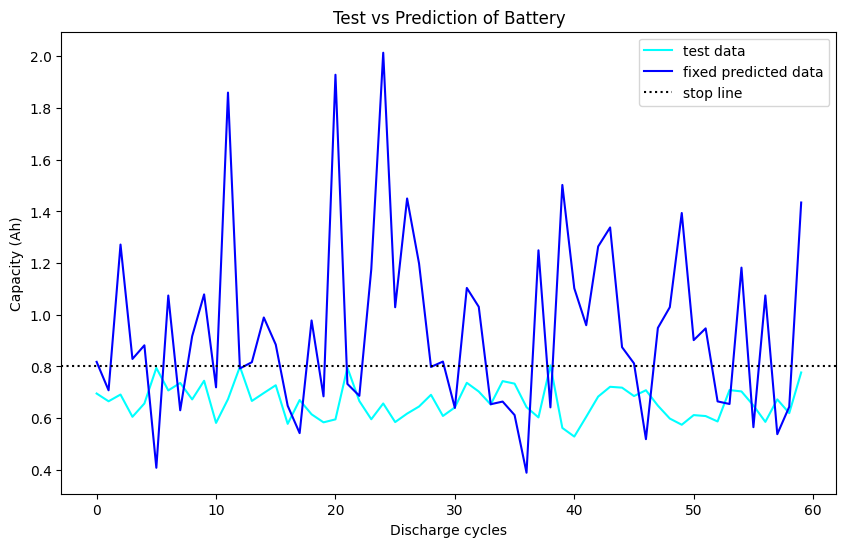

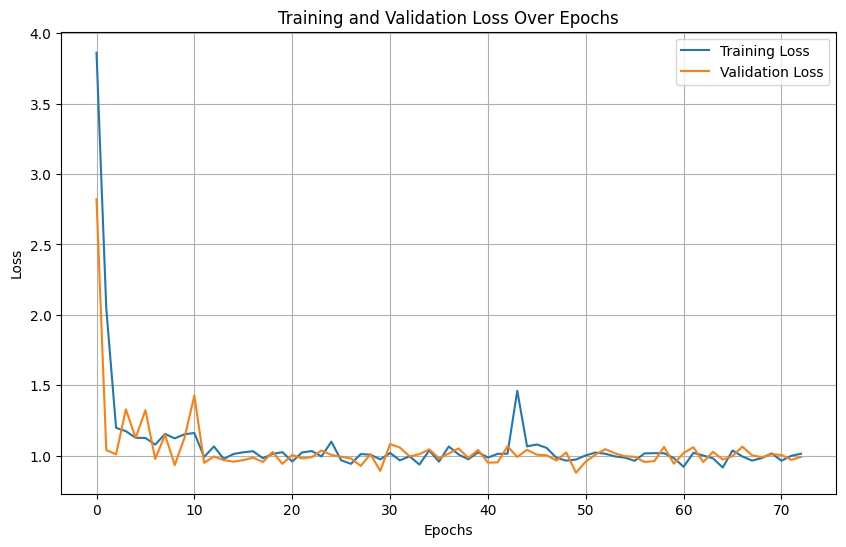

In [56]:
import optuna
def objective(trial):
    # Hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-8, 1e-2, log=True)
    accumulation_steps = trial.suggest_int('accumulation_steps', 1, 8)
    num_epochs = trial.suggest_int('epochs', 10, 100)
    # Load config
    config = yaml.safe_load(open('config/base.yaml', 'r'))
    config['train']['epochs'] = num_epochs
    config['train']['accumulation_steps'] = accumulation_steps
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TDSTF(config, device).to(device)
    train_loader = get_dataloader(train_batteries)
    valid_loader = get_dataloader([valid_battery])

    # Define optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    total_steps = len(train_loader) * num_epochs
    warmup_steps = total_steps // 10
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    model, train_loss, valid_loss = train(
        model, config, train_loader, valid_loader=valid_loader, foldername='', data_path=''
    )
    return min(valid_loss)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=5)  
print('Best hyperparameters: ', study.best_params)

# Train 
best_params = study.best_params
config = yaml.safe_load(open('config/base.yaml', 'r'))
config['train']['epochs'] = best_params['epochs']
config['train']['accumulation_steps'] = best_params['accumulation_steps']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modeloptuna = TDSTF(config, device).to(device)
train_loaderoptuna = get_dataloader(train_batteries)
valid_loaderoptuna = get_dataloader([valid_battery])
test_loaderoptuna = get_dataloader([test_battery])
optimizeroptuna = torch.optim.AdamW(modeloptuna.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
total_stepsoptuna = len(train_loaderoptuna) * best_params['epochs']
warmup_stepsoptuna = total_stepsoptuna // 10
scheduleroptuna = get_linear_schedule_with_warmup(optimizeroptuna, num_warmup_steps=warmup_stepsoptuna, num_training_steps=total_stepsoptuna)

modeloptuna, train_lossoptuna, valid_lossoptuna = train(
    modeloptuna, config, train_loaderoptuna, valid_loader=valid_loaderoptuna, foldername='', data_path=''
)
print('Test')
CRPSoptuna, MSEoptuna,lossoptuna,predictionsoptuna = evaluate(is_test=True, model=modeloptuna, data_loader=test_loaderoptuna, nsample=1000, foldername=foldername)

# Plot losses
plot_losses(train_lossoptuna, valid_lossoptuna, test_battery, title="Training and Validation Loss Over Epochs with Optuna Optimization")
# Save the final model
torch.save(modeloptuna.state_dict(), 'best_model.pth')


100%|██████████| 60/60 [00:00<00:00, 225.19it/s]
The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



********************Matrices*********************
Test Loss is: 0.9531182716290156
MSE is: 0.2756931185722351
CRPS is: 0.3573538336847518


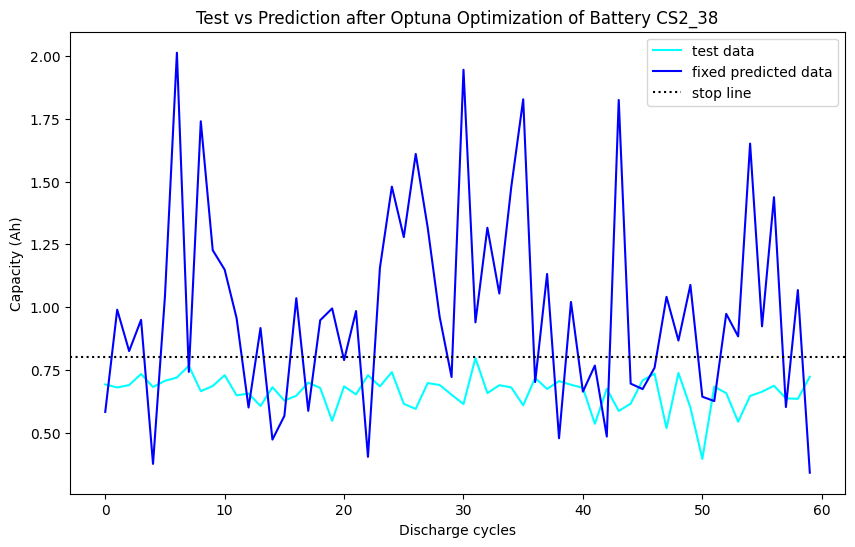

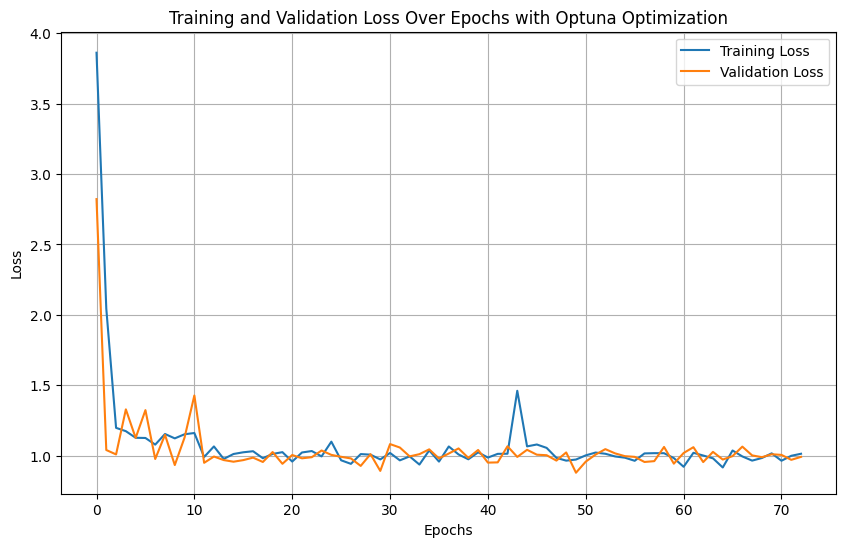

In [65]:
CRPSoptuna, MSEoptuna,lossoptuna,predictionsoptuna = evaluate(is_test=True, model=modeloptuna, data_loader=test_loaderoptuna, nsample=1000, foldername=foldername, title=f'Test vs Prediction after Optuna Optimization of Battery {test_battery}')

# Plot losses
plot_losses(train_lossoptuna, valid_lossoptuna, test_battery, title="Training and Validation Loss Over Epochs with Optuna Optimization")

In [72]:
best_params

{'lr': 0.005870626700351548,
 'weight_decay': 7.884039028360727e-08,
 'accumulation_steps': 1,
 'epochs': 73}

## **Ablation Studies**

Running baseline model...


Epoch 1/50:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 64.07it/s, loss=2.96]


Validation Loss: 1.445405300706625
Model saved with best validation loss: 1.445405300706625


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 64.80it/s, loss=2.6] 


Validation Loss: 1.2922154675636972
Model saved with best validation loss: 1.2922154675636972


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 64.57it/s, loss=1.24]


Validation Loss: 1.0538514501282148
Model saved with best validation loss: 1.0538514501282148


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=1.2] 


Validation Loss: 1.1868355508361543
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 64.95it/s, loss=1.06]


Validation Loss: 1.1300554919455732
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 65.73it/s, loss=1.33]


Validation Loss: 1.3474240233855588
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 64.37it/s, loss=1.1] 


Validation Loss: 1.0758513829537801
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 64.51it/s, loss=1.07]


Validation Loss: 1.0567147928689207
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 64.26it/s, loss=1.28]


Validation Loss: 1.2586241561387266
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 64.20it/s, loss=1.06]


Validation Loss: 1.0165877198534352
Model saved with best validation loss: 1.0165877198534352


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 64.40it/s, loss=1.13]


Validation Loss: 1.1784692374723298
No improvement count: 1


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 64.32it/s, loss=1.22]


Validation Loss: 1.1062152944505215
No improvement count: 2


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 64.43it/s, loss=1.1] 


Validation Loss: 1.4427099781376975
No improvement count: 3


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 59.56it/s, loss=1.14]


Validation Loss: 1.2407937193555492
No improvement count: 4


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 62.07it/s, loss=1.11]


Validation Loss: 1.0788131797952312
No improvement count: 5


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 62.14it/s, loss=1.11]


Validation Loss: 1.0309387929737568
No improvement count: 6


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 64.72it/s, loss=1.08]


Validation Loss: 1.0392279571720533
No improvement count: 7


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 64.09it/s, loss=1.09]


Validation Loss: 0.9702573237674577
Model saved with best validation loss: 0.9702573237674577


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 64.31it/s, loss=1.17]


Validation Loss: 1.173119423112699
No improvement count: 1


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 64.44it/s, loss=1.05]


Validation Loss: 1.0500631577202253
No improvement count: 2


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 64.39it/s, loss=1.06]


Validation Loss: 1.1450851032776492
No improvement count: 3


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 64.28it/s, loss=1.02]


Validation Loss: 1.0321131167667252
No improvement count: 4


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 64.78it/s, loss=1.02]


Validation Loss: 0.9272606383476939
Model saved with best validation loss: 0.9272606383476939


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 64.18it/s, loss=0.976]


Validation Loss: 0.9749614745378494
No improvement count: 1


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 63.92it/s, loss=1.02]


Validation Loss: 0.971822915332658
No improvement count: 2


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 64.50it/s, loss=0.982]


Validation Loss: 0.9081341251730919
Model saved with best validation loss: 0.9081341251730919


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 64.20it/s, loss=1.03]


Validation Loss: 0.991471893553223
No improvement count: 1


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 64.34it/s, loss=0.965]


Validation Loss: 1.0644231651510512
No improvement count: 2


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 64.23it/s, loss=1.05]


Validation Loss: 0.9357878390167441
No improvement count: 3


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 64.47it/s, loss=1]   


Validation Loss: 1.0822302943893842
No improvement count: 4


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 64.47it/s, loss=0.993]


Validation Loss: 0.973569176026753
No improvement count: 5


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 63.95it/s, loss=0.992]


Validation Loss: 0.9575777740350792
No improvement count: 6


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 63.78it/s, loss=1.01]


Validation Loss: 1.0140141711703368
No improvement count: 7


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 64.17it/s, loss=1.04]


Validation Loss: 1.0218454147023814
No improvement count: 8


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 63.92it/s, loss=0.984]


Validation Loss: 0.9606423431209156
No improvement count: 9


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 63.47it/s, loss=0.978]


Validation Loss: 0.9661692114812988
No improvement count: 10


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 63.99it/s, loss=1.01]


Validation Loss: 1.031309360904353
No improvement count: 11


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 64.33it/s, loss=0.961]


Validation Loss: 0.9945015087723732
No improvement count: 12


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 64.01it/s, loss=1.02]


Validation Loss: 1.000127890812499
No improvement count: 13


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 64.06it/s, loss=0.99] 


Validation Loss: 0.9478528121752399
No improvement count: 14


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 64.15it/s, loss=1.07]


Validation Loss: 1.0089378910405296
No improvement count: 15


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 63.87it/s, loss=0.928]


Validation Loss: 1.0138739618871893
No improvement count: 16


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 63.79it/s, loss=1.05]


Validation Loss: 1.3852209150791168
No improvement count: 17


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 63.64it/s, loss=1.06]


Validation Loss: 0.919418494616236
No improvement count: 18


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 65.26it/s, loss=1]   


Validation Loss: 0.9812298539493766
No improvement count: 19


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 64.71it/s, loss=0.959]


Validation Loss: 1.0347980154412133
No improvement count: 20


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 64.59it/s, loss=0.988]


Validation Loss: 0.9831078845475402
No improvement count: 21


Epoch 48/50: 100%|██████████| 110/110 [00:01<00:00, 64.73it/s, loss=0.932]


Validation Loss: 0.9715922405677182
No improvement count: 22


Epoch 49/50: 100%|██████████| 110/110 [00:01<00:00, 64.70it/s, loss=1.01]


Validation Loss: 1.0044063931064946
No improvement count: 23


Epoch 50/50: 100%|██████████| 110/110 [00:01<00:00, 64.66it/s, loss=0.946]


Validation Loss: 1.0097860901483469
No improvement count: 24
Ablation 1: Removing the Diffusion Embedding...


Epoch 1/50: 100%|██████████| 110/110 [00:01<00:00, 70.05it/s, loss=4.2] 


Validation Loss: 1.4981211721897125
Model saved with best validation loss: 1.4981211721897125


Epoch 2/50: 100%|██████████| 110/110 [00:01<00:00, 69.40it/s, loss=4.68]


Validation Loss: 0.9785212842481477
Model saved with best validation loss: 0.9785212842481477


Epoch 3/50: 100%|██████████| 110/110 [00:01<00:00, 69.35it/s, loss=1.37]


Validation Loss: 1.5301907126392638
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:01<00:00, 69.50it/s, loss=1.25]


Validation Loss: 1.0506070724555425
No improvement count: 2


Epoch 5/50: 100%|██████████| 110/110 [00:01<00:00, 68.76it/s, loss=1.17]


Validation Loss: 1.202348111995629
No improvement count: 3


Epoch 6/50: 100%|██████████| 110/110 [00:01<00:00, 69.44it/s, loss=1.22]


Validation Loss: 1.2935268740568842
No improvement count: 4


Epoch 7/50: 100%|██████████| 110/110 [00:01<00:00, 69.69it/s, loss=1.23]


Validation Loss: 1.113166983638491
No improvement count: 5


Epoch 8/50: 100%|██████████| 110/110 [00:01<00:00, 68.66it/s, loss=1.35]


Validation Loss: 1.317244348249265
No improvement count: 6


Epoch 9/50: 100%|██████████| 110/110 [00:01<00:00, 69.61it/s, loss=1.21]


Validation Loss: 2.0275601744651794
No improvement count: 7


Epoch 10/50: 100%|██████████| 110/110 [00:01<00:00, 69.17it/s, loss=1.21]


Validation Loss: 1.0895467496344022
No improvement count: 8


Epoch 11/50: 100%|██████████| 110/110 [00:01<00:00, 68.45it/s, loss=1.24]


Validation Loss: 1.095106100929635
No improvement count: 9


Epoch 12/50: 100%|██████████| 110/110 [00:01<00:00, 69.16it/s, loss=1.12]


Validation Loss: 1.019344003604991
No improvement count: 10


Epoch 13/50: 100%|██████████| 110/110 [00:01<00:00, 69.31it/s, loss=1.15]


Validation Loss: 1.0776982781078135
No improvement count: 11


Epoch 14/50: 100%|██████████| 110/110 [00:01<00:00, 69.27it/s, loss=1.06]


Validation Loss: 1.0446439981460571
No improvement count: 12


Epoch 15/50: 100%|██████████| 110/110 [00:01<00:00, 69.17it/s, loss=1.07]


Validation Loss: 1.046564671610083
No improvement count: 13


Epoch 16/50: 100%|██████████| 110/110 [00:01<00:00, 69.21it/s, loss=1.11]


Validation Loss: 1.2970095021384103
No improvement count: 14


Epoch 17/50: 100%|██████████| 110/110 [00:01<00:00, 68.96it/s, loss=1.06]


Validation Loss: 0.9070246373968465
Model saved with best validation loss: 0.9070246373968465


Epoch 18/50: 100%|██████████| 110/110 [00:01<00:00, 69.14it/s, loss=1.06]


Validation Loss: 1.2918075291173798
No improvement count: 1


Epoch 19/50: 100%|██████████| 110/110 [00:01<00:00, 69.94it/s, loss=1.09]


Validation Loss: 1.006377580442599
No improvement count: 2


Epoch 20/50: 100%|██████████| 110/110 [00:01<00:00, 69.93it/s, loss=0.986]


Validation Loss: 1.0237340410905225
No improvement count: 3


Epoch 21/50: 100%|██████████| 110/110 [00:01<00:00, 68.81it/s, loss=1.07]


Validation Loss: 1.0679831797523158
No improvement count: 4


Epoch 22/50: 100%|██████████| 110/110 [00:01<00:00, 69.49it/s, loss=1.08]


Validation Loss: 0.986734328525407
No improvement count: 5


Epoch 23/50: 100%|██████████| 110/110 [00:01<00:00, 69.25it/s, loss=0.975]


Validation Loss: 1.0541844463774137
No improvement count: 6


Epoch 24/50: 100%|██████████| 110/110 [00:01<00:00, 69.45it/s, loss=1.06]


Validation Loss: 1.1049519489918436
No improvement count: 7


Epoch 25/50: 100%|██████████| 110/110 [00:01<00:00, 69.20it/s, loss=1.05]


Validation Loss: 1.2373405790754728
No improvement count: 8


Epoch 26/50: 100%|██████████| 110/110 [00:01<00:00, 69.41it/s, loss=1.07]


Validation Loss: 0.9670955948531628
No improvement count: 9


Epoch 27/50: 100%|██████████| 110/110 [00:01<00:00, 69.06it/s, loss=1.05]


Validation Loss: 1.0022302413625377
No improvement count: 10


Epoch 28/50: 100%|██████████| 110/110 [00:01<00:00, 68.99it/s, loss=1.04]


Validation Loss: 1.0674934461712837
No improvement count: 11


Epoch 29/50: 100%|██████████| 110/110 [00:01<00:00, 69.10it/s, loss=1.09]


Validation Loss: 1.0394345793340887
No improvement count: 12


Epoch 30/50: 100%|██████████| 110/110 [00:01<00:00, 68.97it/s, loss=1.04]


Validation Loss: 1.0326780038220542
No improvement count: 13


Epoch 31/50: 100%|██████████| 110/110 [00:01<00:00, 69.31it/s, loss=1.06]


Validation Loss: 0.9533333741128445
No improvement count: 14


Epoch 32/50: 100%|██████████| 110/110 [00:01<00:00, 68.83it/s, loss=1.04]


Validation Loss: 0.9538212423878056
No improvement count: 15


Epoch 33/50: 100%|██████████| 110/110 [00:01<00:00, 69.24it/s, loss=1.01]


Validation Loss: 0.9844420892851693
No improvement count: 16


Epoch 34/50: 100%|██████████| 110/110 [00:01<00:00, 69.17it/s, loss=1.01]


Validation Loss: 1.0700827091932297
No improvement count: 17


Epoch 35/50: 100%|██████████| 110/110 [00:01<00:00, 69.36it/s, loss=1.03]


Validation Loss: 0.9829983934760094
No improvement count: 18


Epoch 36/50: 100%|██████████| 110/110 [00:01<00:00, 69.26it/s, loss=1.05]


Validation Loss: 1.0805363314492362
No improvement count: 19


Epoch 37/50: 100%|██████████| 110/110 [00:01<00:00, 69.25it/s, loss=0.977]


Validation Loss: 1.0866042152047157
No improvement count: 20


Epoch 38/50: 100%|██████████| 110/110 [00:01<00:00, 69.22it/s, loss=0.943]


Validation Loss: 1.0200380039002215
No improvement count: 21


Epoch 39/50: 100%|██████████| 110/110 [00:01<00:00, 69.26it/s, loss=1.01]


Validation Loss: 0.9387717662113053
No improvement count: 22


Epoch 40/50: 100%|██████████| 110/110 [00:01<00:00, 69.18it/s, loss=0.99] 


Validation Loss: 1.0256243800478322
No improvement count: 23


Epoch 41/50: 100%|██████████| 110/110 [00:01<00:00, 68.93it/s, loss=0.96] 


Validation Loss: 1.0438679855849062
No improvement count: 24


Epoch 42/50: 100%|██████████| 110/110 [00:01<00:00, 69.09it/s, loss=0.982]


Validation Loss: 1.045036902917283
No improvement count: 25


Epoch 43/50: 100%|██████████| 110/110 [00:01<00:00, 69.17it/s, loss=0.96] 


Validation Loss: 0.9743526120271001
No improvement count: 26


Epoch 44/50: 100%|██████████| 110/110 [00:01<00:00, 69.64it/s, loss=0.992]


Validation Loss: 1.0898045673966408
No improvement count: 27


Epoch 45/50: 100%|██████████| 110/110 [00:01<00:00, 69.64it/s, loss=1.06]


Validation Loss: 1.0029079876840115
No improvement count: 28


Epoch 46/50: 100%|██████████| 110/110 [00:01<00:00, 69.69it/s, loss=0.994]


Validation Loss: 0.9127003992242473
No improvement count: 29


Epoch 47/50: 100%|██████████| 110/110 [00:01<00:00, 69.11it/s, loss=0.959]


Validation Loss: 1.0132244740213667
No improvement count: 30
Early stopping triggered.


100%|██████████| 60/60 [00:00<00:00, 271.48it/s]
The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



********************Matrices*********************
Test Loss is: 0.9720311803122361
MSE is: 0.48672109842300415
CRPS is: 0.4545497408424302


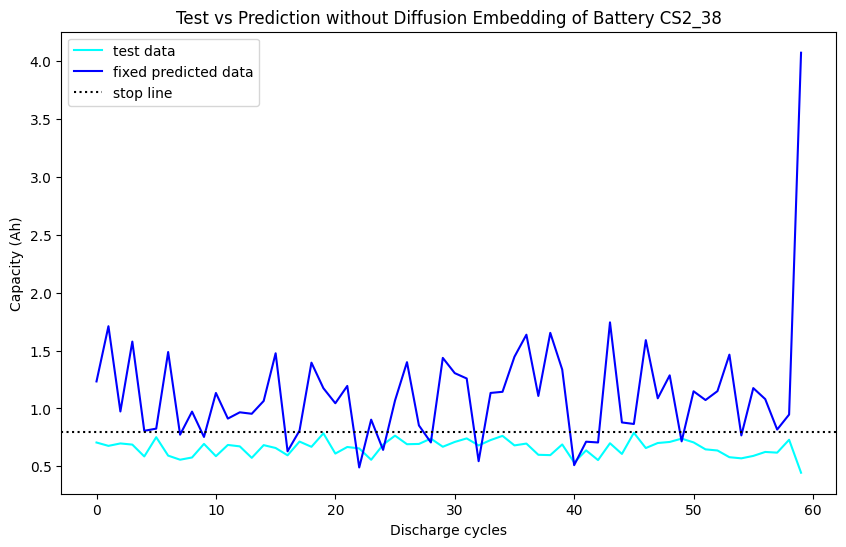

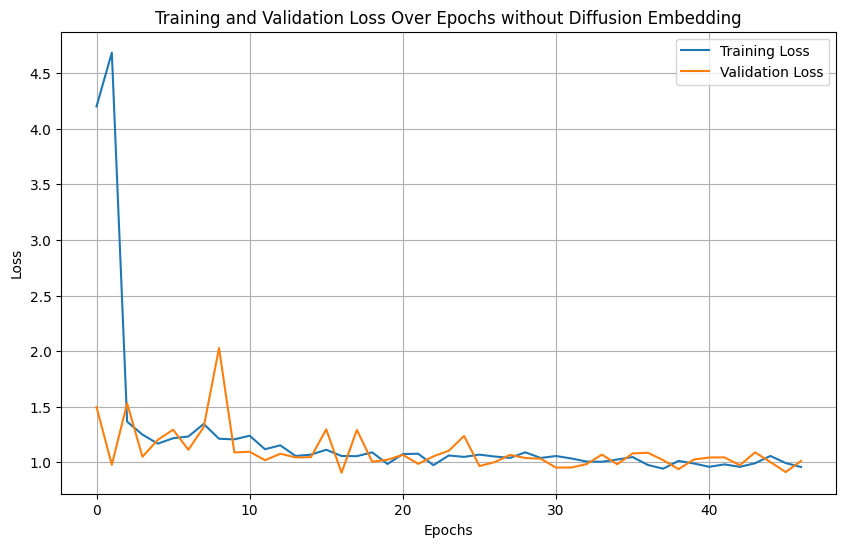

Ablation 2: Reducing the Number of Transformer Layers to 1


Epoch 1/50: 100%|██████████| 110/110 [00:00<00:00, 125.38it/s, loss=1.57]


Validation Loss: 1.3803001285663672
Model saved with best validation loss: 1.3803001285663672


Epoch 2/50: 100%|██████████| 110/110 [00:00<00:00, 121.57it/s, loss=1.13]


Validation Loss: 1.0777817288679736
Model saved with best validation loss: 1.0777817288679736


Epoch 3/50: 100%|██████████| 110/110 [00:00<00:00, 120.41it/s, loss=1.02]


Validation Loss: 1.0564679301210813
Model saved with best validation loss: 1.0564679301210813


Epoch 4/50: 100%|██████████| 110/110 [00:00<00:00, 120.52it/s, loss=0.963]


Validation Loss: 1.0196516231766768
Model saved with best validation loss: 1.0196516231766768


Epoch 5/50: 100%|██████████| 110/110 [00:00<00:00, 119.78it/s, loss=1.05]


Validation Loss: 1.1343140708548682
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:00<00:00, 120.35it/s, loss=1.1] 


Validation Loss: 0.9903975624058928
Model saved with best validation loss: 0.9903975624058928


Epoch 7/50: 100%|██████████| 110/110 [00:00<00:00, 119.24it/s, loss=1.1] 


Validation Loss: 1.1056469827890396
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:00<00:00, 119.93it/s, loss=1.09]


Validation Loss: 0.9845944568514824
Model saved with best validation loss: 0.9845944568514824


Epoch 9/50: 100%|██████████| 110/110 [00:00<00:00, 120.22it/s, loss=1.05]


Validation Loss: 1.03032209617751
No improvement count: 1


Epoch 10/50: 100%|██████████| 110/110 [00:00<00:00, 120.12it/s, loss=1.12]


Validation Loss: 1.2590849894498075
No improvement count: 2


Epoch 11/50: 100%|██████████| 110/110 [00:00<00:00, 120.48it/s, loss=1.4] 


Validation Loss: 1.0833077020943165
No improvement count: 3


Epoch 12/50: 100%|██████████| 110/110 [00:00<00:00, 120.40it/s, loss=1.06]


Validation Loss: 1.3490021670503276
No improvement count: 4


Epoch 13/50: 100%|██████████| 110/110 [00:00<00:00, 120.84it/s, loss=1.1] 


Validation Loss: 1.0067082435957022
No improvement count: 5


Epoch 14/50: 100%|██████████| 110/110 [00:00<00:00, 121.06it/s, loss=1.04]


Validation Loss: 1.1156432846827167
No improvement count: 6


Epoch 15/50: 100%|██████████| 110/110 [00:00<00:00, 120.26it/s, loss=1.15]


Validation Loss: 1.1545115177120482
No improvement count: 7


Epoch 16/50: 100%|██████████| 110/110 [00:00<00:00, 120.94it/s, loss=1.03]


Validation Loss: 1.1269944890269212
No improvement count: 8


Epoch 17/50: 100%|██████████| 110/110 [00:00<00:00, 125.27it/s, loss=0.997]


Validation Loss: 1.1251632480749063
No improvement count: 9


Epoch 18/50: 100%|██████████| 110/110 [00:00<00:00, 119.44it/s, loss=1.13]


Validation Loss: 1.0217683437679494
No improvement count: 10


Epoch 19/50: 100%|██████████| 110/110 [00:00<00:00, 120.16it/s, loss=1.13]


Validation Loss: 0.9870621210762432
No improvement count: 11


Epoch 20/50: 100%|██████████| 110/110 [00:00<00:00, 120.94it/s, loss=1.12]


Validation Loss: 1.1930393161518233
No improvement count: 12


Epoch 21/50: 100%|██████████| 110/110 [00:00<00:00, 120.47it/s, loss=1.1] 


Validation Loss: 1.1890989893249102
No improvement count: 13


Epoch 22/50: 100%|██████████| 110/110 [00:00<00:00, 120.90it/s, loss=1.04]


Validation Loss: 1.0661459293748652
No improvement count: 14


Epoch 23/50: 100%|██████████| 110/110 [00:00<00:00, 119.74it/s, loss=1.1] 


Validation Loss: 1.1741970724293165
No improvement count: 15


Epoch 24/50: 100%|██████████| 110/110 [00:00<00:00, 119.66it/s, loss=1.21]


Validation Loss: 1.093282060963767
No improvement count: 16


Epoch 25/50: 100%|██████████| 110/110 [00:00<00:00, 120.47it/s, loss=1.08]


Validation Loss: 1.0719444645302636
No improvement count: 17


Epoch 26/50: 100%|██████████| 110/110 [00:00<00:00, 118.28it/s, loss=1.15]


Validation Loss: 0.9497885044131961
Model saved with best validation loss: 0.9497885044131961


Epoch 27/50: 100%|██████████| 110/110 [00:00<00:00, 120.86it/s, loss=1.04]


Validation Loss: 1.0333997894610678
No improvement count: 1


Epoch 28/50: 100%|██████████| 110/110 [00:00<00:00, 119.01it/s, loss=1.02]


Validation Loss: 1.0035596473940782
No improvement count: 2


Epoch 29/50: 100%|██████████| 110/110 [00:00<00:00, 118.91it/s, loss=1.03]


Validation Loss: 1.098005278834275
No improvement count: 3


Epoch 30/50: 100%|██████████| 110/110 [00:00<00:00, 120.01it/s, loss=0.941]


Validation Loss: 0.9479517415165901
Model saved with best validation loss: 0.9479517415165901


Epoch 31/50: 100%|██████████| 110/110 [00:00<00:00, 119.63it/s, loss=0.967]


Validation Loss: 0.9308914435761315
Model saved with best validation loss: 0.9308914435761315


Epoch 32/50: 100%|██████████| 110/110 [00:00<00:00, 119.71it/s, loss=1.01]


Validation Loss: 1.0958370555724417
No improvement count: 1


Epoch 33/50: 100%|██████████| 110/110 [00:00<00:00, 120.36it/s, loss=0.971]


Validation Loss: 0.9524494005101067
No improvement count: 2


Epoch 34/50: 100%|██████████| 110/110 [00:00<00:00, 118.94it/s, loss=0.99] 


Validation Loss: 0.947769289038011
No improvement count: 3


Epoch 35/50: 100%|██████████| 110/110 [00:00<00:00, 120.54it/s, loss=0.995]


Validation Loss: 1.2470233903399535
No improvement count: 4


Epoch 36/50: 100%|██████████| 110/110 [00:00<00:00, 119.47it/s, loss=1.03]


Validation Loss: 1.0970480026943343
No improvement count: 5


Epoch 37/50: 100%|██████████| 110/110 [00:00<00:00, 119.21it/s, loss=1.02]


Validation Loss: 1.0156472575451647
No improvement count: 6


Epoch 38/50: 100%|██████████| 110/110 [00:00<00:00, 119.57it/s, loss=1.01] 


Validation Loss: 1.0226876219468457
No improvement count: 7


Epoch 39/50: 100%|██████████| 110/110 [00:00<00:00, 120.24it/s, loss=1.02]


Validation Loss: 1.0616061368158884
No improvement count: 8


Epoch 40/50: 100%|██████████| 110/110 [00:00<00:00, 119.41it/s, loss=0.953]


Validation Loss: 1.0117983897881848
No improvement count: 9


Epoch 41/50: 100%|██████████| 110/110 [00:00<00:00, 119.42it/s, loss=1.02]


Validation Loss: 0.9990317092410156
No improvement count: 10


Epoch 42/50: 100%|██████████| 110/110 [00:00<00:00, 120.15it/s, loss=1.01]


Validation Loss: 1.0365165679582529
No improvement count: 11


Epoch 43/50: 100%|██████████| 110/110 [00:00<00:00, 119.55it/s, loss=0.936]


Validation Loss: 0.9481972509196827
No improvement count: 12


Epoch 44/50: 100%|██████████| 110/110 [00:00<00:00, 119.33it/s, loss=0.961]


Validation Loss: 0.9611919053963253
No improvement count: 13


Epoch 45/50: 100%|██████████| 110/110 [00:00<00:00, 120.42it/s, loss=0.992]


Validation Loss: 0.9562787844666413
No improvement count: 14


Epoch 46/50: 100%|██████████| 110/110 [00:00<00:00, 119.81it/s, loss=0.993]


Validation Loss: 0.9522010476461479
No improvement count: 15


Epoch 47/50: 100%|██████████| 110/110 [00:00<00:00, 120.91it/s, loss=1]    


Validation Loss: 0.971906521490642
No improvement count: 16


Epoch 48/50: 100%|██████████| 110/110 [00:00<00:00, 120.55it/s, loss=1.03]


Validation Loss: 0.9652288329920599
No improvement count: 17


Epoch 49/50: 100%|██████████| 110/110 [00:00<00:00, 119.85it/s, loss=1.01]


Validation Loss: 1.0733931932066167
No improvement count: 18


Epoch 50/50: 100%|██████████| 110/110 [00:00<00:00, 120.06it/s, loss=1.01]


Validation Loss: 0.991579889186791
No improvement count: 19


100%|██████████| 60/60 [00:00<00:00, 392.54it/s]



********************Matrices*********************
Test Loss is: 1.0032007974882922
MSE is: 0.35923078656196594
CRPS is: 0.37416156769551223


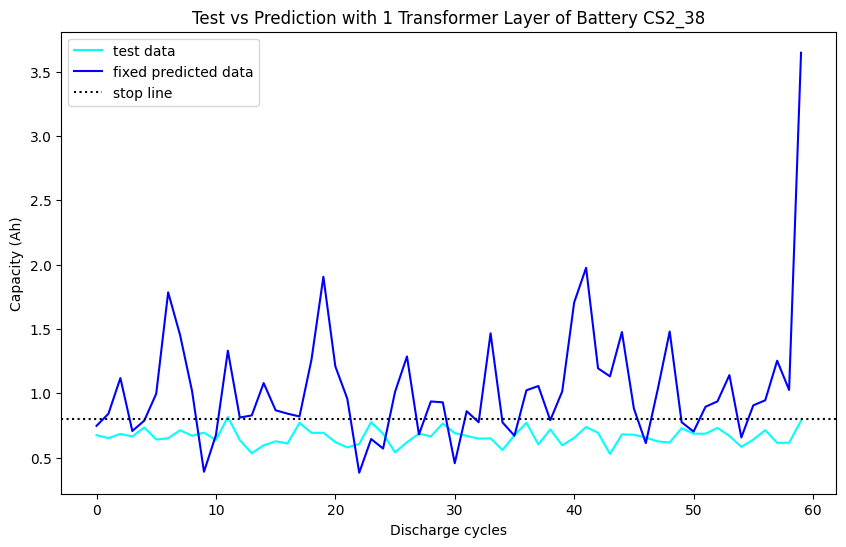

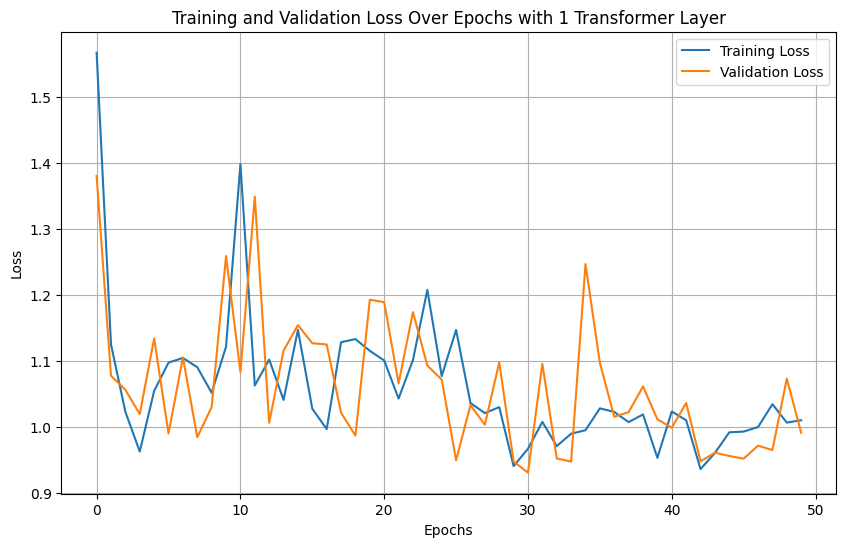

Ablation 3: Increasing the Number of Transformer Layers to 6


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 41.43it/s, loss=9.97]


Validation Loss: 3.564177902681487
Model saved with best validation loss: 3.564177902681487


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=8.82]


Validation Loss: 2.059396524514471
Model saved with best validation loss: 2.059396524514471


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 41.05it/s, loss=1.96]


Validation Loss: 2.7571652169738496
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.30it/s, loss=1.54]


Validation Loss: 1.5502448305487633
Model saved with best validation loss: 1.5502448305487633


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 41.10it/s, loss=1.39]


Validation Loss: 1.1236802786588669
Model saved with best validation loss: 1.1236802786588669


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.03it/s, loss=1.22]


Validation Loss: 1.2047029244048255
No improvement count: 1


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 41.08it/s, loss=1.43]


Validation Loss: 0.968217669320958
Model saved with best validation loss: 0.968217669320958


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 41.06it/s, loss=1.55]


Validation Loss: 1.421515823474952
No improvement count: 1


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 41.21it/s, loss=1.25]


Validation Loss: 1.0187507245157446
No improvement count: 2


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=1.34]


Validation Loss: 1.4487049377390318
No improvement count: 3


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 41.14it/s, loss=1.14]


Validation Loss: 1.1150594364319528
No improvement count: 4


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 41.13it/s, loss=1.18]


Validation Loss: 0.9458519598203046
Model saved with best validation loss: 0.9458519598203046


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 40.90it/s, loss=1.18]


Validation Loss: 1.0757135865943772
No improvement count: 1


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 41.17it/s, loss=1.24]


Validation Loss: 2.8400790797812596
No improvement count: 2


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 41.33it/s, loss=1.46]


Validation Loss: 1.7805926821061544
No improvement count: 3


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 41.06it/s, loss=1.3] 


Validation Loss: 0.980420822011573
No improvement count: 4


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=1.05]


Validation Loss: 0.9737048463097641
No improvement count: 5


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 41.18it/s, loss=1.18]


Validation Loss: 1.7457159076418196
No improvement count: 6


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 41.02it/s, loss=1.28]


Validation Loss: 1.286267675459385
No improvement count: 7


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 41.22it/s, loss=1.12]


Validation Loss: 1.0531428344547749
No improvement count: 8


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 41.01it/s, loss=1.12]


Validation Loss: 1.146187951522214
No improvement count: 9


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 40.95it/s, loss=1.14]


Validation Loss: 0.9866370031876224
No improvement count: 10


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 40.99it/s, loss=1.07]


Validation Loss: 0.9978276320866176
No improvement count: 11


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 40.99it/s, loss=1.16]


Validation Loss: 1.5605601529989923
No improvement count: 12


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 40.97it/s, loss=1.11]


Validation Loss: 1.0960678064397402
No improvement count: 13


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 40.12it/s, loss=1.07]


Validation Loss: 1.3162271976470947
No improvement count: 14


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 40.51it/s, loss=1.13]


Validation Loss: 1.08103441500238
No improvement count: 15


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 40.60it/s, loss=1.01]


Validation Loss: 0.9956381752022675
No improvement count: 16


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 40.95it/s, loss=1.05]


Validation Loss: 1.041593141321625
No improvement count: 17


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 40.64it/s, loss=1.21]


Validation Loss: 1.1984081268310547
No improvement count: 18


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 40.85it/s, loss=1.1] 


Validation Loss: 1.6030127533844538
No improvement count: 19


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 40.94it/s, loss=1.17]


Validation Loss: 1.31175227782556
No improvement count: 20


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.47it/s, loss=1.06]


Validation Loss: 1.0748873076268606
No improvement count: 21


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 40.94it/s, loss=1.09]


Validation Loss: 0.9694731906056404
No improvement count: 22


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 40.69it/s, loss=1.07]


Validation Loss: 1.1307226531207561
No improvement count: 23


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 40.56it/s, loss=0.992]


Validation Loss: 1.133790373802185
No improvement count: 24


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 40.87it/s, loss=1.08]


Validation Loss: 1.0116979320134436
No improvement count: 25


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 41.11it/s, loss=1.02]


Validation Loss: 1.0693069297288145
No improvement count: 26


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 40.99it/s, loss=1.12]


Validation Loss: 1.1387623995542526
No improvement count: 27


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 40.85it/s, loss=0.995]


Validation Loss: 1.0140469931066036
No improvement count: 28


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 41.10it/s, loss=1.06]


Validation Loss: 1.0702932982572488
No improvement count: 29


Epoch 42/50: 100%|██████████| 110/110 [00:04<00:00, 26.25it/s, loss=1.03]


Validation Loss: 1.0268010723271541
No improvement count: 30
Early stopping triggered.


100%|██████████| 60/60 [00:00<00:00, 75.74it/s]



********************Matrices*********************
Test Loss is: 1.021813373019298
MSE is: 0.2732140123844147
CRPS is: 0.38305673140069896


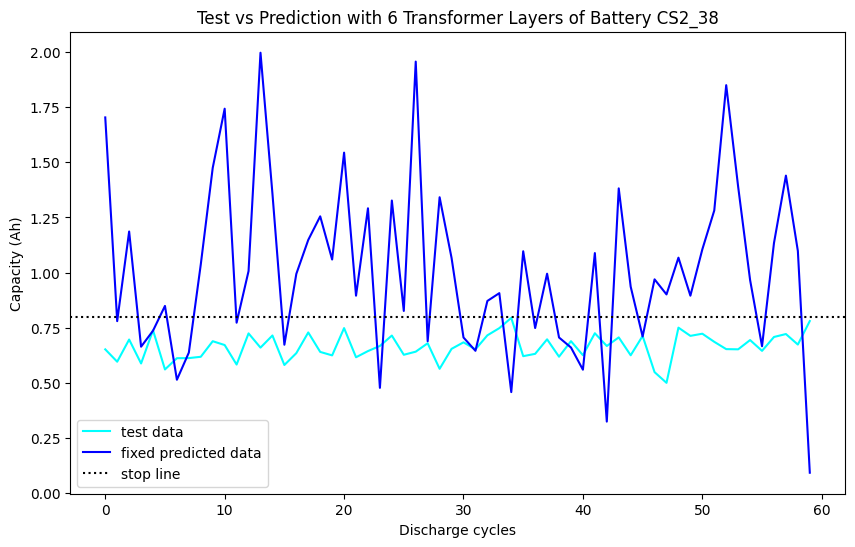

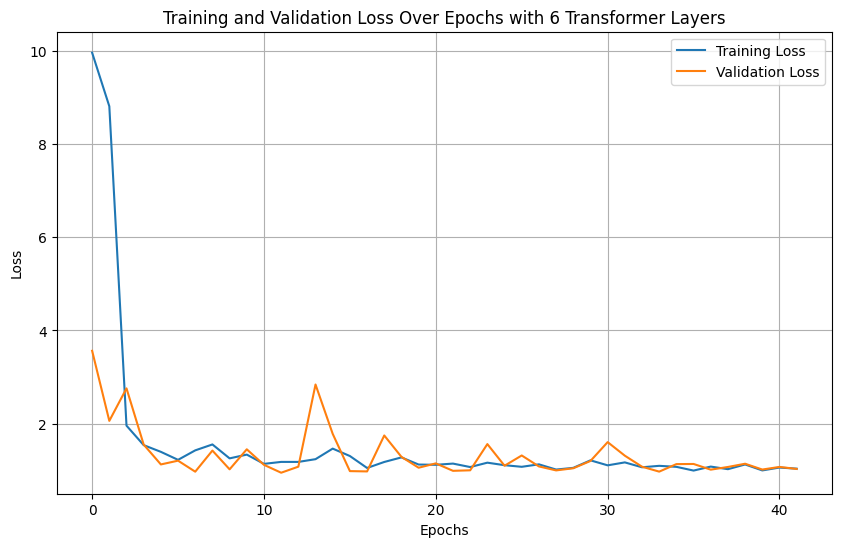

Ablation 4: Reducing the Number of Attention Heads to 2...


Epoch 1/50: 100%|██████████| 110/110 [00:04<00:00, 23.82it/s, loss=5.17]


Validation Loss: 1.235529586672783
Model saved with best validation loss: 1.235529586672783


Epoch 2/50: 100%|██████████| 110/110 [00:04<00:00, 24.96it/s, loss=3.07]


Validation Loss: 1.6647305116057396
No improvement count: 1


Epoch 3/50: 100%|██████████| 110/110 [00:04<00:00, 25.13it/s, loss=1.47]


Validation Loss: 1.0623952741069453
Model saved with best validation loss: 1.0623952741069453


Epoch 4/50: 100%|██████████| 110/110 [00:04<00:00, 25.05it/s, loss=1.15]


Validation Loss: 1.1440811125295502
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:04<00:00, 24.83it/s, loss=1.19]


Validation Loss: 1.017456950885909
Model saved with best validation loss: 1.017456950885909


Epoch 6/50: 100%|██████████| 110/110 [00:04<00:00, 25.60it/s, loss=1.1] 


Validation Loss: 0.9809296546237809
Model saved with best validation loss: 0.9809296546237809


Epoch 7/50: 100%|██████████| 110/110 [00:04<00:00, 26.05it/s, loss=1.05]


Validation Loss: 1.3207984454929829
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:04<00:00, 25.66it/s, loss=1.12]


Validation Loss: 1.1723799221217632
No improvement count: 2


Epoch 9/50: 100%|██████████| 110/110 [00:04<00:00, 23.83it/s, loss=1.37]


Validation Loss: 1.567610620387963
No improvement count: 3


Epoch 10/50: 100%|██████████| 110/110 [00:04<00:00, 24.01it/s, loss=1.16]


Validation Loss: 1.1229259419654096
No improvement count: 4


Epoch 11/50: 100%|██████████| 110/110 [00:04<00:00, 23.67it/s, loss=1.39]


Validation Loss: 1.0600086216415678
No improvement count: 5


Epoch 12/50: 100%|██████████| 110/110 [00:04<00:00, 23.93it/s, loss=1.05]


Validation Loss: 1.1371340900659561
No improvement count: 6


Epoch 13/50: 100%|██████████| 110/110 [00:04<00:00, 23.90it/s, loss=1.22]


Validation Loss: 1.0745911630136626
No improvement count: 7


Epoch 14/50: 100%|██████████| 110/110 [00:04<00:00, 23.78it/s, loss=1.25]


Validation Loss: 0.9814319312572479
No improvement count: 8


Epoch 15/50: 100%|██████████| 110/110 [00:04<00:00, 23.83it/s, loss=1.18]


Validation Loss: 1.1844303544078554
No improvement count: 9


Epoch 16/50: 100%|██████████| 110/110 [00:04<00:00, 24.15it/s, loss=1.15]


Validation Loss: 0.9734318612941674
Model saved with best validation loss: 0.9734318612941674


Epoch 17/50: 100%|██████████| 110/110 [00:04<00:00, 23.78it/s, loss=1.14]


Validation Loss: 1.11331305918949
No improvement count: 1


Epoch 18/50: 100%|██████████| 110/110 [00:04<00:00, 23.69it/s, loss=1.07]


Validation Loss: 1.084435686469078
No improvement count: 2


Epoch 19/50: 100%|██████████| 110/110 [00:04<00:00, 23.82it/s, loss=1.09]


Validation Loss: 0.9785099865070411
No improvement count: 3


Epoch 20/50: 100%|██████████| 110/110 [00:04<00:00, 23.57it/s, loss=1.34]


Validation Loss: 1.0228603959881835
No improvement count: 4


Epoch 21/50: 100%|██████████| 110/110 [00:04<00:00, 23.52it/s, loss=1.12]


Validation Loss: 1.4501607439347677
No improvement count: 5


Epoch 22/50: 100%|██████████| 110/110 [00:04<00:00, 23.82it/s, loss=1.03]


Validation Loss: 0.9351101006780352
Model saved with best validation loss: 0.9351101006780352


Epoch 23/50: 100%|██████████| 110/110 [00:04<00:00, 23.84it/s, loss=1.01]


Validation Loss: 1.0369317622057028
No improvement count: 1


Epoch 24/50: 100%|██████████| 110/110 [00:04<00:00, 23.46it/s, loss=1.04]


Validation Loss: 1.1241568390812193
No improvement count: 2


Epoch 25/50: 100%|██████████| 110/110 [00:04<00:00, 23.62it/s, loss=1.02]


Validation Loss: 1.03789322078228
No improvement count: 3


Epoch 26/50: 100%|██████████| 110/110 [00:04<00:00, 23.43it/s, loss=1.02]


Validation Loss: 0.9578879794904164
No improvement count: 4


Epoch 27/50: 100%|██████████| 110/110 [00:04<00:00, 23.67it/s, loss=1]    


Validation Loss: 0.9628353773483208
No improvement count: 5


Epoch 28/50: 100%|██████████| 110/110 [00:04<00:00, 24.09it/s, loss=1.01]


Validation Loss: 0.9210711041731494
Model saved with best validation loss: 0.9210711041731494


Epoch 29/50: 100%|██████████| 110/110 [00:04<00:00, 23.52it/s, loss=1.02]


Validation Loss: 0.9026098730308669
Model saved with best validation loss: 0.9026098730308669


Epoch 30/50: 100%|██████████| 110/110 [00:04<00:00, 23.40it/s, loss=1]    


Validation Loss: 0.9890932041619506
No improvement count: 1


Epoch 31/50: 100%|██████████| 110/110 [00:04<00:00, 23.15it/s, loss=1.01]


Validation Loss: 1.0738880905721868
No improvement count: 2


Epoch 32/50: 100%|██████████| 110/110 [00:04<00:00, 23.21it/s, loss=1.01]


Validation Loss: 1.1102099397352763
No improvement count: 3


Epoch 33/50: 100%|██████████| 110/110 [00:04<00:00, 23.32it/s, loss=1.02]


Validation Loss: 0.9781132308500153
No improvement count: 4


Epoch 34/50: 100%|██████████| 110/110 [00:04<00:00, 23.28it/s, loss=1.08]


Validation Loss: 0.9660935268870422
No improvement count: 5


Epoch 35/50: 100%|██████████| 110/110 [00:04<00:00, 23.63it/s, loss=0.966]


Validation Loss: 0.9862048290669918
No improvement count: 6


Epoch 36/50: 100%|██████████| 110/110 [00:04<00:00, 23.42it/s, loss=1.07]


Validation Loss: 1.067849897380386
No improvement count: 7


Epoch 37/50: 100%|██████████| 110/110 [00:04<00:00, 23.16it/s, loss=2.23]


Validation Loss: 1.1427216253110342
No improvement count: 8


Epoch 38/50: 100%|██████████| 110/110 [00:04<00:00, 23.24it/s, loss=1]    


Validation Loss: 0.9408564317439284
No improvement count: 9


Epoch 39/50: 100%|██████████| 110/110 [00:04<00:00, 23.31it/s, loss=0.981]


Validation Loss: 0.9329331016966275
No improvement count: 10


Epoch 40/50: 100%|██████████| 110/110 [00:04<00:00, 23.96it/s, loss=1.02]


Validation Loss: 1.0763373875192233
No improvement count: 11


Epoch 41/50: 100%|██████████| 110/110 [00:04<00:00, 23.99it/s, loss=0.97] 


Validation Loss: 0.9211652598210743
No improvement count: 12


Epoch 42/50: 100%|██████████| 110/110 [00:04<00:00, 23.90it/s, loss=0.995]


Validation Loss: 0.9456957049135651
No improvement count: 13


Epoch 43/50: 100%|██████████| 110/110 [00:04<00:00, 23.88it/s, loss=0.979]


Validation Loss: 1.0121180936694145
No improvement count: 14


Epoch 44/50: 100%|██████████| 110/110 [00:04<00:00, 24.13it/s, loss=0.96] 


Validation Loss: 1.0052414068153925
No improvement count: 15


Epoch 45/50: 100%|██████████| 110/110 [00:04<00:00, 23.97it/s, loss=0.982]


Validation Loss: 1.0932048090866633
No improvement count: 16


Epoch 46/50: 100%|██████████| 110/110 [00:04<00:00, 24.90it/s, loss=1.06]


Validation Loss: 1.020001623247351
No improvement count: 17


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 40.01it/s, loss=0.991]


Validation Loss: 0.9678803038384233
No improvement count: 18


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 39.83it/s, loss=0.942]


Validation Loss: 1.0553390426295144
No improvement count: 19


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.70it/s, loss=0.996]


Validation Loss: 0.9604994420494352
No improvement count: 20


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 41.26it/s, loss=1.01]


Validation Loss: 0.9993987051503999
No improvement count: 21


100%|██████████| 60/60 [00:00<00:00, 160.98it/s]



********************Matrices*********************
Test Loss is: 1.0004077864189942
MSE is: 0.1924574226140976
CRPS is: 0.30926414196874347


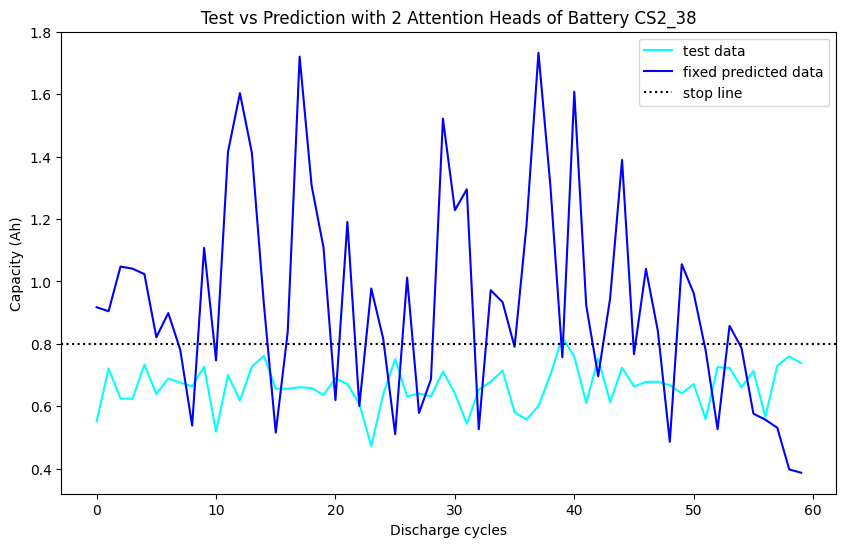

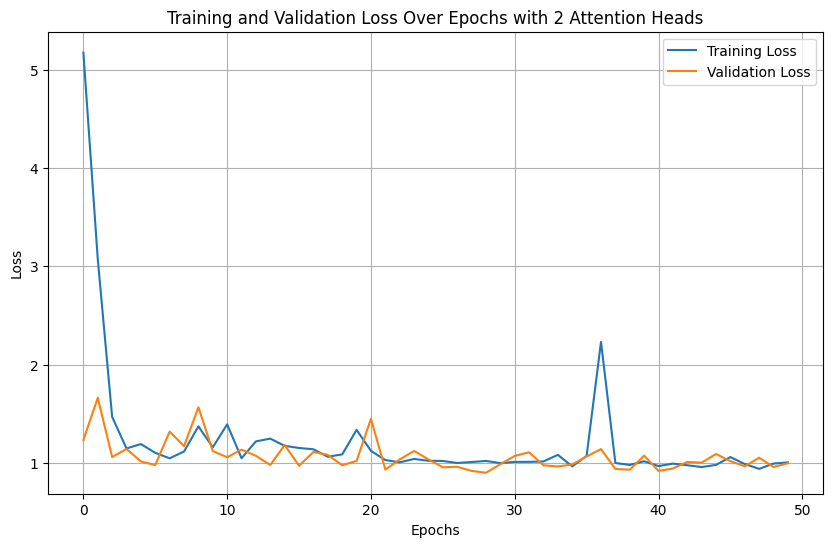

Ablation 4: Reducing the Number of Attention Heads to 4...


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 39.13it/s, loss=16.6]


Validation Loss: 2.213493501501424
Model saved with best validation loss: 2.213493501501424


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 40.86it/s, loss=6.1] 


Validation Loss: 1.5146905024136816
Model saved with best validation loss: 1.5146905024136816


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 41.31it/s, loss=1.46]


Validation Loss: 1.732616163790226
No improvement count: 1


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 41.17it/s, loss=1.44]


Validation Loss: 1.0471713377961092
Model saved with best validation loss: 1.0471713377961092


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 41.33it/s, loss=1.26]


Validation Loss: 1.2057814140404974
No improvement count: 1


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 41.28it/s, loss=1.15]


Validation Loss: 1.101263727992773
No improvement count: 2


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 38.30it/s, loss=1.07]


Validation Loss: 1.0374883152544498
Model saved with best validation loss: 1.0374883152544498


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 37.96it/s, loss=1.2] 


Validation Loss: 1.1041009878473622
No improvement count: 1


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 37.96it/s, loss=1.1] 


Validation Loss: 0.9859394383217607
Model saved with best validation loss: 0.9859394383217607


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 37.87it/s, loss=1.13]


Validation Loss: 1.0111408680677414
No improvement count: 1


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 37.89it/s, loss=1.07]


Validation Loss: 0.9499283981110368
Model saved with best validation loss: 0.9499283981110368


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 37.94it/s, loss=1.02]


Validation Loss: 0.9945381571139608
No improvement count: 1


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 38.03it/s, loss=1.03]


Validation Loss: 1.120597688747304
No improvement count: 2


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 37.93it/s, loss=1.02]


Validation Loss: 0.965591275798423
No improvement count: 3


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 37.83it/s, loss=0.966]


Validation Loss: 1.0676636243505138
No improvement count: 4


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 38.13it/s, loss=1.01]


Validation Loss: 0.969672833702394
No improvement count: 5


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 38.08it/s, loss=1.05]


Validation Loss: 1.0336740352213383
No improvement count: 6


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 38.05it/s, loss=0.987]


Validation Loss: 1.1013223145689284
No improvement count: 7


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 37.80it/s, loss=1]    


Validation Loss: 1.0249283776751585
No improvement count: 8


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 37.89it/s, loss=1.02]


Validation Loss: 0.9786338806152344
No improvement count: 9


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 38.15it/s, loss=1.01]


Validation Loss: 0.9902011065610817
No improvement count: 10


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 38.04it/s, loss=0.949]


Validation Loss: 1.0242831542023592
No improvement count: 11


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 37.90it/s, loss=1.02]


Validation Loss: 0.9673829147858279
No improvement count: 12


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 38.09it/s, loss=1]    


Validation Loss: 0.9434103641126838
Model saved with best validation loss: 0.9434103641126838


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 38.14it/s, loss=1.07]


Validation Loss: 1.003136043037687
No improvement count: 1


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 37.92it/s, loss=0.997]


Validation Loss: 1.0602146376456534
No improvement count: 2


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 38.04it/s, loss=1.03]


Validation Loss: 1.0464623272418976
No improvement count: 3


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 37.92it/s, loss=0.964]


Validation Loss: 0.935982707887888
Model saved with best validation loss: 0.935982707887888


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 38.27it/s, loss=1.04]


Validation Loss: 0.9642958454787731
No improvement count: 1


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 38.16it/s, loss=0.964]


Validation Loss: 1.078856175499303
No improvement count: 2


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 37.97it/s, loss=1.03]


Validation Loss: 0.9727583053920951
No improvement count: 3


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 37.82it/s, loss=1.04]


Validation Loss: 1.1754839872675282
No improvement count: 4


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 38.02it/s, loss=0.969]


Validation Loss: 1.006121391164405
No improvement count: 5


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 38.11it/s, loss=1.02]


Validation Loss: 0.9755979622048991
No improvement count: 6


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 38.00it/s, loss=1.03]


Validation Loss: 0.9524633240486894
No improvement count: 7


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 38.13it/s, loss=1.04]


Validation Loss: 0.9483816868492535
No improvement count: 8


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 38.13it/s, loss=0.995]


Validation Loss: 0.9634430025305066
No improvement count: 9


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 38.06it/s, loss=1]    


Validation Loss: 1.0224093640489238
No improvement count: 10


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 37.98it/s, loss=1]    


Validation Loss: 1.0125241029475416
No improvement count: 11


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 37.97it/s, loss=1.03]


Validation Loss: 1.0520339320812906
No improvement count: 12


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 38.01it/s, loss=0.996]


Validation Loss: 0.9839766775923116
No improvement count: 13


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 37.99it/s, loss=0.965]


Validation Loss: 0.9170356909079211
Model saved with best validation loss: 0.9170356909079211


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 38.10it/s, loss=0.966]


Validation Loss: 1.1021790988743305
No improvement count: 1


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 38.00it/s, loss=0.963]


Validation Loss: 0.9924796745181084
No improvement count: 2


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 37.85it/s, loss=1.05]


Validation Loss: 1.1298619471490383
No improvement count: 3


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 38.07it/s, loss=0.942]


Validation Loss: 0.9780420980283192
No improvement count: 4


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 37.92it/s, loss=0.961]


Validation Loss: 1.0166139299316066
No improvement count: 5


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 38.13it/s, loss=1.01] 


Validation Loss: 0.9883263611367771
No improvement count: 6


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 37.89it/s, loss=1.04]


Validation Loss: 0.9225898893283946
No improvement count: 7


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 38.00it/s, loss=0.995]


Validation Loss: 1.0594667781676566
No improvement count: 8


100%|██████████| 60/60 [00:00<00:00, 156.48it/s]



********************Matrices*********************
Test Loss is: 0.9522101019198695
MSE is: 0.23718000948429108
CRPS is: 0.3326199438488559


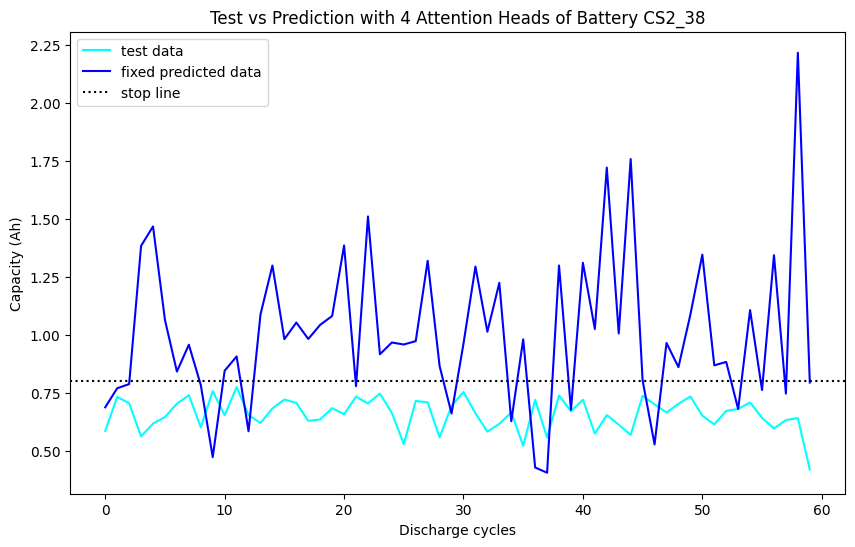

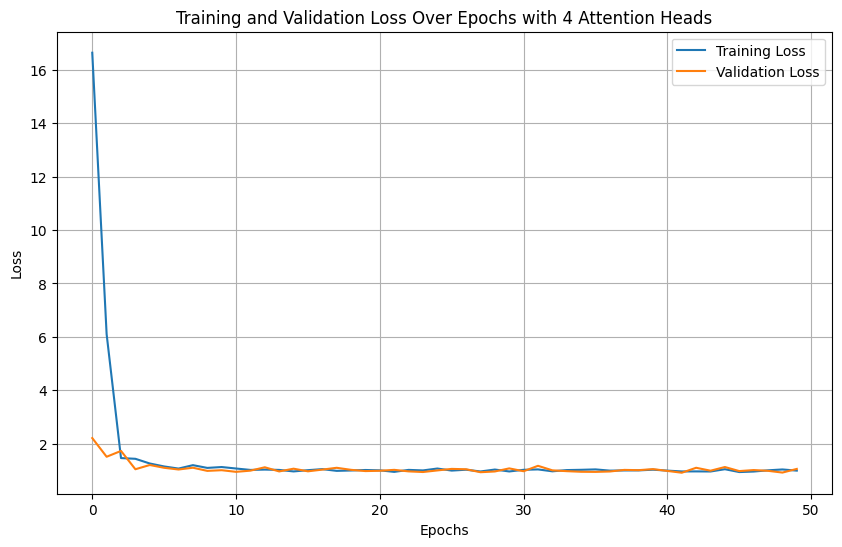

Ablation 4: Increasing the Number of Attention Heads to 16...


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 37.64it/s, loss=11]  


Validation Loss: 2.2107034602335522
Model saved with best validation loss: 2.2107034602335522


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 37.77it/s, loss=7.46]


Validation Loss: 1.2765689130340303
Model saved with best validation loss: 1.2765689130340303


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 37.50it/s, loss=1.57]


Validation Loss: 1.1942480451294355
Model saved with best validation loss: 1.1942480451294355


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 37.64it/s, loss=1.2] 


Validation Loss: 1.4590752590447664
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 37.55it/s, loss=1.19]


Validation Loss: 1.07897915158953
Model saved with best validation loss: 1.07897915158953


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 37.35it/s, loss=1.24]


Validation Loss: 1.0398842974432878
Model saved with best validation loss: 1.0398842974432878


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 37.63it/s, loss=1.14]


Validation Loss: 1.1302491958652223
No improvement count: 1


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 37.66it/s, loss=1.3] 


Validation Loss: 1.8478007774267877
No improvement count: 2


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 37.50it/s, loss=1.24]


Validation Loss: 1.0983125897390502
No improvement count: 3


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 37.56it/s, loss=1.17]


Validation Loss: 1.1391584655003888
No improvement count: 4


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 37.58it/s, loss=1.11]


Validation Loss: 0.9914200460272176
Model saved with best validation loss: 0.9914200460272176


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 37.69it/s, loss=1.11]


Validation Loss: 1.0290474109351635
No improvement count: 1


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 37.61it/s, loss=1.11]


Validation Loss: 1.3181110503418105
No improvement count: 2


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 37.53it/s, loss=1.05]


Validation Loss: 1.0151421385152
No improvement count: 3


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 37.53it/s, loss=1.16]


Validation Loss: 0.9056525618902275
Model saved with best validation loss: 0.9056525618902275


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 37.61it/s, loss=1.09]


Validation Loss: 1.2411933190056257
No improvement count: 1


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 37.55it/s, loss=1.14]


Validation Loss: 1.0335637405514717
No improvement count: 2


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 37.61it/s, loss=1.09]


Validation Loss: 1.0786401890218258
No improvement count: 3


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 37.36it/s, loss=1.07]


Validation Loss: 0.9956033428066543
No improvement count: 4


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 37.70it/s, loss=1.02]


Validation Loss: 1.0268941202333994
No improvement count: 5


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 37.46it/s, loss=0.961]


Validation Loss: 1.0674370351646627
No improvement count: 6


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 37.62it/s, loss=1.06]


Validation Loss: 1.2882973338876451
No improvement count: 7


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 37.53it/s, loss=1.07]


Validation Loss: 0.9918877088597843
No improvement count: 8


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 37.67it/s, loss=1.11]


Validation Loss: 0.9566986321338585
No improvement count: 9


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 37.60it/s, loss=1.67]


Validation Loss: 1.1588299332984857
No improvement count: 10


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 37.56it/s, loss=1.2] 


Validation Loss: 0.9876383585589272
No improvement count: 11


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 37.63it/s, loss=1.05]


Validation Loss: 1.045169174671173
No improvement count: 12


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 37.68it/s, loss=1.11]


Validation Loss: 0.9731839272592749
No improvement count: 13


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 37.44it/s, loss=1.05]


Validation Loss: 1.027058929737125
No improvement count: 14


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 37.56it/s, loss=1.02]


Validation Loss: 0.9845056028238365
No improvement count: 15


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 37.70it/s, loss=0.971]


Validation Loss: 0.9092014469206333
No improvement count: 16


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 37.59it/s, loss=1.05]


Validation Loss: 1.0296200614954745
No improvement count: 17


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 37.55it/s, loss=0.96] 


Validation Loss: 1.035356242209673
No improvement count: 18


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 37.77it/s, loss=1.04]


Validation Loss: 0.9674427775400025
No improvement count: 19


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 37.64it/s, loss=0.971]


Validation Loss: 1.0636700641896044
No improvement count: 20


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 37.51it/s, loss=0.983]


Validation Loss: 0.9644633760409695
No improvement count: 21


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 37.70it/s, loss=0.99] 


Validation Loss: 0.992131304528032
No improvement count: 22


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 37.32it/s, loss=0.998]


Validation Loss: 0.9995082872254508
No improvement count: 23


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 37.62it/s, loss=0.909]


Validation Loss: 1.0170499171529497
No improvement count: 24


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 37.52it/s, loss=1.01]


Validation Loss: 0.9345517733267376
No improvement count: 25


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 37.62it/s, loss=0.948]


Validation Loss: 1.0517117977142334
No improvement count: 26


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 37.40it/s, loss=1.01] 


Validation Loss: 1.0066835201744522
No improvement count: 27


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 38.99it/s, loss=1.01]


Validation Loss: 1.075822474701064
No improvement count: 28


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 36.93it/s, loss=0.995]


Validation Loss: 1.0150291632328714
No improvement count: 29


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 37.66it/s, loss=1.05]


Validation Loss: 1.024274309831006
No improvement count: 30
Early stopping triggered.


100%|██████████| 60/60 [00:00<00:00, 130.15it/s]



********************Matrices*********************
Test Loss is: 1.0086837256948153
MSE is: 0.21075282990932465
CRPS is: 0.31140123476177844


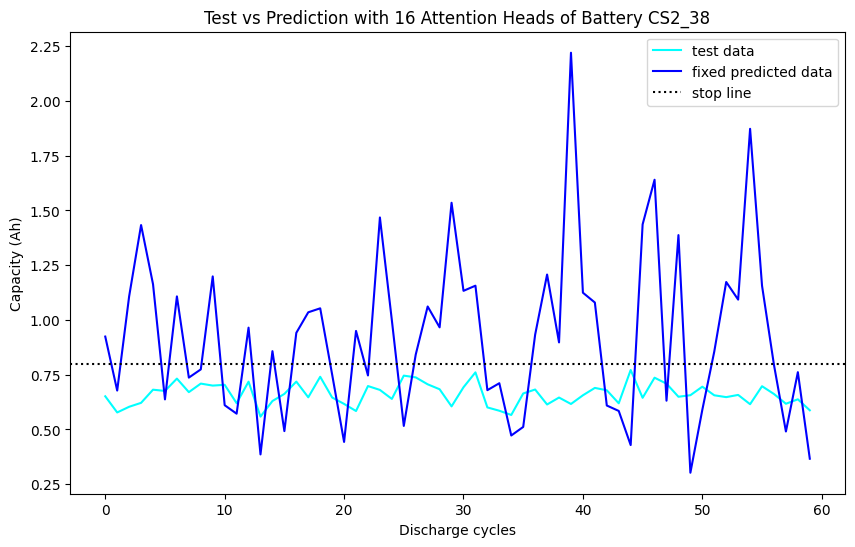

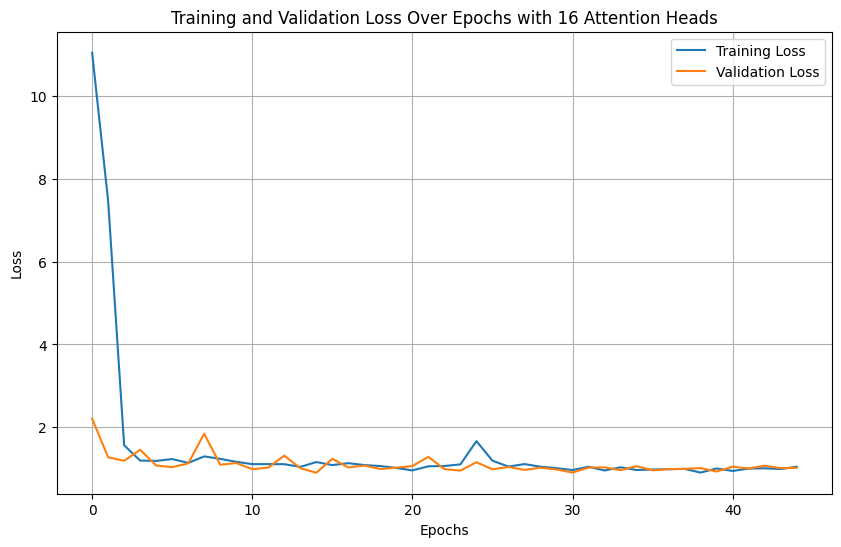

Ablation 5: Reducing the Embedding Dimension...


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 37.70it/s, loss=17.8]


Validation Loss: 1.965503835252353
Model saved with best validation loss: 1.965503835252353


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 37.73it/s, loss=8.12]


Validation Loss: 1.3463747639741217
Model saved with best validation loss: 1.3463747639741217


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 37.67it/s, loss=1.41]


Validation Loss: 0.9222019964030811
Model saved with best validation loss: 0.9222019964030811


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 37.30it/s, loss=1.35]


Validation Loss: 1.1842235294835908
No improvement count: 1


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 37.06it/s, loss=1.12]


Validation Loss: 0.9900143375354153
No improvement count: 2


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 37.52it/s, loss=1.2] 


Validation Loss: 1.111209575086832
No improvement count: 3


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 40.71it/s, loss=1.14]


Validation Loss: 1.0469816699624062
No improvement count: 4


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=1.01] 


Validation Loss: 1.1618371946471078
No improvement count: 5


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 40.61it/s, loss=1.06]


Validation Loss: 1.1767880246043205
No improvement count: 6


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 40.94it/s, loss=1.13]


Validation Loss: 0.9967130454523223
No improvement count: 7


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 40.97it/s, loss=1.18]


Validation Loss: 1.0713514403573103
No improvement count: 8


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 41.15it/s, loss=1.02]


Validation Loss: 1.1649045662156172
No improvement count: 9


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 40.65it/s, loss=1.14]


Validation Loss: 1.367778324655124
No improvement count: 10


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 40.98it/s, loss=1.14]


Validation Loss: 1.0387392938137054
No improvement count: 11


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=1.11]


Validation Loss: 1.0036685562559537
No improvement count: 12


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 40.08it/s, loss=1.04]


Validation Loss: 1.0289218510900224
No improvement count: 13


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 37.41it/s, loss=1.24]


Validation Loss: 1.1227497022066797
No improvement count: 14


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 37.85it/s, loss=1]    


Validation Loss: 1.1258164548448153
No improvement count: 15


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 37.54it/s, loss=0.974]


Validation Loss: 1.1339293388383729
No improvement count: 16


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 37.63it/s, loss=1.04]


Validation Loss: 0.9871734572308404
No improvement count: 17


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 37.59it/s, loss=1.02]


Validation Loss: 1.0562404585736138
No improvement count: 18


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 37.68it/s, loss=1.04]


Validation Loss: 0.9954541139304638
No improvement count: 19


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 37.42it/s, loss=0.997]


Validation Loss: 0.9036997822778565
Model saved with best validation loss: 0.9036997822778565


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 37.47it/s, loss=1.02]


Validation Loss: 1.099225649876254
No improvement count: 1


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 37.86it/s, loss=0.97] 


Validation Loss: 0.9880714506975242
No improvement count: 2


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 38.38it/s, loss=0.949]


Validation Loss: 1.0422961190342903
No improvement count: 3


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 40.80it/s, loss=1.03]


Validation Loss: 1.0324240789881773
No improvement count: 4


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 40.63it/s, loss=1]    


Validation Loss: 1.0148840881884098
No improvement count: 5


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 40.13it/s, loss=1.01]


Validation Loss: 0.9998104119939464
No improvement count: 6


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 40.71it/s, loss=1.01]


Validation Loss: 1.0337957947381906
No improvement count: 7


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=1.03]


Validation Loss: 1.0218062470001834
No improvement count: 8


Epoch 32/50: 100%|██████████| 110/110 [00:02<00:00, 40.36it/s, loss=0.957]


Validation Loss: 0.9658129028975964
No improvement count: 9


Epoch 33/50: 100%|██████████| 110/110 [00:02<00:00, 40.50it/s, loss=1.05]


Validation Loss: 1.0049428561968463
No improvement count: 10


Epoch 34/50: 100%|██████████| 110/110 [00:02<00:00, 40.52it/s, loss=0.944]


Validation Loss: 1.053035126200744
No improvement count: 11


Epoch 35/50: 100%|██████████| 110/110 [00:02<00:00, 40.38it/s, loss=1.04]


Validation Loss: 0.9282791364405837
No improvement count: 12


Epoch 36/50: 100%|██████████| 110/110 [00:02<00:00, 40.74it/s, loss=0.983]


Validation Loss: 1.0080031587609224
No improvement count: 13


Epoch 37/50: 100%|██████████| 110/110 [00:02<00:00, 40.65it/s, loss=1.02]


Validation Loss: 1.002820046884673
No improvement count: 14


Epoch 38/50: 100%|██████████| 110/110 [00:02<00:00, 40.53it/s, loss=0.97] 


Validation Loss: 0.9541563146880695
No improvement count: 15


Epoch 39/50: 100%|██████████| 110/110 [00:02<00:00, 40.60it/s, loss=1]    


Validation Loss: 0.9552156909235886
No improvement count: 16


Epoch 40/50: 100%|██████████| 110/110 [00:02<00:00, 40.63it/s, loss=1]    


Validation Loss: 1.0157118370490414
No improvement count: 17


Epoch 41/50: 100%|██████████| 110/110 [00:02<00:00, 40.44it/s, loss=0.985]


Validation Loss: 1.0072907049741064
No improvement count: 18


Epoch 42/50: 100%|██████████| 110/110 [00:02<00:00, 40.71it/s, loss=0.946]


Validation Loss: 1.0262788182922773
No improvement count: 19


Epoch 43/50: 100%|██████████| 110/110 [00:02<00:00, 40.61it/s, loss=0.97] 


Validation Loss: 0.9314619973301888
No improvement count: 20


Epoch 44/50: 100%|██████████| 110/110 [00:02<00:00, 40.53it/s, loss=0.974]


Validation Loss: 0.9995258530335767
No improvement count: 21


Epoch 45/50: 100%|██████████| 110/110 [00:02<00:00, 40.54it/s, loss=1.03]


Validation Loss: 1.0811323294682162
No improvement count: 22


Epoch 46/50: 100%|██████████| 110/110 [00:02<00:00, 40.77it/s, loss=0.979]


Validation Loss: 1.0229941340429443
No improvement count: 23


Epoch 47/50: 100%|██████████| 110/110 [00:02<00:00, 41.05it/s, loss=1.12] 


Validation Loss: 1.0629206368965762
No improvement count: 24


Epoch 48/50: 100%|██████████| 110/110 [00:02<00:00, 41.00it/s, loss=1.11]


Validation Loss: 1.050714532179492
No improvement count: 25


Epoch 49/50: 100%|██████████| 110/110 [00:02<00:00, 41.01it/s, loss=1.04]


Validation Loss: 1.0255709737539291
No improvement count: 26


Epoch 50/50: 100%|██████████| 110/110 [00:02<00:00, 41.23it/s, loss=0.976]


Validation Loss: 1.025447102529662
No improvement count: 27


100%|██████████| 60/60 [00:00<00:00, 157.34it/s]



********************Matrices*********************
Test Loss is: 1.036339707672596
MSE is: 0.2559102177619934
CRPS is: 0.3613463853245344


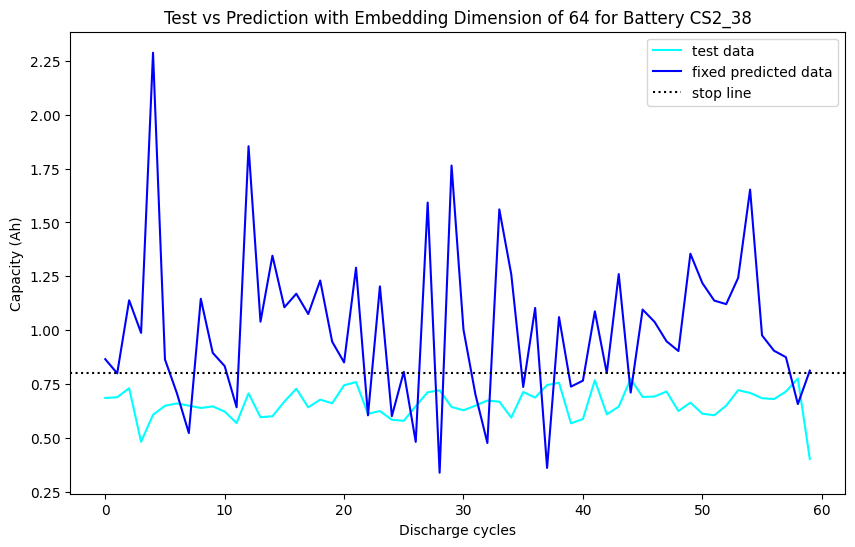

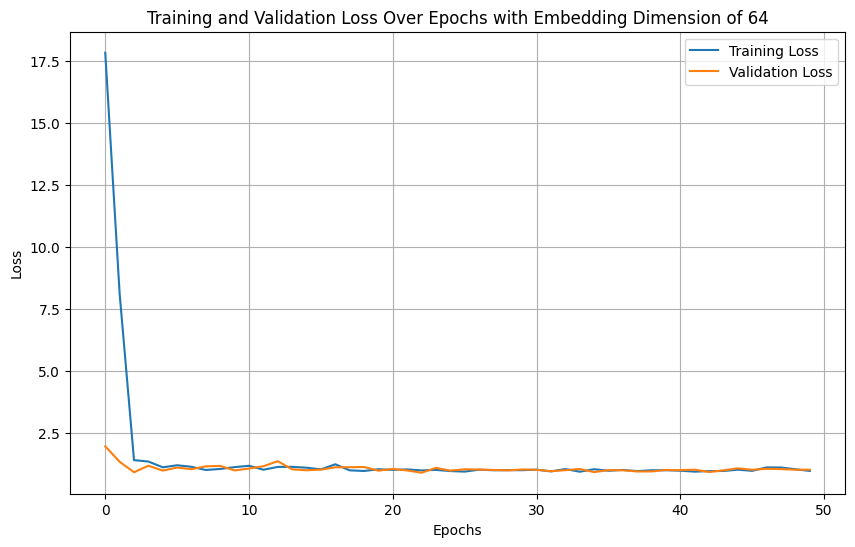

Ablation 6: Removing the Residual Connections...


Epoch 1/50: 100%|██████████| 110/110 [00:02<00:00, 38.03it/s, loss=0.995]


Validation Loss: 0.8635639138519764
Model saved with best validation loss: 0.8635639138519764


Epoch 2/50: 100%|██████████| 110/110 [00:02<00:00, 38.15it/s, loss=1.03]


Validation Loss: 1.1821454225906305
No improvement count: 1


Epoch 3/50: 100%|██████████| 110/110 [00:02<00:00, 37.64it/s, loss=1.04]


Validation Loss: 1.1262381704790252
No improvement count: 2


Epoch 4/50: 100%|██████████| 110/110 [00:02<00:00, 38.15it/s, loss=1.02]


Validation Loss: 1.0112098673624652
No improvement count: 3


Epoch 5/50: 100%|██████████| 110/110 [00:02<00:00, 38.21it/s, loss=1.03]


Validation Loss: 0.9742110680256572
No improvement count: 4


Epoch 6/50: 100%|██████████| 110/110 [00:02<00:00, 38.25it/s, loss=1.06]


Validation Loss: 1.0653921919209617
No improvement count: 5


Epoch 7/50: 100%|██████████| 110/110 [00:02<00:00, 38.31it/s, loss=1.02]


Validation Loss: 1.009198630494731
No improvement count: 6


Epoch 8/50: 100%|██████████| 110/110 [00:02<00:00, 39.77it/s, loss=1.02]


Validation Loss: 0.8901369577007634
No improvement count: 7


Epoch 9/50: 100%|██████████| 110/110 [00:02<00:00, 37.83it/s, loss=1.03]


Validation Loss: 0.9875158087483474
No improvement count: 8


Epoch 10/50: 100%|██████████| 110/110 [00:02<00:00, 38.01it/s, loss=1.03]


Validation Loss: 1.0440755066062724
No improvement count: 9


Epoch 11/50: 100%|██████████| 110/110 [00:02<00:00, 38.09it/s, loss=0.984]


Validation Loss: 1.0110370591282845
No improvement count: 10


Epoch 12/50: 100%|██████████| 110/110 [00:02<00:00, 37.90it/s, loss=1.06]


Validation Loss: 1.0003599721406187
No improvement count: 11


Epoch 13/50: 100%|██████████| 110/110 [00:02<00:00, 38.04it/s, loss=1.01]


Validation Loss: 1.0270081928798132
No improvement count: 12


Epoch 14/50: 100%|██████████| 110/110 [00:02<00:00, 37.84it/s, loss=1.04]


Validation Loss: 1.02526687883905
No improvement count: 13


Epoch 15/50: 100%|██████████| 110/110 [00:02<00:00, 37.98it/s, loss=1.19]


Validation Loss: 1.0557475435946668
No improvement count: 14


Epoch 16/50: 100%|██████████| 110/110 [00:02<00:00, 37.99it/s, loss=1.02]


Validation Loss: 1.021829361894301
No improvement count: 15


Epoch 17/50: 100%|██████████| 110/110 [00:02<00:00, 37.78it/s, loss=1.06]


Validation Loss: 0.9522439629903862
No improvement count: 16


Epoch 18/50: 100%|██████████| 110/110 [00:02<00:00, 37.92it/s, loss=1.03]


Validation Loss: 1.075077303818294
No improvement count: 17


Epoch 19/50: 100%|██████████| 110/110 [00:02<00:00, 37.85it/s, loss=1.07]


Validation Loss: 0.9613261856138706
No improvement count: 18


Epoch 20/50: 100%|██████████| 110/110 [00:02<00:00, 38.03it/s, loss=1.01] 


Validation Loss: 0.9992004207202366
No improvement count: 19


Epoch 21/50: 100%|██████████| 110/110 [00:02<00:00, 38.10it/s, loss=1.04]


Validation Loss: 1.0434521436691284
No improvement count: 20


Epoch 22/50: 100%|██████████| 110/110 [00:02<00:00, 38.21it/s, loss=1.02]


Validation Loss: 1.0092048889824323
No improvement count: 21


Epoch 23/50: 100%|██████████| 110/110 [00:02<00:00, 38.13it/s, loss=1.03]


Validation Loss: 1.0742197696651732
No improvement count: 22


Epoch 24/50: 100%|██████████| 110/110 [00:02<00:00, 38.15it/s, loss=0.988]


Validation Loss: 0.9499887871955123
No improvement count: 23


Epoch 25/50: 100%|██████████| 110/110 [00:02<00:00, 38.06it/s, loss=1.01] 


Validation Loss: 0.9618344083428383
No improvement count: 24


Epoch 26/50: 100%|██████████| 110/110 [00:02<00:00, 38.28it/s, loss=0.969]


Validation Loss: 1.0176686011254787
No improvement count: 25


Epoch 27/50: 100%|██████████| 110/110 [00:02<00:00, 37.92it/s, loss=1]    


Validation Loss: 1.0461499047066485
No improvement count: 26


Epoch 28/50: 100%|██████████| 110/110 [00:02<00:00, 38.18it/s, loss=0.958]


Validation Loss: 1.0050820048366274
No improvement count: 27


Epoch 29/50: 100%|██████████| 110/110 [00:02<00:00, 38.02it/s, loss=1.05]


Validation Loss: 0.9768436636243548
No improvement count: 28


Epoch 30/50: 100%|██████████| 110/110 [00:02<00:00, 38.19it/s, loss=0.998]


Validation Loss: 0.9693896493741444
No improvement count: 29


Epoch 31/50: 100%|██████████| 110/110 [00:02<00:00, 38.18it/s, loss=1.05]


Validation Loss: 0.9791380640651498
No improvement count: 30
Early stopping triggered.


100%|██████████| 60/60 [00:00<00:00, 170.44it/s]



********************Matrices*********************
Test Loss is: 1.0707259148359298
MSE is: 0.20582537353038788
CRPS is: 0.2907706144960408


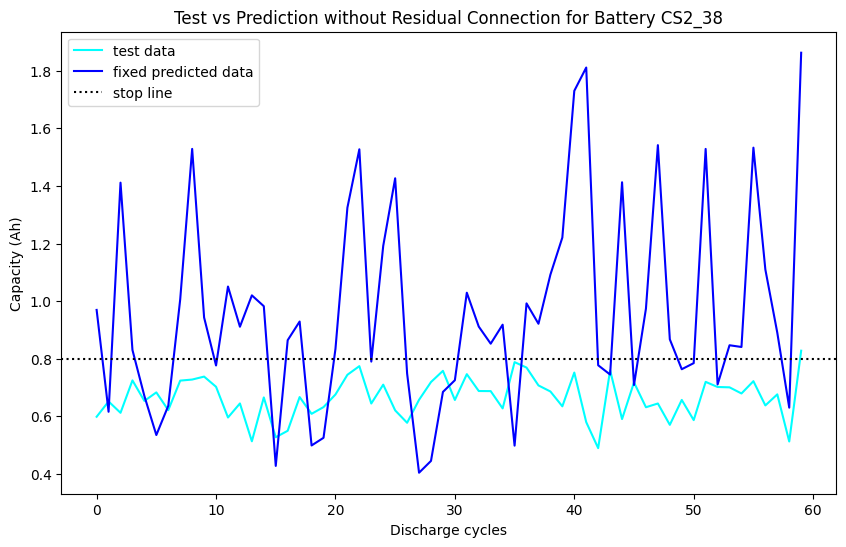

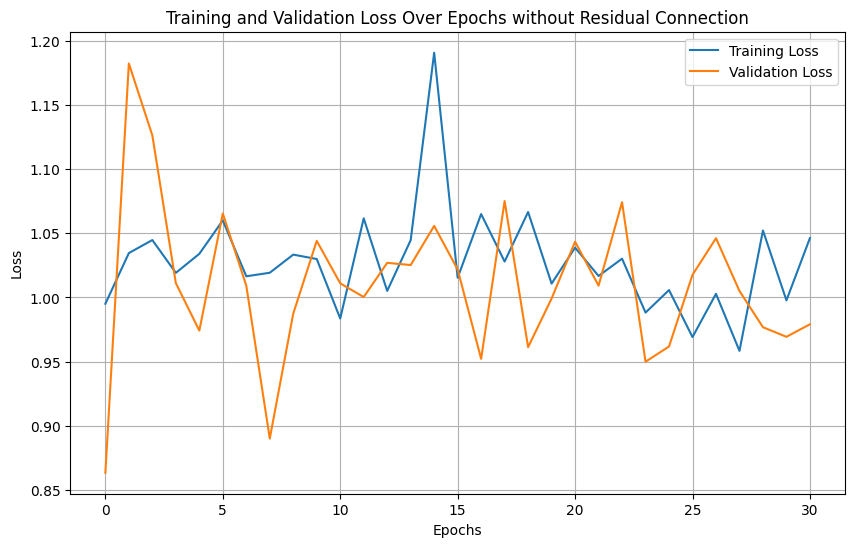

In [73]:

ablation_results = {}

# Baseline model
print("Running baseline model...")
config = yaml.safe_load(open('config/base.yaml', 'r'))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
modelbaseline = TDSTF(config, device).to(device)
train_loaderbaseline = get_dataloader(train_batteries)
valid_loaderbaseline = get_dataloader([valid_battery])
modelbaseline, train_lossbaseline, valid_lossbaseline = train(modelbaseline, config, train_loaderbaseline, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['Baseline'] = min(valid_loss)
config_ablation = config.copy()


# 1: Removing the Diffusion Embedding
print("Ablation 1: Removing the Diffusion Embedding...")
class ResNetNoDiffusion(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.size_x = config['size']
        self.channels = config['channels']
        num_features = 1  # Only the capacity feature
        lv =len(var)

        self.emb_t = TimeEmbedding(config['time_points'], config['time_embedding_dim'], self.device)
        self.emb_v = nn.Linear(1, self.channels).to(self.device)
        self.emb_f = nn.Embedding(lv + 1, self.channels).to(self.device)
        self.dec1 = Conv1d_with_init(self.channels, self.channels, 1)
        self.dec2 = Conv1d_with_init(self.channels, 1, 1)
        self.residual_layers = nn.ModuleList([
            TransformerLayer(config, self.device)
            for _ in range(config['layers'])
        ])
        self.to(self.device)

    def forward(self, samples_x, samples_y, diffusion_step):
        samples_y = samples_y.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()
        samples_x = samples_x.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()

        x_emb = self.emb_f(samples_x)
        y_emb = self.emb_f(samples_y)

        skip = []
        for layer in self.residual_layers:
            y_emb, skip_connection = layer(x_emb, y_emb)
            skip.append(skip_connection)

        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)

        return output

class TDSTFNoDiffusion(nn.Module):
    def __init__(self, config, device):
        super(TDSTFNoDiffusion, self).__init__()
        self.device = device
        self.config_diff = config['diffusion']
        self.res_model = ResNetNoDiffusion(self.config_diff, self.device)
        self.num_steps = self.config_diff['num_steps']
        self.beta = np.linspace(self.config_diff['beta_start'] ** 0.5, self.config_diff['beta_end'] ** 0.5, self.num_steps) ** 2
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1)

    def process(self, batch):
        samples_x = batch[0].to(self.device).float()
        samples_y = batch[1].to(self.device).float().view(-1, 1)
        return samples_x, samples_y

    def forward(self, samples_x, samples_y):
        t = torch.randint(0, self.num_steps, [len(samples_x)]).to(self.device)
        current_alpha = self.alpha_torch[t].unsqueeze(1)
        noise = torch.randn_like(samples_y).to(samples_y.device)
        mask_y = torch.ones_like(samples_y).squeeze()
        samples_y = ((current_alpha ** 0.5) * samples_y + ((1.0 - current_alpha) ** 0.5) * noise) * mask_y.unsqueeze(1)
        predicted = self.res_model(samples_x, samples_y, t)
        residual = torch.where(mask_y.unsqueeze(1) == 1, noise - predicted, torch.zeros_like(predicted))
        loss = (residual ** 2).mean()
        return loss

    def forecast(self, samples_x, samples_y, n_samples):
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device)
        for i in range(n_samples):
            samples_y = torch.randn_like(samples_y) * samples_y
            for t in range(self.num_steps - 1, -1, -1):
                mask_y = samples_y.squeeze()
                mask_y = mask_y.unsqueeze(-1)

                predicted = self.res_model(samples_x, samples_y, torch.tensor([t]).to(self.device))
                predicted = predicted.view(-1, samples_y.size(1), predicted.size(-1))

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5

                if samples_y.shape != predicted.shape:
                    predicted = predicted.view(samples_y.shape)

                samples_y = coeff1 * (samples_y - coeff2 * predicted) * mask_y

                if t > 0:
                    noise = torch.randn_like(samples_y) * mask_y
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5
                    samples_y += sigma * noise

            generation[i] = samples_y.detach()
        return generation.permute(1, 2, 0)

    def evaluate(self, samples_x, samples_y):
        with torch.no_grad():
            generation = self.forward(samples_x, samples_y)
        return generation, samples_y, samples_x

model_ablation1 = TDSTFNoDiffusion(config_ablation, device).to(device)
model_ablation1, train_loss1, valid_loss1 = train(model_ablation1, config_ablation, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['No Diffusion Embedding'] = min(valid_loss1)


# 2: Reducing the Number of Transformer Layers
print("Ablation 2: Reducing the Number of Transformer Layers to 1")
config_ablation2 = config.copy()
config_ablation2['diffusion']['layers'] = 1  # Reduce transformer layers to 1
model_ablation2 = TDSTF(config_ablation2, device).to(device)
model_ablation2, train_loss2, valid_loss2 = train(model_ablation2, config_ablation2, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['1 Transformer Layer'] = min(valid_loss2)


# 3: Increasing the Number of Transformer Layers
print("Ablation 3: Increasing the Number of Transformer Layers to 6")
config_ablation3 = config.copy()
config_ablation3['diffusion']['layers'] = 6  # Increase transformer layers to 6
model_ablation3 = TDSTF(config_ablation3, device).to(device)
model_ablation3, train_loss3, valid_loss3 = train(model_ablation3, config_ablation3, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['6 Transformer Layer'] = min(valid_loss3)


# 4: Influence of Attention Heads
print("Ablation 4: Reducing the Number of Attention Heads to 2...")
config_ablation4 = config.copy()
config_ablation4['diffusion']['num_heads'] = 2  # Reduce attention heads to 2
model_ablation4= TDSTF(config_ablation4, device).to(device)
model_ablation4, train_loss4, valid_loss4 = train(model_ablation4, config_ablation4, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['2 Attention Heads'] = min(valid_loss4)
print("Ablation 4: Reducing the Number of Attention Heads to 4...")
config_ablation44 = config.copy()
config_ablation44['diffusion']['num_heads'] = 4  # Reduce attention heads to 4
model_ablation44 = TDSTF(config_ablation44, device).to(device)
model_ablation44, train_loss44, valid_loss44 = train(model_ablation44, config_ablation44, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['4 Attention Heads'] = min(valid_loss44)
print("Ablation 4: Increasing the Number of Attention Heads to 16...")
config_ablation444 = config.copy()
config_ablation444['diffusion']['num_heads'] = 16  # Increase attention heads to 16
model_ablation444 = TDSTF(config_ablation444, device).to(device)
model_ablation444, train_loss444, valid_loss444 = train(model_ablation444, config_ablation444, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['16 Attention Heads'] = min(valid_loss444)

#5: Influence of Embedding Dimension
print("Ablation 5: Reducing the Embedding Dimension...")
config_ablation5 = config.copy()
config_ablation5['diffusion']['time_embedding_dim'] = 64  # Reduce embedding dimension
model_ablation5 = TDSTF(config_ablation5, device).to(device)
model_ablation5, train_loss5, valid_loss5 = train(model_ablation5, config_ablation5, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['Embedding Dimension 64'] = min(valid_loss5)

#6: Removing the Residual Connections
print("Ablation 6: Removing the Residual Connections...")
class TransformerLayerNoResidual(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.layer_norm = nn.LayerNorm(config['channels'])
        self.attn = nn.MultiheadAttention(embed_dim=config['channels'], num_heads=config['num_heads'])
        self.ffn = nn.Sequential(
            nn.Linear(config['channels'], config['channels'] * 4),
            nn.ReLU(),
            nn.Linear(config['channels'] * 4, config['channels']),
        )
        self.dropout = nn.Dropout(config.get('dropout', 0.1))
        self.device = device

    def forward(self, x, y):
        y = self.layer_norm(y)
        attn_output, attn_weights = self.attn(y, y, y)
        y = self.dropout(attn_output)
        y = self.dropout(self.ffn(y))
        return y, y  # No residual connection

class ResNetNoResidual(nn.Module):
    def __init__(self, config, device):
        super().__init__()
        self.device = device
        self.size_x = config['size']
        self.channels = config['channels']
        num_features = 1  # Only the capacity feature
        lv = len(var)

        self.emb_t = TimeEmbedding(config['time_points'], config['time_embedding_dim'], self.device)
        self.emb_v = nn.Linear(1, self.channels).to(self.device)
        self.emb_f = nn.Embedding(lv + 1, self.channels).to(self.device)
        self.dec1 = Conv1d_with_init(self.channels, self.channels, 1)
        self.dec2 = Conv1d_with_init(self.channels, 1, 1)
        self.residual_layers = nn.ModuleList([
            TransformerLayerNoResidual(config, self.device)
            for _ in range(config['layers'])
        ])
        self.to(self.device)

    def forward(self, samples_x, samples_y, diffusion_step):
        samples_y = samples_y.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()
        samples_x = samples_x.squeeze(-1).clamp(0, self.emb_f.num_embeddings - 1).long()

        x_emb = self.emb_f(samples_x)
        y_emb = self.emb_f(samples_y)

        skip = []
        for layer in self.residual_layers:
            y_emb, skip_connection = layer(x_emb, y_emb)
            skip.append(skip_connection)

        output = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        output = self.dec1(output.permute(0, 2, 1))
        output = F.relu(output)
        output = self.dec2(output)

        return output

class TDSTFNoResidual(nn.Module):
    def __init__(self, config, device):
        super(TDSTFNoResidual, self).__init__()
        self.device = device
        self.config_diff = config['diffusion']
        self.res_model = ResNetNoResidual(self.config_diff, self.device)
        self.num_steps = self.config_diff['num_steps']
        self.beta = np.linspace(self.config_diff['beta_start'] ** 0.5, self.config_diff['beta_end'] ** 0.5, self.num_steps) ** 2
        self.alpha_hat = 1 - self.beta
        self.alpha = np.cumprod(self.alpha_hat)
        self.alpha_torch = torch.tensor(self.alpha).float().to(self.device).unsqueeze(1)

    def process(self, batch):
        samples_x = batch[0].to(self.device).float()
        samples_y = batch[1].to(self.device).float().view(-1, 1)
        return samples_x, samples_y

    def forward(self, samples_x, samples_y):
        t = torch.randint(0, self.num_steps, [len(samples_x)]).to(self.device)
        current_alpha = self.alpha_torch[t].unsqueeze(1)
        noise = torch.randn_like(samples_y).to(samples_y.device)
        mask_y = torch.ones_like(samples_y).squeeze()
        samples_y = ((current_alpha ** 0.5) * samples_y + ((1.0 - current_alpha) ** 0.5) * noise) * mask_y.unsqueeze(1)
        predicted = self.res_model(samples_x, samples_y, t)
        residual = torch.where(mask_y.unsqueeze(1) == 1, noise - predicted, torch.zeros_like(predicted))
        loss = (residual ** 2).mean()
        return loss

    def forecast(self, samples_x, samples_y, n_samples):
        generation = torch.zeros(n_samples, samples_y.shape[0], samples_y.shape[-1]).to(self.device)
        for i in range(n_samples):
            samples_y = torch.randn_like(samples_y) * samples_y
            for t in range(self.num_steps - 1, -1, -1):
                mask_y = samples_y.squeeze()
                mask_y = mask_y.unsqueeze(-1)

                predicted = self.res_model(samples_x, samples_y, torch.tensor([t]).to(self.device))
                predicted = predicted.view(-1, samples_y.size(1), predicted.size(-1))

                coeff1 = 1 / self.alpha_hat[t] ** 0.5
                coeff2 = (1 - self.alpha_hat[t]) / (1 - self.alpha[t]) ** 0.5

                if samples_y.shape != predicted.shape:
                    predicted = predicted.view(samples_y.shape)

                samples_y = coeff1 * (samples_y - coeff2 * predicted) * mask_y

                if t > 0:
                    noise = torch.randn_like(samples_y) * mask_y
                    sigma = ((1.0 - self.alpha[t - 1]) / (1.0 - self.alpha[t]) * self.beta[t]) ** 0.5
                    samples_y += sigma * noise

            generation[i] = samples_y.detach()
        return generation.permute(1, 2, 0)

    def evaluate(self, samples_x, samples_y):
        with torch.no_grad():
            generation = self.forward(samples_x, samples_y)
        return generation, samples_y, samples_x

model_ablation6 = TDSTFNoResidual(config_ablation5, device).to(device)
model_ablation6, train_loss6, valid_loss6 = train(model_ablation6, config_ablation, train_loader, valid_loader=valid_loader, foldername='', data_path='')
ablation_results['No Residual Connections'] = min(valid_loss6)


100%|██████████| 60/60 [00:00<00:00, 263.17it/s]
The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.



********************Matrices*********************
Test Loss is: 1.0593989392121632
MSE is: 0.20036044716835022
CRPS is: 0.3066424955757057


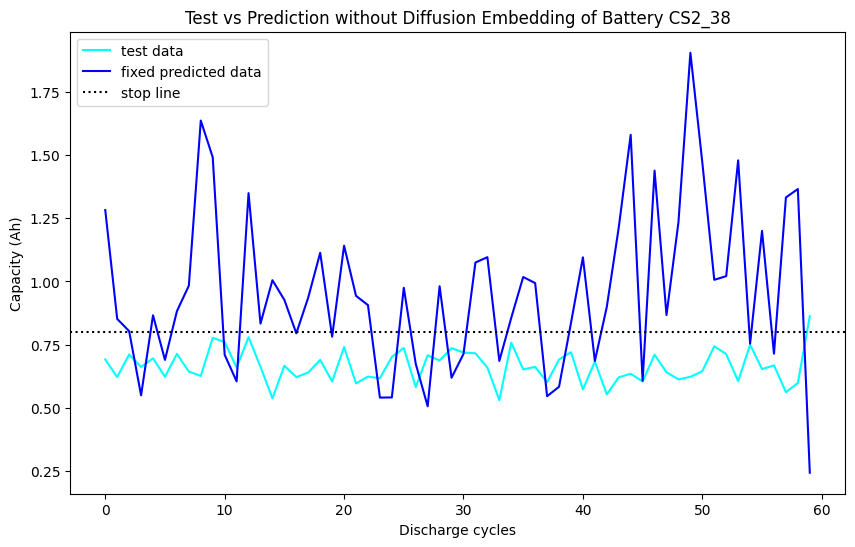

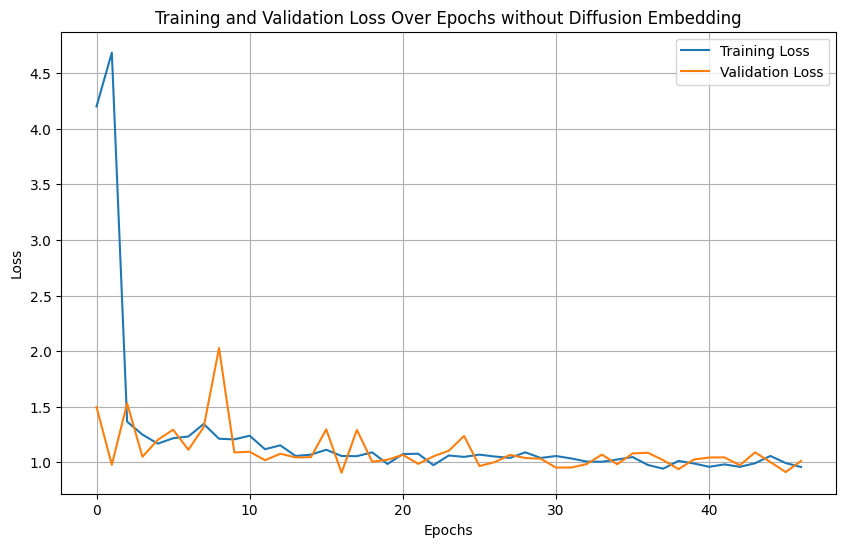

100%|██████████| 60/60 [00:00<00:00, 393.57it/s]



********************Matrices*********************
Test Loss is: 1.0661333734790484
MSE is: 0.24749985337257385
CRPS is: 0.31365157750998546


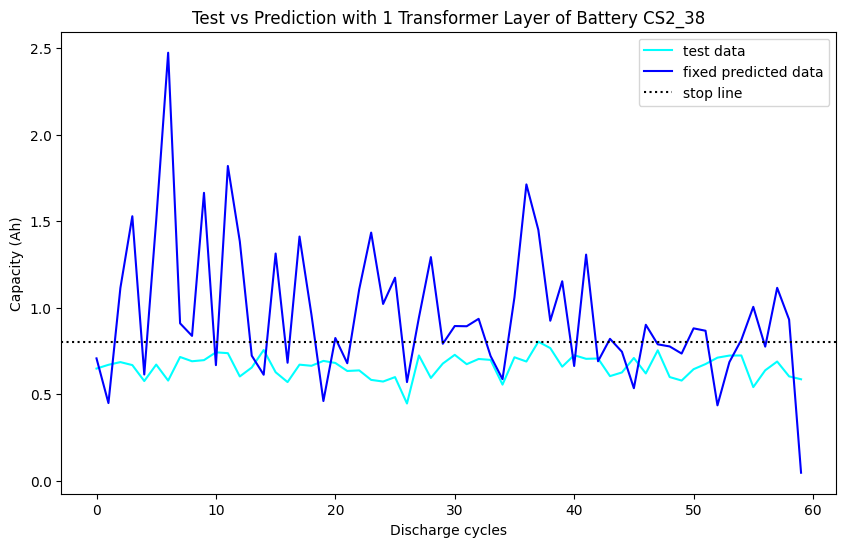

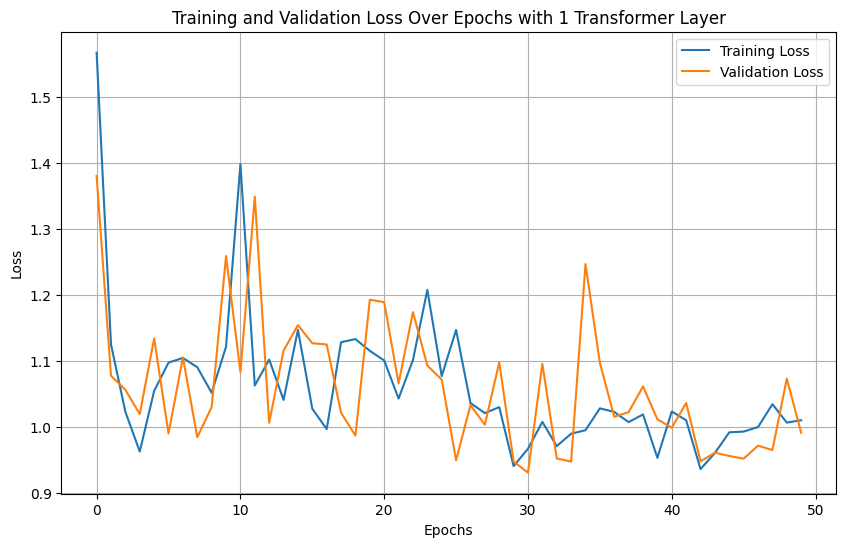

100%|██████████| 60/60 [00:00<00:00, 156.08it/s]



********************Matrices*********************
Test Loss is: 1.0102094093958536
MSE is: 0.1980934888124466
CRPS is: 0.29964896092262794


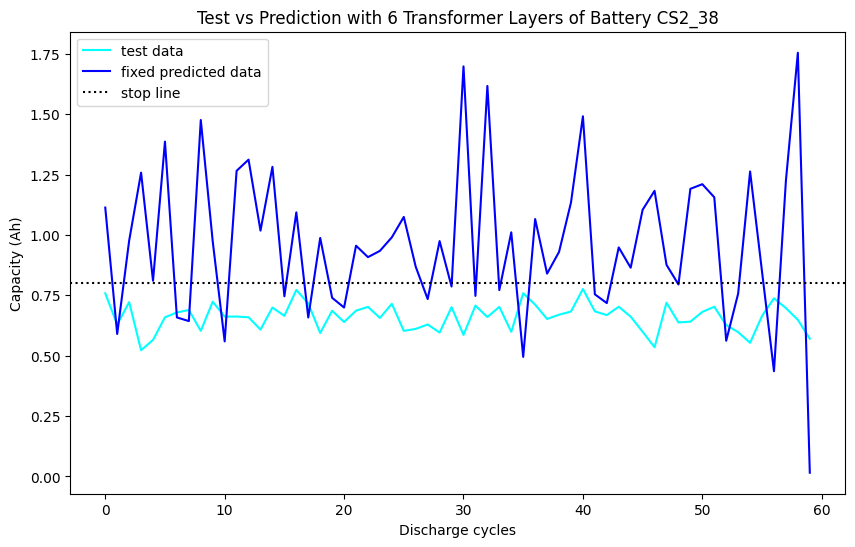

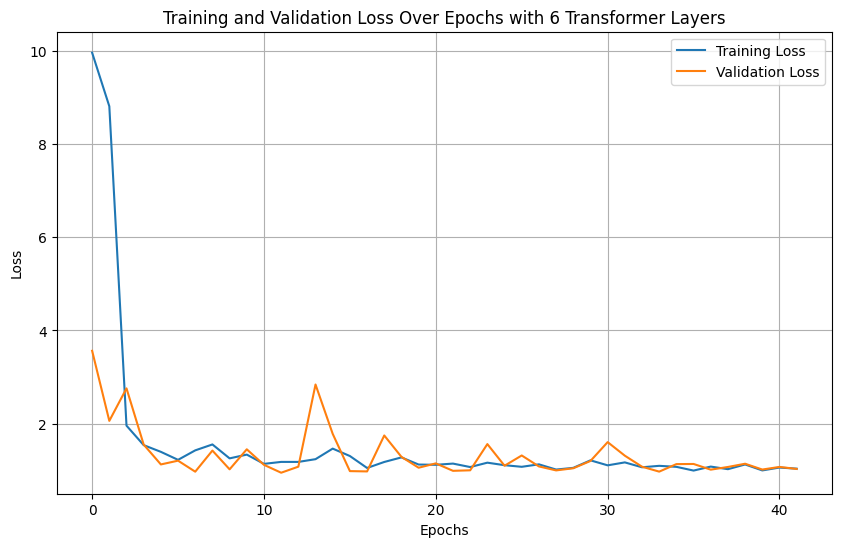

100%|██████████| 60/60 [00:00<00:00, 153.30it/s]



********************Matrices*********************
Test Loss is: 0.9736035007983446
MSE is: 0.2786356806755066
CRPS is: 0.35092943662327414


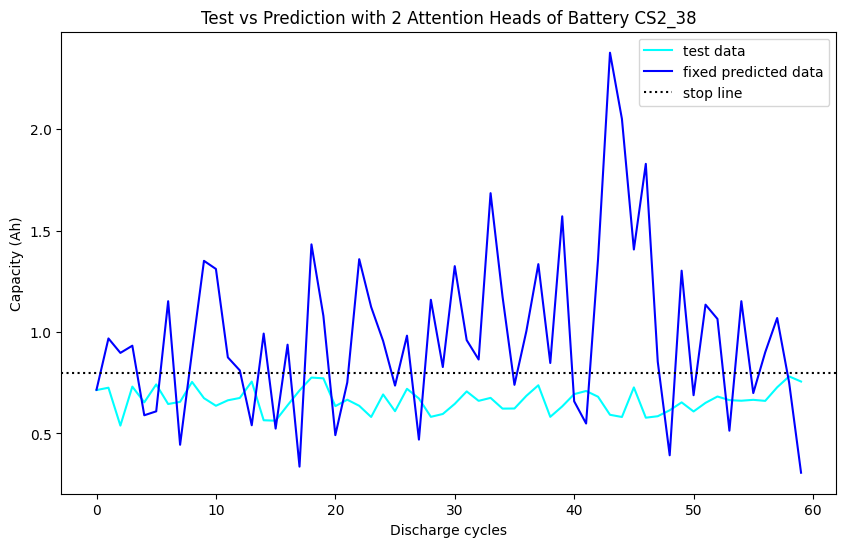

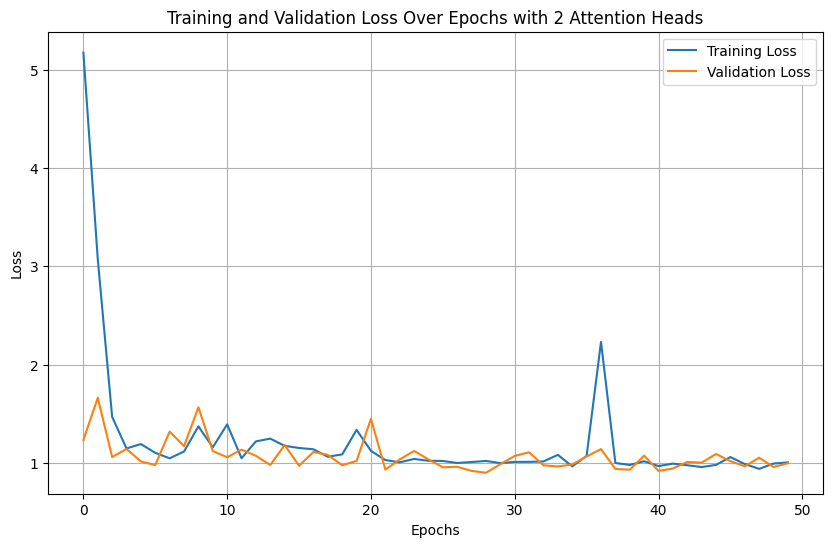

100%|██████████| 60/60 [00:00<00:00, 151.44it/s]



********************Matrices*********************
Test Loss is: 0.9554686788877007
MSE is: 0.24186736345291138
CRPS is: 0.3542518589088337


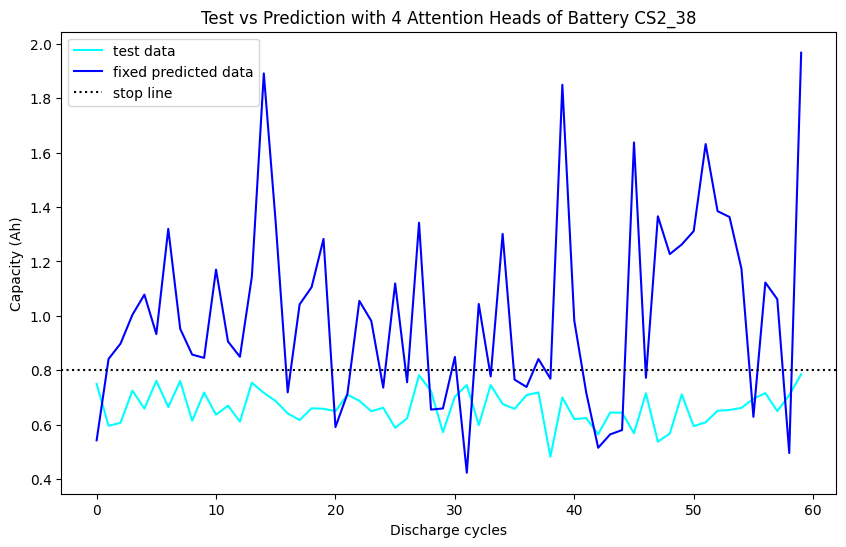

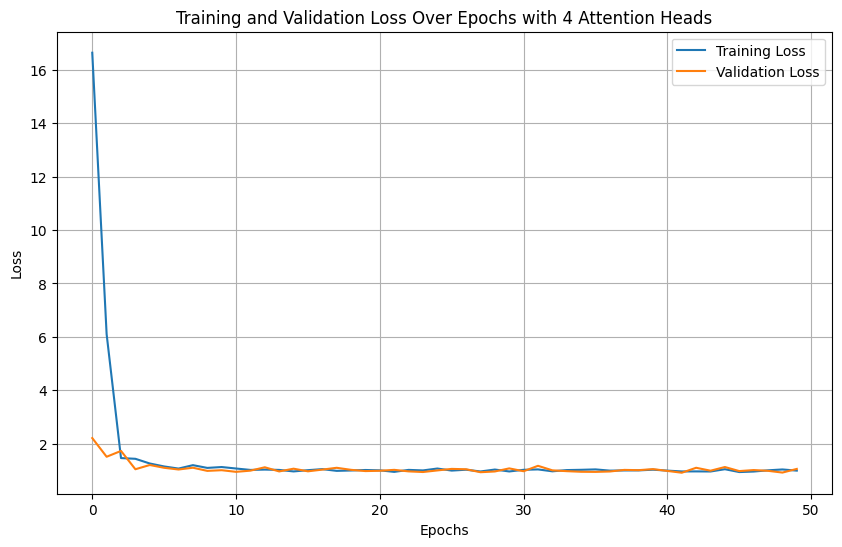

100%|██████████| 60/60 [00:00<00:00, 151.24it/s]



********************Matrices*********************
Test Loss is: 0.9156783034404119
MSE is: 0.2339026927947998
CRPS is: 0.36256156488218616


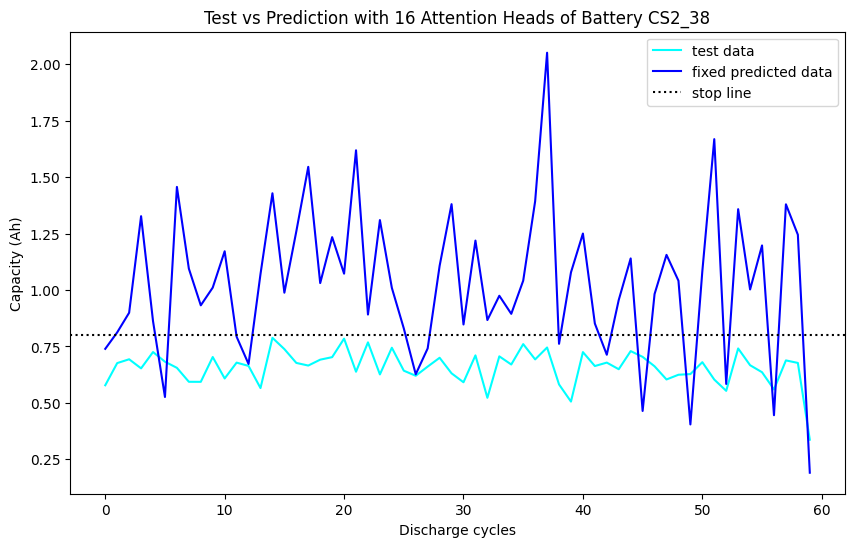

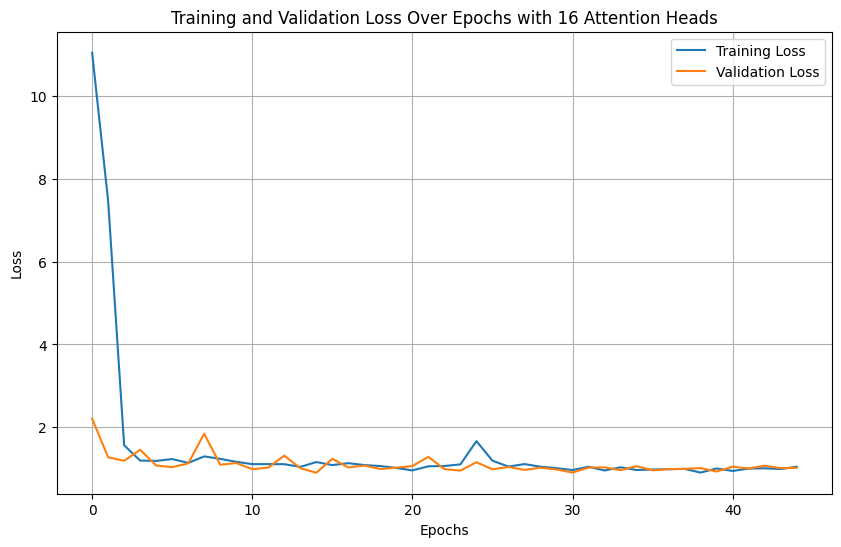

100%|██████████| 60/60 [00:00<00:00, 150.20it/s]



********************Matrices*********************
Test Loss is: 1.0292105754216512
MSE is: 0.2562975287437439
CRPS is: 0.3662225783982839


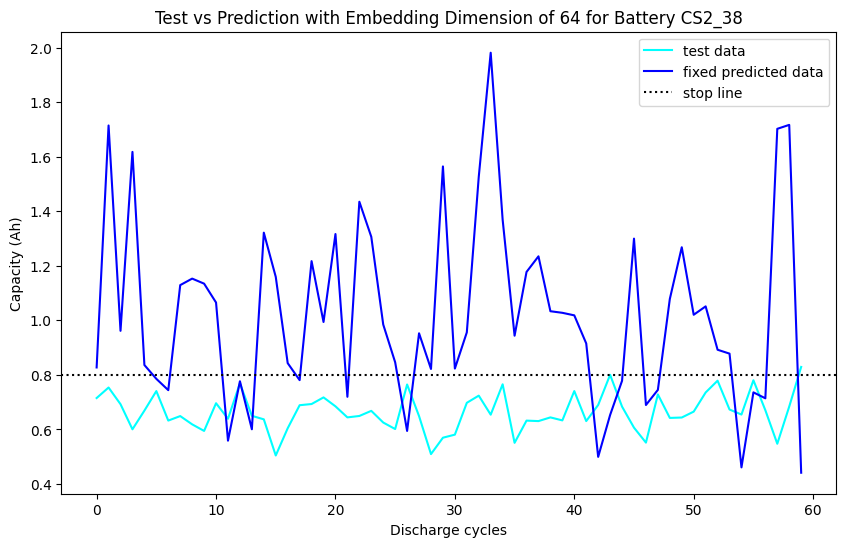

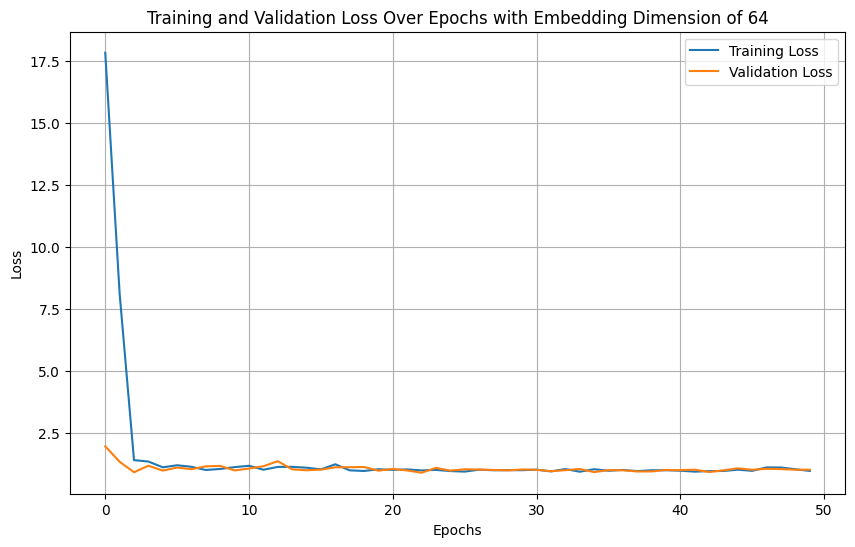

100%|██████████| 60/60 [00:00<00:00, 168.55it/s]



********************Matrices*********************
Test Loss is: 1.0347530990839005
MSE is: 0.23312529921531677
CRPS is: 0.34385643489099194


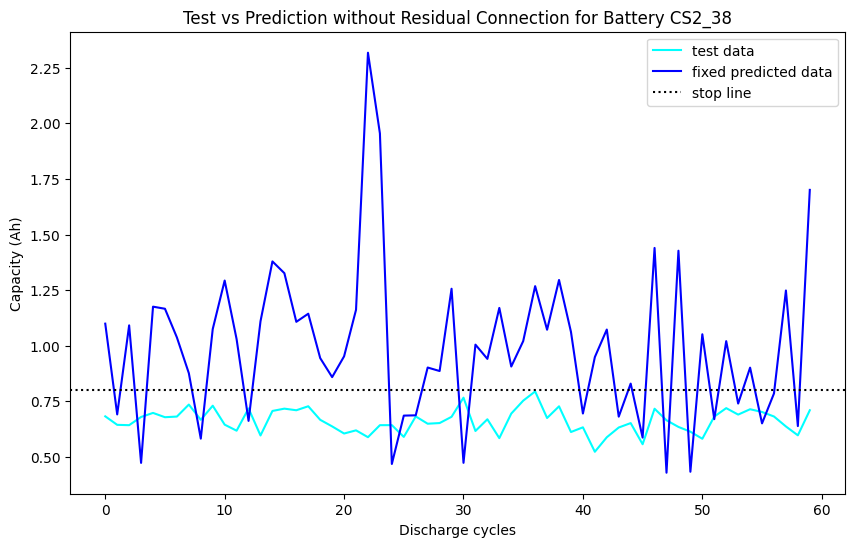

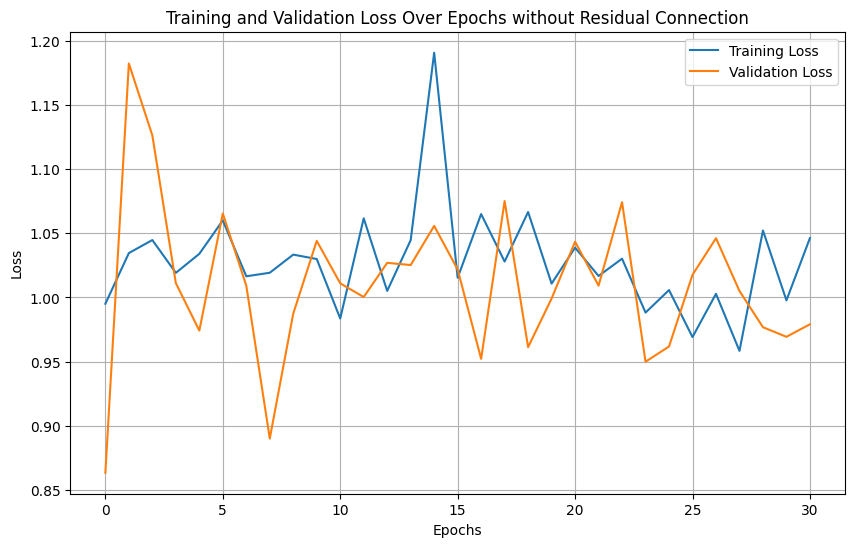

In [74]:
CRPS1, MSE1,loss1,predictions1 = evaluate(is_test=True, model=model_ablation1, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction without Diffusion Embedding of Battery {test_battery}')
plot_losses(train_loss1, valid_loss1, test_battery, title="Training and Validation Loss Over Epochs without Diffusion Embedding")

CRPS2, MSE2,loss2,predictions2 = evaluate(is_test=True, model=model_ablation2, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 1 Transformer Layer of Battery {test_battery}')
plot_losses(train_loss2, valid_loss2, test_battery, title="Training and Validation Loss Over Epochs with 1 Transformer Layer")

CRPS3, MSE3,loss3,predictions3 = evaluate(is_test=True, model=model_ablation3, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 6 Transformer Layers of Battery {test_battery}')
plot_losses(train_loss3, valid_loss3, test_battery, title="Training and Validation Loss Over Epochs with 6 Transformer Layers")

CRPS4, MSE4,loss4,predictions4 = evaluate(is_test=True, model=model_ablation4, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 2 Attention Heads of Battery {test_battery}')
plot_losses(train_loss4, valid_loss4, test_battery, title="Training and Validation Loss Over Epochs with 2 Attention Heads")

CRPS44, MSE44,loss44,predictions44 = evaluate(is_test=True, model=model_ablation44, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 4 Attention Heads of Battery {test_battery}')
plot_losses(train_loss44, valid_loss44, test_battery, title="Training and Validation Loss Over Epochs with 4 Attention Heads")


CRPS444, MSE444,loss444,predictions444 = evaluate(is_test=True, model=model_ablation444, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with 16 Attention Heads of Battery {test_battery}')
plot_losses(train_loss444, valid_loss444, test_battery, title="Training and Validation Loss Over Epochs with 16 Attention Heads")

CRPS5, MSE5,loss5,predictions5 = evaluate(is_test=True, model=model_ablation5, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction with Embedding Dimension of 64 for Battery {test_battery}')
plot_losses(train_loss5, valid_loss5, test_battery, title="Training and Validation Loss Over Epochs with Embedding Dimension of 64")

CRPS6, MSE6,loss6,predictions6 = evaluate(is_test=True, model=model_ablation6, data_loader=test_loader, nsample=1000, foldername=foldername, title=f'Test vs Prediction without Residual Connection for Battery {test_battery}')
plot_losses(train_loss6, valid_loss6, test_battery, title="Training and Validation Loss Over Epochs without Residual Connection")


## **Noise Sensitivity Analysis**

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:00<00:00, 239.93it/s]
/tmp/ipykernel_1418040/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 0.9390492116411527
MSE is: 0.19109202921390533
CRPS is: 0.31619744347238865


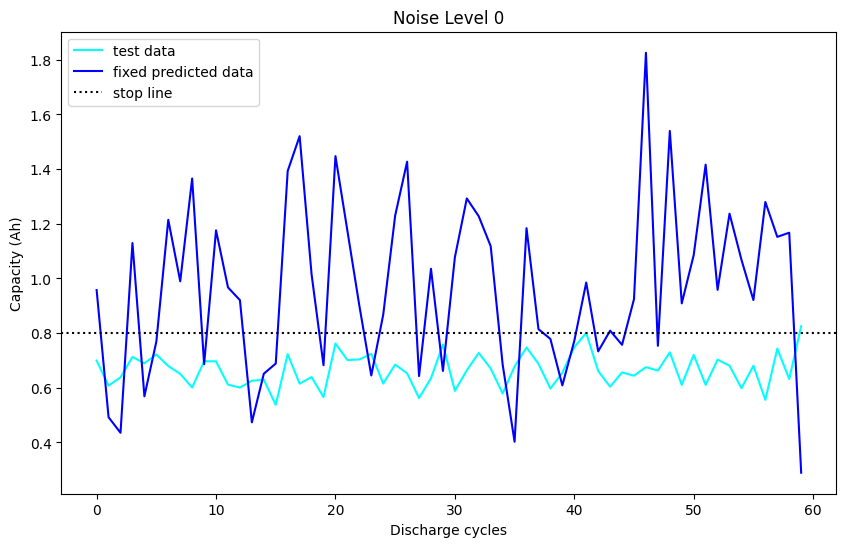

100%|██████████| 60/60 [00:00<00:00, 248.70it/s]



********************Matrices*********************
Test Loss is: 0.9848895291487376
MSE is: 0.283119261264801
CRPS is: 0.4015577681200294


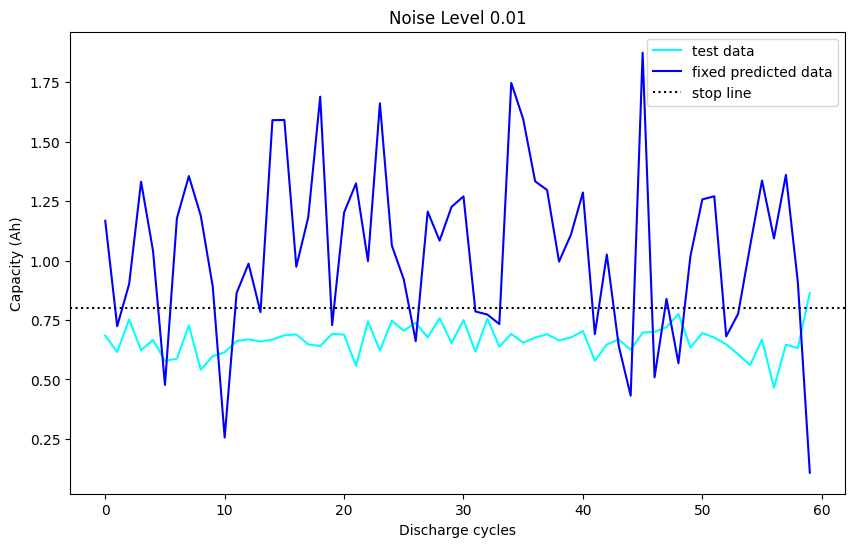

100%|██████████| 60/60 [00:00<00:00, 236.61it/s]



********************Matrices*********************
Test Loss is: 0.9908277548849582
MSE is: 0.234518364071846
CRPS is: 0.3274131943991096


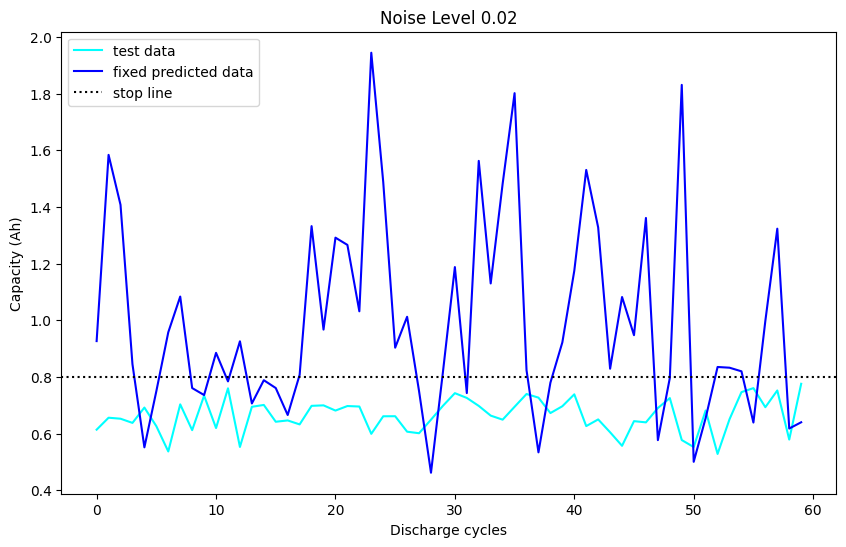

100%|██████████| 60/60 [00:00<00:00, 252.90it/s]



********************Matrices*********************
Test Loss is: 1.0267618228991826
MSE is: 0.289224237203598
CRPS is: 0.39701293522769393


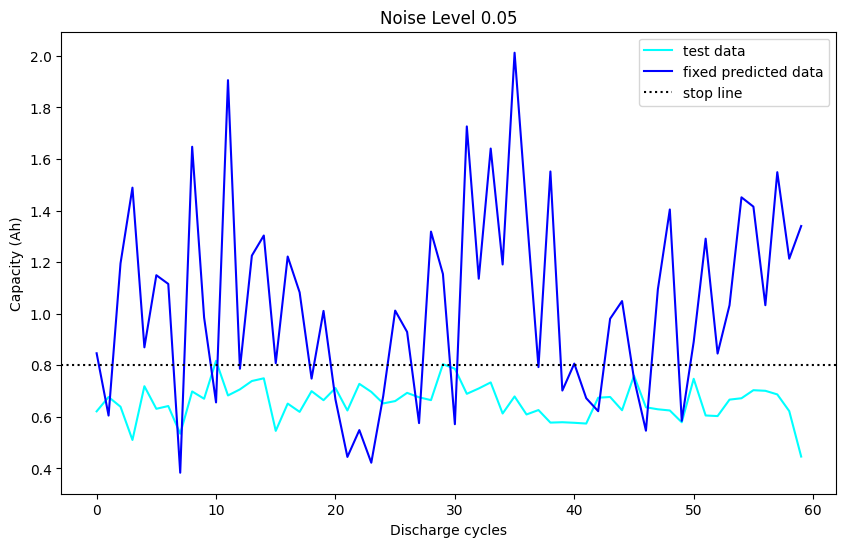

100%|██████████| 60/60 [00:00<00:00, 249.93it/s]



********************Matrices*********************
Test Loss is: 0.9511147717634837
MSE is: 0.20857784152030945
CRPS is: 0.33727721789890847


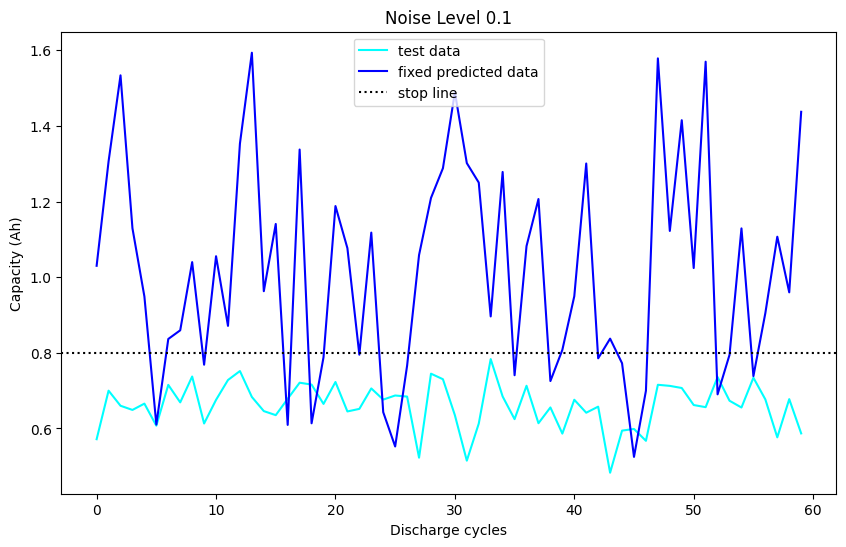

100%|██████████| 60/60 [00:00<00:00, 240.41it/s]



********************Matrices*********************
Test Loss is: 0.9469477618734042
MSE is: 0.21523211896419525
CRPS is: 0.31188289567662014


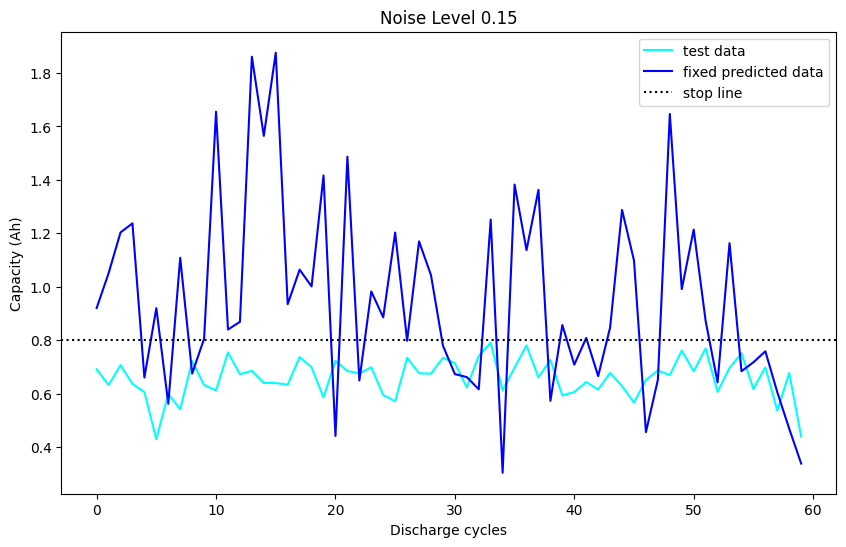

100%|██████████| 60/60 [00:00<00:00, 252.15it/s]



********************Matrices*********************
Test Loss is: 0.9763486628731092
MSE is: 0.3008091151714325
CRPS is: 0.4135183845470474


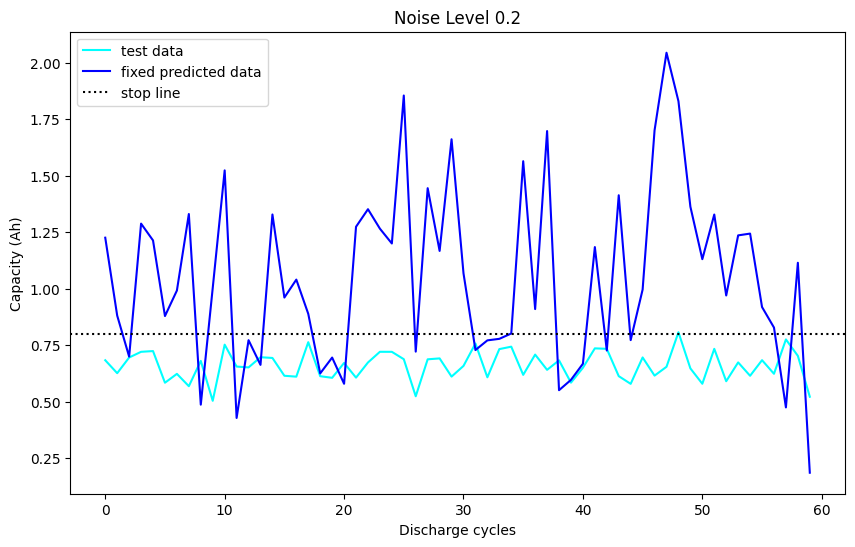

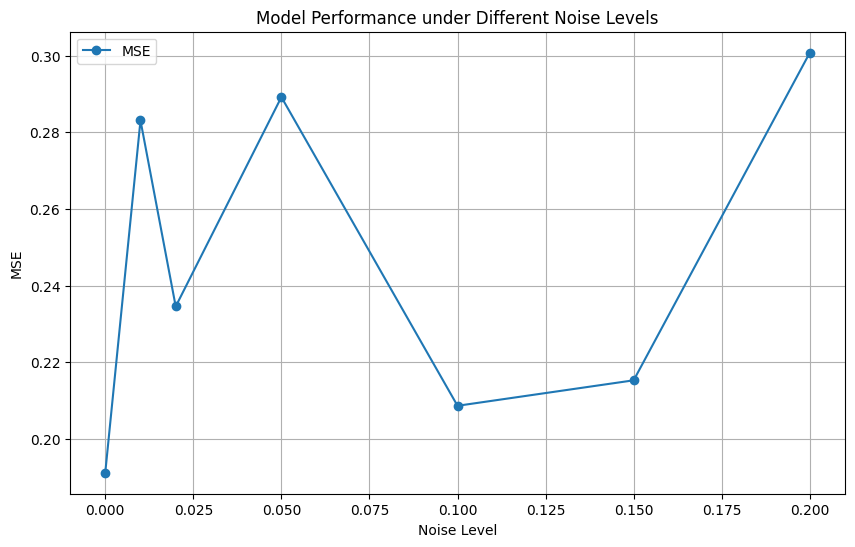

In [18]:

noise_levels = [0, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
results = []

for noise_level in noise_levels:
    noisy_test_loader = []

    #Add Gaussian noise
    for batch in test_loader:
        inputs, labels = batch
        noise = torch.randn_like(inputs) * noise_level
        noisy_inputs = inputs + noise
        noisy_test_loader.append((noisy_inputs, labels))
    CRPS, MSE, loss, predictions = evaluate(is_test=True, model=model, data_loader=noisy_test_loader, nsample=1000, foldername=foldername, title=f'Noise Level {noise_level}')
    results.append((noise_level, CRPS, MSE, loss))
noise_levels, CRPS_values, MSE_values, loss_values = zip(*results)
plt.figure(figsize=(10, 6))
plt.plot(noise_levels, MSE_values, label='MSE', marker='o')
plt.xlabel('Noise Level')
plt.ylabel('MSE')
plt.title('Model Performance under Different Noise Levels')
plt.legend()
plt.grid(True)
plt.show()

Starting fold 1/5


Epoch 1/50:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1/50: 100%|██████████| 90/90 [00:01<00:00, 58.26it/s, loss=8]   


Validation Loss: 3.1055633969928906
Model saved with best validation loss: 3.1055633969928906


Epoch 2/50: 100%|██████████| 90/90 [00:01<00:00, 58.23it/s, loss=5.72]


Validation Loss: 2.3994194631991177
Model saved with best validation loss: 2.3994194631991177


Epoch 3/50: 100%|██████████| 90/90 [00:01<00:00, 58.76it/s, loss=1.66]


Validation Loss: 1.172967413197393
Model saved with best validation loss: 1.172967413197393


Epoch 4/50: 100%|██████████| 90/90 [00:01<00:00, 58.49it/s, loss=1.14]


Validation Loss: 1.224015217760335
No improvement count: 1


Epoch 5/50: 100%|██████████| 90/90 [00:01<00:00, 58.62it/s, loss=1.15]


Validation Loss: 1.3618817562642305
No improvement count: 2


Epoch 6/50: 100%|██████████| 90/90 [00:01<00:00, 58.56it/s, loss=1.44]


Validation Loss: 1.0550148694411567
Model saved with best validation loss: 1.0550148694411567


Epoch 7/50: 100%|██████████| 90/90 [00:01<00:00, 57.89it/s, loss=1.26]


Validation Loss: 1.0265697940536167
Model saved with best validation loss: 1.0265697940536167


Epoch 8/50: 100%|██████████| 90/90 [00:01<00:00, 58.41it/s, loss=1.16] 


Validation Loss: 1.1125541614449543
No improvement count: 1


Epoch 9/50: 100%|██████████| 90/90 [00:01<00:00, 58.21it/s, loss=1.2] 


Validation Loss: 1.0951463865197224
No improvement count: 2


Epoch 10/50: 100%|██████████| 90/90 [00:01<00:00, 58.80it/s, loss=1.08]


Validation Loss: 1.094408955263055
No improvement count: 3


Epoch 11/50: 100%|██████████| 90/90 [00:01<00:00, 59.80it/s, loss=1.1] 


Validation Loss: 0.9983166559882786
Model saved with best validation loss: 0.9983166559882786


Epoch 12/50: 100%|██████████| 90/90 [00:01<00:00, 59.69it/s, loss=1.09]


Validation Loss: 1.0666179527407107
No improvement count: 1


Epoch 13/50: 100%|██████████| 90/90 [00:01<00:00, 58.91it/s, loss=1.13] 


Validation Loss: 1.0594033313834148
No improvement count: 2


Epoch 14/50: 100%|██████████| 90/90 [00:01<00:00, 57.91it/s, loss=1.17]


Validation Loss: 0.9905200496963833
Model saved with best validation loss: 0.9905200496963833


Epoch 15/50: 100%|██████████| 90/90 [00:01<00:00, 48.20it/s, loss=1.19]


Validation Loss: 1.102464751057003
No improvement count: 1


Epoch 16/50: 100%|██████████| 90/90 [00:02<00:00, 37.36it/s, loss=1.08]


Validation Loss: 1.2846650610799375
No improvement count: 2


Epoch 17/50: 100%|██████████| 90/90 [00:02<00:00, 37.95it/s, loss=1.07]


Validation Loss: 1.4753675849541374
No improvement count: 3


Epoch 18/50: 100%|██████████| 90/90 [00:02<00:00, 38.52it/s, loss=1.11]


Validation Loss: 0.9986541711765787
No improvement count: 4


Epoch 19/50: 100%|██████████| 90/90 [00:02<00:00, 37.93it/s, loss=1.1]  


Validation Loss: 1.1189411723095437
No improvement count: 5


Epoch 20/50: 100%|██████████| 90/90 [00:02<00:00, 38.69it/s, loss=1.08]


Validation Loss: 1.0439890182536582
No improvement count: 6


Epoch 21/50: 100%|██████████| 90/90 [00:02<00:00, 37.96it/s, loss=1.12]


Validation Loss: 1.04452652775723
No improvement count: 7


Epoch 22/50: 100%|██████████| 90/90 [00:02<00:00, 39.95it/s, loss=1.09] 


Validation Loss: 0.958412123763043
Model saved with best validation loss: 0.958412123763043


Epoch 23/50: 100%|██████████| 90/90 [00:02<00:00, 37.58it/s, loss=1.02] 


Validation Loss: 1.014160798943561
No improvement count: 1


Epoch 24/50: 100%|██████████| 90/90 [00:02<00:00, 37.53it/s, loss=1.07] 


Validation Loss: 0.9753130570701931
No improvement count: 2


Epoch 25/50: 100%|██████████| 90/90 [00:02<00:00, 36.87it/s, loss=1.07] 


Validation Loss: 0.9938059941582058
No improvement count: 3


Epoch 26/50: 100%|██████████| 90/90 [00:02<00:00, 37.09it/s, loss=1.87] 


Validation Loss: 1.1459321172341057
No improvement count: 4


Epoch 27/50: 100%|██████████| 90/90 [00:02<00:00, 37.75it/s, loss=1.36]


Validation Loss: 1.1420501729716426
No improvement count: 5


Epoch 28/50: 100%|██████████| 90/90 [00:02<00:00, 40.73it/s, loss=1.08]


Validation Loss: 0.9775184392929077
No improvement count: 6


Epoch 29/50: 100%|██████████| 90/90 [00:02<00:00, 37.23it/s, loss=1.02] 


Validation Loss: 1.0032106067823328
No improvement count: 7


Epoch 30/50: 100%|██████████| 90/90 [00:02<00:00, 37.32it/s, loss=1.03] 


Validation Loss: 1.0132704947305762
No improvement count: 8


Epoch 31/50: 100%|██████████| 90/90 [00:02<00:00, 37.36it/s, loss=1.03]


Validation Loss: 0.9588339095530303
No improvement count: 9


Epoch 32/50: 100%|██████████| 90/90 [00:02<00:00, 37.92it/s, loss=0.969]


Validation Loss: 0.9495123261990754
Model saved with best validation loss: 0.9495123261990754


Epoch 33/50: 100%|██████████| 90/90 [00:02<00:00, 36.88it/s, loss=0.996]


Validation Loss: 0.9915858973627505
No improvement count: 1


Epoch 34/50: 100%|██████████| 90/90 [00:02<00:00, 40.59it/s, loss=0.978]


Validation Loss: 1.0480682875799097
No improvement count: 2


Epoch 35/50: 100%|██████████| 90/90 [00:02<00:00, 38.65it/s, loss=1.04]


Validation Loss: 1.0217832326889038
No improvement count: 3


Epoch 36/50: 100%|██████████| 90/90 [00:02<00:00, 38.23it/s, loss=1.01] 


Validation Loss: 1.0349625271299612
No improvement count: 4


Epoch 37/50: 100%|██████████| 90/90 [00:02<00:00, 37.65it/s, loss=0.964]


Validation Loss: 1.016422494598057
No improvement count: 5


Epoch 38/50: 100%|██████████| 90/90 [00:02<00:00, 37.61it/s, loss=0.997]


Validation Loss: 1.0024894113126008
No improvement count: 6


Epoch 39/50: 100%|██████████| 90/90 [00:02<00:00, 38.00it/s, loss=1.01] 


Validation Loss: 0.9994391125181447
No improvement count: 7


Epoch 40/50: 100%|██████████| 90/90 [00:02<00:00, 37.94it/s, loss=1.01]


Validation Loss: 0.938663793646771
Model saved with best validation loss: 0.938663793646771


Epoch 41/50: 100%|██████████| 90/90 [00:02<00:00, 42.14it/s, loss=0.983]


Validation Loss: 1.0403313921845478
No improvement count: 1


Epoch 42/50: 100%|██████████| 90/90 [00:02<00:00, 38.68it/s, loss=1.03]


Validation Loss: 0.9444009169288303
No improvement count: 2


Epoch 43/50: 100%|██████████| 90/90 [00:02<00:00, 38.50it/s, loss=1.01]


Validation Loss: 1.0009080016094705
No improvement count: 3


Epoch 44/50: 100%|██████████| 90/90 [00:02<00:00, 37.85it/s, loss=1.02]


Validation Loss: 0.9471581889235455
No improvement count: 4


Epoch 45/50: 100%|██████████| 90/90 [00:02<00:00, 37.25it/s, loss=0.989]


Validation Loss: 1.0414817307306372
No improvement count: 5


Epoch 46/50: 100%|██████████| 90/90 [00:02<00:00, 37.76it/s, loss=0.992]


Validation Loss: 1.0312200059061465
No improvement count: 6


Epoch 47/50: 100%|██████████| 90/90 [00:02<00:00, 40.50it/s, loss=1.05] 


Validation Loss: 0.995558878649836
No improvement count: 7


Epoch 48/50: 100%|██████████| 90/90 [00:01<00:00, 60.00it/s, loss=1.02] 


Validation Loss: 0.9631813660911892
No improvement count: 8


Epoch 49/50: 100%|██████████| 90/90 [00:01<00:00, 59.12it/s, loss=0.975]


Validation Loss: 0.9980913918951283
No improvement count: 9


Epoch 50/50: 100%|██████████| 90/90 [00:01<00:00, 58.49it/s, loss=0.952]


Validation Loss: 1.0197785885437676
No improvement count: 10


100%|██████████| 23/23 [00:00<00:00, 207.33it/s]
/tmp/ipykernel_1418040/2526701894.py:123: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  crps_value, _ = quad(integrand, -np.inf, np.inf)



********************Matrices*********************
Test Loss is: 0.3904254784186681
MSE is: 0.25195395946502686
CRPS is: 0.3567130035255292


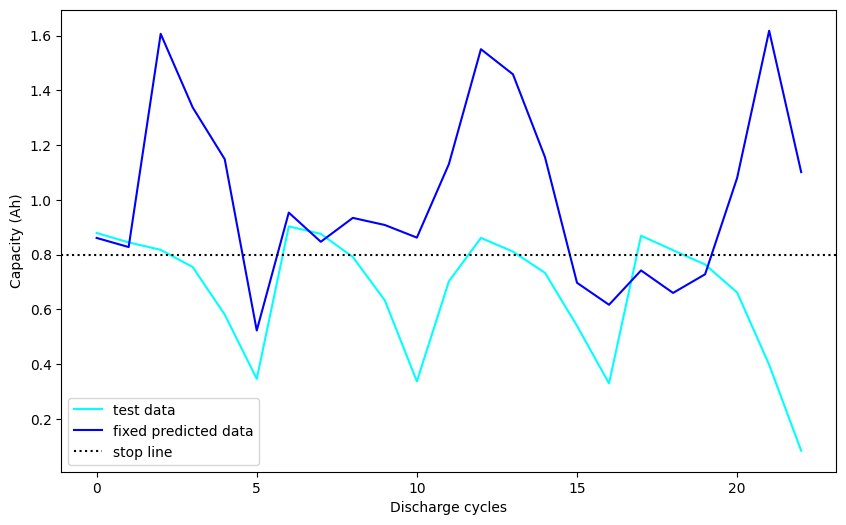

Fold 1 results: CRPS=0.4135183845470474, MSE=0.3008091151714325, Test Loss=0.3904254784186681
Starting fold 2/5


Epoch 1/50: 100%|██████████| 90/90 [00:01<00:00, 55.73it/s, loss=3.26]


Validation Loss: 2.0550392088682754
Model saved with best validation loss: 2.0550392088682754


Epoch 2/50: 100%|██████████| 90/90 [00:01<00:00, 58.23it/s, loss=6.13]


Validation Loss: 1.7933625656625498
Model saved with best validation loss: 1.7933625656625498


Epoch 3/50: 100%|██████████| 90/90 [00:01<00:00, 57.95it/s, loss=1.34]


Validation Loss: 1.0766185340674028
Model saved with best validation loss: 1.0766185340674028


Epoch 4/50: 100%|██████████| 90/90 [00:01<00:00, 58.57it/s, loss=1.2] 


Validation Loss: 1.3219997390456821
No improvement count: 1


Epoch 5/50: 100%|██████████| 90/90 [00:01<00:00, 58.54it/s, loss=1.13]


Validation Loss: 1.2502516145291536
No improvement count: 2


Epoch 6/50: 100%|██████████| 90/90 [00:01<00:00, 58.52it/s, loss=1.23]


Validation Loss: 1.2808327934016353
No improvement count: 3


Epoch 7/50: 100%|██████████| 90/90 [00:01<00:00, 58.28it/s, loss=1.14]


Validation Loss: 1.331532535345658
No improvement count: 4


Epoch 8/50: 100%|██████████| 90/90 [00:01<00:00, 58.47it/s, loss=1.08]


Validation Loss: 1.0378564673921336
Model saved with best validation loss: 1.0378564673921336


Epoch 9/50: 100%|██████████| 90/90 [00:01<00:00, 58.75it/s, loss=1.32]


Validation Loss: 1.5051505591558374
No improvement count: 1


Epoch 10/50: 100%|██████████| 90/90 [00:01<00:00, 58.16it/s, loss=1.15]


Validation Loss: 1.48658315513445
No improvement count: 2


Epoch 11/50: 100%|██████████| 90/90 [00:01<00:00, 58.31it/s, loss=1.11]


Validation Loss: 1.0397135796754255
No improvement count: 3


Epoch 12/50: 100%|██████████| 90/90 [00:01<00:00, 58.15it/s, loss=1.07] 


Validation Loss: 1.0259364998858909
Model saved with best validation loss: 1.0259364998858909


Epoch 13/50: 100%|██████████| 90/90 [00:01<00:00, 58.32it/s, loss=1.13] 


Validation Loss: 1.2814230037772136
No improvement count: 1


Epoch 14/50: 100%|██████████| 90/90 [00:01<00:00, 58.38it/s, loss=1.13]


Validation Loss: 1.4383148214091426
No improvement count: 2


Epoch 15/50: 100%|██████████| 90/90 [00:01<00:00, 58.59it/s, loss=1.14]


Validation Loss: 1.2561220189799434
No improvement count: 3


Epoch 16/50: 100%|██████████| 90/90 [00:01<00:00, 58.24it/s, loss=1.11]


Validation Loss: 1.2552412618761477
No improvement count: 4


Epoch 17/50: 100%|██████████| 90/90 [00:01<00:00, 58.35it/s, loss=1.08]


Validation Loss: 1.0442691989566968
No improvement count: 5


Epoch 18/50: 100%|██████████| 90/90 [00:01<00:00, 58.21it/s, loss=1.12]


Validation Loss: 1.1288861425026604
No improvement count: 6


Epoch 19/50: 100%|██████████| 90/90 [00:01<00:00, 58.67it/s, loss=1.14]


Validation Loss: 1.037565353124038
No improvement count: 7


Epoch 20/50: 100%|██████████| 90/90 [00:01<00:00, 58.41it/s, loss=1.04]


Validation Loss: 0.9880964470946271
Model saved with best validation loss: 0.9880964470946271


Epoch 21/50: 100%|██████████| 90/90 [00:01<00:00, 58.43it/s, loss=0.988]


Validation Loss: 1.071724427782971
No improvement count: 1


Epoch 22/50: 100%|██████████| 90/90 [00:01<00:00, 57.99it/s, loss=1.01]


Validation Loss: 1.0037694469742153
No improvement count: 2


Epoch 23/50: 100%|██████████| 90/90 [00:01<00:00, 58.36it/s, loss=1.07]


Validation Loss: 1.259209544762321
No improvement count: 3


Epoch 24/50: 100%|██████████| 90/90 [00:01<00:00, 57.93it/s, loss=1.11]


Validation Loss: 1.0618201001830723
No improvement count: 4


Epoch 25/50: 100%|██████████| 90/90 [00:01<00:00, 58.40it/s, loss=1.02] 


Validation Loss: 0.9312523033307947
Model saved with best validation loss: 0.9312523033307947


Epoch 26/50: 100%|██████████| 90/90 [00:01<00:00, 58.14it/s, loss=0.976]


Validation Loss: 1.007633064104163
No improvement count: 1


Epoch 27/50: 100%|██████████| 90/90 [00:01<00:00, 58.52it/s, loss=1.01]


Validation Loss: 1.0860574737839077
No improvement count: 2


Epoch 28/50: 100%|██████████| 90/90 [00:01<00:00, 58.65it/s, loss=1]    


Validation Loss: 1.063173216322194
No improvement count: 3


Epoch 29/50: 100%|██████████| 90/90 [00:01<00:00, 58.00it/s, loss=1.03] 


Validation Loss: 1.0745671002761177
No improvement count: 4


Epoch 30/50: 100%|██████████| 90/90 [00:01<00:00, 58.41it/s, loss=0.993]


Validation Loss: 1.039110435091931
No improvement count: 5


Epoch 31/50: 100%|██████████| 90/90 [00:01<00:00, 57.96it/s, loss=1.01] 


Validation Loss: 0.8979007886803668
Model saved with best validation loss: 0.8979007886803668


Epoch 32/50: 100%|██████████| 90/90 [00:01<00:00, 58.02it/s, loss=0.968]


Validation Loss: 0.9117992507374805
No improvement count: 1


Epoch 33/50: 100%|██████████| 90/90 [00:01<00:00, 58.47it/s, loss=1.03] 


Validation Loss: 0.9948873208916705
No improvement count: 2


Epoch 34/50: 100%|██████████| 90/90 [00:01<00:00, 58.05it/s, loss=1.04] 


Validation Loss: 1.0285491217737612
No improvement count: 3


Epoch 35/50: 100%|██████████| 90/90 [00:01<00:00, 58.34it/s, loss=0.979]


Validation Loss: 0.920081016810044
No improvement count: 4


Epoch 36/50: 100%|██████████| 90/90 [00:01<00:00, 58.67it/s, loss=0.982]


Validation Loss: 0.9626445433367854
No improvement count: 5


Epoch 37/50: 100%|██████████| 90/90 [00:01<00:00, 59.64it/s, loss=1.04] 


Validation Loss: 0.9328858800556349
No improvement count: 6


Epoch 38/50: 100%|██████████| 90/90 [00:01<00:00, 59.13it/s, loss=1]    


Validation Loss: 1.065023113851962
No improvement count: 7


Epoch 39/50: 100%|██████████| 90/90 [00:01<00:00, 59.43it/s, loss=1.01] 


Validation Loss: 0.9087151159410891
No improvement count: 8


Epoch 40/50: 100%|██████████| 90/90 [00:01<00:00, 59.31it/s, loss=0.992]


Validation Loss: 1.002535651559415
No improvement count: 9


Epoch 41/50: 100%|██████████| 90/90 [00:01<00:00, 59.44it/s, loss=1.02] 


Validation Loss: 0.96761271227961
No improvement count: 10


Epoch 42/50: 100%|██████████| 90/90 [00:01<00:00, 59.55it/s, loss=1.01] 


Validation Loss: 1.0252277229143225
No improvement count: 11


Epoch 43/50: 100%|██████████| 90/90 [00:01<00:00, 59.25it/s, loss=1]    


Validation Loss: 1.0027250155158665
No improvement count: 12


Epoch 44/50: 100%|██████████| 90/90 [00:01<00:00, 59.42it/s, loss=1.01]


Validation Loss: 0.9346454817315807
No improvement count: 13


Epoch 45/50: 100%|██████████| 90/90 [00:01<00:00, 59.60it/s, loss=0.952]


Validation Loss: 1.044334932513859
No improvement count: 14


Epoch 46/50: 100%|██████████| 90/90 [00:01<00:00, 59.47it/s, loss=1.03]


Validation Loss: 0.9406700937644296
No improvement count: 15


Epoch 47/50: 100%|██████████| 90/90 [00:01<00:00, 58.59it/s, loss=0.987]


Validation Loss: 0.991837405640146
No improvement count: 16


Epoch 48/50: 100%|██████████| 90/90 [00:01<00:00, 58.61it/s, loss=0.992]


Validation Loss: 0.8890963546607805
Model saved with best validation loss: 0.8890963546607805


Epoch 49/50: 100%|██████████| 90/90 [00:01<00:00, 58.54it/s, loss=1.01] 


Validation Loss: 1.0403665252353833
No improvement count: 1


Epoch 50/50: 100%|██████████| 90/90 [00:01<00:00, 58.40it/s, loss=0.99] 


Validation Loss: 1.0346806412157805
No improvement count: 2


100%|██████████| 23/23 [00:00<00:00, 205.60it/s]



********************Matrices*********************
Test Loss is: 0.369862229625384
MSE is: 0.23194530606269836
CRPS is: 0.31572462816222313


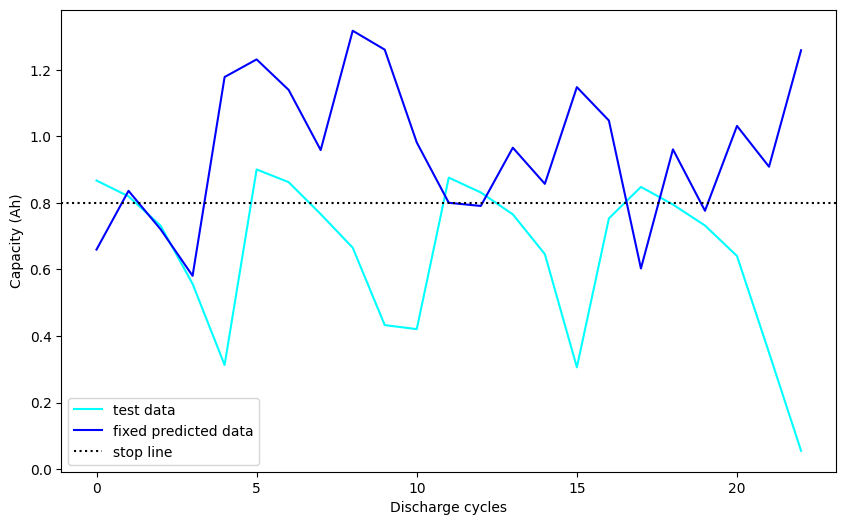

Fold 2 results: CRPS=0.4135183845470474, MSE=0.3008091151714325, Test Loss=0.369862229625384
Starting fold 3/5


Epoch 1/50: 100%|██████████| 90/90 [00:01<00:00, 52.27it/s, loss=8.59]


Validation Loss: 2.3655780087346616
Model saved with best validation loss: 2.3655780087346616


Epoch 2/50: 100%|██████████| 90/90 [00:01<00:00, 52.50it/s, loss=3.81]


Validation Loss: 0.9957106579904971
Model saved with best validation loss: 0.9957106579904971


Epoch 3/50: 100%|██████████| 90/90 [00:01<00:00, 52.21it/s, loss=1.19]


Validation Loss: 1.2926463096038154
No improvement count: 1


Epoch 4/50: 100%|██████████| 90/90 [00:01<00:00, 52.14it/s, loss=1.08] 


Validation Loss: 1.0579034141872241
No improvement count: 2


Epoch 5/50: 100%|██████████| 90/90 [00:01<00:00, 52.11it/s, loss=1.05]


Validation Loss: 1.1344010389369468
No improvement count: 3


Epoch 6/50: 100%|██████████| 90/90 [00:01<00:00, 52.17it/s, loss=1.05]


Validation Loss: 1.2011528092881907
No improvement count: 4


Epoch 7/50: 100%|██████████| 90/90 [00:01<00:00, 52.57it/s, loss=1.08] 


Validation Loss: 1.3158594629038936
No improvement count: 5


Epoch 8/50: 100%|██████████| 90/90 [00:01<00:00, 52.27it/s, loss=1.23]


Validation Loss: 1.0460473026918329
No improvement count: 6


Epoch 9/50: 100%|██████████| 90/90 [00:01<00:00, 51.60it/s, loss=1.09] 


Validation Loss: 0.9791940968969594
Model saved with best validation loss: 0.9791940968969594


Epoch 10/50: 100%|██████████| 90/90 [00:01<00:00, 52.52it/s, loss=1.07] 


Validation Loss: 1.7093193271885747
No improvement count: 1


Epoch 11/50: 100%|██████████| 90/90 [00:01<00:00, 52.55it/s, loss=1.13]


Validation Loss: 0.9589006382486095
Model saved with best validation loss: 0.9589006382486095


Epoch 12/50: 100%|██████████| 90/90 [00:01<00:00, 52.44it/s, loss=1.1]  


Validation Loss: 1.098381169464277
No improvement count: 1


Epoch 13/50: 100%|██████████| 90/90 [00:01<00:00, 52.52it/s, loss=1.05] 


Validation Loss: 1.1194042407948037
No improvement count: 2


Epoch 14/50: 100%|██████████| 90/90 [00:01<00:00, 52.14it/s, loss=1.24]


Validation Loss: 1.2272232200788415
No improvement count: 3


Epoch 15/50: 100%|██████████| 90/90 [00:01<00:00, 52.64it/s, loss=1.09] 


Validation Loss: 1.0758052649705305
No improvement count: 4


Epoch 16/50: 100%|██████████| 90/90 [00:01<00:00, 51.95it/s, loss=1.02] 


Validation Loss: 1.0039405511773152
No improvement count: 5


Epoch 17/50: 100%|██████████| 90/90 [00:01<00:00, 52.13it/s, loss=1.06]


Validation Loss: 1.0007926847623743
No improvement count: 6


Epoch 18/50: 100%|██████████| 90/90 [00:01<00:00, 51.94it/s, loss=1.07]


Validation Loss: 1.0907163438589678
No improvement count: 7


Epoch 19/50: 100%|██████████| 90/90 [00:01<00:00, 51.87it/s, loss=1.08] 


Validation Loss: 1.123789748419886
No improvement count: 8


Epoch 20/50: 100%|██████████| 90/90 [00:01<00:00, 51.95it/s, loss=1.1] 


Validation Loss: 1.333225895529208
No improvement count: 9


Epoch 21/50: 100%|██████████| 90/90 [00:01<00:00, 56.71it/s, loss=1.07]


Validation Loss: 1.0235594692437544
No improvement count: 10


Epoch 22/50: 100%|██████████| 90/90 [00:01<00:00, 58.82it/s, loss=1.08]


Validation Loss: 1.117591917514801
No improvement count: 11


Epoch 23/50: 100%|██████████| 90/90 [00:01<00:00, 59.29it/s, loss=0.941]


Validation Loss: 0.9410955102547355
Model saved with best validation loss: 0.9410955102547355


Epoch 24/50: 100%|██████████| 90/90 [00:01<00:00, 59.40it/s, loss=1.05]


Validation Loss: 1.1242892197940662
No improvement count: 1


Epoch 25/50: 100%|██████████| 90/90 [00:01<00:00, 58.42it/s, loss=1.01] 


Validation Loss: 0.9987587695536406
No improvement count: 2


Epoch 26/50: 100%|██████████| 90/90 [00:01<00:00, 58.34it/s, loss=1.01] 


Validation Loss: 1.0100083791691323
No improvement count: 3


Epoch 27/50: 100%|██████████| 90/90 [00:01<00:00, 58.36it/s, loss=1.02] 


Validation Loss: 1.02288019657135
No improvement count: 4


Epoch 28/50: 100%|██████████| 90/90 [00:01<00:00, 57.78it/s, loss=1.05]


Validation Loss: 1.0940542635710344
No improvement count: 5


Epoch 29/50: 100%|██████████| 90/90 [00:01<00:00, 58.47it/s, loss=0.967]


Validation Loss: 0.994184672832489
No improvement count: 6


Epoch 30/50: 100%|██████████| 90/90 [00:01<00:00, 58.33it/s, loss=1.02] 


Validation Loss: 1.028590096079785
No improvement count: 7


Epoch 31/50: 100%|██████████| 90/90 [00:01<00:00, 58.26it/s, loss=0.994]


Validation Loss: 0.994133376556894
No improvement count: 8


Epoch 32/50: 100%|██████████| 90/90 [00:01<00:00, 58.64it/s, loss=1.01] 


Validation Loss: 1.0471897773120715
No improvement count: 9


Epoch 33/50: 100%|██████████| 90/90 [00:01<00:00, 58.62it/s, loss=0.991]


Validation Loss: 0.946501313344292
No improvement count: 10


Epoch 34/50: 100%|██████████| 90/90 [00:01<00:00, 58.87it/s, loss=0.997]


Validation Loss: 0.9217498250629591
Model saved with best validation loss: 0.9217498250629591


Epoch 35/50: 100%|██████████| 90/90 [00:01<00:00, 57.99it/s, loss=1.05]


Validation Loss: 1.0686246208522632
No improvement count: 1


Epoch 36/50: 100%|██████████| 90/90 [00:01<00:00, 58.44it/s, loss=1]    


Validation Loss: 0.9719229962514795
No improvement count: 2


Epoch 37/50: 100%|██████████| 90/90 [00:01<00:00, 58.28it/s, loss=0.959]


Validation Loss: 0.9960682677186053
No improvement count: 3


Epoch 38/50: 100%|██████████| 90/90 [00:01<00:00, 58.29it/s, loss=0.991]


Validation Loss: 0.9492985632108606
No improvement count: 4


Epoch 39/50: 100%|██████████| 90/90 [00:01<00:00, 58.34it/s, loss=0.997]


Validation Loss: 1.1148712298144465
No improvement count: 5


Epoch 40/50: 100%|██████████| 90/90 [00:01<00:00, 57.65it/s, loss=1.01] 


Validation Loss: 1.093338264071423
No improvement count: 6


Epoch 41/50: 100%|██████████| 90/90 [00:01<00:00, 57.77it/s, loss=1.01] 


Validation Loss: 1.0485044847364011
No improvement count: 7


Epoch 42/50: 100%|██████████| 90/90 [00:01<00:00, 57.81it/s, loss=0.979]


Validation Loss: 1.0630373825197634
No improvement count: 8


Epoch 43/50: 100%|██████████| 90/90 [00:01<00:00, 57.99it/s, loss=1.01] 


Validation Loss: 1.0302427307419155
No improvement count: 9


Epoch 44/50: 100%|██████████| 90/90 [00:01<00:00, 58.28it/s, loss=0.995]


Validation Loss: 1.0658800783364668
No improvement count: 10


Epoch 45/50: 100%|██████████| 90/90 [00:01<00:00, 58.02it/s, loss=1.03] 


Validation Loss: 1.09638235879981
No improvement count: 11


Epoch 46/50: 100%|██████████| 90/90 [00:01<00:00, 57.86it/s, loss=0.984]


Validation Loss: 1.0083458138548809
No improvement count: 12


Epoch 47/50: 100%|██████████| 90/90 [00:01<00:00, 58.33it/s, loss=0.986]


Validation Loss: 0.8932510381159575
Model saved with best validation loss: 0.8932510381159575


Epoch 48/50: 100%|██████████| 90/90 [00:01<00:00, 57.85it/s, loss=1.04]


Validation Loss: 1.001719101615574
No improvement count: 1


Epoch 49/50: 100%|██████████| 90/90 [00:01<00:00, 58.29it/s, loss=0.999]


Validation Loss: 1.0086276272068853
No improvement count: 2


Epoch 50/50: 100%|██████████| 90/90 [00:01<00:00, 57.89it/s, loss=1.01] 


Validation Loss: 0.9778717445290607
No improvement count: 3


100%|██████████| 23/23 [00:00<00:00, 204.94it/s]



********************Matrices*********************
Test Loss is: 0.36596549650033317
MSE is: 0.2239588499069214
CRPS is: 0.34749417495018303


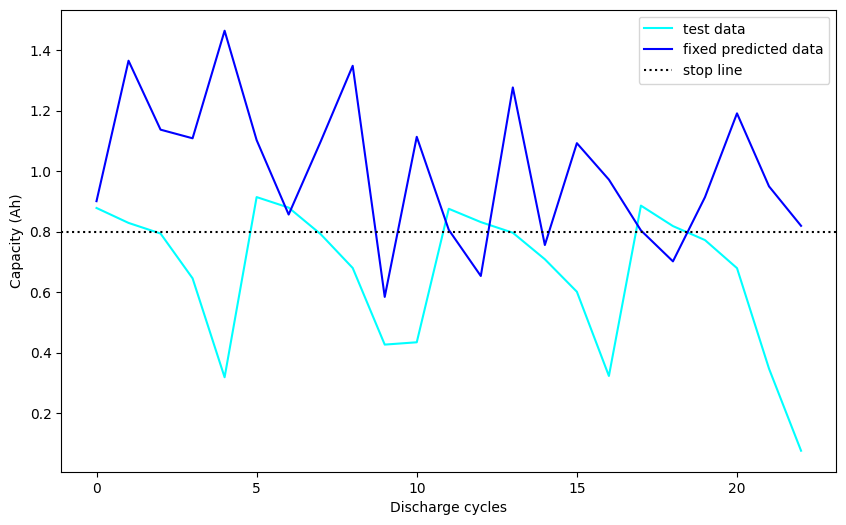

Fold 3 results: CRPS=0.4135183845470474, MSE=0.3008091151714325, Test Loss=0.36596549650033317
Starting fold 4/5


Epoch 1/50: 100%|██████████| 90/90 [00:01<00:00, 52.21it/s, loss=8.44]


Validation Loss: 2.0106685731721963
Model saved with best validation loss: 2.0106685731721963


Epoch 2/50: 100%|██████████| 90/90 [00:01<00:00, 51.98it/s, loss=5.19]


Validation Loss: 1.8088645416757334
Model saved with best validation loss: 1.8088645416757334


Epoch 3/50: 100%|██████████| 90/90 [00:01<00:00, 52.13it/s, loss=1.28]


Validation Loss: 1.11150533479193
Model saved with best validation loss: 1.11150533479193


Epoch 4/50: 100%|██████████| 90/90 [00:01<00:00, 51.99it/s, loss=1.09]


Validation Loss: 1.0981375523235486
Model saved with best validation loss: 1.0981375523235486


Epoch 5/50: 100%|██████████| 90/90 [00:01<00:00, 52.03it/s, loss=1.04]


Validation Loss: 1.2083239995914956
No improvement count: 1


Epoch 6/50: 100%|██████████| 90/90 [00:01<00:00, 52.11it/s, loss=1.15]


Validation Loss: 1.1032150206358537
No improvement count: 2


Epoch 7/50: 100%|██████████| 90/90 [00:01<00:00, 52.02it/s, loss=1.05] 


Validation Loss: 1.0894208213557368
Model saved with best validation loss: 1.0894208213557368


Epoch 8/50: 100%|██████████| 90/90 [00:01<00:00, 51.81it/s, loss=1.21]


Validation Loss: 1.7597127790036409
No improvement count: 1


Epoch 9/50: 100%|██████████| 90/90 [00:01<00:00, 51.54it/s, loss=1.07]


Validation Loss: 1.0272126871606577
Model saved with best validation loss: 1.0272126871606577


Epoch 10/50: 100%|██████████| 90/90 [00:01<00:00, 51.70it/s, loss=1.1] 


Validation Loss: 1.0841389039288396
No improvement count: 1


Epoch 11/50: 100%|██████████| 90/90 [00:01<00:00, 51.34it/s, loss=1.07]


Validation Loss: 1.1163692254087199
No improvement count: 2


Epoch 12/50: 100%|██████████| 90/90 [00:01<00:00, 51.34it/s, loss=1.13]


Validation Loss: 1.3357371739719226
No improvement count: 3


Epoch 13/50: 100%|██████████| 90/90 [00:01<00:00, 51.62it/s, loss=1.1] 


Validation Loss: 1.017204225063324
Model saved with best validation loss: 1.017204225063324


Epoch 14/50: 100%|██████████| 90/90 [00:01<00:00, 51.91it/s, loss=1.14] 


Validation Loss: 1.0782373184743135
No improvement count: 1


Epoch 15/50: 100%|██████████| 90/90 [00:01<00:00, 54.58it/s, loss=1.18]


Validation Loss: 1.038655400276184
No improvement count: 2


Epoch 16/50: 100%|██████████| 90/90 [00:01<00:00, 55.41it/s, loss=1.15]


Validation Loss: 1.0338287509006003
No improvement count: 3


Epoch 17/50: 100%|██████████| 90/90 [00:01<00:00, 57.91it/s, loss=1.06]


Validation Loss: 0.9965833917908047
Model saved with best validation loss: 0.9965833917908047


Epoch 18/50: 100%|██████████| 90/90 [00:01<00:00, 56.19it/s, loss=1.01] 


Validation Loss: 1.0378307544666787
No improvement count: 1


Epoch 19/50: 100%|██████████| 90/90 [00:01<00:00, 55.91it/s, loss=1.09]


Validation Loss: 1.0451535193816475
No improvement count: 2


Epoch 20/50: 100%|██████████| 90/90 [00:01<00:00, 56.10it/s, loss=1.06] 


Validation Loss: 0.971550122551296
Model saved with best validation loss: 0.971550122551296


Epoch 21/50: 100%|██████████| 90/90 [00:01<00:00, 55.92it/s, loss=1.03] 


Validation Loss: 0.9877182504405146
No improvement count: 1


Epoch 22/50: 100%|██████████| 90/90 [00:01<00:00, 55.85it/s, loss=1.01]


Validation Loss: 1.039976223655369
No improvement count: 2


Epoch 23/50: 100%|██████████| 90/90 [00:01<00:00, 56.71it/s, loss=1.03]


Validation Loss: 0.9967496680176776
No improvement count: 3


Epoch 24/50: 100%|██████████| 90/90 [00:01<00:00, 57.99it/s, loss=1.03] 


Validation Loss: 1.1618048341377922
No improvement count: 4


Epoch 25/50: 100%|██████████| 90/90 [00:01<00:00, 57.99it/s, loss=1.03]


Validation Loss: 1.0418757355731467
No improvement count: 5


Epoch 26/50: 100%|██████████| 90/90 [00:01<00:00, 57.91it/s, loss=1.01] 


Validation Loss: 1.0057684053545413
No improvement count: 6


Epoch 27/50: 100%|██████████| 90/90 [00:01<00:00, 57.06it/s, loss=0.985]


Validation Loss: 0.9908699548762777
No improvement count: 7


Epoch 28/50: 100%|██████████| 90/90 [00:01<00:00, 58.14it/s, loss=1]    


Validation Loss: 1.0757069898688274
No improvement count: 8


Epoch 29/50: 100%|██████████| 90/90 [00:01<00:00, 58.02it/s, loss=1.02] 


Validation Loss: 1.1227253053499304
No improvement count: 9


Epoch 30/50: 100%|██████████| 90/90 [00:01<00:00, 57.73it/s, loss=1.06] 


Validation Loss: 1.0819555430308632
No improvement count: 10


Epoch 31/50: 100%|██████████| 90/90 [00:01<00:00, 57.74it/s, loss=1.02] 


Validation Loss: 0.9575731261916782
Model saved with best validation loss: 0.9575731261916782


Epoch 32/50: 100%|██████████| 90/90 [00:01<00:00, 58.26it/s, loss=1.02] 


Validation Loss: 1.0472327496694482
No improvement count: 1


Epoch 33/50: 100%|██████████| 90/90 [00:01<00:00, 58.07it/s, loss=0.963]


Validation Loss: 1.0186844856842705
No improvement count: 2


Epoch 34/50: 100%|██████████| 90/90 [00:01<00:00, 58.01it/s, loss=0.986]


Validation Loss: 1.0016114504440972
No improvement count: 3


Epoch 35/50: 100%|██████████| 90/90 [00:01<00:00, 57.76it/s, loss=0.997]


Validation Loss: 1.000352426715519
No improvement count: 4


Epoch 36/50: 100%|██████████| 90/90 [00:01<00:00, 57.92it/s, loss=0.984]


Validation Loss: 1.0063642859458923
No improvement count: 5


Epoch 37/50: 100%|██████████| 90/90 [00:01<00:00, 58.01it/s, loss=0.997]


Validation Loss: 0.9465742111206055
Model saved with best validation loss: 0.9465742111206055


Epoch 38/50: 100%|██████████| 90/90 [00:01<00:00, 58.02it/s, loss=0.981]


Validation Loss: 1.0337364855019942
No improvement count: 1


Epoch 39/50: 100%|██████████| 90/90 [00:01<00:00, 58.64it/s, loss=1.02] 


Validation Loss: 1.0182048432205035
No improvement count: 2


Epoch 40/50: 100%|██████████| 90/90 [00:01<00:00, 58.53it/s, loss=0.977]


Validation Loss: 1.0462735476701155
No improvement count: 3


Epoch 41/50: 100%|██████████| 90/90 [00:01<00:00, 57.92it/s, loss=0.978]


Validation Loss: 0.9608249560646389
No improvement count: 4


Epoch 42/50: 100%|██████████| 90/90 [00:01<00:00, 58.41it/s, loss=0.994]


Validation Loss: 1.1121439830116604
No improvement count: 5


Epoch 43/50: 100%|██████████| 90/90 [00:01<00:00, 57.66it/s, loss=1.03] 


Validation Loss: 1.0131595808526743
No improvement count: 6


Epoch 44/50: 100%|██████████| 90/90 [00:01<00:00, 57.86it/s, loss=0.978]


Validation Loss: 0.9366098486858866
Model saved with best validation loss: 0.9366098486858866


Epoch 45/50: 100%|██████████| 90/90 [00:01<00:00, 58.32it/s, loss=1.02]


Validation Loss: 1.062261954597805
No improvement count: 1


Epoch 46/50: 100%|██████████| 90/90 [00:01<00:00, 55.21it/s, loss=1.02] 


Validation Loss: 0.9494063050850577
No improvement count: 2


Epoch 47/50: 100%|██████████| 90/90 [00:01<00:00, 57.61it/s, loss=1.06]


Validation Loss: 0.9983263948689336
No improvement count: 3


Epoch 48/50: 100%|██████████| 90/90 [00:01<00:00, 58.36it/s, loss=0.999]


Validation Loss: 0.9613374251386394
No improvement count: 4


Epoch 49/50: 100%|██████████| 90/90 [00:01<00:00, 56.43it/s, loss=1.02] 


Validation Loss: 1.0876754496408545
No improvement count: 5


Epoch 50/50: 100%|██████████| 90/90 [00:01<00:00, 58.31it/s, loss=1.05] 


Validation Loss: 0.9629032145375791
No improvement count: 6


100%|██████████| 23/23 [00:00<00:00, 205.30it/s]



********************Matrices*********************
Test Loss is: 0.37670959532260895
MSE is: 0.2907031774520874
CRPS is: 0.4384549673878556


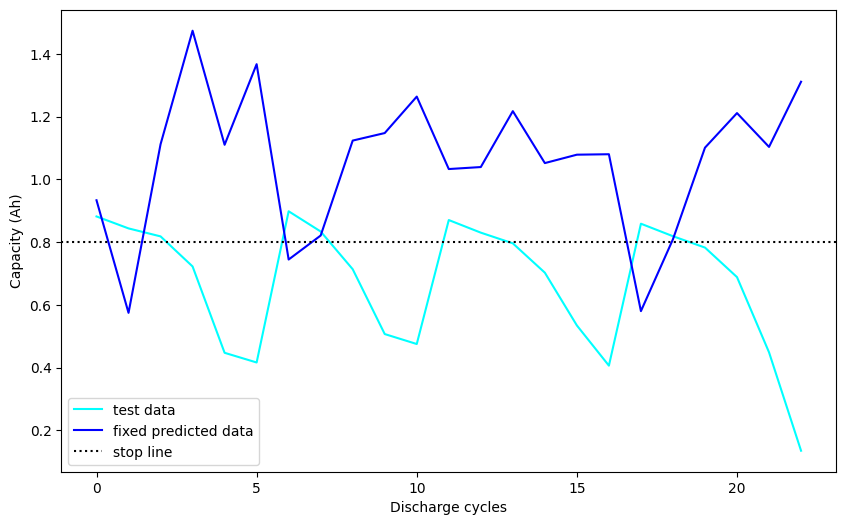

Fold 4 results: CRPS=0.4135183845470474, MSE=0.3008091151714325, Test Loss=0.37670959532260895
Starting fold 5/5


Epoch 1/50: 100%|██████████| 90/90 [00:01<00:00, 59.97it/s, loss=45]  


Validation Loss: 23.61817218946374
Model saved with best validation loss: 23.61817218946374


Epoch 2/50: 100%|██████████| 90/90 [00:01<00:00, 57.64it/s, loss=5.75]


Validation Loss: 1.9451409371002861
Model saved with best validation loss: 1.9451409371002861


Epoch 3/50: 100%|██████████| 90/90 [00:01<00:00, 58.18it/s, loss=1.49]


Validation Loss: 0.995877760907878
Model saved with best validation loss: 0.995877760907878


Epoch 4/50: 100%|██████████| 90/90 [00:01<00:00, 58.12it/s, loss=1.14]


Validation Loss: 1.1868915609691455
No improvement count: 1


Epoch 5/50: 100%|██████████| 90/90 [00:01<00:00, 58.01it/s, loss=1.04]


Validation Loss: 1.161305906979934
No improvement count: 2


Epoch 6/50: 100%|██████████| 90/90 [00:01<00:00, 58.41it/s, loss=1.15]


Validation Loss: 1.1234581911045571
No improvement count: 3


Epoch 7/50: 100%|██████████| 90/90 [00:01<00:00, 58.39it/s, loss=1.08]


Validation Loss: 1.0968216009761975
No improvement count: 4


Epoch 8/50: 100%|██████████| 90/90 [00:01<00:00, 58.07it/s, loss=1.1] 


Validation Loss: 1.118806110775989
No improvement count: 5


Epoch 9/50: 100%|██████████| 90/90 [00:01<00:00, 63.20it/s, loss=1.33]


Validation Loss: 1.0618536329787711
No improvement count: 6


Epoch 10/50: 100%|██████████| 90/90 [00:01<00:00, 58.30it/s, loss=1.17]


Validation Loss: 1.597196021805639
No improvement count: 7


Epoch 11/50: 100%|██████████| 90/90 [00:01<00:00, 58.96it/s, loss=1.27]


Validation Loss: 1.1582772006159243
No improvement count: 8


Epoch 12/50: 100%|██████████| 90/90 [00:01<00:00, 58.99it/s, loss=1.1] 


Validation Loss: 0.9512141165526017
Model saved with best validation loss: 0.9512141165526017


Epoch 13/50: 100%|██████████| 90/90 [00:01<00:00, 58.56it/s, loss=1.09]


Validation Loss: 0.9713218808174133
No improvement count: 1


Epoch 14/50: 100%|██████████| 90/90 [00:01<00:00, 59.34it/s, loss=1.07] 


Validation Loss: 1.254352313020955
No improvement count: 2


Epoch 15/50: 100%|██████████| 90/90 [00:01<00:00, 58.56it/s, loss=1.02]


Validation Loss: 1.1928267789923626
No improvement count: 3


Epoch 16/50: 100%|██████████| 90/90 [00:01<00:00, 59.01it/s, loss=1.07]


Validation Loss: 1.0070774503376172
No improvement count: 4


Epoch 17/50: 100%|██████████| 90/90 [00:01<00:00, 59.55it/s, loss=1.03]


Validation Loss: 1.115854465443155
No improvement count: 5


Epoch 18/50: 100%|██████████| 90/90 [00:01<00:00, 58.76it/s, loss=1.1] 


Validation Loss: 1.1592564323674077
No improvement count: 6


Epoch 19/50: 100%|██████████| 90/90 [00:01<00:00, 58.48it/s, loss=1.13]


Validation Loss: 1.0377494200416233
No improvement count: 7


Epoch 20/50: 100%|██████████| 90/90 [00:01<00:00, 59.01it/s, loss=1.07]


Validation Loss: 1.087049935175025
No improvement count: 8


Epoch 21/50: 100%|██████████| 90/90 [00:01<00:00, 59.71it/s, loss=1]    


Validation Loss: 1.0032170648160188
No improvement count: 9


Epoch 22/50: 100%|██████████| 90/90 [00:01<00:00, 57.04it/s, loss=0.995]


Validation Loss: 1.048632492189822
No improvement count: 10


Epoch 23/50: 100%|██████████| 90/90 [00:01<00:00, 55.28it/s, loss=1.05] 


Validation Loss: 1.108938683634219
No improvement count: 11


Epoch 24/50: 100%|██████████| 90/90 [00:01<00:00, 56.27it/s, loss=1.13]


Validation Loss: 1.0788804448169211
No improvement count: 12


Epoch 25/50: 100%|██████████| 90/90 [00:01<00:00, 55.69it/s, loss=1.05] 


Validation Loss: 1.0024273758349211
No improvement count: 13


Epoch 26/50: 100%|██████████| 90/90 [00:01<00:00, 57.09it/s, loss=0.988]


Validation Loss: 1.049474985703178
No improvement count: 14


Epoch 27/50: 100%|██████████| 90/90 [00:01<00:00, 58.63it/s, loss=0.984]


Validation Loss: 0.9745182939197706
No improvement count: 15


Epoch 28/50: 100%|██████████| 90/90 [00:01<00:00, 57.88it/s, loss=1.03] 


Validation Loss: 1.1043646387431933
No improvement count: 16


Epoch 29/50: 100%|██████████| 90/90 [00:01<00:00, 58.69it/s, loss=1.07]


Validation Loss: 1.0539446421291516
No improvement count: 17


Epoch 30/50: 100%|██████████| 90/90 [00:01<00:00, 58.57it/s, loss=1.05] 


Validation Loss: 1.0194222927093506
No improvement count: 18


Epoch 31/50: 100%|██████████| 90/90 [00:01<00:00, 60.14it/s, loss=1.04]


Validation Loss: 1.032292417857958
No improvement count: 19


Epoch 32/50: 100%|██████████| 90/90 [00:01<00:00, 58.61it/s, loss=1.01] 


Validation Loss: 1.2326910132947175
No improvement count: 20


Epoch 33/50: 100%|██████████| 90/90 [00:01<00:00, 59.53it/s, loss=1.01]


Validation Loss: 0.902046500340752
Model saved with best validation loss: 0.902046500340752


Epoch 34/50: 100%|██████████| 90/90 [00:01<00:00, 60.79it/s, loss=1.03] 


Validation Loss: 0.9618081139481586
No improvement count: 1


Epoch 35/50: 100%|██████████| 90/90 [00:01<00:00, 58.59it/s, loss=1.05]


Validation Loss: 1.0603920985823092
No improvement count: 2


Epoch 36/50: 100%|██████████| 90/90 [00:01<00:00, 59.92it/s, loss=1.03]


Validation Loss: 1.0303033590316772
No improvement count: 3


Epoch 37/50: 100%|██████████| 90/90 [00:01<00:00, 58.44it/s, loss=0.987]


Validation Loss: 0.9453279194624528
No improvement count: 4


Epoch 38/50: 100%|██████████| 90/90 [00:01<00:00, 57.94it/s, loss=0.996]


Validation Loss: 0.9598559063413868
No improvement count: 5


Epoch 39/50: 100%|██████████| 90/90 [00:01<00:00, 56.11it/s, loss=1.01] 


Validation Loss: 0.9909316443878672
No improvement count: 6


Epoch 40/50: 100%|██████████| 90/90 [00:01<00:00, 58.36it/s, loss=0.989]


Validation Loss: 1.028203090895777
No improvement count: 7


Epoch 41/50: 100%|██████████| 90/90 [00:01<00:00, 59.10it/s, loss=1.02] 


Validation Loss: 0.9844264115976251
No improvement count: 8


Epoch 42/50: 100%|██████████| 90/90 [00:01<00:00, 63.19it/s, loss=1.02] 


Validation Loss: 0.8908723903738934
Model saved with best validation loss: 0.8908723903738934


Epoch 43/50: 100%|██████████| 90/90 [00:01<00:00, 62.84it/s, loss=1.01]


Validation Loss: 0.9232020974159241
No improvement count: 1


Epoch 44/50: 100%|██████████| 90/90 [00:01<00:00, 60.86it/s, loss=0.981]


Validation Loss: 0.9503987794337065
No improvement count: 2


Epoch 45/50: 100%|██████████| 90/90 [00:01<00:00, 63.30it/s, loss=1]    


Validation Loss: 0.9156231050905974
No improvement count: 3


Epoch 46/50: 100%|██████████| 90/90 [00:01<00:00, 62.99it/s, loss=0.967]


Validation Loss: 0.9760601157727449
No improvement count: 4


Epoch 47/50: 100%|██████████| 90/90 [00:01<00:00, 63.11it/s, loss=1.03] 


Validation Loss: 1.0093687098959219
No improvement count: 5


Epoch 48/50: 100%|██████████| 90/90 [00:01<00:00, 63.63it/s, loss=1.02] 


Validation Loss: 0.9591786550438922
No improvement count: 6


Epoch 49/50: 100%|██████████| 90/90 [00:01<00:00, 62.81it/s, loss=0.99] 


Validation Loss: 0.9659636072490526
No improvement count: 7


Epoch 50/50: 100%|██████████| 90/90 [00:01<00:00, 63.59it/s, loss=1.01] 


Validation Loss: 0.9730220177899236
No improvement count: 8


100%|██████████| 23/23 [00:00<00:00, 202.54it/s]



********************Matrices*********************
Test Loss is: 0.40040904879570005
MSE is: 0.25662678480148315
CRPS is: 0.4197566145093459


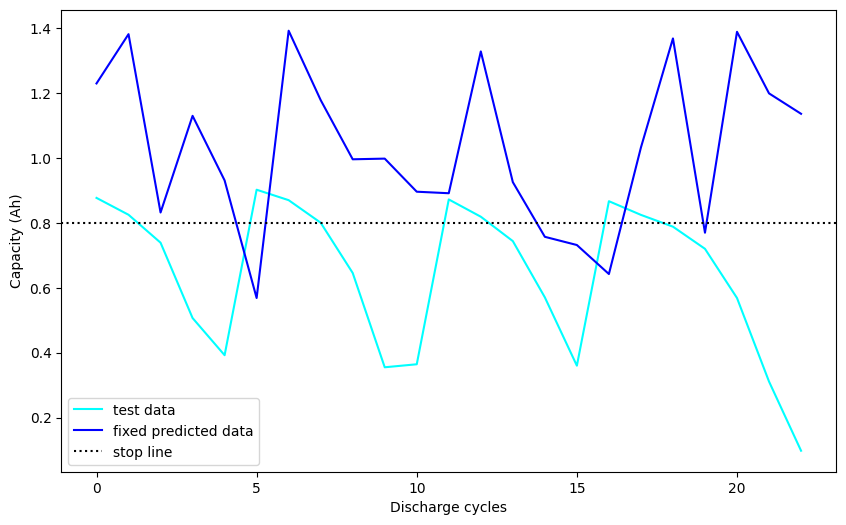

Fold 5 results: CRPS=0.4135183845470474, MSE=0.3008091151714325, Test Loss=0.40040904879570005
Average results across 5 folds: {'train_losses': 1.4202229697002307, 'valid_losses': 1.1883420001268388, 'CRPS': 0.37562867770702735, 'MSE': 0.2510376, 'test_losses': 0.3806743697325389}


In [20]:
from sklearn.model_selection import KFold

def k_fold_cross_validation(config, dataset, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = {
        "train_losses": [],
        "valid_losses": [],
        "CRPS": [],
        "MSE": [],
        "test_losses": []
    }

    for fold, (train_idx, valid_idx) in enumerate(kf.split(range(len(dataset)))):
        print(f"Starting fold {fold+1}/{k}")
        
        train_subset = torch.utils.data.Subset(dataset, train_idx)
        valid_subset = torch.utils.data.Subset(dataset, valid_idx)
        
        train_loadercross = DataLoader(train_subset, batch_size=config.get('train', {}).get('batch_size', 16), shuffle=True)
        valid_loadercross = DataLoader(valid_subset, batch_size=config.get('train', {}).get('batch_size', 16), shuffle=False)
        
        modelcross = TDSTF(config, device).to(device)
        
        trained_modelcross, train_losscross, valid_losscross = train(
            modelcross,
            config,
            train_loadercross,
            valid_loader=valid_loadercross,
            foldername=f'fold_{fold+1}/'
        )

        fold_results["train_losses"].append(train_losscross)
        fold_results["valid_losses"].append(valid_losscross)

        CRPScross, MSEcross, test_losscross, predictionscross = evaluate(
            is_test=True,
            model=trained_modelcross,
            data_loader=valid_loadercross,
            nsample=1000,
            foldername=f'fold_{fold+1}/'
        )
                             
        fold_results["CRPS"].append(CRPScross)
        fold_results["MSE"].append(MSEcross)
        fold_results["test_losses"].append(test_losscross)
        
        print(f"Fold {fold+1} results: CRPS={CRPS}, MSE={MSE}, Test Loss={test_losscross}")
    avg_results = {key: np.mean(values) for key, values in fold_results.items()}
    print(f"Average results across {k} folds: {avg_results}")

    return fold_results, avg_results, CRPScross, MSEcross, test_losscross, train_losscross, valid_losscross

combined_datasets = []
for battery in Battery_list:
    with open(f'preprocess/data/CALCE/{battery}_processed.pkl', 'rb') as f:
        data = pickle.load(f)
        var = data['var']
        target_var = data['target_var']
        X_tensor = torch.tensor(var, dtype=torch.float32)
        y_tensor = torch.tensor(target_var, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        combined_datasets.append(dataset)

full_dataset = ConcatDataset(combined_datasets)
config = yaml.safe_load(open('config/base.yaml', 'r'))
fold_results, avg_results, CRPScross, MSEcross, test_losscross, train_losscross, valid_losscross = k_fold_cross_validation(config, full_dataset, k=5)

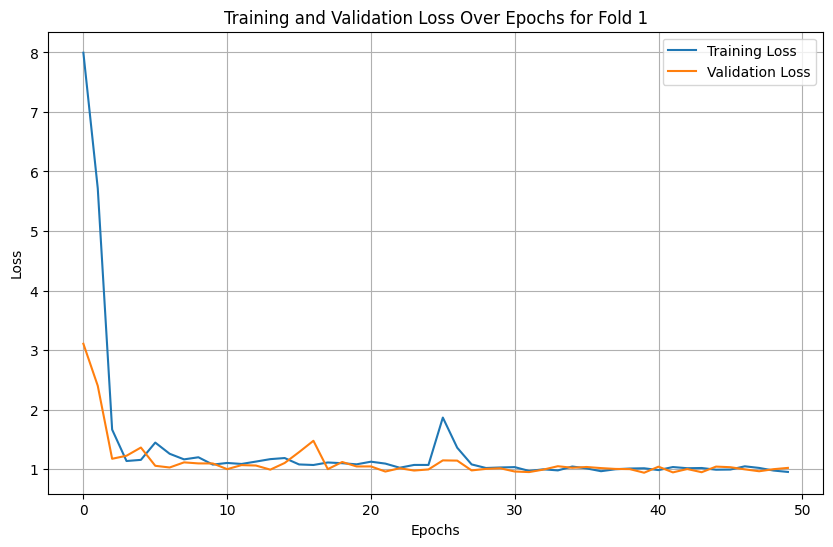

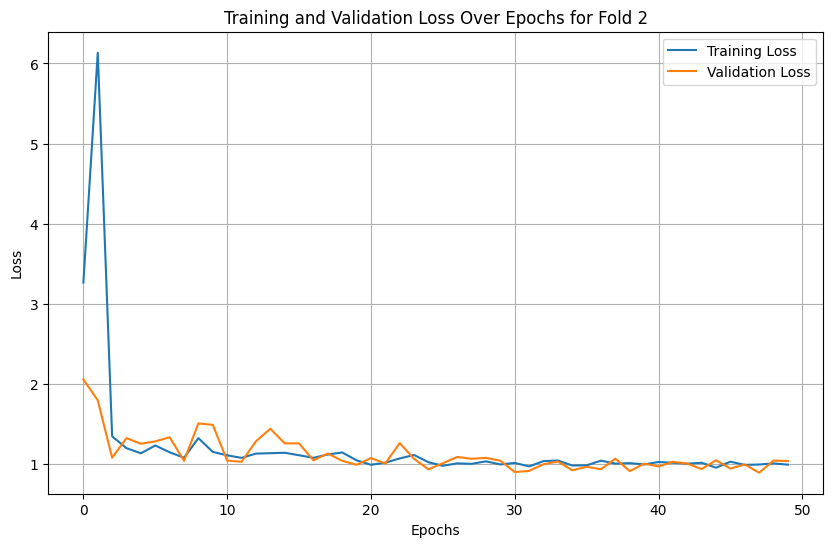

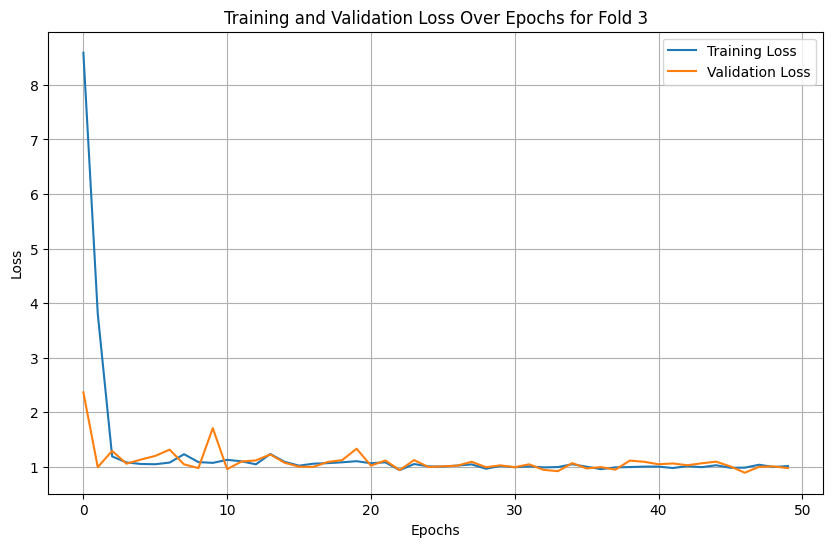

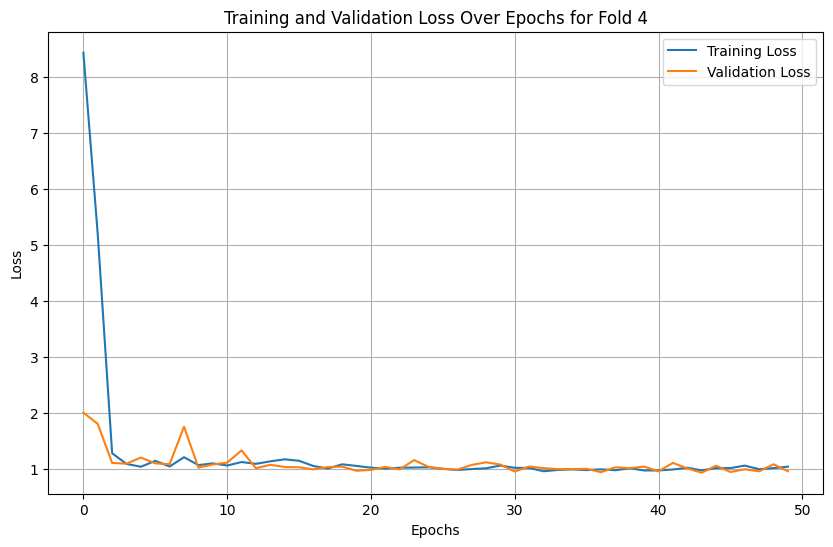

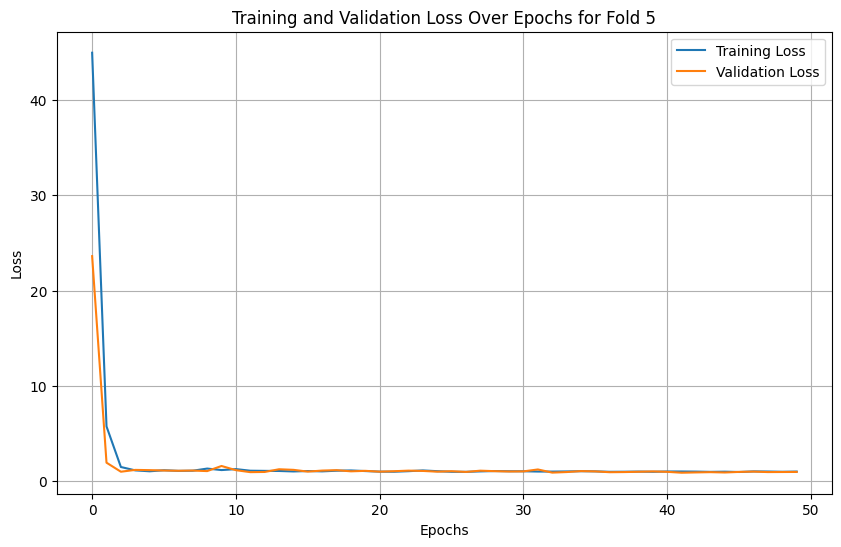

In [21]:
for fold in range(5):
    train_losses = fold_results["train_losses"][fold]
    valid_losses = fold_results["valid_losses"][fold]
    plot_losses(train_losses, valid_losses, test_battery, title=f"Training and Validation Loss Over Epochs for Fold {fold+1}")